## Analysis of Case study of Europe

In [337]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rn
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import pickle
import os
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
import sys
import geopandas as gpd
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from scipy.special import logit, expit
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.stats import multivariate_normal
import math

In [2]:
from algo_full import all_mydmultinom_log

### Preparing data

In [3]:
file_path = 'student_all_nations.txt'
df = pd.read_csv(file_path, sep=' ')
df

CNT  school_id  student_id  grade  gender  immig  video_games  \
1       ALB     800115      800001     10       1    0.0          1.0   
2       ALB     800300      800002     10       1    0.0          0.0   
3       ALB     800088      800003      9       0    0.0          0.0   
4       ALB     800014      800004     10       1    NaN          NaN   
5       ALB     800294      800005     10       1    0.0          1.0   
...     ...        ...         ...    ...     ...    ...          ...   
611998  QRT   98300553    98329092      9       1    0.0          0.0   
611999  QRT   98300772    98329094      9       0    0.0          0.0   
612000  QRT   98300786    98329104      9       1    0.0          0.0   
612001  QRT   98300741    98329116      9       0    0.0          NaN   
612002  QRT   98300060    98329122      9       1    0.0          1.0   

        internet  mmins   tmins  ...  COGFLEX  GFOFAIL  COMPETE   EUDMO  \
1            0.0  180.0  2655.0  ...   0.4704  -1.8939   2.0054  0.9269   
2            NaN   90.0     NaN  ...   0.6715  -0.9295  -0.6888  0.2621   
3            1.0  180.0  2070.0  ...   0.2165  -0.2006  -0.9792  1.3480   
4            NaN    NaN     NaN  ...      NaN      NaN      NaN     NaN   
5            1.0  180.0  1350.0  ...  -1.0189   0.2734  -0.8279 -0.5690   
...          ...    ...     ...  ...      ...      ...      ...     ...   
611998       0.0  225.0  1620.0  ...   0.6715  -0.9823   0.7871  1.7411   
611999       1.0  270.0  1575.0  ...  -0.5994   1.3423  -0.3570 -0.6723   
612000       1.0  225.0  1350.0  ...  -1.2876   0.8207  -1.5513 -0.5690   
612001       NaN    NaN     NaN  ...      NaN      NaN      NaN     NaN   
612002       0.0  180.0  1620.0  ...  -0.8312  -0.6870  -1.7664 -2.1464   

        misced  cultural_possession  home_educ_resources    ESCS      iscedo  \
1          6.0               0.3342              -0.1357 -0.2154     general   
2          2.0              -0.5390              -2.2894 -2.4454  vocational   
3          6.0              -1.6273              -0.4396 -0.3342     general   
4          NaN                  NaN                  NaN     NaN  vocational   
5          2.0              -0.5622              -0.6853 -0.5231  vocational   
...        ...                  ...                  ...     ...         ...   
611998     5.0              -0.8744               0.2646 -1.0530     general   
611999     6.0              -0.4365               1.1793  1.1280     general   
612000     5.0              -1.4561              -0.8532  0.1110     general   
612001     6.0              -0.8431               1.1793  0.2274     general   
612002     6.0              -0.4365               1.1793  1.2941     general   

        math_PISA_score  
1               432.285  
2               334.361  
3               349.201  
4               296.848  
5               445.703  
...                 ...  
611998          531.284  
611999          645.337  
612000          444.767  
612001          375.957  
612002          529.014  

[612002 rows x 26 columns]

In [4]:
pisa_score_binary = (df['math_PISA_score']<482.38).astype(int)
np.sum(pisa_score_binary==1)/len(pisa_score_binary)
df['math_PISA_passed']=pisa_score_binary

In [5]:
df = df.drop(['immig','video_games','internet'], axis=1)

In [6]:
# recentring the variables
for i in df['CNT'].unique():
    mean_cultural_possession = df['cultural_possession'][df['CNT']==i].mean()
    df.loc[df['CNT']==i,'cultural_possession'] = df.loc[df['CNT']==i,'cultural_possession']- mean_cultural_possession
    mean_home_educ_resources = df['home_educ_resources'][df['CNT']==i].mean()
    df.loc[df['CNT']==i,'home_educ_resources'] = df.loc[df['CNT']==i,'home_educ_resources'] - mean_home_educ_resources
    mean_ESCS = df['ESCS'][df['CNT']==i].mean()
    df.loc[df['CNT']==i,'ESCS'] = df.loc[df['CNT']==i,'ESCS'] - mean_ESCS
    mean_sc_BELONG = df['sc_BELONG'][df['CNT']==i].mean()
    df.loc[df['CNT']==i,'sc_BELONG'] = df.loc[df['CNT']==i,'sc_BELONG'] - mean_sc_BELONG
    mean_COMPETE = df['COMPETE'][df['CNT']==i].mean()
    df.loc[df['CNT']==i,'COMPETE'] = df.loc[df['CNT']==i,'COMPETE'] - mean_COMPETE
    mean_TEACHSUP = df['TEACHSUP'][df['CNT']==i].mean()
    df.loc[df['CNT']==i,'TEACHSUP'] = df.loc[df['CNT']==i,'TEACHSUP'] - mean_TEACHSUP
    mean_GFOFAIL = df['GFOFAIL'][df['CNT']==i].mean()
    df.loc[df['CNT']==i,'GFOFAIL'] = df.loc[df['CNT']==i,'GFOFAIL'] - mean_GFOFAIL
    mean_sc_DISCRIM = df['sc_DISCRIM'][df['CNT']==i].mean()
    df.loc[df['CNT']==i,'sc_DISCRIM'] = df.loc[df['CNT']==i,'sc_DISCRIM'] - mean_sc_DISCRIM
    mean_sc_PERCOMP = df['sc_PERCOMP'][df['CNT']==i].mean()
    df.loc[df['CNT']==i,'sc_PERCOMP'] = df.loc[df['CNT']==i,'sc_PERCOMP'] - mean_sc_PERCOMP
    mean_EMOSUPS = df['EMOSUPS'][df['CNT']==i].mean()
    df.loc[df['CNT']==i,'EMOSUPS'] = df.loc[df['CNT']==i,'EMOSUPS'] - mean_EMOSUPS
    mean_EUDMO = df['EUDMO'][df['CNT']==i].mean()
    df.loc[df['CNT']==i,'EUDMO'] = df.loc[df['CNT']==i,'EUDMO'] - mean_EUDMO
    mean_sc_PERCOOP = df['sc_PERCOOP'][df['CNT']==i].mean()
    df.loc[df['CNT']==i,'sc_PERCOOP'] = df.loc[df['CNT']==i,'sc_PERCOOP'] - mean_sc_PERCOOP

In [7]:
eur = ['ESP','ITA','LTU','KAZ','SVK','POL','PRT','DNK','EST','FRA','SWE','IRL','ALB','GBR',
       'CHE','GRC','MLT','LUX','ROU','AUT','BEL','BGR','DEU','FIN','HRV','HUN','ISL','NOR',
       'ROU','SVN','SRB','UKR','MKD','MDA','MNE','CZE','KSV','BIH','LVA','BLR']
df_eur = df[df['CNT'].isin(eur)]
data_1 = df_eur[['iscedo','CNT','gender','cultural_possession', 'ESCS','sc_BELONG','sc_PERCOOP', 'TEACHSUP','math_PISA_passed']]
data_1 = data_1.dropna()
data_1['y'] = data_1['math_PISA_passed']

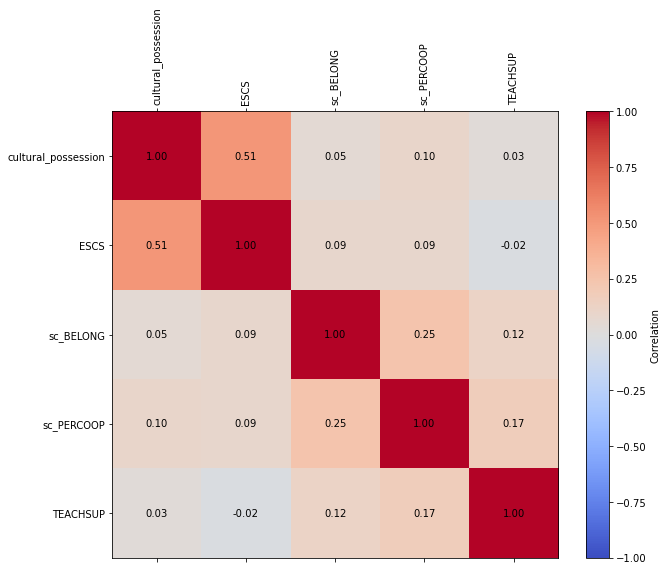

In [8]:
# variables in the inner model
columns_to_keep = ['cultural_possession', 'ESCS','sc_BELONG','sc_PERCOOP', 'TEACHSUP']
correlation_matrix = df_eur[columns_to_keep].corr()
plt.figure(figsize=(10, 8))
plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1, vmin=-1, vmax=1)

# Add annotations for each box
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        plt.text(j, i, "{:.2f}".format(correlation_matrix.iloc[i, j]), ha='center', va='center', color='black')

plt.colorbar(label='Correlation')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.savefig('correlation_matrix.png', bbox_inches='tight')
plt.show()

In [9]:
X_shuffled = shuffle(data_1, random_state=42)
data_train, data_test = train_test_split(X_shuffled, test_size=0.1, random_state=42)

In [17]:
len(data_test['CNT'].unique())

36

In [14]:
len(data_1['y'])

203371

In [16]:
len(data_test['y'])

20338

In [136]:
data_train.to_csv('data_train.csv', index=False)
data_test.to_csv('data_test.csv', index=False)

#### Selection between models with C=2,3,4 using AIC,BIC

In [18]:
# C=2
file_path = '2_case_study_europa_1.pkl'
with open(file_path, 'rb') as file:
    parametri_caricati = pickle.load(file)
    
log_l_2 = parametri_caricati['loglikelihood']
params_2 = parametri_caricati['parameters']
z_2 = parametri_caricati['z']
iter_2 = parametri_caricati['iter']

In [19]:
# C=3
file_path = '2_case_study_europa_2.pkl'
with open(file_path, 'rb') as file:
    parametri_caricati = pickle.load(file)
    
log_l_3 = parametri_caricati['loglikelihood']
params_3 = parametri_caricati['parameters']
z_3 = parametri_caricati['z']
iter_3 = parametri_caricati['iter']

In [199]:
# C=4
file_path = '2_case_study_europa_3.pkl'
with open(file_path, 'rb') as file:
    parametri_caricati = pickle.load(file)
    
log_l_4 = parametri_caricati['loglikelihood']
params_4 = parametri_caricati['parameters']
z_4 = parametri_caricati['z']
iter_4 = parametri_caricati['iter']

In [21]:
# C=5
file_path = '2_case_study_europa_4.pkl'
with open(file_path, 'rb') as file:
    parametri_caricati = pickle.load(file)
    
log_l_5 = parametri_caricati['loglikelihood']
params_5 = parametri_caricati['parameters']
z_5 = parametri_caricati['z']
iter_5 = parametri_caricati['iter']

In [16]:
#C=2
n = len(data_train['y'])
# Numero di parametri nel modello (compreso il termine costante)
k = 7 * 2

# Calcolo AIC e BIC
aic_clust2 = 2 * k - 2 * log_l_2[-1] 
bic_clust2 = np.log(n) * k - 2 * log_l_2[-1]

In [17]:
#C=3
n = len(data_train['y'])
# Numero di parametri nel modello (compreso il termine costante)
k = 7 * 3

# Calcolo AIC e BIC
aic_clust3 = 2 * k - 2 * log_l_3[-1] 
bic_clust3 = np.log(n) * k - 2 * log_l_3[-1]

In [18]:
#C=4
n = len(data_train['y'])
# Numero di parametri nel modello (compreso il termine costante)
k = 7 * 4

# Calcolo AIC e BIC
aic_clust4 = 2 * k - 2 * log_l_4[-1] 
bic_clust4 = np.log(n) * k - 2 * log_l_4[-1]

In [19]:
#C=5
n = len(data_train['y'])
# Numero di parametri nel modello (compreso il termine costante)
k = 7 * 5

# Calcolo AIC e BIC
aic_clust5 = 2 * k - 2 * log_l_5[-1] 
bic_clust5 = np.log(n) * k - 2 * log_l_5[-1]

In [20]:
indici = pd.DataFrame({'2 clusters' : [aic_clust2,bic_clust2],
                    '3 clusters' : [aic_clust3,bic_clust3],
                    '4 clusters' : [aic_clust4,bic_clust4],
                     '5 clusters' : [aic_clust5,bic_clust5] })
indici.index = ['AIC','BIC']
indici

2 clusters    3 clusters    4 clusters    5 clusters
AIC  1.448855e+06  1.466267e+06  1.416184e+06  1.420932e+06
BIC  1.448996e+06  1.466479e+06  1.416467e+06  1.421286e+06

In [202]:
log_l = log_l_4
params = params_4
z = z_4
iter = iter_4

### Analysis of the results for C=4

#### Likelihood

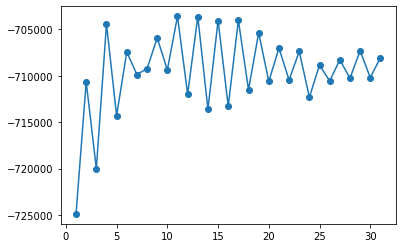

In [164]:
x = list(range(1, iter + 2))
plt.plot(x, log_l_4[1:(iter+2)], marker='o', linestyle='-')
plt.savefig('likelihood.png', bbox_inches='tight')

#### Fitted clusters

In [12]:
fitted_cluster_old = np.zeros(len(data_train['y']))
for i in range(len(data_train['y'])):
  fitted_cluster_old[i] = np.argmax(params['z'][i]) + 1

In [13]:
fitted_cluster = fitted_cluster_old.copy()
for i in range(len(data_train['y'])):
    if fitted_cluster_old[i] == 2:
        fitted_cluster[i] = 3
    elif fitted_cluster_old[i] == 3:
        fitted_cluster[i] = 4
    elif fitted_cluster_old[i] == 4:
        fitted_cluster[i] = 2

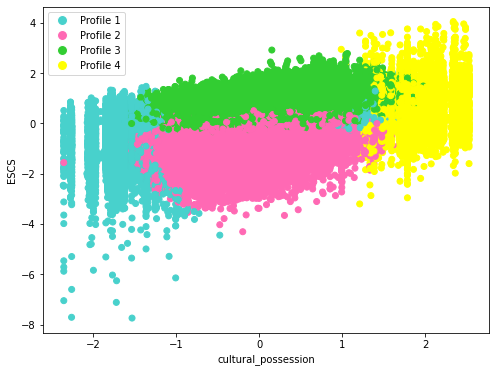

In [39]:
plt.figure(figsize=(8, 6))  # Width = 8 inches, Height = 6 inche
col_fitted = []
for i in range(len(data_train['y'])):
  if fitted_cluster[i]== 1 :
    col_fitted.append('mediumturquoise')
  elif fitted_cluster[i]== 2 :
    col_fitted.append('hotpink')
  elif fitted_cluster[i]== 3 :
    col_fitted.append('limegreen') 
  else :
    col_fitted.append('yellow')
plt.scatter(data_train['cultural_possession'], data_train['ESCS'], color=col_fitted)
plt.ylabel('ESCS')
plt.xlabel('cultural_possession')
color_mapping = {1: 'mediumturquoise', 2: 'hotpink', 3: 'limegreen', 4:'yellow'}
legend_labels = ['Profile 1', 'Profile 2', 'Profile 3','Profile 4']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[i], markersize=10) for i in range(1, 5)]
plt.legend(legend_handles, legend_labels)
plt.savefig('fitted_cluster.png', bbox_inches='tight')

In [343]:
count_1 = np.sum(fitted_cluster==1)/len(data_train['y'])
count_2 = np.sum(fitted_cluster==2)/len(data_train['y'])
count_3 = np.sum(fitted_cluster==3)/len(data_train['y'])
count_4 = np.sum(fitted_cluster==4)/len(data_train['y'])
cardinality = pd.DataFrame({'Profile 1' : [count_1],
                    'Profile 2' : [count_2],
                    'Profile 3' : [count_3],
                     'Profile 4' : [count_4] })
cardinality.index = ['Percentage of samples in profile']
cardinality

Profile 1  Profile 2  Profile 3  Profile 4
Percentage of samples in profile   0.071473   0.442439   0.418056   0.068031

In [211]:
params = {'w' : params_4['w']}
params['mu'] = [params_4['mu'][0],params_4['mu'][3],params_4['mu'][1],params_4['mu'][2]]
params['sigma'] = [params_4['sigma'][:,:,0],params_4['sigma'][:,:,3],params_4['sigma'][:,:,1],params_4['sigma'][:,:,2]]
params['lam'] = [params_4['lam'][0],params_4['lam'][3],params_4['lam'][1],params_4['lam'][2]]
params['rand_inter'] = [params_4['rand_inter'][0],params_4['rand_inter'][3],params_4['rand_inter'][1],params_4['rand_inter'][2]]
params['fix_param'] = [params_4['fix_param'][0],params_4['fix_param'][3],params_4['fix_param'][1],params_4['fix_param'][2]]
params['groups'] = [params_4['groups'][0],params_4['groups'][3],params_4['groups'][1],params_4['groups'][2]]
params['z'] = params_4['z']
params['knots'] = [params_4['knots'][0],params_4['knots'][3],params_4['knots'][1],params_4['knots'][2]]
params['hessian_fix'] = [params_4['hessian_fix'][0],params_4['hessian_fix'][3],params_4['hessian_fix'][1],params_4['hessian_fix'][2]]

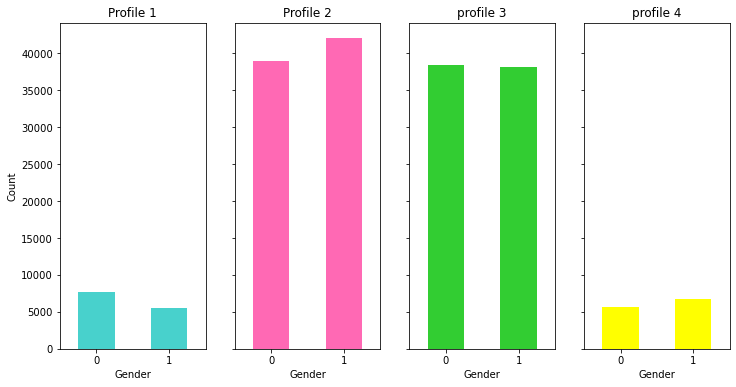

In [221]:
fig, axs = plt.subplots(1, 4, figsize=(12, 6), sharey=True)

data_train[fitted_cluster==1]['gender'].value_counts(sort=False).plot.bar(rot=0,ax=axs[0], color='mediumturquoise')
axs[0].set_title('Profile 1')
axs[0].set_xlabel('Gender')
axs[0].set_ylabel('Count')

data_train[fitted_cluster==2]['gender'].value_counts(sort=False).plot.bar(rot=0,ax=axs[1], color='hotpink')
axs[1].set_title('Profile 2')
axs[1].set_xlabel('Gender')
axs[1].set_ylabel('Count')

data_train[fitted_cluster==3]['gender'].value_counts(sort=False).plot.bar(rot=0,ax=axs[2], color='limegreen')
axs[2].set_title('profile 3')
axs[2].set_xlabel('Gender')
axs[2].set_ylabel('Count')

data_train[fitted_cluster==4]['gender'].value_counts(sort=False).plot.bar(rot=0,ax=axs[3], color='yellow')
axs[3].set_title('profile 4')
axs[3].set_xlabel('Gender')
axs[3].set_ylabel('Count')

plt.savefig('clustering-gender.png', bbox_inches='tight')

In [40]:
df = data_train.copy()

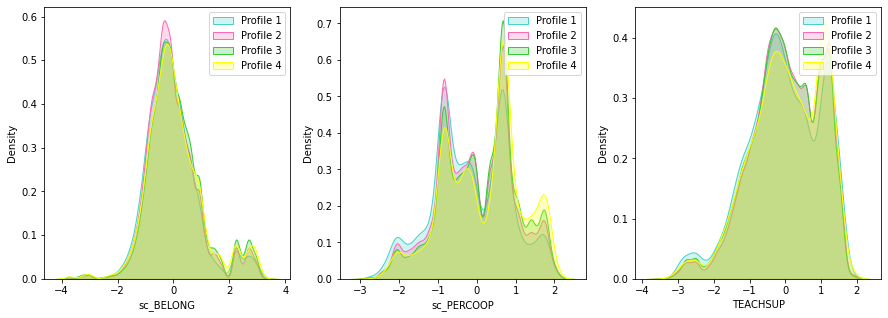

In [345]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(df.loc[fitted_cluster==1]['sc_BELONG'], ax=axs[0], color='mediumturquoise', label='Profile 1', fill=True)
sns.kdeplot(df.loc[fitted_cluster==2]['sc_BELONG'], ax=axs[0], color='hotpink', label='Profile 2', fill=True)
sns.kdeplot(df.loc[fitted_cluster==3]['sc_BELONG'], ax=axs[0], color='limegreen', label='Profile 3', fill=True)
sns.kdeplot(df.loc[fitted_cluster==4]['sc_BELONG'], ax=axs[0], color='yellow', label='Profile 4', fill=True)
axs[0].set_xlabel('sc_BELONG')
axs[0].set_ylabel('Density')
axs[0].legend() 

sns.kdeplot(df.loc[fitted_cluster==1]['sc_PERCOOP'], ax=axs[1], color='mediumturquoise', label='Profile 1', fill=True)
sns.kdeplot(df.loc[fitted_cluster==2]['sc_PERCOOP'], ax=axs[1], color='hotpink', label='Profile 2', fill=True)
sns.kdeplot(df.loc[fitted_cluster==3]['sc_PERCOOP'], ax=axs[1], color='limegreen', label='Profile 3', fill=True)
sns.kdeplot(df.loc[fitted_cluster==4]['sc_PERCOOP'], ax=axs[1], color='yellow', label='Profile 4', fill=True)
axs[1].set_xlabel('sc_PERCOOP')
axs[1].set_ylabel('Density')
axs[1].legend() 

sns.kdeplot(df.loc[fitted_cluster==1]['TEACHSUP'], ax=axs[2], color='mediumturquoise', label='Profile 1', fill=True)
sns.kdeplot(df.loc[fitted_cluster==2]['TEACHSUP'], ax=axs[2], color='hotpink', label='Profile 2', fill=True)
sns.kdeplot(df.loc[fitted_cluster==3]['TEACHSUP'], ax=axs[2], color='limegreen', label='Profile 3', fill=True)
sns.kdeplot(df.loc[fitted_cluster==4]['TEACHSUP'], ax=axs[2], color='yellow', label='Profile 4', fill=True)
axs[2].set_xlabel('TEACHSUP')
axs[2].set_ylabel('Density')
axs[2].legend() 
plt.savefig('Distribuzione variabili interne.png', bbox_inches='tight')

### Analysis of random intercept - groups' clusters

#### Cluster 1

In [222]:
X = pd.DataFrame({'cluster': range(len(params['knots'][0])), 'knots': params['knots'][0]})
Y = pd.DataFrame({'Country': df[fitted_cluster==1].groupby('CNT').count().reset_index()['CNT'], 'cluster': params['groups'][0].flatten().astype(int)})
Z_0 = Y.merge(X, on=['cluster'])
Z_0

Country  cluster     knots
0      ALB        4  1.437775
1      BGR        4  1.437775
2      GRC        4  1.437775
3      HRV        4  1.437775
4      ISL        4  1.437775
5      KAZ        4  1.437775
6      BEL        2 -0.128979
7      CHE        2 -0.128979
8      DEU        2 -0.128979
9      EST        2 -0.128979
10     FIN        2 -0.128979
11     GBR        2 -0.128979
12     IRL        2 -0.128979
13     ITA        2 -0.128979
14     BIH        3  2.837406
15     BLR        3  2.837406
16     KSV        3  2.837406
17     MNE        3  2.837406
18     ROU        3  2.837406
19     CZE        0  0.326066
20     DNK        0  0.326066
21     ESP        0  0.326066
22     FRA        0  0.326066
23     HUN        0  0.326066
24     LUX        0  0.326066
25     MDA        0  0.326066
26     MLT        0  0.326066
27     NOR        0  0.326066
28     POL        0  0.326066
29     PRT        0  0.326066
30     SRB        0  0.326066
31     SVK        0  0.326066
32     SWE        0  0.326066
33     LTU        1  0.772316
34     LVA        1  0.772316
35     SVN        1  0.772316

In [223]:
Z_0.groupby('cluster').count()

Country  knots
cluster                
0             14     14
1              3      3
2              8      8
3              5      5
4              6      6

In [224]:
counts_0 = Z_0.groupby('cluster').count()['Country']/36
counts_0

cluster
0    0.388889
1    0.083333
2    0.222222
3    0.138889
4    0.166667
Name: Country, dtype: float64

In [225]:
clust_0 = Z_0['Country'][Z_0['cluster']==0]
clust_1 = Z_0['Country'][Z_0['cluster']==1]
clust_2 = Z_0['Country'][Z_0['cluster']==2]
clust_3 = Z_0['Country'][Z_0['cluster']==3]
clust_4 = Z_0['Country'][Z_0['cluster']==4]
df_0 = df[fitted_cluster==1].reset_index()

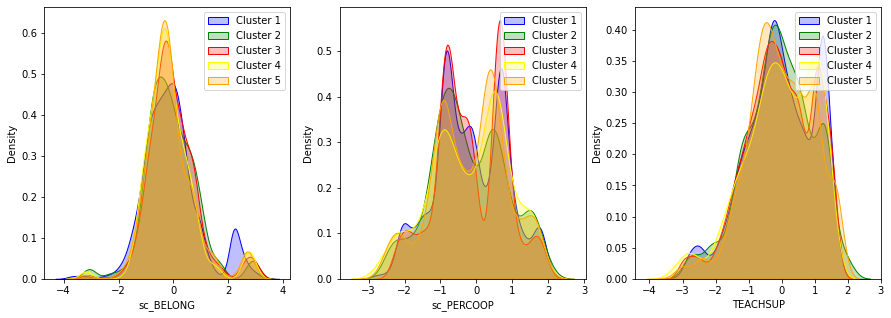

In [226]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(df_0.loc[df_0['CNT'].isin(clust_0)]['sc_BELONG'], ax=axs[0], color='blue', label='Cluster 1', fill=True)
sns.kdeplot(df_0.loc[df_0['CNT'].isin(clust_1)]['sc_BELONG'], ax=axs[0], color='green', label='Cluster 2', fill=True)
sns.kdeplot(df_0.loc[df_0['CNT'].isin(clust_2)]['sc_BELONG'], ax=axs[0], color='red', label='Cluster 3', fill=True)
sns.kdeplot(df_0.loc[df_0['CNT'].isin(clust_3)]['sc_BELONG'], ax=axs[0], color='yellow', label='Cluster 4', fill=True)
sns.kdeplot(df_0.loc[df_0['CNT'].isin(clust_4)]['sc_BELONG'], ax=axs[0], color='orange', label='Cluster 5', fill=True)
axs[0].set_xlabel('sc_BELONG')
axs[0].set_ylabel('Density')
axs[0].legend() 

sns.kdeplot(df_0.loc[df_0['CNT'].isin(clust_0)]['sc_PERCOOP'], ax=axs[1], color='blue', label='Cluster 1', fill=True)
sns.kdeplot(df_0.loc[df_0['CNT'].isin(clust_1)]['sc_PERCOOP'], ax=axs[1], color='green', label='Cluster 2', fill=True)
sns.kdeplot(df_0.loc[df_0['CNT'].isin(clust_2)]['sc_PERCOOP'], ax=axs[1], color='red', label='Cluster 3', fill=True)
sns.kdeplot(df_0.loc[df_0['CNT'].isin(clust_3)]['sc_PERCOOP'], ax=axs[1], color='yellow', label='Cluster 4', fill=True)
sns.kdeplot(df_0.loc[df_0['CNT'].isin(clust_4)]['sc_PERCOOP'], ax=axs[1], color='orange', label='Cluster 5', fill=True)
axs[1].set_xlabel('sc_PERCOOP')
axs[1].set_ylabel('Density')
axs[1].legend() 

sns.kdeplot(df_0.loc[df_0['CNT'].isin(clust_0)]['TEACHSUP'], ax=axs[2], color='blue', label='Cluster 1', fill=True)
sns.kdeplot(df_0.loc[df_0['CNT'].isin(clust_1)]['TEACHSUP'], ax=axs[2], color='green', label='Cluster 2', fill=True)
sns.kdeplot(df_0.loc[df_0['CNT'].isin(clust_2)]['TEACHSUP'], ax=axs[2], color='red', label='Cluster 3', fill=True)
sns.kdeplot(df_0.loc[df_0['CNT'].isin(clust_3)]['TEACHSUP'], ax=axs[2], color='yellow', label='Cluster 4', fill=True)
sns.kdeplot(df_0.loc[df_0['CNT'].isin(clust_4)]['TEACHSUP'], ax=axs[2], color='orange', label='Cluster 5', fill=True)
axs[2].set_xlabel('TEACHSUP')
axs[2].set_ylabel('Density')
axs[2].legend() 
plt.savefig('Distribuzione - cluster1.png', bbox_inches='tight')

In [227]:
beta_0_0 = 0
for i in range(len(params['knots'][0])):
    beta_0_0 += counts_0[i]*params['knots'][0][i]
beta_0_0

0.7962144546192164

In [228]:
Z_0_centred = Z_0.copy()
Z_0_centred['knots'] = Z_0['knots']-beta_0_0

<ipython-input-229-e4f9fc6a2c1b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['Country'][Z['Country']=='KSV'] = '-99'
<ipython-input-229-e4f9fc6a2c1b>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


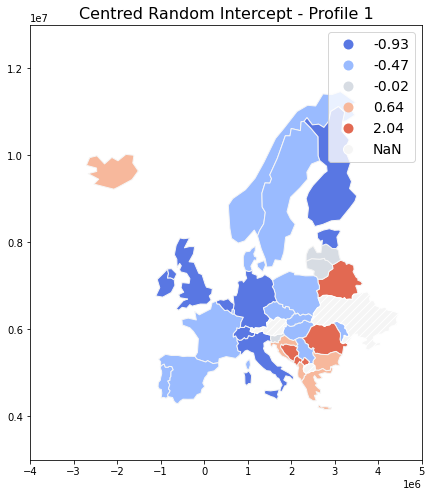

In [229]:
Q = pd.read_excel('iso_countries.xlsx')
Q = Q.rename(columns={'ISO': 'Country', 'Country': 'Names'})
Q = Q[Q['Country'].isin(eur)]
Z = Z_0_centred.merge(Q, on=['Country'])
Z['Country'][Z['Country']=='KSV'] = '-99'
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']
gdf = europe.merge(Z, how='left', left_on='iso_a3', right_on='Country')

xmin, xmax = -4000000, 5000000
ymin, ymax = 3000000, 13000000

# Filter out non-European states (Antarctica, Greenland, and French Southern and Antarctic Lands)
european_states =  ['ESP','ITA','LTU','KAZ','SVK','POL','PRT','DNK','EST','FRA','SWE','IRL','ALB','GBR',
       'CHE','GRC','MLT','LUX','ROU','AUT','BEL','BGR','DEU','FIN','HRV','HUN','ISL','NOR',
       'ROU','SVN','SRB','UKR','MKD','MDA','MNE','CZE','-99','BIH','LVA','BLR']
gdf_europe = gdf[gdf['iso_a3'].isin(european_states)]

# Reproject to pseudo Mercator (EPSG:3857)
gdf_europe = gdf_europe.to_crs('epsg:3857')

# Round the 'knots' column to two decimal places
gdf_europe['knots'] = gdf_europe['knots'].round(2)

# Create a new colormap
coolwarm_cmap = mpl.cm.get_cmap('coolwarm')
newcmp = ListedColormap(coolwarm_cmap(np.linspace(0.1, 0.95, 10)))

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 8))
gdf_europe.plot(column='knots',
                ax=ax,
                cmap=newcmp,
                vmin=0, vmax=5,
                categorical=True,
                legend=True,
                legend_kwds={'fontsize': 14},
                edgecolor='whitesmoke',
                missing_kwds={'edgecolor': 'white', 'facecolor': 'whitesmoke', "hatch": "///"})

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Set plot title
ax.set_title('Centred Random Intercept - Profile 1', fontsize=16)
plt.savefig('mappa_cluster1.png', bbox_inches='tight')
plt.show()

In [230]:
P_0 = Z_0.copy()
n_obs_prof_1 = np.sum(fitted_cluster==1)
P_0 = P_0.rename(columns={'knots': 'perc'})
for i in range(len(P_0['Country'])):
    P_0.loc[i, 'perc']  = len(df_0[df_0['CNT']==P_0['Country'][i]])/n_obs_prof_1*100

In [231]:
from matplotlib.colors import LinearSegmentedColormap

<ipython-input-232-6c11c2469074>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['Country'][Z['Country']=='KSV'] = '-99'
<ipython-input-232-6c11c2469074>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


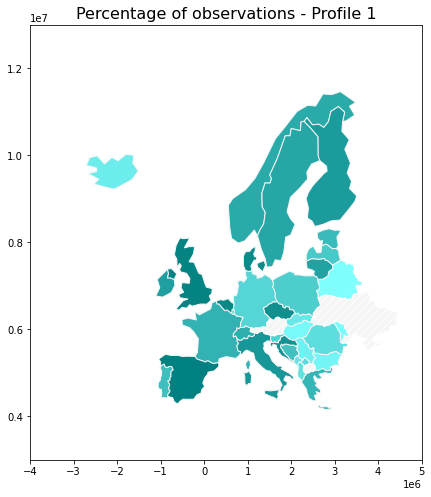

In [232]:
Q = pd.read_excel('iso_countries.xlsx')
Q = Q.rename(columns={'ISO': 'Country', 'Country': 'Names'})
Q = Q[Q['Country'].isin(eur)]
Z = P_0.merge(Q, on=['Country'])
Z['Country'][Z['Country']=='KSV'] = '-99'
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']
gdf = europe.merge(Z, how='left', left_on='iso_a3', right_on='Country')

xmin, xmax = -4000000, 5000000
ymin, ymax = 3000000, 13000000

# Filter out non-European states (Antarctica, Greenland, and French Southern and Antarctic Lands)
european_states =  ['ESP','ITA','LTU','KAZ','SVK','POL','PRT','DNK','EST','FRA','SWE','IRL','ALB','GBR',
       'CHE','GRC','MLT','LUX','ROU','AUT','BEL','BGR','DEU','FIN','HRV','HUN','ISL','NOR',
       'ROU','SVN','SRB','UKR','MKD','MDA','MNE','CZE','-99','BIH','LVA','BLR']
gdf_europe = gdf[gdf['iso_a3'].isin(european_states)]

# Reproject to pseudo Mercator (EPSG:3857)
gdf_europe = gdf_europe.to_crs('epsg:3857')

# Round the 'knots' column to two decimal places
gdf_europe['perc'] = gdf_europe['perc'].round(2)

light_turquoise = [0.5, 1.0, 1.0]  # Light turquoise color
dark_turquoise = [0.0, 0.5, 0.5]   # Dark turquoise color
num_colors = 256
colors = [light_turquoise, dark_turquoise]
new_cmap = LinearSegmentedColormap.from_list("Turquoise", colors, N=num_colors)


# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 8))
gdf_europe.plot(column='perc',
                ax=ax,
                cmap=new_cmap,
                categorical=True,
                edgecolor='whitesmoke',
                missing_kwds={'edgecolor': 'white', 'facecolor': 'whitesmoke', "hatch": "///"})

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Set plot title
ax.set_title('Percentage of observations - Profile 1', fontsize=16)
plt.savefig('mappa_perc_obs_cluster1.png', bbox_inches='tight')
plt.show()

#### Cluster 2

In [233]:
X = pd.DataFrame({'cluster': range(len(params['knots'][1])), 'knots': params['knots'][1]})
Y = pd.DataFrame({'Country': df[fitted_cluster==2].groupby('CNT').count().reset_index()['CNT'], 'cluster': params['groups'][1].flatten().astype(int)})
Z_1 = Y.merge(X, on=['cluster'])
Z_1

Country  cluster     knots
0      ALB        3  1.126741
1      BGR        3  1.126741
2      KAZ        3  1.126741
3      MNE        3  1.126741
4      ROU        3  1.126741
5      BEL        6 -0.079288
6      CHE        6 -0.079288
7      CZE        6 -0.079288
8      DEU        6 -0.079288
9      FIN        6 -0.079288
10     GBR        6 -0.079288
11     IRL        6 -0.079288
12     ITA        6 -0.079288
13     NOR        6 -0.079288
14     SWE        6 -0.079288
15     BIH        5  1.789685
16     KSV        5  1.789685
17     MDA        5  1.789685
18     BLR        2  0.751532
19     GRC        2  0.751532
20     HRV        2  0.751532
21     SRB        2  0.751532
22     DNK        1  0.162719
23     ESP        1  0.162719
24     FRA        1  0.162719
25     ISL        1  0.162719
26     LVA        1  0.162719
27     MLT        1  0.162719
28     PRT        1  0.162719
29     EST        4 -0.400574
30     POL        4 -0.400574
31     HUN        0  0.390861
32     LTU        0  0.390861
33     LUX        0  0.390861
34     SVK        0  0.390861
35     SVN        0  0.390861

In [234]:
Z_1.groupby('cluster').count()

Country  knots
cluster                
0              5      5
1              7      7
2              4      4
3              5      5
4              2      2
5              3      3
6             10     10

In [235]:
clust_0 = Z_1['Country'][Z_1['cluster']==0]
clust_1 = Z_1['Country'][Z_1['cluster']==1]
clust_2 = Z_1['Country'][Z_1['cluster']==2]
clust_3 = Z_1['Country'][Z_1['cluster']==3]
clust_4 = Z_1['Country'][Z_1['cluster']==4]
clust_5 = Z_1['Country'][Z_1['cluster']==5]
clust_6 = Z_1['Country'][Z_1['cluster']==6]
df_1 = df[fitted_cluster==2].reset_index()

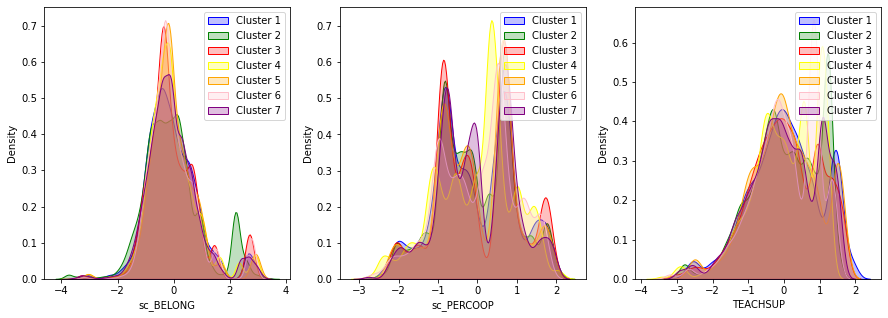

In [236]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(df_1.loc[df_1['CNT'].isin(clust_0)]['sc_BELONG'], ax=axs[0], color='blue', label='Cluster 1', fill=True)
sns.kdeplot(df_1.loc[df_1['CNT'].isin(clust_1)]['sc_BELONG'], ax=axs[0], color='green', label='Cluster 2', fill=True)
sns.kdeplot(df_1.loc[df_1['CNT'].isin(clust_2)]['sc_BELONG'], ax=axs[0], color='red', label='Cluster 3', fill=True)
sns.kdeplot(df_1.loc[df_1['CNT'].isin(clust_3)]['sc_BELONG'], ax=axs[0], color='yellow', label='Cluster 4', fill=True)
sns.kdeplot(df_1.loc[df_1['CNT'].isin(clust_4)]['sc_BELONG'], ax=axs[0], color='orange', label='Cluster 5', fill=True)
sns.kdeplot(df_1.loc[df_1['CNT'].isin(clust_5)]['sc_BELONG'], ax=axs[0], color='pink', label='Cluster 6', fill=True)
sns.kdeplot(df_1.loc[df_1['CNT'].isin(clust_6)]['sc_BELONG'], ax=axs[0], color='purple', label='Cluster 7', fill=True)
axs[0].set_xlabel('sc_BELONG')
axs[0].set_ylabel('Density')
axs[0].legend() 

sns.kdeplot(df_1.loc[df_1['CNT'].isin(clust_0)]['sc_PERCOOP'], ax=axs[1], color='blue', label='Cluster 1', fill=True)
sns.kdeplot(df_1.loc[df_1['CNT'].isin(clust_1)]['sc_PERCOOP'], ax=axs[1], color='green', label='Cluster 2', fill=True)
sns.kdeplot(df_1.loc[df_1['CNT'].isin(clust_2)]['sc_PERCOOP'], ax=axs[1], color='red', label='Cluster 3', fill=True)
sns.kdeplot(df_1.loc[df_1['CNT'].isin(clust_3)]['sc_PERCOOP'], ax=axs[1], color='yellow', label='Cluster 4', fill=True)
sns.kdeplot(df_1.loc[df_1['CNT'].isin(clust_4)]['sc_PERCOOP'], ax=axs[1], color='orange', label='Cluster 5', fill=True)
sns.kdeplot(df_1.loc[df_1['CNT'].isin(clust_5)]['sc_PERCOOP'], ax=axs[1], color='pink', label='Cluster 6', fill=True)
sns.kdeplot(df_1.loc[df_1['CNT'].isin(clust_6)]['sc_PERCOOP'], ax=axs[1], color='purple', label='Cluster 7', fill=True)
axs[1].set_xlabel('sc_PERCOOP')
axs[1].set_ylabel('Density')
axs[1].legend() 

sns.kdeplot(df_1.loc[df_1['CNT'].isin(clust_0)]['TEACHSUP'], ax=axs[2], color='blue', label='Cluster 1', fill=True)
sns.kdeplot(df_1.loc[df_1['CNT'].isin(clust_1)]['TEACHSUP'], ax=axs[2], color='green', label='Cluster 2', fill=True)
sns.kdeplot(df_1.loc[df_1['CNT'].isin(clust_2)]['TEACHSUP'], ax=axs[2], color='red', label='Cluster 3', fill=True)
sns.kdeplot(df_1.loc[df_1['CNT'].isin(clust_3)]['TEACHSUP'], ax=axs[2], color='yellow', label='Cluster 4', fill=True)
sns.kdeplot(df_1.loc[df_1['CNT'].isin(clust_4)]['TEACHSUP'], ax=axs[2], color='orange', label='Cluster 5', fill=True)
sns.kdeplot(df_1.loc[df_1['CNT'].isin(clust_5)]['TEACHSUP'], ax=axs[2], color='pink', label='Cluster 6', fill=True)
sns.kdeplot(df_1.loc[df_1['CNT'].isin(clust_6)]['TEACHSUP'], ax=axs[2], color='purple', label='Cluster 7', fill=True)
axs[2].set_xlabel('TEACHSUP')
axs[2].set_ylabel('Density')
axs[2].legend() 
plt.savefig('Distribuzione - cluster2.png', bbox_inches='tight')

In [237]:
counts_1 = Z_1.groupby('cluster').count()['Country']/len(Z_1['Country'])
counts_1

cluster
0    0.138889
1    0.194444
2    0.111111
3    0.138889
4    0.055556
5    0.083333
6    0.277778
Name: Country, dtype: float64

In [238]:
beta_0_1 = 0
for i in range(len(params['knots'][1])):
    beta_0_1 += counts_1[i]*params['knots'][1][i]
beta_0_1

0.4307833924936891

In [239]:
Z_1_centred = Z_1.copy()
Z_1_centred['knots'] = Z_1['knots']-beta_0_1

<ipython-input-240-7b448f0be4b4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['Country'][Z['Country']=='KSV'] = '-99'
<ipython-input-240-7b448f0be4b4>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


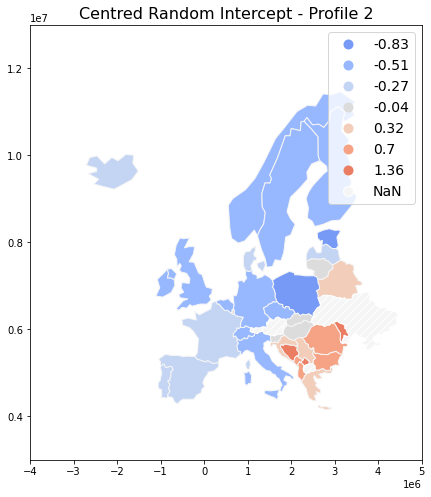

In [240]:
Q = pd.read_excel('iso_countries.xlsx')
Q = Q.rename(columns={'ISO': 'Country', 'Country': 'Names'})
Q = Q[Q['Country'].isin(eur)]
Z = Z_1_centred.merge(Q, on=['Country'])
Z['Country'][Z['Country']=='KSV'] = '-99'
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']
gdf = europe.merge(Z, how='left', left_on='iso_a3', right_on='Country')
xmin, xmax = -4000000, 5000000
ymin, ymax = 3000000, 13000000

# Filter out non-European states (Antarctica, Greenland, and French Southern and Antarctic Lands)
european_states =  ['ESP','ITA','LTU','KAZ','SVK','POL','PRT','DNK','EST','FRA','SWE','IRL','ALB','GBR',
       'CHE','GRC','MLT','LUX','ROU','AUT','BEL','BGR','DEU','FIN','HRV','HUN','ISL','NOR',
       'ROU','SVN','SRB','UKR','MKD','MDA','MNE','CZE','-99','BIH','LVA','BLR']
gdf_europe = gdf[gdf['iso_a3'].isin(european_states)]

# Reproject to pseudo Mercator (EPSG:3857)
gdf_europe = gdf_europe.to_crs('epsg:3857')

# Round the 'knots' column to two decimal places
gdf_europe['knots'] = gdf_europe['knots'].round(2)

# Create a new colormap
coolwarm_cmap = mpl.cm.get_cmap('coolwarm')
newcmp = ListedColormap(coolwarm_cmap(np.linspace(0.1, 0.95, 20)))

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 8))
gdf_europe.plot(column='knots',
                ax=ax,
                cmap=newcmp,
                vmin=-1, vmax=7.5,
                categorical=True,
                legend=True,
                legend_kwds={'fontsize': 14},
                edgecolor='whitesmoke',
                missing_kwds={'edgecolor': 'white', 'facecolor': 'whitesmoke', "hatch": "///"})

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Set plot title
ax.set_title('Centred Random Intercept - Profile 2', fontsize=16)
plt.savefig('mappa_cluster2.png', bbox_inches='tight')
plt.show()

In [241]:
P_1 = Z_1.copy()
n_obs_prof_2 = np.sum(fitted_cluster==2)
P_1 = P_1.rename(columns={'knots': 'perc'})
for i in range(len(P_1['Country'])):
    P_1.loc[i, 'perc']  = len(df_1[df_1['CNT']==P_1['Country'][i]])/n_obs_prof_2*100

<ipython-input-255-10284342da90>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['Country'][Z['Country']=='KSV'] = '-99'
<ipython-input-255-10284342da90>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


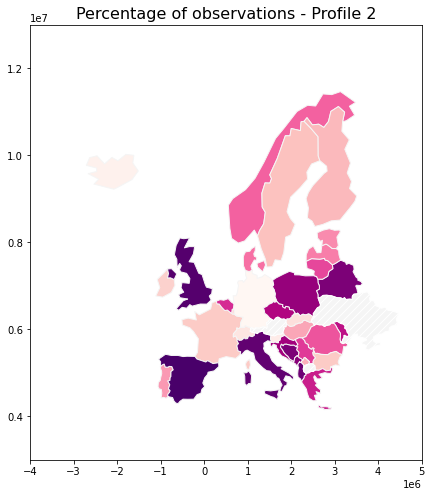

In [255]:
Q = pd.read_excel('iso_countries.xlsx')
Q = Q.rename(columns={'ISO': 'Country', 'Country': 'Names'})
Q = Q[Q['Country'].isin(eur)]
Z = P_1.merge(Q, on=['Country'])
Z['Country'][Z['Country']=='KSV'] = '-99'
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']
gdf = europe.merge(Z, how='left', left_on='iso_a3', right_on='Country')

xmin, xmax = -4000000, 5000000
ymin, ymax = 3000000, 13000000

# Filter out non-European states (Antarctica, Greenland, and French Southern and Antarctic Lands)
european_states =  ['ESP','ITA','LTU','KAZ','SVK','POL','PRT','DNK','EST','FRA','SWE','IRL','ALB','GBR',
       'CHE','GRC','MLT','LUX','ROU','AUT','BEL','BGR','DEU','FIN','HRV','HUN','ISL','NOR',
       'ROU','SVN','SRB','UKR','MKD','MDA','MNE','CZE','-99','BIH','LVA','BLR']
gdf_europe = gdf[gdf['iso_a3'].isin(european_states)]

# Reproject to pseudo Mercator (EPSG:3857)
gdf_europe = gdf_europe.to_crs('epsg:3857')

# Round the 'knots' column to two decimal places
gdf_europe['perc'] = gdf_europe['perc'].round(2)

light_hotpink = '#FF69B4'  # Light hotpink color
dark_hotpink = '#8B0A50'   # Dark hotpink color
num_colors = 256
colors = [light_hotpink, dark_hotpink]
new_cmap = LinearSegmentedColormap.from_list("Hotpink", colors, N=num_colors)


# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 8))
gdf_europe.plot(column='perc',
                ax=ax,
                cmap='RdPu',
                categorical=True,
                edgecolor='whitesmoke',
                missing_kwds={'edgecolor': 'white', 'facecolor': 'whitesmoke', "hatch": "///"})

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Set plot title
ax.set_title('Percentage of observations - Profile 2', fontsize=16)
plt.savefig('mappa_perc_obs_cluster2.png', bbox_inches='tight')
plt.show()

#### Cluster 3

In [243]:
X = pd.DataFrame({'cluster': range(len(params['knots'][2])), 'knots': params['knots'][2]})
Y = pd.DataFrame({'Country': df[fitted_cluster==3].groupby('CNT').count().reset_index()['CNT'], 'cluster': params['groups'][2].flatten().astype(int)})
Z_2 = Y.merge(X, on=['cluster'])
Z_2

Country  cluster     knots
0      ALB        4  0.496830
1      MDA        4  0.496830
2      MNE        4  0.496830
3      BEL        3 -1.325584
4      CHE        3 -1.325584
5      CZE        3 -1.325584
6      DEU        3 -1.325584
7      DNK        3 -1.325584
8      EST        3 -1.325584
9      FIN        3 -1.325584
10     FRA        3 -1.325584
11     NOR        3 -1.325584
12     POL        3 -1.325584
13     SVK        3 -1.325584
14     SVN        3 -1.325584
15     SWE        3 -1.325584
16     BGR        1 -0.166745
17     GRC        1 -0.166745
18     HRV        1 -0.166745
19     SRB        1 -0.166745
20     BIH        6  1.000576
21     BLR        7 -0.550781
22     LTU        7 -0.550781
23     MLT        7 -0.550781
24     ESP        5 -0.880003
25     GBR        5 -0.880003
26     HUN        5 -0.880003
27     IRL        5 -0.880003
28     ISL        5 -0.880003
29     ITA        5 -0.880003
30     LUX        5 -0.880003
31     LVA        5 -0.880003
32     PRT        5 -0.880003
33     KAZ        2  0.245002
34     ROU        2  0.245002
35     KSV        0  2.466647

In [244]:
Z_2.groupby('cluster').count()

Country  knots
cluster                
0              1      1
1              4      4
2              2      2
3             13     13
4              3      3
5              9      9
6              1      1
7              3      3

In [245]:
clust_0 = Z_2['Country'][Z_2['cluster']==0]
clust_1 = Z_2['Country'][Z_2['cluster']==1]
clust_2 = Z_2['Country'][Z_2['cluster']==2]
clust_3 = Z_2['Country'][Z_2['cluster']==3]
clust_4 = Z_2['Country'][Z_2['cluster']==4]
clust_5 = Z_2['Country'][Z_2['cluster']==5]
clust_6 = Z_2['Country'][Z_2['cluster']==6]
clust_7 = Z_2['Country'][Z_2['cluster']==7]
df_2 = df[fitted_cluster==3].reset_index()

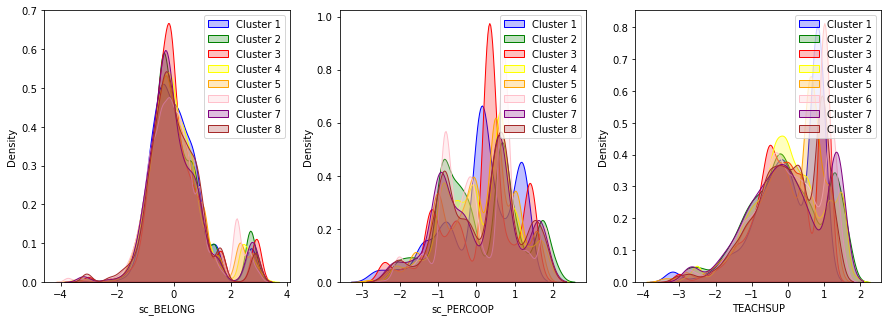

In [246]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_0)]['sc_BELONG'], ax=axs[0], color='blue', label='Cluster 1', fill=True)
sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_1)]['sc_BELONG'], ax=axs[0], color='green', label='Cluster 2', fill=True)
sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_2)]['sc_BELONG'], ax=axs[0], color='red', label='Cluster 3', fill=True)
sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_3)]['sc_BELONG'], ax=axs[0], color='yellow', label='Cluster 4', fill=True)
sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_4)]['sc_BELONG'], ax=axs[0], color='orange', label='Cluster 5', fill=True)
sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_5)]['sc_BELONG'], ax=axs[0], color='pink', label='Cluster 6', fill=True)
sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_6)]['sc_BELONG'], ax=axs[0], color='purple', label='Cluster 7', fill=True)
sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_7)]['sc_BELONG'], ax=axs[0], color='brown', label='Cluster 8', fill=True)
axs[0].set_xlabel('sc_BELONG')
axs[0].set_ylabel('Density')
axs[0].legend() 

sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_0)]['sc_PERCOOP'], ax=axs[1], color='blue', label='Cluster 1', fill=True)
sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_1)]['sc_PERCOOP'], ax=axs[1], color='green', label='Cluster 2', fill=True)
sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_2)]['sc_PERCOOP'], ax=axs[1], color='red', label='Cluster 3', fill=True)
sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_3)]['sc_PERCOOP'], ax=axs[1], color='yellow', label='Cluster 4', fill=True)
sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_4)]['sc_PERCOOP'], ax=axs[1], color='orange', label='Cluster 5', fill=True)
sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_5)]['sc_PERCOOP'], ax=axs[1], color='pink', label='Cluster 6', fill=True)
sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_6)]['sc_PERCOOP'], ax=axs[1], color='purple', label='Cluster 7', fill=True)
sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_7)]['sc_PERCOOP'], ax=axs[1], color='brown', label='Cluster 8', fill=True)
axs[1].set_xlabel('sc_PERCOOP')
axs[1].set_ylabel('Density')
axs[1].legend() 

sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_0)]['TEACHSUP'], ax=axs[2], color='blue', label='Cluster 1', fill=True)
sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_1)]['TEACHSUP'], ax=axs[2], color='green', label='Cluster 2', fill=True)
sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_2)]['TEACHSUP'], ax=axs[2], color='red', label='Cluster 3', fill=True)
sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_3)]['TEACHSUP'], ax=axs[2], color='yellow', label='Cluster 4', fill=True)
sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_4)]['TEACHSUP'], ax=axs[2], color='orange', label='Cluster 5', fill=True)
sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_5)]['TEACHSUP'], ax=axs[2], color='pink', label='Cluster 6', fill=True)
sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_6)]['TEACHSUP'], ax=axs[2], color='purple', label='Cluster 7', fill=True)
sns.kdeplot(df_2.loc[df_2['CNT'].isin(clust_7)]['TEACHSUP'], ax=axs[2], color='brown', label='Cluster 8', fill=True)
axs[2].set_xlabel('TEACHSUP')
axs[2].set_ylabel('Density')
axs[2].legend() 
plt.savefig('Distribuzione - cluster3.png', bbox_inches='tight')

In [248]:
counts_2 = Z_2.groupby('cluster').count()['Country']/len(Z_2['Country'])
counts_2

1.0

In [249]:
beta_0_2 = 0
for i in range(len(params['knots'][2])):
    beta_0_2 += counts_2[i]*params['knots'][2][i]
beta_0_2

-0.6117840809345914

In [250]:
Z_2_centred = Z_2.copy()
Z_2_centred['knots'] = Z_2['knots']-beta_0_2

<ipython-input-253-36cb6495e2e3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['Country'][Z['Country']=='KSV'] = '-99'
<ipython-input-253-36cb6495e2e3>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


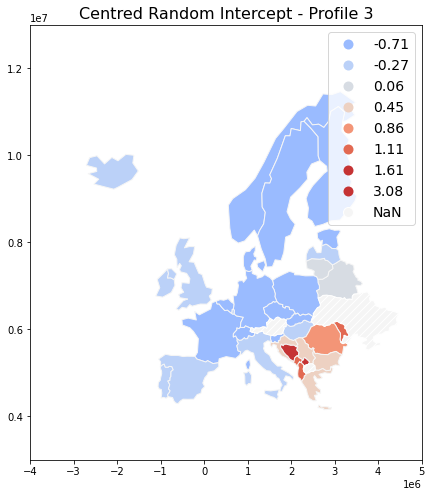

In [253]:
Q = pd.read_excel('iso_countries.xlsx')
Q = Q.rename(columns={'ISO': 'Country', 'Country': 'Names'})
Q = Q[Q['Country'].isin(eur)]
Z = Z_2_centred.merge(Q, on=['Country'])
Z['Country'][Z['Country']=='KSV'] = '-99'
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']
gdf = europe.merge(Z, how='left', left_on='iso_a3', right_on='Country')
xmin, xmax = -4000000, 5000000
ymin, ymax = 3000000, 13000000

# Filter out non-European states (Antarctica, Greenland, and French Southern and Antarctic Lands)
european_states =  ['ESP','ITA','LTU','KAZ','SVK','POL','PRT','DNK','EST','FRA','SWE','IRL','ALB','GBR',
       'CHE','GRC','MLT','LUX','ROU','AUT','BEL','BGR','DEU','FIN','HRV','HUN','ISL','NOR',
       'ROU','SVN','SRB','UKR','MKD','MDA','MNE','CZE','-99','BIH','LVA','BLR']
gdf_europe = gdf[gdf['iso_a3'].isin(european_states)]

# Reproject to pseudo Mercator (EPSG:3857)
gdf_europe = gdf_europe.to_crs('epsg:3857')

# Round the 'knots' column to two decimal places
gdf_europe['knots'] = gdf_europe['knots'].round(2)

# Create a new colormap
coolwarm_cmap = mpl.cm.get_cmap('coolwarm')
newcmp = ListedColormap(coolwarm_cmap(np.linspace(0.1, 0.95, 10)))

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 8))
gdf_europe.plot(column='knots',
                ax=ax,
                cmap=newcmp,
                vmin=-2, vmax=6.5,
                categorical=True,
                legend=True,
                legend_kwds={'fontsize': 14},
                edgecolor='whitesmoke',
                missing_kwds={'edgecolor': 'white', 'facecolor': 'whitesmoke', "hatch": "///"})

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Set plot title
ax.set_title('Centred Random Intercept - Profile 3', fontsize=16)
plt.savefig('mappa_cluster3.png', bbox_inches='tight')
plt.show()

In [254]:
P_2 = Z_2.copy()
n_obs_prof_3 = np.sum(fitted_cluster==3)
P_2 = P_2.rename(columns={'knots': 'perc'})
for i in range(len(P_2['Country'])):
    P_2.loc[i, 'perc']  = len(df_2[df_2['CNT']==P_2['Country'][i]])/n_obs_prof_3*100

<ipython-input-265-7e68d71f47d6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['Country'][Z['Country']=='KSV'] = '-99'
<ipython-input-265-7e68d71f47d6>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


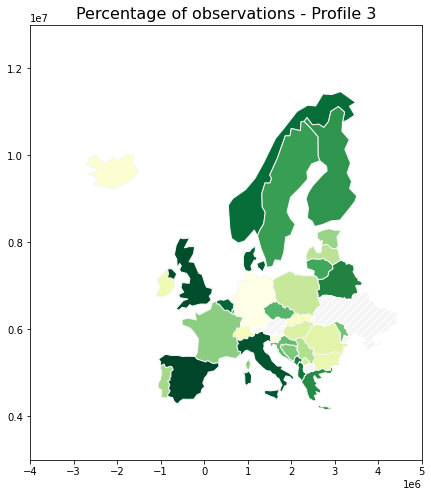

In [265]:
Q = pd.read_excel('iso_countries.xlsx')
Q = Q.rename(columns={'ISO': 'Country', 'Country': 'Names'})
Q = Q[Q['Country'].isin(eur)]
Z = P_2.merge(Q, on=['Country'])
Z['Country'][Z['Country']=='KSV'] = '-99'
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']
gdf = europe.merge(Z, how='left', left_on='iso_a3', right_on='Country')

xmin, xmax = -4000000, 5000000
ymin, ymax = 3000000, 13000000

# Filter out non-European states (Antarctica, Greenland, and French Southern and Antarctic Lands)
european_states =  ['ESP','ITA','LTU','KAZ','SVK','POL','PRT','DNK','EST','FRA','SWE','IRL','ALB','GBR',
       'CHE','GRC','MLT','LUX','ROU','AUT','BEL','BGR','DEU','FIN','HRV','HUN','ISL','NOR',
       'ROU','SVN','SRB','UKR','MKD','MDA','MNE','CZE','-99','BIH','LVA','BLR']
gdf_europe = gdf[gdf['iso_a3'].isin(european_states)]

# Reproject to pseudo Mercator (EPSG:3857)
gdf_europe = gdf_europe.to_crs('epsg:3857')

# Round the 'knots' column to two decimal places
gdf_europe['perc'] = gdf_europe['perc'].round(2)

light_yellow = '#FFFF99'  
dark_yellow = '#FFD700'    
num_colors = 256
colors = [light_yellow, dark_yellow]
new_cmap = LinearSegmentedColormap.from_list("Yellow", colors, N=num_colors)


# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 8))
gdf_europe.plot(column='perc',
                ax=ax,
                cmap='YlGn',
                categorical=True,
                edgecolor='whitesmoke',
                missing_kwds={'edgecolor': 'white', 'facecolor': 'whitesmoke', "hatch": "///"})

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Set plot title
ax.set_title('Percentage of observations - Profile 3', fontsize=16)
plt.savefig('mappa_perc_obs_cluster3.png', bbox_inches='tight')
plt.show()

#### Cluster 4

In [261]:
X = pd.DataFrame({'cluster': range(len(params['knots'][3])), 'knots': params['knots'][3]})
Y = pd.DataFrame({'Country': df[fitted_cluster==4].groupby('CNT').count().reset_index()['CNT'], 'cluster': params['groups'][3].flatten().astype(int)})
Z_3 = Y.merge(X, on=['cluster'])
Z_3

Country  cluster     knots
0      ALB        0  0.247672
1      BGR        0  0.247672
2      BIH        0  0.247672
3      GRC        0  0.247672
4      ITA        0  0.247672
5      KAZ        0  0.247672
6      MDA        0  0.247672
7      MNE        0  0.247672
8      NOR        0  0.247672
9      ROU        0  0.247672
10     BEL        5 -1.993009
11     CHE        5 -1.993009
12     CZE        5 -1.993009
13     DEU        5 -1.993009
14     FRA        5 -1.993009
15     SWE        5 -1.993009
16     BLR        4 -0.847557
17     FIN        4 -0.847557
18     LTU        4 -0.847557
19     LUX        4 -0.847557
20     LVA        4 -0.847557
21     MLT        4 -0.847557
22     DNK        2  1.364996
23     KSV        2  1.364996
24     ESP        1 -1.335355
25     EST        1 -1.335355
26     GBR        1 -1.335355
27     HUN        1 -1.335355
28     IRL        1 -1.335355
29     POL        1 -1.335355
30     PRT        1 -1.335355
31     SVK        1 -1.335355
32     SVN        1 -1.335355
33     HRV        3 -0.426967
34     SRB        3 -0.426967

In [262]:
Z_3.groupby('cluster').count()

Country  knots
cluster                
0             10     10
1              9      9
2              2      2
3              2      2
4              6      6
5              6      6

In [263]:
clust_0 = Z_3['Country'][Z_3['cluster']==0]
clust_1 = Z_3['Country'][Z_3['cluster']==1]
clust_2 = Z_3['Country'][Z_3['cluster']==2]
clust_3 = Z_3['Country'][Z_3['cluster']==3]
clust_4 = Z_3['Country'][Z_3['cluster']==4]
clust_5 = Z_3['Country'][Z_3['cluster']==5]
df_3 = df[fitted_cluster==4].reset_index()

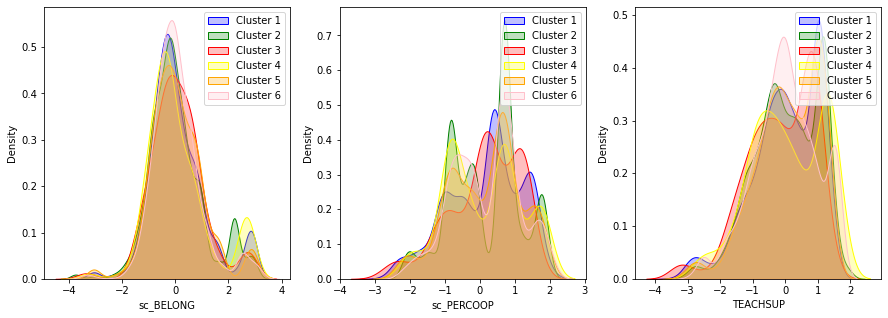

In [264]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(df_3.loc[df_3['CNT'].isin(clust_0)]['sc_BELONG'], ax=axs[0], color='blue', label='Cluster 1', fill=True)
sns.kdeplot(df_3.loc[df_3['CNT'].isin(clust_1)]['sc_BELONG'], ax=axs[0], color='green', label='Cluster 2', fill=True)
sns.kdeplot(df_3.loc[df_3['CNT'].isin(clust_2)]['sc_BELONG'], ax=axs[0], color='red', label='Cluster 3', fill=True)
sns.kdeplot(df_3.loc[df_3['CNT'].isin(clust_3)]['sc_BELONG'], ax=axs[0], color='yellow', label='Cluster 4', fill=True)
sns.kdeplot(df_3.loc[df_3['CNT'].isin(clust_4)]['sc_BELONG'], ax=axs[0], color='orange', label='Cluster 5', fill=True)
sns.kdeplot(df_3.loc[df_3['CNT'].isin(clust_5)]['sc_BELONG'], ax=axs[0], color='pink', label='Cluster 6', fill=True)

axs[0].set_xlabel('sc_BELONG')
axs[0].set_ylabel('Density')
axs[0].legend() 

sns.kdeplot(df_3.loc[df_3['CNT'].isin(clust_0)]['sc_PERCOOP'], ax=axs[1], color='blue', label='Cluster 1', fill=True)
sns.kdeplot(df_3.loc[df_3['CNT'].isin(clust_1)]['sc_PERCOOP'], ax=axs[1], color='green', label='Cluster 2', fill=True)
sns.kdeplot(df_3.loc[df_3['CNT'].isin(clust_2)]['sc_PERCOOP'], ax=axs[1], color='red', label='Cluster 3', fill=True)
sns.kdeplot(df_3.loc[df_3['CNT'].isin(clust_3)]['sc_PERCOOP'], ax=axs[1], color='yellow', label='Cluster 4', fill=True)
sns.kdeplot(df_3.loc[df_3['CNT'].isin(clust_4)]['sc_PERCOOP'], ax=axs[1], color='orange', label='Cluster 5', fill=True)
sns.kdeplot(df_3.loc[df_3['CNT'].isin(clust_5)]['sc_PERCOOP'], ax=axs[1], color='pink', label='Cluster 6', fill=True)
axs[1].set_xlabel('sc_PERCOOP')
axs[1].set_ylabel('Density')
axs[1].legend() 

sns.kdeplot(df_3.loc[df_3['CNT'].isin(clust_0)]['TEACHSUP'], ax=axs[2], color='blue', label='Cluster 1', fill=True)
sns.kdeplot(df_3.loc[df_3['CNT'].isin(clust_1)]['TEACHSUP'], ax=axs[2], color='green', label='Cluster 2', fill=True)
sns.kdeplot(df_3.loc[df_3['CNT'].isin(clust_2)]['TEACHSUP'], ax=axs[2], color='red', label='Cluster 3', fill=True)
sns.kdeplot(df_3.loc[df_3['CNT'].isin(clust_3)]['TEACHSUP'], ax=axs[2], color='yellow', label='Cluster 4', fill=True)
sns.kdeplot(df_3.loc[df_3['CNT'].isin(clust_4)]['TEACHSUP'], ax=axs[2], color='orange', label='Cluster 5', fill=True)
sns.kdeplot(df_3.loc[df_3['CNT'].isin(clust_5)]['TEACHSUP'], ax=axs[2], color='pink', label='Cluster 6', fill=True)
axs[2].set_xlabel('TEACHSUP')
axs[2].set_ylabel('Density')
axs[2].legend() 
plt.savefig('Distribuzione - cluster4.png', bbox_inches='tight')

In [267]:
counts_3 = Z_3.groupby('cluster').count()['Country']/len(Z_3['Country'])
counts_3

1.0

In [268]:
beta_0_3 = 0
for i in range(len(params['knots'][3])):
    beta_0_3 += counts_3[i]*params['knots'][3][i]
beta_0_3

-0.7059660212222344

In [269]:
Z_3_centred = Z_3.copy()
Z_3_centred['knots'] = Z_3['knots']-beta_0_3

<ipython-input-279-6db55e3b81d2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['Country'][Z['Country']=='KSV'] = '-99'
<ipython-input-279-6db55e3b81d2>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


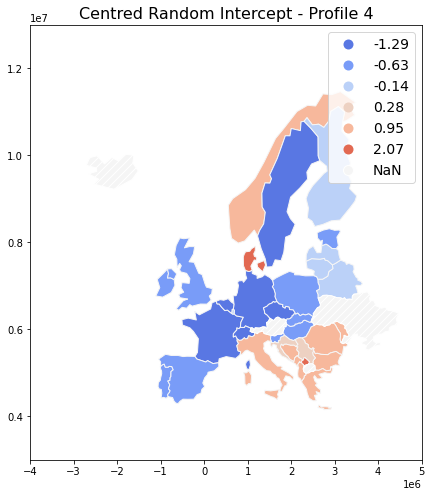

In [279]:
Q = pd.read_excel('iso_countries.xlsx')
Q = Q.rename(columns={'ISO': 'Country', 'Country': 'Name'})
Q = Q[Q['Country'].isin(eur)]
Z = Z_3_centred.merge(Q, on=['Country'])
Z['Country'][Z['Country']=='KSV'] = '-99'
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']
gdf = europe.merge(Z, how='left', left_on='iso_a3', right_on='Country')
xmin, xmax = -4000000, 5000000
ymin, ymax = 3000000, 13000000

# Filter out non-European states (Antarctica, Greenland, and French Southern and Antarctic Lands)
european_states =  ['ESP','ITA','LTU','KAZ','SVK','POL','PRT','DNK','EST','FRA','SWE','IRL','ALB','GBR',
       'CHE','GRC','MLT','LUX','ROU','AUT','BEL','BGR','DEU','FIN','HRV','HUN','ISL','NOR',
       'ROU','SVN','SRB','UKR','MKD','MDA','MNE','CZE','-99','BIH','LVA','BLR']
gdf_europe = gdf[gdf['iso_a3'].isin(european_states)]

# Reproject to pseudo Mercator (EPSG:3857)
gdf_europe = gdf_europe.to_crs('epsg:3857')

# Round the 'knots' column to two decimal places
gdf_europe['knots'] = gdf_europe['knots'].round(2)

# Create a new colormap
coolwarm_cmap = mpl.cm.get_cmap('coolwarm')
newcmp = ListedColormap(coolwarm_cmap(np.linspace(0.1, 0.95, 10)))

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 8))
gdf_europe.plot(column='knots',
                ax=ax,
                cmap=newcmp,
                vmin=0, vmax=6,
                categorical=True,
                legend=True,
                legend_kwds={'fontsize': 14},
                edgecolor='whitesmoke',
                missing_kwds={'edgecolor': 'white', 'facecolor': 'whitesmoke', "hatch": "///"})

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Set plot title
ax.set_title('Centred Random Intercept - Profile 4', fontsize=16)
plt.savefig('mappa_cluster4.png', bbox_inches='tight')
plt.show()

In [280]:
P_3 = Z_3.copy()
n_obs_prof_4 = np.sum(fitted_cluster==4)
P_3 = P_3.rename(columns={'knots': 'perc'})
for i in range(len(P_3['Country'])):
    P_3.loc[i, 'perc']  = len(df_3[df_3['CNT']==P_3['Country'][i]])/n_obs_prof_4*100

<ipython-input-282-18b4dea6db21>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['Country'][Z['Country']=='KSV'] = '-99'
<ipython-input-282-18b4dea6db21>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


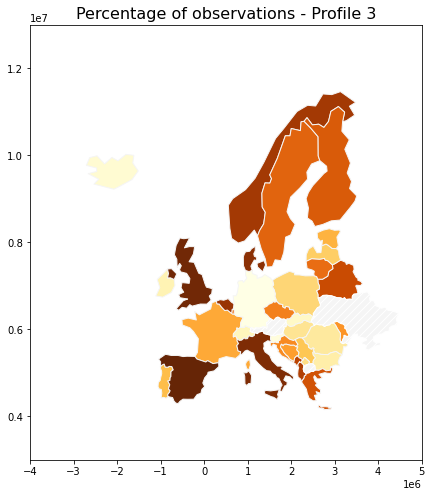

In [282]:
Q = pd.read_excel('iso_countries.xlsx')
Q = Q.rename(columns={'ISO': 'Country', 'Country': 'Names'})
Q = Q[Q['Country'].isin(eur)]
Z = P_2.merge(Q, on=['Country'])
Z['Country'][Z['Country']=='KSV'] = '-99'
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']
gdf = europe.merge(Z, how='left', left_on='iso_a3', right_on='Country')

xmin, xmax = -4000000, 5000000
ymin, ymax = 3000000, 13000000

# Filter out non-European states (Antarctica, Greenland, and French Southern and Antarctic Lands)
european_states =  ['ESP','ITA','LTU','KAZ','SVK','POL','PRT','DNK','EST','FRA','SWE','IRL','ALB','GBR',
       'CHE','GRC','MLT','LUX','ROU','AUT','BEL','BGR','DEU','FIN','HRV','HUN','ISL','NOR',
       'ROU','SVN','SRB','UKR','MKD','MDA','MNE','CZE','-99','BIH','LVA','BLR']
gdf_europe = gdf[gdf['iso_a3'].isin(european_states)]

# Reproject to pseudo Mercator (EPSG:3857)
gdf_europe = gdf_europe.to_crs('epsg:3857')

# Round the 'knots' column to two decimal places
gdf_europe['perc'] = gdf_europe['perc'].round(2)

light_yellow = '#FFFF99'  
dark_yellow = '#FFD700'    
num_colors = 256
colors = [light_yellow, dark_yellow]
new_cmap = LinearSegmentedColormap.from_list("Yellow", colors, N=num_colors)


# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 8))
gdf_europe.plot(column='perc',
                ax=ax,
                cmap='YlOrBr',
                categorical=True,
                edgecolor='whitesmoke',
                missing_kwds={'edgecolor': 'white', 'facecolor': 'whitesmoke', "hatch": "///"})

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Set plot title
ax.set_title('Percentage of observations - Profile 3', fontsize=16)
plt.savefig('mappa_perc_obs_cluster3.png', bbox_inches='tight')
plt.show()

#### Variance random effects

In [331]:
beta_sq_0_0 = 0
for i in range(len(params['knots'][0])):
    beta_sq_0_0 += counts_0[i]*np.square(params['knots'][0][i])

beta_sq_0_1 = 0
for i in range(len(params['knots'][1])):
    beta_sq_0_1 += counts_1[i]*np.square(params['knots'][1][i])

beta_sq_0_2 = 0
for i in range(len(params['knots'][2])):
    beta_sq_0_2 += counts_2[i]*np.square(params['knots'][2][i])

beta_sq_0_3 = 0
for i in range(len(params['knots'][3])):
    beta_sq_0_3 += counts_3[i]*np.square(params['knots'][3][i])

In [336]:
var_0 = beta_sq_0_0 - beta_0_0
var_1 = beta_sq_0_1 - beta_0_1
var_2 = beta_sq_0_2 - beta_0_2
var_3 = beta_sq_0_3 - beta_0_3

In [341]:
coeff_0 = var_0/(var_0 + np.square(math.pi)/3)
coeff_1 = var_1/(var_1 + np.square(math.pi)/3)
coeff_2 = var_2/(var_2 + np.square(math.pi)/3)
coeff_3 = var_3/(var_3 + np.square(math.pi)/3)

In [342]:
impact = pd.DataFrame({'Profile 1' : [coeff_0],
                    'Profile 2' : [coeff_1],
                    'Profile 3' : [coeff_2],
                     'Profile 4' : [coeff_3] })
impact.index = ['Impact of random effects']
impact

Profile 1  Profile 2  Profile 3  Profile 4
Impact of random effects    0.18791   0.032991   0.339236   0.389958

### Analysis of the varibale Iscedo in profiles and clusters

#### Histogram of the frequencies

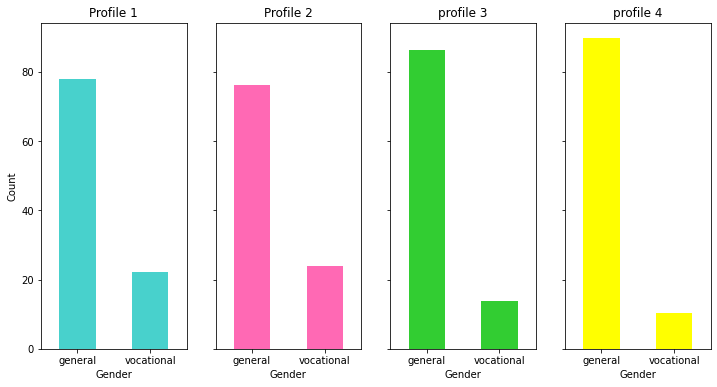

In [295]:
fig, axs = plt.subplots(1, 4, figsize=(12, 6), sharey=True)

iscedo_counts_1 = data_train[fitted_cluster == 1]['iscedo'].value_counts(normalize=True) * 100
iscedo_counts_1.plot.bar(rot=0, ax=axs[0], color='mediumturquoise')
axs[0].set_title('Profile 1')
axs[0].set_xlabel('Gender')
axs[0].set_ylabel('Count')

iscedo_counts_2 = data_train[fitted_cluster == 2]['iscedo'].value_counts(normalize=True) * 100
iscedo_counts_2.plot.bar(rot=0, ax=axs[1], color='hotpink')
axs[1].set_title('Profile 2')
axs[1].set_xlabel('Gender')
axs[1].set_ylabel('Count')

iscedo_counts_3 = data_train[fitted_cluster == 3]['iscedo'].value_counts(normalize=True) * 100
iscedo_counts_3.plot.bar(rot=0, ax=axs[2], color='limegreen')
axs[2].set_title('profile 3')
axs[2].set_xlabel('Gender')
axs[2].set_ylabel('Count')

iscedo_counts_4 = data_train[fitted_cluster == 4]['iscedo'].value_counts(normalize=True) * 100
iscedo_counts_4.plot.bar(rot=0, ax=axs[3], color='yellow')
axs[3].set_title('profile 4')
axs[3].set_xlabel('Gender')
axs[3].set_ylabel('Count')

plt.savefig('clustering-iscedo.png', bbox_inches='tight')

### Predictions

#### Training set

In [298]:
from scipy.stats import multinomial
def all_mydmultinom(V, prob, v):
      result = np.zeros(len(V))
      for j in range(len(V)):
        if V.iloc[j] == 1:
          esito = [V.iloc[j], 0]
        else:
          esito = [V.iloc[j], 1]
        result[j] = multinomial.pmf(esito, n=1, p=[prob[0], 1-prob[0]])
      return result

In [296]:
Z = Z_0.merge(Q, on=['Country'])
data_pred_1 = df.copy()
y = df['math_PISA_passed']
data_pred_1.loc[:,'Country'] = data_pred_1['CNT']
data_pred_1 = data_pred_1.merge(Z, on=['Country'])

Z = Z_1.merge(Q, on=['Country'])
data_pred_2 = df.copy()
y = df['math_PISA_passed']
data_pred_2.loc[:,'Country'] = data_pred_2['CNT']
data_pred_2 = data_pred_2.merge(Z, on=['Country'])

Z = Z_2.merge(Q, on=['Country'])
data_pred_3 = df.copy()
y = df['math_PISA_passed']
data_pred_3.loc[:,'Country'] = data_pred_3['CNT']
data_pred_3 = data_pred_3.merge(Z, on=['Country'])

Z_3_complete = Z_3.copy()
nuova_riga = {'Country': 'ISL', 'cluster': np.nan, 'knots': beta_0_3}
Z_3_complete = Z_3_complete.append(nuova_riga, ignore_index=True)
Z = Z_3_complete.merge(Q, on=['Country'])
data_pred_4 = df.copy()
y = df['math_PISA_passed']
data_pred_4.loc[:,'Country'] = data_pred_4['CNT']
data_pred_4 = data_pred_4.merge(Z, on=['Country'])

In [303]:
w = []
for c in range(4):
    w.append(np.sum(fitted_cluster==(c+1))/len(df['y']))
weight = []
weight.append(w[0]*all_mydmultinom(data_pred_1['gender'], params['lam'][0],1)*multivariate_normal.pdf(data_pred_1[['cultural_possession','ESCS']], mean=params['mu'][0], cov=params['sigma'][0], allow_singular=True))
weight.append(w[1]*all_mydmultinom(data_pred_2['gender'], params['lam'][0],1)*multivariate_normal.pdf(data_pred_2[['cultural_possession','ESCS']], mean=params['mu'][1], cov=params['sigma'][1], allow_singular=True))
weight.append(w[2]*all_mydmultinom(data_pred_3['gender'], params['lam'][0],1)*multivariate_normal.pdf(data_pred_3[['cultural_possession','ESCS']], mean=params['mu'][2], cov=params['sigma'][2], allow_singular=True))
weight.append(w[3]*all_mydmultinom(data_pred_4['gender'], params['lam'][0],1)*multivariate_normal.pdf(data_pred_4[['cultural_possession','ESCS']], mean=params['mu'][3], cov=params['sigma'][3], allow_singular=True))


In [304]:
predicted_probs = []
for i in range(len(df['y'])):
   sum_weight = weight[0][i] + weight[1][i] + weight[2][i] + weight[3][i]
   val_1 = np.array( data_pred_1['knots'][i] + params['fix_param'][0][0] * data_pred_1['sc_BELONG'][i] + params['fix_param'][0][1] * data_pred_1['sc_PERCOOP'][i] +
              params['fix_param'][0][2] * data_pred_1['TEACHSUP'][i])
   pred_1 = weight[0][i]/sum_weight*np.array(expit(val_1))
   val_2 = np.array( data_pred_2['knots'][i] + params['fix_param'][1][0] * data_pred_2['sc_BELONG'][i] + params['fix_param'][1][1] * data_pred_2['sc_PERCOOP'][i] +
              params['fix_param'][1][2] * data_pred_2['TEACHSUP'][i])
   pred_2 = weight[1][i]/sum_weight*np.array(expit(val_2))
   val_3 = np.array( data_pred_3['knots'][i] + params['fix_param'][2][0] * data_pred_3['sc_BELONG'][i] + params['fix_param'][2][1] * data_pred_3['sc_PERCOOP'][i] +
              params['fix_param'][2][2] * data_pred_3['TEACHSUP'][i])
   pred_3 = weight[2][i]/sum_weight*np.array(expit(val_3))
   val_4 = np.array( data_pred_4['knots'][i] + params['fix_param'][3][0] * data_pred_4['sc_BELONG'][i] + params['fix_param'][3][1] * data_pred_4['sc_PERCOOP'][i] +
              params['fix_param'][3][2] * data_pred_4['TEACHSUP'][i])
   pred_4 = weight[3][i]/sum_weight*np.array(expit(val_4))
   predicted_probs.append(pred_1+pred_2+pred_3+pred_4)

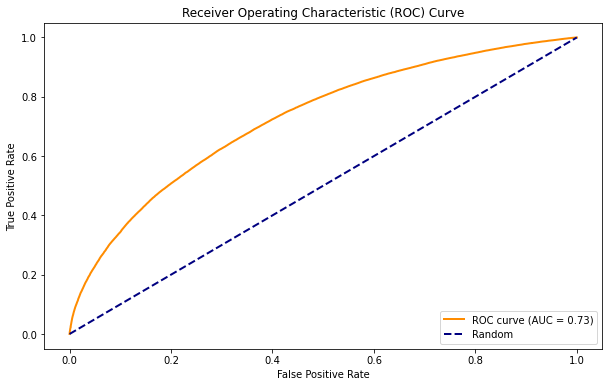

In [305]:
fpr, tpr, thresholds = roc_curve(data_pred_1['y'], predicted_probs)

# Compute Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('ROC_train.png', bbox_inches='tight')
plt.show()

In [306]:
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]
fitted_values = (np.hstack((predicted_probs)) >= optimal_threshold).astype(int)
y_per_prev = np.hstack((data_pred_1['y']))
perc_new = np.count_nonzero(fitted_values == y_per_prev)/len(y_per_prev)
perc_new

0.6640441887528479

### Comparing the performance with GLM and GLMER

In [112]:
data_glm = sm.add_constant(data_train[['sc_BELONG','sc_PERCOOP','TEACHSUP','cultural_possession','gender','ESCS']])
glm_model = sm.GLM(data_train['y'], data_glm, family=sm.families.Binomial())
glm_result = glm_model.fit()
fpr, tpr, thresholds_glm = roc_curve(data_train['y'], glm_result.fittedvalues)
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold_glm = thresholds_glm[optimal_threshold_index]
fitted_glm = (glm_result.fittedvalues >= optimal_threshold_glm).astype(int)

perc_GLM = np.count_nonzero(fitted_glm == data_train['y'])/len(data_train['y'])
perc_GLM

0.6236634923756919

In [149]:
file_path = 'pred_GLMM.csv'
pred_GLMER = pd.read_csv(file_path)
fpr, tpr, thresholds_glmer = roc_curve(data_train['y'], pred_GLMER['x'])
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold_glmer = thresholds_glmer[optimal_threshold_index]
fitted_glmer = ( list(pred_GLMER['x'])>= optimal_threshold_glmer).astype(int)

perc_GLMER = np.count_nonzero(fitted_glmer == data_train['y'])/len(data_train['y'])
perc_GLMER

0.6733922298164812

In [150]:
perform = pd.DataFrame({'New Model' : [perc_new],
                    'GLM' : [perc_GLM],
                    'GLMER' : [perc_GLMER]})
perform.index = ['Accuracy on training set']
perform

New Model       GLM     GLMER
Accuracy on training set   0.664044  0.623663  0.673392

#### Test set

In [310]:
Z = Z_0.merge(Q, on=['Country'])
data_pred_1_test = data_test.copy()
y = data_test['math_PISA_passed']
data_pred_1_test.loc[:,'Country'] = data_pred_1_test['CNT']
data_pred_1_test = data_pred_1_test.merge(Z, on=['Country'])

Z = Z_1.merge(Q, on=['Country'])
data_pred_2_test = data_test.copy()
y = data_test['math_PISA_passed']
data_pred_2_test.loc[:,'Country'] = data_pred_2_test['CNT']
data_pred_2_test = data_pred_2_test.merge(Z, on=['Country'])

Z = Z_2.merge(Q, on=['Country'])
data_pred_3_test = data_test.copy()
y = data_test['math_PISA_passed']
data_pred_3_test.loc[:,'Country'] = data_pred_3_test['CNT']
data_pred_3_test = data_pred_3_test.merge(Z, on=['Country'])

Z_3_complete = Z_3.copy()
nuova_riga = {'Country': 'ISL', 'cluster': np.nan, 'knots': beta_0_3}
Z_3_complete = Z_3_complete.append(nuova_riga, ignore_index=True)
Z = Z_3_complete.merge(Q, on=['Country'])
data_pred_4_test = data_test.copy()
y = data_test['math_PISA_passed']
data_pred_4_test.loc[:,'Country'] = data_pred_4_test['CNT']
data_pred_4_test = data_pred_4_test.merge(Z, on=['Country'])

In [311]:
weight = []
weight.append(w[0]*all_mydmultinom(data_pred_1_test['gender'], params['lam'][0],1)*multivariate_normal.pdf(data_pred_1_test[['cultural_possession','ESCS']], mean=params['mu'][0], cov=params['sigma'][0], allow_singular=True))
weight.append(w[1]*all_mydmultinom(data_pred_2_test['gender'], params['lam'][1],1)*multivariate_normal.pdf(data_pred_2_test[['cultural_possession','ESCS']], mean=params['mu'][1], cov=params['sigma'][1], allow_singular=True))
weight.append(w[2]*all_mydmultinom(data_pred_3_test['gender'], params['lam'][2],1)*multivariate_normal.pdf(data_pred_3_test[['cultural_possession','ESCS']], mean=params['mu'][2], cov=params['sigma'][2], allow_singular=True))
weight.append(w[3]*all_mydmultinom(data_pred_4_test['gender'], params['lam'][3],1)*multivariate_normal.pdf(data_pred_4_test[['cultural_possession','ESCS']], mean=params['mu'][3], cov=params['sigma'][3], allow_singular=True))


In [312]:
predicted_probs_test = []
for i in range(len(data_test['y'])):
   sum_weight = weight[0][i] + weight[1][i] + weight[2][i] + weight[3][i]
   val_1 = np.array( data_pred_1_test['knots'][i] + params['fix_param'][0][0] * data_pred_1_test['sc_BELONG'][i] + params['fix_param'][0][1] * data_pred_1_test['sc_PERCOOP'][i] +
              params['fix_param'][0][2] * data_pred_1_test['TEACHSUP'][i])
   pred_1 = weight[0][i]/sum_weight*np.array(expit(val_1))
   val_2 = np.array( data_pred_2_test['knots'][i] + params['fix_param'][1][0] * data_pred_2_test['sc_BELONG'][i] + params['fix_param'][1][1] * data_pred_2_test['sc_PERCOOP'][i] +
              params['fix_param'][1][2] * data_pred_2_test['TEACHSUP'][i])
   pred_2 = weight[1][i]/sum_weight*np.array(expit(val_2))
   val_3 = np.array( data_pred_3_test['knots'][i] + params['fix_param'][2][0] * data_pred_3_test['sc_BELONG'][i] + params['fix_param'][2][1] * data_pred_3_test['sc_PERCOOP'][i] +
              params['fix_param'][2][2] * data_pred_3_test['TEACHSUP'][i])
   pred_3 = weight[2][i]/sum_weight*np.array(expit(val_3))
   val_4 = np.array( data_pred_4_test['knots'][i] + params['fix_param'][3][0] * data_pred_4_test['sc_BELONG'][i] + params['fix_param'][3][1] * data_pred_4_test['sc_PERCOOP'][i] +
              params['fix_param'][3][2] * data_pred_4_test['TEACHSUP'][i])
   pred_4 = weight[3][i]/sum_weight*np.array(expit(val_4))
   predicted_probs_test.append(pred_1+pred_2+pred_3+pred_4)

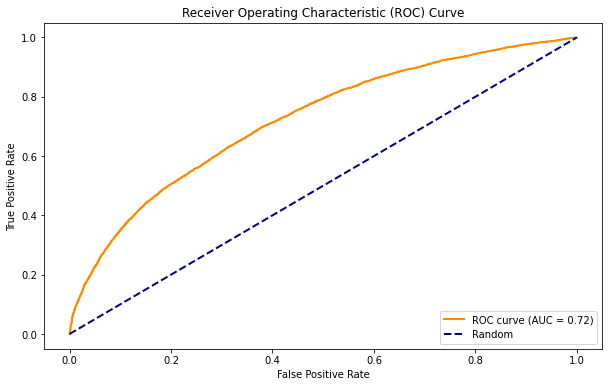

In [313]:
fpr, tpr, thresholds = roc_curve(data_pred_1_test['y'], predicted_probs_test)

# Compute Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('ROC_test.png', bbox_inches='tight')
plt.show()

In [314]:
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]
fitted_values = (predicted_probs_test >= optimal_threshold).astype(int)
y_per_prev = data_pred_1_test['y']
perc_new_test = np.count_nonzero(fitted_values == y_per_prev)/len(y_per_prev)
perc_new_test

0.658668502310945

In [143]:
data_test_glm = sm.add_constant(data_test[['sc_BELONG','sc_PERCOOP','TEACHSUP','cultural_possession','gender','ESCS']])
glm_pred = glm_result.predict(data_test_glm)
fpr, tpr, thresholds_glm = roc_curve(data_test['y'], glm_pred)
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold_glm = thresholds_glm[optimal_threshold_index]
fitted_glm = (glm_pred >= optimal_threshold_glm).astype(int)

perc_GLM_test = np.count_nonzero(fitted_glm == data_test['y'])/len(data_test['y'])
perc_GLM_test

0.6257252433867637

In [147]:
file_path = 'pred_GLMM_test.csv'
pred_GLMER_test = pd.read_csv(file_path)
fpr, tpr, thresholds_glmer = roc_curve(data_test['y'], pred_GLMER_test['x'])
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold_glmer = thresholds_glmer[optimal_threshold_index]
fitted_glmer = (list(pred_GLMER_test['x']) >= optimal_threshold_glmer).astype(int)

perc_GLMER_test = np.count_nonzero(fitted_glmer == data_test['y'])/len(data_test['y'])
perc_GLMER_test

0.6720424820532992

In [148]:
perform_test = pd.DataFrame({'New Model' : [perc_new_test],
                    'GLM' : [perc_GLM_test],
                    'GLMER' : [perc_GLMER_test]})
perform_test.index = ['Accuracy on test set']
perform_test

New Model       GLM     GLMER
Accuracy on test set   0.658669  0.625725  0.672042

### Fix parameters

In [315]:
from scipy.stats import t

def calculate_p_value(beta, std_error, dof):
    # Calcola il valore t
    t_value = beta / std_error
    
    # Calcola il p-value
    p_value = 2 * (1 - t.cdf(abs(t_value), df=dof))
    
    return p_value

In [316]:
p_values = []
for i in range(4):
    p_value = []
    for j in range(len(params['fix_param'][i])):
        p_value.append(calculate_p_value(params['fix_param'][i][j], np.sqrt(1 / params['hessian_fix'][i][j]), len(df['y'])-7))
    p_values.append(p_value)

In [317]:
beta_0 = pd.DataFrame({'Estimation' : [params['fix_param'][0][0],params['fix_param'][0][1],params['fix_param'][0][2]],
                    'std' : [np.sqrt(1 / params['hessian_fix'][0][0]), np.sqrt(1 / params['hessian_fix'][0][1]), np.sqrt(1 / params['hessian_fix'][0][2])],
                    'p-value' : [p_values[0][0],p_values[0][1],p_values[0][2]],
                      '' : ['***','***','***']})
beta_0.index = ['sc_BELONG','sc_PERCOOP', 'TEACHSUP']
beta_0

Estimation       std   p-value     
sc_BELONG    -0.089727  0.019221  0.000003  ***
sc_PERCOOP   -0.187478  0.018933  0.000000  ***
TEACHSUP      0.085582  0.018236  0.000003  ***

In [318]:
beta_1 = pd.DataFrame({'Estimation' : [params['fix_param'][1][0],params['fix_param'][1][1],params['fix_param'][1][2]],
                    'std' : [np.sqrt(1 / params['hessian_fix'][1][0]), np.sqrt(1 / params['hessian_fix'][1][1]), np.sqrt(1 / params['hessian_fix'][1][2])],
                    'p-value' : [p_values[1][0],p_values[1][1],p_values[1][2]],
                      '' : ['***','***','***']})
beta_1.index = ['sc_BELONG','sc_PERCOOP', 'TEACHSUP']
beta_1

Estimation       std   p-value     
sc_BELONG    -0.066372  0.007778  0.000000  ***
sc_PERCOOP   -0.152625  0.007756  0.000000  ***
TEACHSUP      0.037192  0.007804  0.000002  ***

In [321]:
beta_3 = pd.DataFrame({'Estimation' : [params['fix_param'][2][0],params['fix_param'][2][1],params['fix_param'][2][2]],
                    'std' : [np.sqrt(1 / params['hessian_fix'][2][0]), np.sqrt(1 / params['hessian_fix'][2][1]), np.sqrt(1 / params['hessian_fix'][2][2])],
                    'p-value' : [p_values[2][0],p_values[2][1],p_values[2][2]],
                      '' : ['***','***','***']})
beta_3.index = ['sc_BELONG','sc_PERCOOP', 'TEACHSUP']
beta_3

Estimation       std       p-value     
sc_BELONG    -0.063117  0.008080  5.551115e-15  ***
sc_PERCOOP   -0.206549  0.008347  0.000000e+00  ***
TEACHSUP      0.027535  0.008343  9.659325e-04  ***

In [322]:
beta_4 = pd.DataFrame({'Estimation' : [params['fix_param'][3][0],params['fix_param'][3][1],params['fix_param'][3][2]],
                    'std' : [np.sqrt(1 / params['hessian_fix'][3][0]), np.sqrt(1 / params['hessian_fix'][3][1]), np.sqrt(1 / params['hessian_fix'][3][2])],
                    'p-value' : [p_values[3][0],p_values[3][1],p_values[3][2]],
                      '' : ['***','***','']})
beta_4.index = ['sc_BELONG','sc_PERCOOP', 'TEACHSUP']
beta_4

Estimation       std   p-value     
sc_BELONG    -0.072114  0.020607  0.000466  ***
sc_PERCOOP   -0.190863  0.021004  0.000000  ***
TEACHSUP      0.014896  0.021346  0.485280

### Confronto GLM e GLMER usando tutte le variabili

In [354]:
data_train_ridotto = data_train.reset_index()[0:10000]

In [355]:
len(data_train_ridotto['CNT'].unique())

36

In [357]:
from algo_full import Algo_full 

In [ ]:
params_new, log_l_new, z_new, iter_new = Algo_full(data = data_train_ridotto, y = data_train_ridotto['y'], C = 4,
                             U = data_train_ridotto[['cultural_possession', 'ESCS']], V = data_train_ridotto['gender'], num_fix = 6,
                             num_group = len(data_train_ridotto['CNT'].value_counts()), alpha = 0.01, mod = 'B',
                             num_obs_groups = data_train_ridotto['CNT'].value_counts() ,
                             group_name = 'CNT', name_fix = ['sc_BELONG','sc_PERCOOP', 'TEACHSUP','cultural_possession', 'ESCS','gender'],
                             max_iter=15, perc_collasso=0.0005, y_name='y')

9.605277238262566e-26
1.100319034074663e-24
2.3270531292176194e-24
2.403396861269884e-19
2.4033968612698857e-19
6.504360701071435e-12
6.5044686719274615e-12
1.1570354898732661e-09
1.1570354898732661e-09
1.1570354898732661e-09
1.157035489883589e-09
1.1570354898844103e-09
1.1570354899852602e-09
1.1570354899852602e-09
1.1570354899852602e-09
1.1570354899852685e-09
1.1570354899852728e-09
1.1570772974236753e-09
1.1571209401422146e-09
1.1571209401422146e-09
1.1571209401422146e-09
1.157172668047037e-09
1.1571726680471355e-09
1.1571726680604637e-09
1.1571726680612513e-09
1.1571726680612513e-09
1.1577063789451316e-09
1.1577063789451316e-09
1.1577063789451492e-09
1.1577063789453591e-09
1.1577063789804177e-09
1.1577064040584645e-09
1.1577064040584645e-09
1.1646338780994207e-09
1.1649897841097956e-09
1.1649897985176298e-09
1.1134982036709128e-25
9.404713065339159e-24
1.1288802193529343e-23
2.5508953435096176e-19
2.5508953435096176e-19
9.830096523473595e-12
9.831560099364209e-12
6.83138528859931e-10

[ 1.30626  1.52198  1.32213  2.24054  1.29867  2.23578  1.29284  0.51555
  1.27953  1.35282  0.53763 -0.32145  1.29683  1.30255 -0.0561   1.30087
  0.51635 -0.73599  0.03514  0.51881  1.27413  1.36959  1.2973   1.30402
  1.43528  2.24038  1.31927  2.23884 -0.36251  2.24076  1.30216  1.32785
  1.28496]
D_triu
[[    nan 0.21572 0.01587 ... 0.0041  0.02159 0.0213 ]
 [    nan     nan 0.19985 ... 0.21982 0.19413 0.23702]
 [    nan     nan     nan ... 0.01997 0.00572 0.03717]
 ...
 [    nan     nan     nan ...     nan 0.02569 0.0172 ]
 [    nan     nan     nan ...     nan     nan 0.04289]
 [    nan     nan     nan ...     nan     nan     nan]]
1.2002855258082483e-25
2.009411510012138e-23
2.2679496059882582e-23
2.15086905335038e-19
2.1508690533503806e-19
8.838156355415392e-12
8.848459343027586e-12
6.056348867291646e-10
6.056348867291646e-10
6.056348867291646e-10
6.056348869293205e-10
6.056348869299785e-10
6.056348869669112e-10
6.056348869669112e-10
6.056348869669112e-10
6.056348869669263e-10


6.12827630431934e-10
6.128276306361698e-10
6.128276306368205e-10
6.12827630673825e-10
6.12827630673825e-10
6.12827630673825e-10
6.128276306738401e-10
6.128276306738435e-10
6.128821429172406e-10
6.130271895742676e-10
6.130271895742676e-10
6.130271895742676e-10
6.131187468276802e-10
6.131187468277222e-10
6.131187468334587e-10
6.131187468340528e-10
6.131187468340528e-10
6.139694334126266e-10
6.139694334126266e-10
6.139694334126325e-10
6.139694334159653e-10
6.139694334405498e-10
6.139694725382388e-10
6.139694725382388e-10
6.227508192271757e-10
6.239430327982357e-10
6.239430495811776e-10
[ 1.30473  1.42325  1.31157  2.24179  1.30146  2.24152  1.29897  0.51757
  1.29346  1.32538  0.52071 -0.32706  1.3007   1.30302 -0.10201  1.30239
  0.51767 -0.81825 -0.02883  0.51805  1.2912   1.33325  1.30092  1.30377
  1.36718  1.31034  2.24168 -0.33865  1.31408  1.29572]
D_triu
[[        nan 1.18515e-01 6.83837e-03 9.37057e-01 3.26683e-03 9.36787e-01
  5.75841e-03 7.87165e-01 1.12741e-02 2.06519e-02 7.84

6.162795795372289e-10
6.162795797380272e-10
6.162795797386847e-10
6.162795797754126e-10
6.162795797754126e-10
6.162795797754126e-10
6.162795797754276e-10
6.16279579775431e-10
6.163337323088929e-10
6.164759013320124e-10
6.164759013320124e-10
6.164759013320124e-10
6.165675056909773e-10
6.165675056910197e-10
6.165675056967953e-10
6.165675056973979e-10
6.165675056973979e-10
6.174138777371989e-10
6.174138777371989e-10
6.17413877737205e-10
6.174138777404859e-10
6.174138777654084e-10
6.174139169691107e-10
6.174139169691107e-10
6.261492695506442e-10
6.273207525726861e-10
6.27320769148027e-10
[ 1.30422  1.39795  1.30939  2.24162  1.30178  2.24152  1.29992  0.51718
  1.29573  1.31988  0.51883 -0.32936  1.30121  1.30296 -0.11692  1.30246
 -0.83447 -0.04602  0.51739  1.2941   1.32596  1.30136  1.30351  1.35237
  1.30848  2.24158 -0.33726  1.31132  1.29749]
D_triu
[[        nan 9.37312e-02 5.17078e-03 9.37402e-01 2.43951e-03 9.37296e-01
  4.29750e-03 7.87043e-01 8.49103e-03 1.56612e-02 7.85388e-01 

6.190928237435224e-10
6.19092823940081e-10
6.190928239407463e-10
6.190928239771896e-10
6.190928239771896e-10
6.190928239771896e-10
6.190928239772045e-10
6.190928239772081e-10
6.191468536867545e-10
6.192864933719905e-10
6.192864933719905e-10
6.192864933719905e-10
6.193781296086639e-10
6.193781296087062e-10
6.193781296144982e-10
6.193781296151102e-10
6.193781296151102e-10
6.202229808227261e-10
6.202229808227261e-10
6.202229808227323e-10
6.202229808259497e-10
6.202229808511984e-10
6.202230201227375e-10
6.202230201227375e-10
6.289446475329429e-10
6.30097579457985e-10
6.300975959268962e-10
[ 1.30371  1.37693  1.3076   2.24129  1.30191  2.24124  1.3005   0.51657
  1.29731  1.31557  0.51747 -0.33116  1.30146  1.30277 -0.13123  1.30239
 -0.84727 -0.06117  0.51668  1.29612  1.3202   1.30155  1.30319  1.34061
  1.30695 -0.33666  1.30908  1.29863]
D_triu
[[        nan 7.32207e-02 3.89031e-03 9.37578e-01 1.80303e-03 9.37532e-01
  3.21695e-03 7.87139e-01 6.40027e-03 1.18534e-02 7.86246e-01 1.63487e

6.21348074605026e-10
6.213480747974498e-10
6.213480747981226e-10
6.213480748342807e-10
6.213480748342807e-10
6.213480748342807e-10
6.213480748342956e-10
6.213480748342991e-10
6.214020899480918e-10
6.215396671895931e-10
6.215396671895931e-10
6.215396671895931e-10
6.216313270655742e-10
6.216313270656166e-10
6.216313270714125e-10
6.216313270720329e-10
6.216313270720329e-10
6.224759194492506e-10
6.224759194492506e-10
6.224759194492566e-10
6.224759194524124e-10
6.22475919477958e-10
6.224759588064163e-10
6.224759588064163e-10
6.311968253655784e-10
6.323343621125928e-10
6.323343785343951e-10
[ 1.30339  1.36006  1.30633  2.24107  1.30204  1.30094  0.51612  1.29858
  1.31235  0.51656 -0.33233  1.30172  1.3027  -0.14488  1.30239 -0.85711
 -0.07423  0.51618  1.2977   1.31588  1.30175  1.303    1.33152  1.30586
 -0.3362   1.30742  1.29958]
D_triu
[[        nan 5.66651e-02 2.93173e-03 9.37673e-01 1.35764e-03 2.45423e-03
  7.87275e-01 4.81523e-03 8.96013e-03 7.86838e-01 1.63572e+00 1.67619e-03
  6.9

6.23045368939107e-10
6.23045369127926e-10
6.230453691286056e-10
6.230453691644738e-10
6.230453691644738e-10
6.230453691644738e-10
6.230453691644887e-10
6.230453691644924e-10
6.230994333063817e-10
6.232353837650162e-10
6.232353837650162e-10
6.232353837650162e-10
6.233270517875741e-10
6.233270517876163e-10
6.233270517934112e-10
6.233270517940385e-10
6.233270517940385e-10
6.241722595781208e-10
6.241722595781208e-10
6.24172259578127e-10
6.24172259581228e-10
6.241722596070359e-10
6.241722990045325e-10
6.241722990045325e-10
6.328997943539866e-10
6.340251701299847e-10
6.340251865345914e-10
[ 1.30308  1.34665  1.3053   2.24085  1.30204  1.30119  0.51561  1.29947
  1.30986  0.51585 -0.3331   1.3018   1.30257 -0.15819  1.30233 -0.86465
 -0.08573  0.51562  1.29878  1.31254  1.30275  1.32443  1.30491 -0.33587
  1.30608  1.30022]
D_triu
[[        nan 4.35700e-02 2.22944e-03 9.37773e-01 1.03948e-03 1.88201e-03
  7.87461e-01 3.60944e-03 6.77955e-03 7.87226e-01 1.63618e+00 1.27620e-03
  5.01305e-04 1.

6.243498659128175e-10
6.243498660986723e-10
6.243498660993577e-10
6.243498661349825e-10
6.243498661349825e-10
6.243498661349825e-10
6.243498661349972e-10
6.243498661350008e-10
6.244039985478447e-10
6.245386782151884e-10
6.245386782151884e-10
6.245386782151884e-10
6.246303658560883e-10
6.246303658561304e-10
6.246303658619192e-10
6.246303658625523e-10
6.246303658625523e-10
6.25476493561502e-10
6.25476493561502e-10
6.254764935615081e-10
6.254764935645638e-10
6.254764935905825e-10
6.25476533023654e-10
6.25476533023654e-10
6.342137417792914e-10
6.353296834635368e-10
6.353296998702098e-10
[ 1.30282  1.33619  1.30454  2.24068  1.30204  1.30145  0.51516  1.3001
  1.30794  0.5153  -0.3335   1.30186  1.30245 -0.17129  1.30226 -0.87031
 -0.09585  1.2996   1.30998  1.30262  1.31906  1.3042  -0.33548  1.30512
  1.30066]
D_triu
[[        nan 3.33701e-02 1.71917e-03 9.37863e-01 7.84997e-04 1.37342e-03
  7.87659e-01 2.72052e-03 5.11549e-03 7.87525e-01 1.63632e+00 9.58164e-04
  3.74015e-04 1.47411e+00 

6.251898146380924e-10
6.251898148215669e-10
6.251898148222572e-10
6.251898148576704e-10
6.251898148576704e-10
6.251898148576704e-10
6.251898148576851e-10
6.251898148576888e-10
6.252440348687266e-10
6.253777547373668e-10
6.253777547373668e-10
6.253777547373668e-10
6.25469447076458e-10
6.254694470764997e-10
6.254694470822796e-10
6.254694470829176e-10
6.254694470829176e-10
6.263166451171723e-10
6.263166451171723e-10
6.263166451171785e-10
6.26316645120198e-10
6.26316645146381e-10
6.263166845911807e-10
6.263166845911807e-10
6.350672666413942e-10
6.36175792794042e-10
6.361758092100452e-10
[ 1.30269  1.3281   1.30397  2.24052  1.3021   1.30164  0.51481  1.30061
  1.30653 -0.33356  1.30193  1.30238 -0.18441  1.30226 -0.87456 -0.10492
  1.30024  1.30806  1.30249  1.31494  1.3037  -0.33496  1.30442  1.30104]
D_triu
[[        nan 2.54075e-02 1.27314e-03 9.37826e-01 5.94202e-04 1.05556e-03
  7.87879e-01 2.08547e-03 3.83777e-03 1.63625e+00 7.67387e-04 3.10385e-04
  1.48711e+00 4.29400e-04 2.17725e+

6.261579319519915e-10
6.261579319577624e-10
6.261579319584044e-10
6.261579319584044e-10
6.270061448277128e-10
6.270061448277128e-10
6.27006144827719e-10
6.270061448307106e-10
6.270061448570384e-10
6.270061843372682e-10
6.270061843372682e-10
6.357675568966762e-10
6.368707219184169e-10
6.368707383487662e-10
[ 1.30257  1.32188  1.30352  2.24041  1.3021   1.30177  0.51451  1.30099
  1.30545 -0.33336  1.30199  1.30235 -0.19767  1.30226 -0.87772 -0.11312
  1.30074  1.30659  1.31186  1.30331 -0.33437  1.30385  1.3013 ]
D_triu
[[        nan 1.93095e-02 9.54677e-04 9.37844e-01 4.66992e-04 8.01246e-04
  7.88054e-01 1.57724e-03 2.88051e-03 1.63593e+00 5.76609e-04 2.11906e-04
  1.50024e+00 3.02190e-04 2.18028e+00 1.41569e+00 1.82275e-03 4.02160e-03
  9.29316e-03 7.46736e-04 1.63693e+00 1.28338e-03 1.27042e-03]
 [        nan         nan 1.83548e-02 9.18534e-01 1.97765e-02 2.01108e-02
  8.07363e-01 2.08867e-02 1.64290e-02 1.65524e+00 1.98861e-02 1.95214e-02
  1.51955e+00 1.96117e-02 2.19959e+00 1.43

6.265884359410947e-10
6.267203836996202e-10
6.267203836996202e-10
6.267203836996202e-10
6.268129847183354e-10
6.268129847183767e-10
6.268129847241272e-10
6.268129847247754e-10
6.268129847247754e-10
6.276630512561882e-10
6.276630512561882e-10
6.276630512561944e-10
6.276630512591472e-10
6.276630512856792e-10
6.276630909718406e-10
6.276630909718406e-10
6.364448411637275e-10
6.375404722045318e-10
6.375404886571926e-10
[ 1.30282  2.2364   1.30252  1.30234  0.51441  1.30194 -0.33239  1.30271
 -0.22439 -0.88175 -0.12772  1.30176 -0.333    1.30212]
D_triu
[[        nan 9.33581e-01 2.96368e-04 4.83619e-04 7.88409e-01 8.78750e-04
  1.63521e+00 1.08792e-04 1.52721e+00 2.18457e+00 1.43054e+00 1.06094e-03
  1.63582e+00 6.98831e-04]
 [        nan         nan 9.33878e-01 9.34065e-01 1.72199e+00 9.34460e-01
  2.56879e+00 9.33690e-01 2.46079e+00 3.11815e+00 2.36412e+00 9.34642e-01
  2.56940e+00 9.34280e-01]
 [        nan         nan         nan 1.87251e-04 7.88113e-01 5.82382e-04
  1.63491e+00 1.87575e

6.271507777337349e-10
6.271507777343881e-10
6.271507777343882e-10
6.280026020600469e-10
6.280026020600469e-10
6.28002602060053e-10
6.280026020629765e-10
6.280026020896885e-10
6.280026416415316e-10
6.280026416415316e-10
6.368037749595063e-10
6.378937102665194e-10
6.378937267459946e-10
[ 1.30231  2.2399   1.30215  0.51366  1.30195 -0.33032 -0.26217 -0.88451
 -0.14718 -0.33066  1.30212]
D_triu
[[        nan 9.37588e-01 1.63382e-04 7.88652e-01 3.61805e-04 1.63262e+00
  1.56448e+00 2.18682e+00 1.44949e+00 1.63297e+00 1.87835e-04]
 [        nan         nan 9.37752e-01 1.72624e+00 9.37950e-01 2.57021e+00
  2.50207e+00 3.12440e+00 2.38708e+00 2.57056e+00 9.37776e-01]
 [        nan         nan         nan 7.88488e-01 1.98423e-04 1.63246e+00
  1.56432e+00 2.18665e+00 1.44933e+00 1.63281e+00 2.44531e-05]
 [        nan         nan         nan         nan 7.88290e-01 8.43973e-01
  7.75829e-01 1.39816e+00 6.60841e-01 8.44319e-01 7.88464e-01]
 [        nan         nan         nan         nan         

[ 1.30224  2.24022  0.51336 -0.32789 -0.29755 -0.88572 -0.17435]
D_triu
[[    nan 0.93799 0.78888 1.63013 1.59979 2.18796 1.47659]
 [    nan     nan 1.72687 2.56811 2.53778 3.12594 2.41458]
 [    nan     nan     nan 0.84124 0.81091 1.39907 0.68771]
 [    nan     nan     nan     nan 0.03033 0.55783 0.15353]
 [    nan     nan     nan     nan     nan 0.58816 0.1232 ]
 [    nan     nan     nan     nan     nan     nan 0.71136]
 [    nan     nan     nan     nan     nan     nan     nan]]
1.2212523892895691e-25
1.6519896169833453e-23
1.9058755162946417e-23
2.1471664549173906e-19
2.147166454917391e-19
8.169293208055083e-12
8.187217039290479e-12
6.26980936779626e-10
6.269809367796261e-10
6.269809367796261e-10
6.269809369557558e-10
6.269809369564644e-10
6.269809369907454e-10
6.269809369907454e-10
6.269809369907454e-10
6.269809369907601e-10
6.26980936990764e-10
6.270355860037205e-10
6.27166395357522e-10
6.27166395357522e-10
6.27166395357522e-10
6.272580748438114e-10
6.272580748438523e-10
6.2725807

[ 1.45026  0.52003 -0.32493 -0.88754]
D_triu
[[    nan 0.93023 1.7752  2.3378 ]
 [    nan     nan 0.84497 1.40757]
 [    nan     nan     nan 0.5626 ]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.93023 1.7752  2.3378 ]
 [    nan     nan 0.84497 1.40757]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.93023 1.7752  2.3378 ]
 [    nan     nan     nan 1.40757]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 1.7752  2.3378 ]
 [    nan     nan     nan 1.40757]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[   nan    nan 1.7752 2.3378]
 [   nan    nan    nan    nan]
 [   nan    nan    nan    nan]
 [   nan    nan    nan    nan]]
I move on to the check other masses
D_triu
[[   nan    nan    nan 2.3378]
 [   nan    nan    n

5.245297640154812e-13
5.245297641062905e-13
4.103681375973675e-07
4.105622818078774e-07
1.955891551691207e-05
1.9558918589723917e-05
1.9558918589723917e-05
1.9580576865022854e-05
1.9580576865023413e-05
1.9580576865023413e-05
1.9580576874630763e-05
1.958057687773863e-05
1.9580576877761562e-05
1.9580576877761562e-05
1.958202147898672e-05
1.9582022037111922e-05
1.9582022196749657e-05
1.9582022196794678e-05
3.8326504509421035e-05
3.8326504509421035e-05
3.8326504509421035e-05
6.246104765721922e-05
6.246104919001684e-05
6.246105002389172e-05
6.246381368461135e-05
6.248555911360143e-05
0.00010528072290329564
0.00010535420050581671
0.00010535420051242862
0.00010535420051593917
0.00010535420052142734
0.00010535517885760525
0.00010535517929029805
0.00010787085823376377
0.00010797178444698683
0.00010797178444705694
4.3978386584947804e-13
4.3978386595177353e-13
3.7294146271779855e-07
3.732116676762207e-07
1.8887563409377312e-05
1.8887566506643032e-05
1.8887566506643032e-05
1.891106272108118e-05
1.

0.00014845837216231406
0.00014845837216646162
0.00014845837217246268
0.00014845938231250184
0.00014845938260425908
0.00015098513936841128
0.00015107564395869393
0.00015107564395885954
[-0.49626  0.34072  0.4888   0.4103  -0.12891  0.26774  1.30182 -1.02264
 -0.49914 -0.49542 -0.49751 -0.49171  0.42387 -0.13517 -0.51549  0.05475
  0.34608  0.43936  0.2763   0.91908 -1.02999  0.47094 -0.44487 -0.4934
  0.39443  0.39148  0.41802 -0.97874  1.38347 -0.49787  0.405   -0.43675
  0.94052]
D_triu
[[    nan 0.83697 0.98506 ... 0.90125 0.05951 1.43678]
 [    nan     nan 0.14809 ... 0.06428 0.77747 0.59981]
 [    nan     nan     nan ... 0.0838  0.92555 0.45172]
 ...
 [    nan     nan     nan ...     nan 0.84175 0.53553]
 [    nan     nan     nan ...     nan     nan 1.37727]
 [    nan     nan     nan ...     nan     nan     nan]]
4.403917441113575e-13
4.4039174418688617e-13
3.3303712992244803e-07
3.3330737128844135e-07
1.671483303304033e-05
1.671483582072025e-05
1.671483582072025e-05
1.673611449741

1.6702804851210595e-05
1.6702804853903567e-05
1.670280485391842e-05
1.670280485391842e-05
1.6704142906707492e-05
1.6704143345411223e-05
1.670414351437447e-05
1.6704143514432873e-05
3.3178181324643146e-05
3.317818132464315e-05
3.317818132464315e-05
0.00011499327168232865
0.00011499327307867191
0.00011499327367259929
0.00011499545513261349
0.00011501492133042308
0.00014842537202397487
0.0001486141366322862
0.0001486141366401929
0.0001486141366442546
0.00014861413665032952
0.0001486151514609574
0.00014861515174770666
0.00015114728541508295
0.00015123804884377635
0.0001512380488439419
[-0.49484  0.37679  0.44976  0.41231 -0.13338  0.32887  1.31816 -1.02834
 -0.49538 -0.49373  0.41867 -0.14007 -0.49984  0.07665  0.37976  0.42602
  0.33538  0.99203 -1.02969  0.44103 -0.47911 -0.49408  0.40469  0.40322
  0.41598 -1.01851  1.36471  0.40976 -0.47592  1.02089]
D_triu
[[        nan 8.71625e-01 9.44596e-01 9.07150e-01 3.61463e-01 8.23713e-01
  1.81300e+00 5.33503e-01 5.38188e-04 1.11251e-03 9.1351

1.6689081252847098e-05
1.6689081252861866e-05
1.6689081252861866e-05
1.6690417810569885e-05
1.6690418249631815e-05
1.669041841880799e-05
1.669041841886621e-05
3.3170706059873805e-05
3.317070605987381e-05
3.317070605987381e-05
0.00011501648850885798
0.00011501648990183416
0.0001150164904976193
0.00011501867096851335
0.0001150381338860651
0.0001484518658382939
0.0001486412498612652
0.00014864124986918177
0.00014864124987322888
0.00014864124987932134
0.0001486422657172608
0.0001486422660025273
0.00015117644405285763
0.00015126726539758817
0.00015126726539775343
[-0.49445  0.38415  0.44185  0.41247 -0.13369  0.3443   1.32112 -1.02905
 -0.4948  -0.49387  0.41744 -0.14051 -0.4977   0.08529  0.38658  0.42319
  0.34987  1.01974 -1.02979  0.435   -0.48397  0.40643  0.40527  0.41533
 -1.02348  1.35984  0.41048 -0.48187  1.04981]
D_triu
[[        nan 8.78601e-01 9.36300e-01 9.06925e-01 3.60764e-01 8.38751e-01
  1.81557e+00 5.34593e-01 3.44336e-04 5.85643e-04 9.11897e-01 3.53948e-01
  3.24407e-03 

1.6674285410427148e-05
1.6674285410427148e-05
1.6675621147702462e-05
1.667562158726925e-05
1.6675621756546234e-05
1.667562175660433e-05
3.3162535683169635e-05
3.316253568316964e-05
3.316253568316964e-05
0.00011505144074210704
0.0001150514421321038
0.00011505144272936164
0.00011505362256350766
0.00011507307266997312
0.00014849327338464882
0.00014868322377169238
0.0001486832237796148
0.00014868322378365045
0.00014868322378975519
0.00014868424008025638
0.00014868424036426164
0.00015121942506410286
0.00015131027460383702
0.00015131027460400207
[-0.49423  0.39     0.43563  0.41255 -0.13364  0.35722  1.32318 -1.0295
 -0.49368  0.41646 -0.14056 -0.49614  0.09464  0.39195  0.42095  0.3619
  1.04807 -1.02994  0.43024 -0.48709  0.40778  0.40685  0.41477 -1.02643
  1.35546  0.41096 -0.48572  1.07852]
D_triu
[[        nan 8.84228e-01 9.29857e-01 9.06778e-01 3.60589e-01 8.51442e-01
  1.81741e+00 5.35272e-01 5.51390e-04 9.10691e-01 3.53666e-01 1.91669e-03
  5.88865e-01 8.86174e-01 9.15180e-01 8.5612

1.6662478786745457e-05
1.6662478807525574e-05
1.666247881020609e-05
1.666247881022076e-05
1.666247881022076e-05
1.6663814391251562e-05
1.666381483155939e-05
1.6663815000880784e-05
1.6663815000938776e-05
3.315426720325339e-05
3.3154267203253394e-05
3.3154267203253394e-05
0.00011508382535199718
0.00011508382673958083
0.0001150838273382006
0.00011508600717925626
0.00011510544018638981
0.00014853477585273237
0.00014872522780018428
0.0001487252278081075
0.0001487252278121354
0.0001487252278182502
0.0001487262437944169
0.0001487262440771979
0.000151262619796174
0.00015135351294788457
0.0001513535129480494
[-0.49384  0.39465  0.43078  0.41255 -0.13332  0.36789  1.32448 -1.02997
 -0.49348  0.41565 -0.1404  -0.49508  0.10471  0.39616  0.41923  0.37173
  1.07638  0.42654 -0.48909  0.40882  0.40805  0.41436 -1.02813  1.35142
  0.41137 -0.48819  1.10633]
D_triu
[[        nan 8.88490e-01 9.24621e-01 9.06392e-01 3.60516e-01 8.61735e-01
  1.81832e+00 5.36127e-01 3.58193e-04 9.09491e-01 3.53445e-01 1.

1.665351201730323e-05
1.665351201730323e-05
1.6654847781564792e-05
1.6654848222711846e-05
1.6654848392025147e-05
1.6654848392083067e-05
3.315199712052546e-05
3.315199712052547e-05
3.315199712052547e-05
0.00011513378707505115
0.00011513378846019741
0.00011513378905989095
0.00011513596926262806
0.00011515537842170145
0.0001485978871301031
0.00014878878000017994
0.0001487887800081018
0.00014878878001212302
0.00014878878001824432
0.0001487897951958254
0.0001487897954776513
0.0001513265664398723
0.00015141746508681825
0.00015141746508698291
[-0.49347  0.39827  0.42699  0.41255 -0.1328   0.37659  1.32519 -1.03007
  0.41508 -0.14001 -0.4943   0.11552  0.39949  0.41792  0.37972  1.10392
  0.42362 -0.49033  0.40962  0.409    0.41404 -1.02909  1.34773  0.41161
 -0.48972  1.13264]
D_triu
[[        nan 8.91741e-01 9.20461e-01 9.06020e-01 3.60664e-01 8.70060e-01
  1.81865e+00 5.36600e-01 9.08550e-01 3.53456e-01 8.36500e-04 6.08983e-01
  8.92955e-01 9.11383e-01 8.73187e-01 1.59739e+00 9.17092e-01 3.

1.6639962946197757e-05
1.6641299149605568e-05
1.664129959161435e-05
1.6641299760863628e-05
1.664129976092151e-05
3.314122850514167e-05
3.314122850514168e-05
3.314122850514168e-05
0.00011517176837642692
0.00011517176975916319
0.00011517177035954979
0.00011517394992565951
0.00011519332993677044
0.0001486407943097417
0.00014883205888064607
0.0001488320588885647
0.00014883205889258206
0.00014883205889870842
0.0001488330730250157
0.00014883307330615316
0.00015136970539034877
0.00015146058262504472
0.00015146058262520927
[-0.49308  0.40115  0.42407  0.41255 -0.13218  0.38366  1.32551 -1.03017
  0.4146  -0.13952 -0.49363  0.12717  0.40214  0.41685  0.38617  1.13007
  0.42139 -0.49089  0.41026  0.40972  0.41379 -1.02964  1.34431  0.41185
  1.15697]
D_triu
[[        nan 8.94235e-01 9.17155e-01 9.05634e-01 3.60900e-01 8.76739e-01
  1.81859e+00 5.37086e-01 9.07678e-01 3.53562e-01 5.46328e-04 6.20249e-01
  8.95224e-01 9.09936e-01 8.79257e-01 1.62315e+00 9.14472e-01 2.19449e-03
  9.03341e-01 9.0280

1.6631237518121243e-05
1.663257424410726e-05
1.6632574687075067e-05
1.663257485630335e-05
1.6632574856361212e-05
3.3136178567856176e-05
3.313617856785619e-05
3.313617856785619e-05
0.00011522154194941662
0.00011522154333061317
0.00011522154393161266
0.00011522372381302643
0.0001152430776679864
0.0001487019934017946
0.00014889358440951892
0.00014889358441743392
0.00014889358442144658
0.0001488935844275751
0.00014889459714059972
0.00014889459742120168
0.00015143029248982878
0.00015152116832444523
0.0001515211683246097
[-0.49289  0.40343  0.42167  0.41255 -0.13156  0.38928  1.32538 -1.03023
  0.41411 -0.13898 -0.49324  0.13969  0.40418  0.41596  0.3913   1.15435
  0.41958 -0.49137  0.41066  0.41028  0.41347  1.34109  0.41193  1.17906]
D_triu
[[        nan 8.96315e-01 9.14560e-01 9.05441e-01 3.61327e-01 8.82167e-01
  1.81827e+00 5.37342e-01 9.07000e-01 3.53915e-01 3.53291e-04 6.32584e-01
  8.97074e-01 9.08848e-01 8.84194e-01 1.64724e+00 9.12468e-01 1.52261e-03
  9.03549e-01 9.03172e-01 9.06

[-0.49264  0.40516  0.41978  0.41247 -0.13084  0.39369  1.32499 -1.03033
  0.41371 -0.13838  0.15312  0.40576  0.41515  0.39535  1.17644  0.4181
 -0.49165  0.41098  0.4106   0.41323  1.33814  0.41193  1.19875]
D_triu
[[        nan 8.97801e-01 9.12418e-01 9.05113e-01 3.61799e-01 8.86329e-01
  1.81763e+00 5.37690e-01 9.06348e-01 3.54264e-01 6.45765e-01 8.98405e-01
  9.07788e-01 8.87997e-01 1.66909e+00 9.10745e-01 9.87249e-04 9.03622e-01
  9.03245e-01 9.05870e-01 1.83078e+00 9.04571e-01 1.69140e+00]
 [        nan         nan 1.46173e-02 7.31237e-03 5.36002e-01 1.14718e-02
  9.19834e-01 1.43549e+00 8.54657e-03 5.43537e-01 2.52036e-01 6.04168e-04
  9.98692e-03 9.80406e-03 7.71284e-01 1.29443e-02 8.96814e-01 5.82132e-03
  5.44432e-03 8.06898e-03 9.32983e-01 6.77031e-03 7.93594e-01]
 [        nan         nan         nan 7.30491e-03 5.50620e-01 2.60891e-02
  9.05216e-01 1.45011e+00 6.07072e-03 5.58154e-01 2.66653e-01 1.40131e-02
  4.63037e-03 2.44213e-02 7.56667e-01 1.67302e-03 9.11431e-01 8.7

1.6612731749925962e-05
1.661273174998377e-05
3.312060393292729e-05
3.31206039329273e-05
3.31206039329273e-05
0.00011536519557235751
0.00011536519694814614
0.00011536519755027345
0.00011536737626696077
0.0001153866504754713
0.00014886588705003738
0.00014905809749543
0.00014905809750333116
0.00014905809750733885
0.00014905809751347585
0.00014905910549099633
0.00014905910577076083
0.00015159412731600468
0.0001516849453334828
0.0001516849453336471
[-0.49226  0.40754  0.41691  0.41223 -0.12926  0.40002  1.32383 -1.03043
  0.41287 -0.13692  0.18306  0.40791  0.41393  0.40109  1.2139   0.41582
 -0.49175  0.41111  1.33299  0.41185  1.2314 ]
D_triu
[[        nan 8.99794e-01 9.09169e-01 9.04487e-01 3.62993e-01 8.92276e-01
  1.81609e+00 5.38175e-01 9.05122e-01 3.55334e-01 6.75318e-01 9.00163e-01
  9.06188e-01 8.93347e-01 1.70616e+00 9.08077e-01 5.06478e-04 9.03372e-01
  1.82524e+00 9.04106e-01 1.72366e+00]
 [        nan         nan 9.37444e-03 4.69286e-03 5.36801e-01 7.51839e-03
  9.16291e-01 1.4

3.3110758368223525e-05
3.3110758368223525e-05
0.00011543241019668137
0.00011543241156902254
0.00011543241217143055
0.00011543458933001722
0.0001154538173818883
0.00014893411934535696
0.00014912651157658163
0.00014912651158447787
0.00014912651158848343
0.00014912651159462527
0.0001491275169110377
0.00014912751719072822
0.00015166176738918834
0.000151752522861428
0.00015175252286159225
[-0.49187  0.40884  0.4148   0.4116  -0.1275   0.40378  1.32234 -1.03048
  0.41222 -0.13527  0.21657  0.41288  0.40454  1.24258  0.41412 -0.49165
  0.41103  1.32869  1.25575]
D_triu
[[        nan 9.00711e-01 9.06670e-01 9.03474e-01 3.64370e-01 8.95650e-01
  1.81421e+00 5.38610e-01 9.04093e-01 3.56603e-01 7.08448e-01 9.04753e-01
  8.96417e-01 1.73445e+00 9.05989e-01 2.18022e-04 9.02907e-01 1.82057e+00
  1.74762e+00]
 [        nan         nan 5.95830e-03 2.76235e-03 5.36342e-01 5.06125e-03
  9.13503e-01 1.43932e+00 3.38182e-03 5.44109e-01 1.92263e-01 4.04171e-03
  4.29443e-03 8.33741e-01 5.27734e-03 9.00493e

3.31129143425185e-05
0.00011550962071004167
0.00011550962207967794
0.00011550962268249272
0.0001155117993303461
0.0001155309965995856
0.00014901887663011152
0.00014921138601542392
0.00014921138602331605
0.00014921138602731906
0.0001492113860334643
0.0001492123892014892
0.00014921238948117216
0.0001517462792319046
0.0001518369948548675
0.0001518369948550317
[-0.49147  0.40932  0.41318  0.41136 -0.12542  0.40599  1.32092 -1.03048
 -0.13338  0.25247  0.41199  0.40652  1.26384  0.41274  0.41071  1.32532
  1.27347]
D_triu
[[        nan 9.00789e-01 9.04649e-01 9.02833e-01 3.66050e-01 8.97459e-01
  1.81239e+00 5.39012e-01 3.58096e-01 7.43944e-01 9.03465e-01 8.97993e-01
  1.75532e+00 9.04213e-01 9.02184e-01 1.81679e+00 1.76494e+00]
 [        nan         nan 3.86034e-03 2.04387e-03 5.34738e-01 3.32937e-03
  9.11604e-01 1.43980e+00 5.42693e-01 1.56845e-01 2.67581e-03 2.79582e-03
  8.54526e-01 3.42426e-03 1.39568e-03 9.16004e-01 8.64153e-01]
 [        nan         nan         nan 1.81647e-03 5.385

0.00014925357644894152
0.0001492535764568273
0.00014925357646083096
0.00014925357646698
0.00014925457828346477
0.00014925457856323503
0.0001517881836537657
0.00015187884919538557
0.00015187884919554977
[-0.49118  0.4094   0.41175  0.41072 -0.12318  0.40733  1.3197  -1.03053
 -0.1312   0.2878   0.41111  1.27919  0.41023  1.32273  1.28612]
D_triu
[[        nan 9.00581e-01 9.02930e-01 9.01902e-01 3.68006e-01 8.98512e-01
  1.81088e+00 5.39350e-01 3.59987e-01 7.78985e-01 9.02292e-01 1.77038e+00
  9.01415e-01 1.81392e+00 1.77731e+00]
 [        nan         nan 2.34952e-03 1.32136e-03 5.32575e-01 2.06842e-03
  9.10299e-01 1.43993e+00 5.40594e-01 1.21596e-01 1.71112e-03 8.69797e-01
  8.34585e-04 9.13337e-01 8.76727e-01]
 [        nan         nan         nan 1.02816e-03 5.34924e-01 4.41794e-03
  9.07949e-01 1.44228e+00 5.42943e-01 1.23945e-01 6.38397e-04 8.67447e-01
  1.51493e-03 9.10987e-01 8.74377e-01]
 [        nan         nan         nan         nan 5.33896e-01 3.38978e-03
  9.08977e-01 1.44

[-0.4884   0.40516  0.40597  0.40407  1.31841 -1.03018  0.32733  1.29443
  1.32015  1.2986 ]
D_triu
[[        nan 8.93569e-01 8.94377e-01 8.92472e-01 1.80681e+00 5.41777e-01
  8.15729e-01 1.78284e+00 1.80856e+00 1.78700e+00]
 [        nan         nan 8.08162e-04 1.09729e-03 9.13243e-01 1.43535e+00
  7.78397e-02 8.89268e-01 9.14987e-01 8.93434e-01]
 [        nan         nan         nan 1.90545e-03 9.12435e-01 1.43615e+00
  7.86478e-02 8.88460e-01 9.14179e-01 8.92626e-01]
 [        nan         nan         nan         nan 9.14340e-01 1.43425e+00
  7.67424e-02 8.90365e-01 9.16084e-01 8.94532e-01]
 [        nan         nan         nan         nan         nan 2.34859e+00
  9.91082e-01 2.39745e-02 1.74412e-03 1.98084e-02]
 [        nan         nan         nan         nan         nan         nan
  1.35751e+00 2.32461e+00 2.35033e+00 2.32878e+00]
 [        nan         nan         nan         nan         nan         nan
          nan 9.67108e-01 9.92827e-01 9.71274e-01]
 [        nan         nan

[-0.48831  0.40477  1.31551 -1.03028  0.37214]
D_triu
[[    nan 0.89308 1.80382 0.54197 0.86045]
 [    nan     nan 0.91074 1.43505 0.03263]
 [    nan     nan     nan 2.34579 0.94337]
 [    nan     nan     nan     nan 1.40243]
 [    nan     nan     nan     nan     nan]]
4.4996134723655043e-13
4.4996134730906525e-13
3.299126459222275e-07
3.301879791692396e-07
1.657098510380635e-05
1.6570987939233302e-05
1.6570987939233302e-05
1.6592350856085775e-05
1.6592350856086222e-05
1.6592350856086222e-05
1.659235087674402e-05
1.659235087942992e-05
1.6592350879444047e-05
1.6592350879444047e-05
1.659368876986989e-05
1.6593689221956317e-05
1.659368938997447e-05
1.6593689390032245e-05
3.30857695129704e-05
3.308576951297041e-05
3.308576951297041e-05
0.00011565046649402119
0.00011565046784491395
0.00011565046845028955
0.00011565263363182345
0.00011567175970777321
0.0001491337755283536
0.00014932654484621556
0.00014932654485406578
0.00014932654485806364
0.00014932654486423354
0.0001493275437656662
0.00014

5.849253694893516e-05
5.849253694893516e-05
5.8492537717127865e-05
5.8492537717129797e-05
5.84925401783031e-05
5.84927386526072e-05
5.849273966721033e-05
[ 0.22644  0.39292  0.70213  0.51578  3.19679 -0.14011 -0.11231 -0.64066
  0.18407  0.63535 -0.53244 -0.62979  0.54093 -0.66007  1.02164 -0.14078
  0.31901  0.54048  0.57779  1.01616  1.05761 -0.10958  0.55678  0.48912
  1.05583  0.60391  0.52827  0.53502 -0.63708  0.22639  0.58359 -0.16013
  0.53569  0.23294  1.03818]
D_triu
[[    nan 0.16648 0.47569 ... 0.30925 0.0065  0.81174]
 [    nan     nan 0.30922 ... 0.14277 0.15998 0.64526]
 [    nan     nan     nan ... 0.16645 0.46919 0.33604]
 ...
 [    nan     nan     nan ...     nan 0.30275 0.50249]
 [    nan     nan     nan ...     nan     nan 0.80524]
 [    nan     nan     nan ...     nan     nan     nan]]
5.415153549576317e-23
7.763385037656093e-23
2.7363443652473426e-14
2.7363443658735186e-14
2.7363443658735208e-14
2.7393426328106043e-14
2.739342632876054e-14
4.6434753702895346e-05
4

4.635688838716646e-05
4.635688838716646e-05
4.6356888389914525e-05
4.6356888389944394e-05
4.6356888389944394e-05
4.6356888389944394e-05
4.6356888389944394e-05
4.635688838996669e-05
4.635688873636506e-05
4.635690622922001e-05
4.635690622922001e-05
4.635690622922001e-05
5.8356604812385214e-05
5.8356604812385214e-05
5.8356605731606124e-05
5.8356605731606124e-05
5.835660573160686e-05
5.835660573161804e-05
5.8356605731623485e-05
5.8356605753054645e-05
5.8356605753054645e-05
5.8356605753054645e-05
5.8356606547911054e-05
5.835660654791298e-05
5.835660899073167e-05
5.8356808354355866e-05
5.8356809364952875e-05
[ 0.21143  0.43791  0.65599  0.51583  3.19718 -0.139   -0.1321  -0.64141
  0.17482  0.57562 -0.58239 -0.63515  0.52647 -0.65249  1.01746  0.3345
  0.54283  1.01646  1.02392 -0.13132  0.53337  0.50381  0.55585  0.52119
  0.52418 -0.63932  0.54557 -0.14329  0.21787  1.0205 ]
D_triu
[[        nan 2.26478e-01 4.44560e-01 3.04402e-01 2.98575e+00 3.50424e-01
  3.43529e-01 8.52843e-01 3.66046e-

4.6342960424261135e-05
4.6342960424261135e-05
4.634296042700719e-05
4.634296042703705e-05
4.634296042703705e-05
4.634296042703705e-05
4.634296042703705e-05
4.6342960427059406e-05
4.6342960773229066e-05
4.6342978277047346e-05
4.6342978277047346e-05
4.6342978277047346e-05
5.834068240088381e-05
5.834068240088381e-05
5.834068332113146e-05
5.834068332113146e-05
5.834068332113221e-05
5.834068332114337e-05
5.8340683321148804e-05
5.834068334257942e-05
5.834068334257942e-05
5.834068334257942e-05
5.8340684141015405e-05
5.8340684141017337e-05
5.8340686580846423e-05
5.834088605851115e-05
5.834088706896823e-05
[ 0.20953  0.44594  0.64228  0.51512  3.19718 -0.13878 -0.13321 -0.64116
  0.17435  0.56584 -0.58893 -0.63559  0.5241  -0.65103  1.01607  0.33875
  0.53785  1.01537  1.02072  0.52988  0.50499  0.54885  0.51966  0.52219
 -0.63932  0.54019 -0.142    0.21583  1.01831]
D_triu
[[        nan 2.36416e-01 4.32750e-01 3.05596e-01 2.98765e+00 3.48307e-01
  3.42736e-01 8.50693e-01 3.51831e-02 3.56313e-0

4.634271594399252e-05
4.634271594399252e-05
4.6342715946737426e-05
4.634271594676728e-05
4.634271594676728e-05
4.634271594676728e-05
4.634271594676728e-05
4.634271594678966e-05
4.6342716292889204e-05
4.634273379842868e-05
4.634273379842868e-05
4.634273379842868e-05
5.833983901245436e-05
5.833983901245436e-05
5.8339839933449634e-05
5.8339839933449634e-05
5.833983993345038e-05
5.8339839933461574e-05
5.833983993346703e-05
5.833983995489837e-05
5.833983995489837e-05
5.833983995489837e-05
5.8339840756445216e-05
5.8339840756447134e-05
5.833984319477603e-05
5.834004275757139e-05
5.834004376827857e-05
[ 0.20781  0.45344  0.62792  0.51437  3.19718 -0.13851 -0.13425 -0.64085
  0.17407  0.55722 -0.59462 -0.6359   0.52195 -0.64969  1.01453  0.34338
  0.53349  1.01812  0.52677  0.50578  0.54274  0.51819  0.52035 -0.63926
  0.53544 -0.14094  0.21397  1.01642]
D_triu
[[        nan 2.45625e-01 4.20105e-01 3.06560e-01 2.98937e+00 3.46317e-01
  3.42058e-01 8.48661e-01 3.37367e-02 3.49411e-01 8.02433e-01

4.633838131992229e-05
4.633838131992229e-05
4.633838132266642e-05
4.633838132269626e-05
4.633838132269626e-05
4.633838132269626e-05
4.633838132269626e-05
4.633838132271864e-05
4.6338381668748475e-05
4.633839917978524e-05
4.633839917978524e-05
4.633839917978524e-05
5.833508020445036e-05
5.833508020445036e-05
5.833508112602367e-05
5.833508112602367e-05
5.833508112602441e-05
5.8335081126035614e-05
5.833508112604106e-05
5.833508114747153e-05
5.833508114747153e-05
5.833508114747153e-05
5.833508195183429e-05
5.833508195183622e-05
5.833508438807632e-05
5.833528403287646e-05
5.8335285043648105e-05
[ 0.20635  0.46026  0.6135   0.51362  3.19726 -0.13818 -0.13493 -0.63982
  0.17401  0.54971 -0.59956 -0.63608  0.52002 -0.64843  1.01344  0.34834
  0.52968  1.01604  0.52404  0.50637  0.53749  0.51682  0.51867  0.53136
 -0.14006  0.2123   1.01483]
D_triu
[[        nan 2.53907e-01 4.07156e-01 3.07268e-01 2.99091e+00 3.44531e-01
  3.41278e-01 8.46165e-01 3.23430e-02 3.43363e-01 8.05907e-01 8.42432e-01


4.633440835978261e-05
4.633440835978261e-05
4.633440836252578e-05
4.633440836255563e-05
4.633440836255563e-05
4.633440836255563e-05
4.633440836255563e-05
4.633440836257801e-05
4.633440870847882e-05
4.6334426224983436e-05
4.6334426224983436e-05
4.6334426224983436e-05
5.832889787821912e-05
5.832889787821912e-05
5.83288988004747e-05
5.83288988004747e-05
5.832889880047545e-05
5.832889880048665e-05
5.8328898800492096e-05
5.83288988219228e-05
5.83288988219228e-05
5.83288988219228e-05
5.8328899628918264e-05
5.832889962892019e-05
5.832890206339174e-05
5.832910175726131e-05
5.8329102768132454e-05
[ 0.20498  0.46628  0.59948  0.51276  3.19733 -0.13791 -0.1354  -0.63963
  0.17407  0.54316 -0.60389 -0.63627  0.51819 -0.64729  1.01235  0.35365
  0.52632  1.01392  0.52159  0.50666  0.53287  0.51551  0.51705  0.52773
 -0.13935  0.21073]
D_triu
[[        nan 2.61301e-01 3.94507e-01 3.07787e-01 2.99236e+00 3.42890e-01
  3.40382e-01 8.44606e-01 3.09042e-02 3.38185e-01 8.08868e-01 8.41247e-01
  3.13210e-

4.632912141572509e-05
4.632912141572509e-05
4.632912141846837e-05
4.632912141849823e-05
4.632912141849823e-05
4.632912141849823e-05
4.632912141849823e-05
4.6329121418520633e-05
4.6329121764408936e-05
4.6329139286860444e-05
4.6329139286860444e-05
4.6329139286860444e-05
5.832349757563405e-05
5.832349757563405e-05
5.83234984982158e-05
5.83234984982158e-05
5.8323498498216546e-05
5.832349849822777e-05
5.8323498498233215e-05
5.832349851966421e-05
5.832349851966421e-05
5.832349851966421e-05
5.832349932891879e-05
5.8323499328920704e-05
5.832350176191243e-05
5.832370156014977e-05
5.8323702570955254e-05
[ 0.2037   0.47156  0.58637  0.51191  3.19733 -0.13764 -0.13567 -0.63944
  0.17421  0.53749 -0.60766 -0.63639  0.51605 -0.64621  1.01136  0.35932
  0.52334  1.01253  0.51935  0.50676  0.52886  0.51425  0.52453 -0.1387
  0.20924]
D_triu
[[        nan 2.67864e-01 3.82674e-01 3.08216e-01 2.99364e+00 3.41340e-01
  3.39365e-01 8.43138e-01 2.94870e-02 3.33790e-01 8.11361e-01 8.40090e-01
  3.12351e-01 8

4.63313586522379e-05
4.633135865498046e-05
4.633135865501032e-05
4.633135865501032e-05
4.633135865501032e-05
4.633135865501032e-05
4.6331358655032716e-05
4.633135900083632e-05
4.6331376525723795e-05
4.6331376525723795e-05
4.6331376525723795e-05
5.832449545896247e-05
5.832449545896247e-05
5.832449638203939e-05
5.832449638203939e-05
5.832449638204012e-05
5.8324496382051334e-05
5.8324496382056795e-05
5.832449640348796e-05
5.832449640348796e-05
5.832449640348796e-05
5.832449721466772e-05
5.832449721466963e-05
5.83244996460979e-05
5.8324699456626386e-05
5.832470046769342e-05
[ 0.2025   0.47617  0.57446  0.51101  3.19733 -0.13767 -0.13588 -0.63925
  0.17441  0.53255 -0.61105 -0.63652  0.51454 -0.64533  1.01047  0.36528
  0.52068  1.01125  0.51732  0.50666  0.52535  0.51305  0.52172  0.20785]
D_triu
[[        nan 2.73663e-01 3.71957e-01 3.08510e-01 2.99483e+00 3.40177e-01
  3.38383e-01 8.41757e-01 2.80894e-02 3.30050e-01 8.13550e-01 8.39021e-01
  3.12033e-01 8.47830e-01 8.07967e-01 1.62777e-0

5.832389506303225e-05
5.832389506304346e-05
5.832389506304893e-05
5.8323895084479135e-05
5.8323895084479135e-05
5.8323895084479135e-05
5.832389589714053e-05
5.832389589714245e-05
5.832389832694297e-05
5.832409817132369e-05
5.8324099182531504e-05
[ 0.2014   0.48016  0.56391  0.51021  3.19741 -0.1373  -0.13593 -0.63907
  0.17469  0.52834 -0.61397 -0.63658  0.51318 -0.64445  1.01002  0.37163
  0.51834  0.51555  0.50657  0.52227  0.51189  0.51922  0.20656]
D_triu
[[        nan 2.78769e-01 3.62517e-01 3.08819e-01 2.99602e+00 3.38694e-01
  3.37329e-01 8.40462e-01 2.67093e-02 3.26944e-01 8.15366e-01 8.37976e-01
  3.11783e-01 8.45841e-01 8.08621e-01 1.70234e-01 3.16949e-01 3.14154e-01
  3.05170e-01 3.20878e-01 3.10498e-01 3.17824e-01 5.15971e-03]
 [        nan         nan 8.37475e-02 3.00498e-02 2.71725e+00 6.17463e-01
  6.16098e-01 1.11923e+00 3.05479e-01 4.81747e-02 1.09414e+00 1.11675e+00
  3.30138e-02 1.12461e+00 5.29852e-01 1.08535e-01 3.81795e-02 3.53849e-02
  2.64009e-02 4.21091e-02 3.1

4.633397179430937e-05
4.633397179430937e-05
4.633397179430937e-05
4.633397179433178e-05
4.6333972140046344e-05
4.633398967197564e-05
4.633398967197564e-05
4.633398967197564e-05
5.832438278966122e-05
5.832438278966122e-05
5.832438371394521e-05
5.832438371394521e-05
5.8324383713945965e-05
5.83243837139572e-05
5.832438371396267e-05
5.8324383735395916e-05
5.8324383735395916e-05
5.8324383735395916e-05
5.8324384550637216e-05
5.8324384550639134e-05
5.832438697809817e-05
5.832458686999176e-05
5.832458788141523e-05
[ 0.19943  0.48637  0.54675  0.50862  3.19741 -0.13666 -0.13583 -0.63875
  0.17537  0.52145 -0.6189  -0.6367   0.51045 -0.643    1.00854  0.38525
  0.51473  0.51243  0.50597  0.51719  0.20422]
D_triu
[[        nan 2.86941e-01 3.47318e-01 3.09188e-01 2.99798e+00 3.36089e-01
  3.35261e-01 8.38188e-01 2.40642e-02 3.22014e-01 8.18331e-01 8.36138e-01
  3.11020e-01 8.42432e-01 8.09104e-01 1.85820e-01 3.15299e-01 3.12999e-01
  3.06539e-01 3.17752e-01 4.78840e-03]
 [        nan         nan 6

4.6335143514093265e-05
4.6335143514093265e-05
4.6335143514115654e-05
4.633514385976465e-05
4.633516139534478e-05
4.633516139534478e-05
4.633516139534478e-05
5.832432921850552e-05
5.832432921850552e-05
5.832433014324712e-05
5.832433014324712e-05
5.832433014324787e-05
5.8324330143259105e-05
5.8324330143264566e-05
5.832433016470562e-05
5.832433016470562e-05
5.832433016470562e-05
5.832433098154919e-05
5.832433098155112e-05
5.832433340726538e-05
5.832453336169509e-05
5.832453437334179e-05
[ 0.19772  0.49075  0.53406  0.50809  3.19741 -0.13597 -0.63851  0.17606
  0.51617 -0.62277 -0.63683 -0.64181  1.00745  0.39984  0.51142  0.50973
  0.50518  0.51315  0.20207]
D_triu
[[        nan 2.93031e-01 3.36341e-01 3.10370e-01 2.99969e+00 3.33696e-01
  8.36229e-01 2.16683e-02 3.18442e-01 8.20495e-01 8.34552e-01 8.39529e-01
  8.09731e-01 2.02114e-01 3.13697e-01 3.12011e-01 3.07458e-01 3.15430e-01
  4.35037e-03]
 [        nan         nan 4.33105e-02 1.73389e-02 2.70666e+00 6.26726e-01
  1.12926e+00 3.14

4.633940766750828e-05
4.633940801317385e-05
4.6339425552815105e-05
4.6339425552815105e-05
4.6339425552815105e-05
5.832912339686155e-05
5.832912339686155e-05
5.8329124321923135e-05
5.8329124321923135e-05
5.8329124321923893e-05
5.832912432193514e-05
5.832912432194062e-05
5.832912434337509e-05
5.832912434337509e-05
5.832912434337509e-05
5.832912516143596e-05
5.832912516143788e-05
5.8329127584702924e-05
5.832932757123746e-05
5.832932858319867e-05
[ 0.19626  0.49354  0.52477  0.50643  3.19749 -0.13549 -0.63826  0.17681
  0.51209 -0.62582 -0.63695 -0.64087  1.00677  0.41465  0.50908  0.5042
  0.20026]
D_triu
[[        nan 2.97279e-01 3.28511e-01 3.10166e-01 3.00123e+00 3.31753e-01
  8.34514e-01 1.94463e-02 3.15832e-01 8.22074e-01 8.33212e-01 8.37125e-01
  8.10507e-01 2.18395e-01 3.12822e-01 3.07937e-01 4.00369e-03]
 [        nan         nan 3.12318e-02 1.28874e-02 2.70395e+00 6.29032e-01
  1.13179e+00 3.16725e-01 1.85528e-02 1.11935e+00 1.13049e+00 1.13440e+00
  5.13228e-01 7.88844e-02 1.554

4.634565087828571e-05
4.634565087828571e-05
5.8333337094905645e-05
5.8333337094905645e-05
5.833333802069469e-05
5.833333802069469e-05
5.8333338020695444e-05
5.8333338020706686e-05
5.833333802071216e-05
5.8333338042152036e-05
5.8333338042152036e-05
5.833333804215204e-05
5.833333886136166e-05
5.833333886136357e-05
5.833334128336843e-05
5.8333541315147124e-05
5.83335423272796e-05
[ 0.19503  0.49537  0.51787  0.50458  3.19749 -0.13507 -0.63772  0.17764
  0.50889 -0.62814 -0.64012  1.00637  0.42903  0.5067   0.1987 ]
D_triu
[[        nan 3.00337e-01 3.22840e-01 3.09544e-01 3.00246e+00 3.30105e-01
  8.32751e-01 1.73915e-02 3.13861e-01 8.23174e-01 8.35149e-01 8.11339e-01
  2.33996e-01 3.11663e-01 3.66683e-03]
 [        nan         nan 2.25030e-02 9.20667e-03 2.70212e+00 6.30443e-01
  1.13309e+00 3.17729e-01 1.35241e-02 1.12351e+00 1.13549e+00 5.11002e-01
  6.63414e-02 1.13257e-02 2.96670e-01]
 [        nan         nan         nan 1.32963e-02 2.67962e+00 6.52946e-01
  1.15559e+00 3.40232e-01 8

5.8334443220287634e-05
5.833444322028838e-05
5.8334443220299635e-05
5.833444322030511e-05
5.833444324174129e-05
5.833444324174129e-05
5.83344432417413e-05
5.833444406171342e-05
5.833444406171533e-05
5.833444648175179e-05
5.833464654349322e-05
5.833464755596164e-05
[ 0.19351  0.49673  0.51062  0.50299  3.19749 -0.13444 -0.6381   0.17889
 -0.63084  1.00588  0.44816  0.19669]
D_triu
[[        nan 3.03213e-01 3.17111e-01 3.09476e-01 3.00398e+00 3.27953e-01
  8.31611e-01 1.46198e-02 8.24357e-01 8.12367e-01 2.54646e-01 3.17534e-03]
 [        nan         nan 1.38982e-02 6.26351e-03 2.70076e+00 6.31166e-01
  1.13482e+00 3.17833e-01 1.12757e+00 5.09155e-01 4.85664e-02 3.00037e-01]
 [        nan         nan         nan 7.63473e-03 2.68687e+00 6.45064e-01
  1.14872e+00 3.31731e-01 1.14147e+00 4.95256e-01 6.24647e-02 3.13936e-01]
 [        nan         nan         nan         nan 2.69450e+00 6.37430e-01
  1.14109e+00 3.24096e-01 1.13383e+00 5.02891e-01 5.48299e-02 3.06301e-01]
 [        nan        

[ 0.1929   0.5004   3.19757 -0.13376 -0.63726  0.18044  1.00559  0.46728]
D_triu
[[    nan 0.30751 3.00467 0.32665 0.83015 0.01246 0.81269 0.27438]
 [    nan     nan 2.69717 0.63416 1.13766 0.31997 0.50518 0.03312]
 [    nan     nan     nan 3.33133 3.83483 3.01713 2.19198 2.73029]
 [    nan     nan     nan     nan 0.5035  0.31419 1.13934 0.60104]
 [    nan     nan     nan     nan     nan 0.81769 1.64284 1.10453]
 [    nan     nan     nan     nan     nan     nan 0.82515 0.28684]
 [    nan     nan     nan     nan     nan     nan     nan 0.53831]
 [    nan     nan     nan     nan     nan     nan     nan     nan]]
5.677791958498126e-23
8.033567179947924e-23
2.6769226473629553e-14
2.676922647978059e-14
2.6769226479780614e-14
2.6798736777124732e-14
2.6798736777774207e-14
4.635305981544964e-05
4.6353059815605344e-05
4.6353059815605344e-05
4.6353059815605344e-05
4.6353059818344595e-05
4.635305981837452e-05
4.635305981837452e-05
4.635305981837452e-05
4.635305981837452e-05
4.63530598183969e-05
4

[ 0.62413  3.19804 -0.10683 -0.63359]
D_triu
[[    nan 2.57391 0.73096 1.25772]
 [    nan     nan 3.30487 3.83163]
 [    nan     nan     nan 0.52676]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.57391 0.73096 1.25772]
 [    nan     nan 3.30487 3.83163]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.57391     nan 1.25772]
 [    nan     nan 3.30487 3.83163]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.57391     nan     nan]
 [    nan     nan 3.30487 3.83163]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]
 [    nan     nan 3.30487 3.83163]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]


[ 0.63802  3.19843 -0.0924  -0.63365]
D_triu
[[    nan 2.5604  0.73042 1.27168]
 [    nan     nan 3.29082 3.83208]
 [    nan     nan     nan 0.54126]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.5604  0.73042 1.27168]
 [    nan     nan 3.29082 3.83208]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.5604      nan 1.27168]
 [    nan     nan 3.29082 3.83208]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.5604      nan     nan]
 [    nan     nan 3.29082 3.83208]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]
 [    nan     nan 3.29082 3.83208]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]


[ 0.64133  3.19858 -0.08842 -0.6331 ]
D_triu
[[    nan 2.55725 0.72976 1.27443]
 [    nan     nan 3.28701 3.83168]
 [    nan     nan     nan 0.54467]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.55725 0.72976 1.27443]
 [    nan     nan 3.28701 3.83168]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.55725     nan 1.27443]
 [    nan     nan 3.28701 3.83168]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.55725     nan     nan]
 [    nan     nan 3.28701 3.83168]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]
 [    nan     nan 3.28701 3.83168]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]


[ 0.64208  3.19858 -0.08746 -0.63297]
D_triu
[[    nan 2.5565  0.72955 1.27506]
 [    nan     nan 3.28604 3.83156]
 [    nan     nan     nan 0.54551]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.5565  0.72955 1.27506]
 [    nan     nan 3.28604 3.83156]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.5565      nan 1.27506]
 [    nan     nan 3.28604 3.83156]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.5565      nan     nan]
 [    nan     nan 3.28604 3.83156]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]
 [    nan     nan 3.28604 3.83156]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]


2.071039030106781e-13
2.071054548340801e-13
0.00012056084722690662
0.00012057733141002752
0.00013506717877845105
0.00013870065133442136
0.000138700881611083
0.00014257695441256967
0.00014257695709574098
0.00014257695709574098
0.0001426541376759977
0.00014265413790132516
0.0001426566946210293
0.00014265669462102944
0.00014265829660704574
0.00014265829950615337
0.00014316534276987087
0.00014316534311055988
0.0007816557822842736
0.0007816557825874145
0.0007816557825874145
0.0007817116947111903
0.0007817119971105952
0.0007817268888697999
0.0008263527585171678
0.0008263878594959097
0.0035792546647270204
0.0035794813094050817
0.003579481309405197
0.003580134542406882
0.003580688152705107
0.003580688152723392
0.0035806895162267824
0.003610011212737692
0.0036202236952637156
0.0036202237206175996
1.521817714978e-13
1.521850474304695e-13
0.00015213597937695344
0.00015215643739526267
0.00016288663193112982
0.00016745283867627438
0.00016745333193139375
0.00017237838808170506
0.00017237839277663437

0.0001740320431323067
0.0001740326975445002
0.00017403269887956153
0.00017477888167264258
0.00017477888195367228
0.0008498261571766832
0.0008498261574195223
0.0008498261574195223
0.00085012101561341
0.0008501212051006724
0.0008501405935561992
0.0009193927589528715
0.0009194442470488072
0.002875268832903616
0.002875511763055057
0.0028755117630551866
0.002876128632436312
0.0028766443806503253
0.002876644380666331
0.0028766449659665366
0.002905066325744862
0.0029164604175972563
0.0029164604475753085
[-0.38604  0.85633  1.08306  1.07997  1.04195 -0.59422  2.3955   1.06815
  0.93839 -0.31605  1.17355  2.41035  2.3495   1.02718 -0.51702  1.06236
  1.24273  1.02071 -0.46416  1.07628  0.77391 -0.39056 -0.65301  1.22898
 -0.37706  1.09642  2.37174  1.05963  2.2752   1.42653  1.03186 -0.39552
  2.42505]
D_triu
[[    nan 1.24238 1.46911 ... 1.4179  0.00948 2.81109]
 [    nan     nan 0.22673 ... 0.17552 1.25186 1.56872]
 [    nan     nan     nan ... 0.05121 1.47859 1.34199]
 ...
 [    nan     nan 

0.00017486697525035476
0.00017487978899389007
0.00017487978899389034
0.0001748804312324162
0.00017488043259121394
0.00017562199499277778
0.00017562199527516615
0.0008479509975667868
0.0008479509978056362
0.0008479509978056362
0.0008482460389772734
0.000848246227054399
0.0008482654846399132
0.0009171740830291226
0.0009172259168840965
0.0028703671828391696
0.0028706125989761606
0.0028706125989762877
0.0028712269832959804
0.0028717417617950664
0.002871741761811124
0.0028717423521752126
0.0029000534039322857
0.002911401298181897
0.0029114013276707457
[-0.39055  0.93473  1.07815  1.05755 -0.59398  2.40153  1.07134  0.99465
 -0.36816  1.12343  2.40706  2.38176  1.04941 -0.47917  1.06765  1.1603
  1.04578 -0.43022  1.07544  0.87057 -0.7014   1.15245 -0.38634  1.08563
  2.39189  2.33883  1.33805  1.05199 -0.39329  2.41205]
D_triu
[[        nan 1.32528e+00 1.46870e+00 1.44810e+00 2.03433e-01 2.79208e+00
  1.46189e+00 1.38520e+00 2.23919e-02 1.51398e+00 2.79761e+00 2.77231e+00
  1.43996e+00 8.86

0.00017503292057435968
0.00017503356204495802
0.00017503356341551073
0.00017577315882943986
0.00017577315911229804
0.000846743915297204
0.000846743915534586
0.000846743915534586
0.0008470390609285837
0.0008470392482272707
0.0008470584483009744
0.0009158161756362663
0.0009158680584509845
0.002867744118544093
0.002867989784640877
0.0028679897846410033
0.0028686029542669862
0.002869116753202041
0.002869116753218078
0.00286911734649989
0.002897367509278617
0.0029086976828393246
0.002908697712119258
[-0.39192  0.95554  1.07736  1.0607  -0.5905   2.40147  1.07186  1.00816
 -0.37614  1.1135   2.40541  2.38682  1.05508 -0.46636  1.0689   1.14296
  1.05104 -0.42266  1.07518  0.89719 -0.7177   1.13664 -0.3889   1.08335
  2.3944   2.35288  1.30375 -0.3939   2.40898]
D_triu
[[        nan 1.34747e+00 1.46928e+00 1.45263e+00 1.98582e-01 2.79339e+00
  1.46379e+00 1.40008e+00 1.57873e-02 1.50542e+00 2.79734e+00 2.77875e+00
  1.44700e+00 7.44350e-02 1.46083e+00 1.53488e+00 1.44297e+00 3.07378e-02
  1.4

0.00017506967384234417
0.0001751791440151248
0.00017517914431980502
0.00017519306356233606
0.00017519306356233633
0.0001751937052311604
0.0001751937066147217
0.0001759311499165747
0.00017593115019982834
0.0008456167634805157
0.000845616763716723
0.000845616763716723
0.0008459120330162157
0.0008459122195038516
0.0008459313489044119
0.0009145376613259842
0.0009145895687912839
0.0028655523200666207
0.002865798186805973
0.0028657981868060976
0.002866409951673626
0.002866922716283135
0.0028669227162991468
0.0028669233127769467
0.0028950972344762645
0.0029064100715601657
0.0029064101006268726
[-0.39442  0.97374  1.07651  1.06303 -0.5852   2.40088  1.07207  1.01938
 -0.38253  1.10551  2.40371  2.39009  1.05843 -0.45488  1.06969  1.129
  1.0551  -0.4173   1.07476  0.9212  -0.73319  1.12398 -0.39163  1.08134
  2.39568  2.36373  1.26905  2.40628]
D_triu
[[        nan 1.36816e+00 1.47093e+00 1.45745e+00 1.90779e-01 2.79530e+00
  1.46649e+00 1.41380e+00 1.18945e-02 1.49993e+00 2.79813e+00 2.78451e

0.00017517246263463527
0.00017528155175395964
0.0001752815520566456
0.0001752960253772663
0.00017529602537726656
0.00017529666771218786
0.00017529666910821122
0.00017603199205818527
0.00017603199234202162
0.0008444971567383299
0.0008444971569734829
0.0008444971569734829
0.0008447925106273995
0.0008447926964682438
0.0008448117594836949
0.0009132389469870715
0.0009132908642531463
0.00286360247049056
0.00286384839638355
0.0028638483963836733
0.002864459058830331
0.002864970948702837
0.002864970948718827
0.0028649715485393273
0.0028930842863974784
0.0029043837507084468
0.0029043837795662748
[-0.39642  0.98972  1.07542  1.06495 -0.578    2.40024  1.07228  1.02879
 -0.38783  1.09919  2.4023   2.3923   1.06117 -0.44502  1.07031  1.11798
  1.05845 -0.41379  0.94297 -0.74729  1.11394 -0.39439  1.07976  2.39644
  2.37216  1.23621  2.40416]
D_triu
[[        nan 1.38614e+00 1.47184e+00 1.46138e+00 1.81578e-01 2.79666e+00
  1.46870e+00 1.42521e+00 8.59349e-03 1.49561e+00 2.79872e+00 2.78873e+00
  1

0.0001761301342885787
0.00017613013457305404
0.0008434837951094579
0.0008434837953438842
0.0008434837953438842
0.0008437792870095428
0.0008437794722384982
0.0008437984652379957
0.0009120754218940538
0.0009121273466426744
0.002861832445102993
0.0028620783411398326
0.0028620783411399545
0.002862688072975788
0.0028631991716243496
0.002863199171640316
0.0028631997746046446
0.0028912524581594192
0.002902543830889258
0.0029025438595445055
[-0.39867  1.00345  1.07495  1.06646 -0.56925  2.39965  1.07239  1.03663
 -0.39245  1.09409  2.40189  2.39382  1.06334 -0.43711  1.07084  1.10919
  1.06113 -0.41177  0.9625  -0.76006  1.10594 -0.39716  1.07844  2.39685
  2.37853  1.20674]
D_triu
[[        nan 1.40211e+00 1.47362e+00 1.46513e+00 1.70585e-01 2.79832e+00
  1.47105e+00 1.43530e+00 6.21870e-03 1.49276e+00 2.80055e+00 2.79249e+00
  1.46201e+00 3.84457e-02 1.46950e+00 1.50785e+00 1.45980e+00 1.31042e-02
  1.36117e+00 3.61394e-01 1.50461e+00 1.50769e-03 1.47711e+00 2.79552e+00
  2.77720e+00 1.60541

0.00017538731944396802
0.00017549571475756364
0.00017549571505602683
0.00017551119206655138
0.00017551119206655162
0.00017551183607797326
0.00017551183749733282
0.0001762438815258022
0.00017624388181094368
0.0008425665458067171
0.0008425665460406504
0.0008425665460406504
0.0008428621941770114
0.0008428623789069694
0.0008428812969544926
0.000911024842515168
0.0009110767568180914
0.0028607734642709173
0.002861019328995578
0.0028610193289956985
0.0028616282936383903
0.002862138918591225
0.0028621389186071675
0.0028621395244957924
0.0028901394486816707
0.0029014265851096477
0.0029014266135786323
[-0.40099  1.01511  1.07448  1.06756 -0.55936  2.39901  1.07239  1.04306
 -0.39659  1.08992  2.40065  2.39476  1.06506 -0.43122  1.07115  1.10204
  1.06326 -0.41105  0.9797  -0.77157  1.09946  1.07728  2.39697  2.38324
  1.18141]
D_triu
[[        nan 1.41610e+00 1.47547e+00 1.46855e+00 1.58365e-01 2.80000e+00
  1.47338e+00 1.44405e+00 4.40386e-03 1.49091e+00 2.80165e+00 2.79575e+00
  1.46605e+00 3.

0.0001755604421425786
0.0001755610870790582
0.00017556108850838784
0.00017629177280493696
0.00017629177309078382
0.0008416928340692751
0.0008416928343029503
0.0008416928343029503
0.0008419885705900948
0.0008419887549593009
0.0008420076062974445
0.000910020782468048
0.0009100726973266246
0.0028600487117176015
0.0028602945327070185
0.002860294532707138
0.002860902984686564
0.002861413233840314
0.0028614132338562405
0.002861413842445655
0.0028893734191114727
0.0029006586967475143
0.0029006587250568735
[-0.40358  1.02502  1.07406  1.06844 -0.5486   2.39854  1.07173  1.04835
 -0.40038  1.08657  2.39972  2.3954   1.06641 -0.4271   1.09628  1.06492
 -0.41121  0.99472 -0.78181  1.0942   1.07633  2.39703  2.38679  1.16029]
D_triu
[[        nan 1.42860e+00 1.47763e+00 1.47202e+00 1.45020e-01 2.80212e+00
  1.47531e+00 1.45193e+00 3.19238e-03 1.49015e+00 2.80329e+00 2.79898e+00
  1.46998e+00 2.35197e-02 1.49986e+00 1.46850e+00 7.63271e-03 1.39830e+00
  3.78238e-01 1.49778e+00 1.47991e+00 2.80061e+

0.0008409988887107799
0.0008409988887107799
0.0008412947554714934
0.0008412949395612253
0.0008413137241773177
0.0009092141584489567
0.0009092660632501727
0.0028597581469555224
0.002860003905894083
0.002860003905894202
0.0028606120113051922
0.0028611221339601427
0.002861122133976053
0.0028611227448983798
0.0028890504589989354
0.002900338361441088
0.00290033838960634
[-0.40626  1.03328  1.07369  1.06912 -0.5374   2.39875  1.07179  1.05265
 -0.4039   1.08381  2.39581  1.06745 -0.42443  1.09162  1.06622 -0.41201
  1.00764 -0.79105  1.08993  1.07555  2.39703  2.38941  1.14307]
D_triu
[[        nan 1.43954e+00 1.47995e+00 1.47538e+00 1.31143e-01 2.80500e+00
  1.47804e+00 1.45891e+00 2.35271e-03 1.49007e+00 2.80207e+00 1.47370e+00
  1.81704e-02 1.49788e+00 1.47248e+00 5.75586e-03 1.41390e+00 3.84796e-01
  1.49618e+00 1.48180e+00 2.80329e+00 2.79566e+00 1.54932e+00]
 [        nan         nan 4.04097e-02 3.58407e-02 1.57068e+00 1.36547e+00
  3.85072e-02 1.93737e-02 1.43718e+00 5.05309e-02 1.362

0.002903980235147695
[-0.41127  1.04749  1.07447  1.07146 -0.51502  2.40085  1.07319  1.06057
 -0.40992  2.3996   1.0701  -0.42219 -0.41467 -0.80728  1.07565]
D_triu
[[        nan 1.45876e+00 1.48574e+00 1.48273e+00 1.03746e-01 2.81212e+00
  1.48446e+00 1.47184e+00 1.34934e-03 2.81087e+00 1.48137e+00 1.09175e-02
  3.40031e-03 3.96013e-01 1.48692e+00]
 [        nan         nan 2.69757e-02 2.39700e-02 1.56251e+00 1.35336e+00
  2.56999e-02 1.30807e-02 1.45741e+00 1.35211e+00 2.26051e-02 1.46968e+00
  1.46216e+00 1.85478e+00 2.81517e-02]
 [        nan         nan         nan 3.00563e-03 1.58948e+00 1.32638e+00
  1.27578e-03 1.38950e-02 1.48439e+00 1.32513e+00 4.37055e-03 1.49666e+00
  1.48914e+00 1.88175e+00 1.17600e-03]
 [        nan         nan         nan         nan 1.58648e+00 1.32939e+00
  1.72985e-03 1.08894e-02 1.48138e+00 1.32814e+00 1.36491e-03 1.49365e+00
  1.48613e+00 1.87875e+00 4.18164e-03]
 [        nan         nan         nan         nan         nan 2.91587e+00
  1.58821e+0

[-0.41958  1.0575   1.07223  1.07058 -0.48643  2.39781  1.07147  1.06467
  1.06979 -0.42467 -0.42119 -0.82652]
D_triu
[[        nan 1.47707e+00 1.49180e+00 1.49015e+00 6.68536e-02 2.81739e+00
  1.49104e+00 1.48425e+00 1.48936e+00 5.08967e-03 1.60954e-03 4.06939e-01]
 [        nan         nan 1.47278e-02 1.30777e-02 1.54393e+00 1.34031e+00
  1.39685e-02 7.17296e-03 1.22884e-02 1.48216e+00 1.47868e+00 1.88401e+00]
 [        nan         nan         nan 1.65012e-03 1.55866e+00 1.32559e+00
  7.59327e-04 7.55486e-03 2.43946e-03 1.49689e+00 1.49341e+00 1.89874e+00]
 [        nan         nan         nan         nan 1.55701e+00 1.32724e+00
  8.90793e-04 5.90474e-03 7.89343e-04 1.49524e+00 1.49176e+00 1.89709e+00]
 [        nan         nan         nan         nan         nan 2.88424e+00
  1.55790e+00 1.55110e+00 1.55622e+00 6.17639e-02 6.52440e-02 3.40085e-01]
 [        nan         nan         nan         nan         nan         nan
  1.32635e+00 1.33314e+00 1.32803e+00 2.82248e+00 2.81900e+00 3

[-0.42872  1.06417  1.07029 -0.46172  2.39588  1.06732 -0.43059 -0.84623]
D_triu
[[        nan 1.49289e+00 1.49901e+00 3.30074e-02 2.82460e+00 1.49604e+00
  1.87222e-03 4.17509e-01]
 [        nan         nan 6.12088e-03 1.52590e+00 1.33171e+00 3.15091e-03
  1.49476e+00 1.91040e+00]
 [        nan         nan         nan 1.53202e+00 1.32559e+00 2.96997e-03
  1.50088e+00 1.91652e+00]
 [        nan         nan         nan         nan 2.85760e+00 1.52905e+00
  3.11352e-02 3.84501e-01]
 [        nan         nan         nan         nan         nan 1.32856e+00
  2.82647e+00 3.24211e+00]
 [        nan         nan         nan         nan         nan         nan
  1.49791e+00 1.91355e+00]
 [        nan         nan         nan         nan         nan         nan
          nan 4.15636e-01]
 [        nan         nan         nan         nan         nan         nan
          nan         nan]]
1.4950485504058565e-13
1.495084171902754e-13
0.00015625669433349382
0.0001562697566155896
0.000166127448225167

[-0.51993  1.06128  2.38905]
D_triu
[[    nan 1.58121 2.90898]
 [    nan     nan 1.32776]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.58121 2.90898]
 [    nan     nan     nan]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 2.90898]
 [    nan     nan     nan]
 [    nan     nan     nan]]
I move on to the check other masses
1.5237354897566332e-13
1.5237761046924687e-13
0.0001545106618195826
0.00015452354985612694
0.00016454542790763802
0.0001693636601165603
0.00016936409873176788
0.00017479314172874605
0.00017479314613252445
0.00017479314613252445
0.00017490383750601136
0.00017490383781842931
0.00017491278717960974
0.00017491278717961004
0.00017491340291249906
0.00017491340421157167
0.00017567300003633806
0.00017567300032573762
0.0008556999661034978
0.0008556999663590319
0.0008556999663590319
0.0008559953633568357
0.0008559955612037211
0.0008560148558907041
0.0009257754115218525
0.0009258273668306833
0.002906

[-0.52014  1.06061  2.38607]
D_triu
[[    nan 1.58074 2.90621]
 [    nan     nan 1.32547]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.58074 2.90621]
 [    nan     nan     nan]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 2.90621]
 [    nan     nan     nan]
 [    nan     nan     nan]]
I move on to the check other masses
1.5248191871156896e-13
1.5248597824629327e-13
0.0001544914400455181
0.00015450435308054922
0.00016452814338471355
0.0001693458735367944
0.00016934631203653858
0.00017477260771136136
0.0001747726121156436
0.0001747726121156436
0.00017488330958499184
0.00017488330989735696
0.00017489225554364173
0.00017489225554364202
0.0001748928717174641
0.00017489287301641817
0.00017565238088300384
0.00017565238117242996
0.0008558360374507828
0.0008558360377063102
0.0008558360377063102
0.0008561317387379853
0.0008561319366530272
0.0008561512362104094
0.000925891136853612
0.000925943019452565
0.00290657293

3.1093555737942894e-30
3.980306100017244e-30
4.7096916562623124e-26
1.2145896187664089e-25
1.2145896187696171e-25
1.6138474262430772e-16
1.613969478906419e-16
4.0978673921803995e-10
4.0978673921803995e-10
4.0978673921803995e-10
4.097867392180401e-10
4.097867392180401e-10
4.0978673921804124e-10
4.0978673921804124e-10
4.0978673921804124e-10
4.0978673921804124e-10
4.0978673921919025e-10
4.0978701796716983e-10
4.0980100000331547e-10
4.0980100000331547e-10
4.0980100000331547e-10
4.0980112849023056e-10
4.0980112849023056e-10
4.0980112849046067e-10
4.0980112849047654e-10
4.0980112849047814e-10
4.0980549563393824e-10
4.0980549563393824e-10
4.0980549563393824e-10
4.098054956342153e-10
4.0980556044507526e-10
4.098055605679018e-10
4.098055605679018e-10
4.1148258262822523e-10
4.115016923047205e-10
4.115016923047504e-10
3.9638668778247995e-30
9.370227845400921e-30
4.70200202019269e-26
1.3733483726570453e-25
1.3733483726581446e-25
3.1742668400314395e-16
3.175538810732484e-16
3.746958679825383e-10
3.

3.507986874887019e-10
3.507986874887019e-10
3.507986874887034e-10
3.507986874887034e-10
3.5079868748870414e-10
3.5079868748870414e-10
3.5079868748870414e-10
3.5079868748870414e-10
3.5079868748956074e-10
3.507989353023703e-10
3.5085069252989706e-10
3.5085069252989706e-10
3.5085069252989706e-10
3.508509294251657e-10
3.508509294251657e-10
3.508509294253689e-10
3.5085092942537633e-10
3.5085092942537907e-10
3.5085450714171825e-10
3.5085450714171825e-10
3.5085450714171825e-10
3.508545071436605e-10
3.5085467469811457e-10
3.508546748602742e-10
3.508546748602742e-10
3.535233459640663e-10
3.5356068400518965e-10
3.535606840052139e-10
[ 1.3297   0.08477 -0.07348  0.59162  1.32978 -0.57582  2.32462  1.32973
  0.59242  1.32968  1.32976  1.32989  1.3278   2.32461  1.32973  1.32971
  2.32458  0.59208  1.32975  1.32905  0.17194  1.32965  1.32971  2.32463
  0.59201  2.32458  0.145    1.33019  1.33035  1.32994  1.3297   1.32973
  1.32948]
D_triu
[[        nan 1.24492e+00 1.40318e+00 ... 3.26790e-06 3.444

3.496739879733363e-10
3.496739879733363e-10
3.4967398797333784e-10
3.4967398797333784e-10
3.4967398797333857e-10
3.4967398797333857e-10
3.4967398797333857e-10
3.4967398797333857e-10
3.496739879741909e-10
3.496742332590397e-10
3.49726250264664e-10
3.49726250264664e-10
3.49726250264664e-10
3.4972648688009064e-10
3.4972648688009064e-10
3.497264868802922e-10
3.497264868802998e-10
3.4972648688030256e-10
3.4973004462574765e-10
3.4973004462574765e-10
3.4973004462574765e-10
3.4973004462772787e-10
3.497302113292318e-10
3.4973021149263216e-10
3.4973021149263216e-10
3.5237456504517235e-10
3.524117560621477e-10
3.524117560621716e-10
[ 1.3295   0.06808 -0.07823  0.58644  1.32952 -0.57954  2.32422  1.32947
  0.5866   1.32948  1.3295   1.32942  2.32422  1.32953  2.32424  0.58649
  1.32949  1.32951  0.15639  1.32952  1.32951  2.32423  0.58653  2.32424
  0.13098  1.32955  1.3295   1.32955  1.32951  1.32948]
D_triu
[[        nan 1.26143e+00 1.40774e+00 7.43066e-01 1.56433e-05 1.90905e+00
  9.94716e-01 3

3.49480475638369e-10
3.49480475638369e-10
3.4948047563837055e-10
3.4948047563837055e-10
3.494804756383713e-10
3.494804756383713e-10
3.494804756383713e-10
3.494804756383713e-10
3.4948047563922327e-10
3.494807205244211e-10
3.495327902919715e-10
3.495327902919715e-10
3.495327902919715e-10
3.495330268966652e-10
3.495330268966652e-10
3.495330268968664e-10
3.49533026896874e-10
3.4953302689687674e-10
3.4953658198743975e-10
3.4953658198743975e-10
3.4953658198743975e-10
3.49536581989427e-10
3.4953674846850995e-10
3.495367486321355e-10
3.495367486321355e-10
3.5217705015250797e-10
3.522142123025575e-10
3.522142123025813e-10
[ 1.3295   0.06441 -0.07897  0.58523  1.32952 -0.58011  2.32422  1.32954
  0.58528  1.32948  1.3295   1.32948  2.32422  1.32953  2.32418  0.58523
  1.32949  1.32951  0.15333  1.32952  1.32951  2.32417  0.58527  2.32418
  0.12837  1.32955  1.32955  1.32951  1.32948]
D_triu
[[        nan 1.26509e+00 1.40847e+00 7.44269e-01 1.56433e-05 1.90961e+00
  9.94716e-01 3.36718e-05 7.4422

3.494024836421771e-10
3.494024836421771e-10
3.4940248364217864e-10
3.4940248364217864e-10
3.4940248364217936e-10
3.4940248364217936e-10
3.4940248364217936e-10
3.4940248364217936e-10
3.494024836430309e-10
3.4940272830026054e-10
3.494547994023028e-10
3.494547994023028e-10
3.494547994023028e-10
3.494550359502805e-10
3.494550359502805e-10
3.4945503595048125e-10
3.494550359504889e-10
3.4945503595049164e-10
3.494585893022928e-10
3.494585893022928e-10
3.494585893022928e-10
3.494585893042837e-10
3.494587556690308e-10
3.4945875583290484e-10
3.4945875583290484e-10
3.520964905237947e-10
3.5213363943982035e-10
3.5213363943984413e-10
[ 1.3295   0.06134 -0.0794   0.58415  1.32952 -0.58056  2.32411  1.32947
  0.58419  1.32948  1.3295   1.32948  2.32416  1.32947  2.32412  1.32949
  1.32951  0.15094  1.32952  1.32951  2.32412  0.58419  2.32413  0.12637
  1.32948  1.32949  1.32951  1.32948]
D_triu
[[        nan 1.26816e+00 1.40890e+00 7.45355e-01 1.56433e-05 1.91007e+00
  9.94603e-01 3.12438e-05 7.45310

3.492874899807637e-10
3.4928748998076523e-10
3.4928748998076523e-10
3.4928748998076596e-10
3.4928748998076596e-10
3.4928748998076596e-10
3.4928748998076596e-10
3.4928748998161744e-10
3.492877344080111e-10
3.493398348305526e-10
3.493398348305526e-10
3.493398348305526e-10
3.493400713356551e-10
3.493400713356551e-10
3.493400713358555e-10
3.4934007133586314e-10
3.4934007133586583e-10
3.493436234270157e-10
3.493436234270157e-10
3.493436234270157e-10
3.4934362342900987e-10
3.4934378966336296e-10
3.493437898274102e-10
3.493437898274102e-10
3.5197892312788976e-10
3.5201604584450653e-10
3.520160458445303e-10
[ 1.3295   0.05866 -0.07965  0.58329  1.32945 -0.5809   2.32411  1.32947
  0.58328  1.32948  1.3295   1.32948  2.3241   1.32947  2.32406  1.32949
  1.32951  0.14905  1.32946  1.32951  2.32406  0.58327  2.32407  0.12489
  1.32948  1.32951  1.32948]
D_triu
[[        nan 1.27085e+00 1.40915e+00 7.46210e-01 4.92746e-05 1.91041e+00
  9.94603e-01 3.12470e-05 7.46223e-01 2.00061e-05 1.96807e-06 2.

3.492855495976702e-10
3.492855495976717e-10
3.492855495976717e-10
3.4928554959767245e-10
3.4928554959767245e-10
3.4928554959767245e-10
3.4928554959767245e-10
3.4928554959852393e-10
3.4928579390879954e-10
3.493379050811071e-10
3.493379050811071e-10
3.493379050811071e-10
3.4933814158431546e-10
3.4933814158431546e-10
3.4933814158451553e-10
3.493381415845232e-10
3.4933814158452587e-10
3.493416932311367e-10
3.493416932311367e-10
3.493416932311367e-10
3.493416932331334e-10
3.4934185940277996e-10
3.493418595670007e-10
3.493418595670007e-10
3.519748008538303e-10
3.520119132948159e-10
3.520119132948396e-10
[ 1.3295   0.05636 -0.07971  0.58255  1.32952 -0.58113  2.32411  1.32947
  0.5826   1.32948  1.3295   2.3241   1.32947  2.32406  1.32949  1.32951
  0.1476   1.32952  1.32951  2.32406  0.58259  2.32407  0.12381  1.32948
  1.32951  1.32948]
D_triu
[[        nan 1.27314e+00 1.40921e+00 7.46951e-01 1.56401e-05 1.91063e+00
  9.94603e-01 3.12470e-05 7.46906e-01 2.02194e-05 1.96807e-06 9.94600e-01
 

3.4920049639230806e-10
3.492004963923096e-10
3.492004963923096e-10
3.4920049639231033e-10
3.4920049639231033e-10
3.4920049639231033e-10
3.4920049639231033e-10
3.492004963931619e-10
3.492007405996564e-10
3.4925286311588833e-10
3.4925286311588833e-10
3.4925286311588833e-10
3.492530996186793e-10
3.492530996186793e-10
3.492530996188792e-10
3.492530996188869e-10
3.492530996188895e-10
3.49256650865248e-10
3.49256650865248e-10
3.49256650865248e-10
3.492566508672462e-10
3.4925681700821955e-10
3.49256817172576e-10
3.49256817172576e-10
3.518888401482042e-10
3.5192594413456164e-10
3.5192594413458537e-10
[ 1.3295   0.05425 -0.07965  0.58193  1.32952 -0.58136  2.32405  1.32947
  0.58197  1.32948  1.32951  2.32405  1.32947  2.32406  1.32949  1.32951
  0.14644  1.32952  1.32951  2.32406  0.58197  2.32407  0.12304  1.32948
  1.32948]
D_triu
[[        nan 1.27526e+00 1.40915e+00 7.47576e-01 1.56401e-05 1.91086e+00
  9.94546e-01 3.12502e-05 7.47532e-01 2.02194e-05 2.80719e-06 9.94543e-01
  3.69044e-05 9

3.49223816035287e-10
3.4922381603528855e-10
3.4922381603528855e-10
3.4922381603528927e-10
3.4922381603528927e-10
3.4922381603528927e-10
3.4922381603528927e-10
3.492238160361402e-10
3.492240601693285e-10
3.4927618530169073e-10
3.4927618530169073e-10
3.4927618530169073e-10
3.492764217648948e-10
3.492764217648948e-10
3.492764217650945e-10
3.4927642176510213e-10
3.4927642176510477e-10
3.492799715481112e-10
3.492799715481112e-10
3.492799715481112e-10
3.4927997155011137e-10
3.49280137655254e-10
3.492801378197131e-10
3.492801378197131e-10
3.5191156938425047e-10
3.5194867911883755e-10
3.5194867911886123e-10
[ 1.3295   0.0523  -0.07952  0.58141  1.32945 -0.58147  2.32399  1.32947
  0.58146  1.32948  1.32944  2.32399  1.32947  2.32401  1.32949  1.32944
  0.14553  1.32946  1.32945  2.324    0.58145  2.32401  0.12246  1.32948]
D_triu
[[        nan 1.27720e+00 1.40903e+00 7.48088e-01 4.92778e-05 1.91097e+00
  9.94489e-01 3.12502e-05 7.48044e-01 1.98325e-05 6.21101e-05 9.94486e-01
  3.69044e-05 9.94

3.492861399910573e-10
3.4928637647203084e-10
3.4928637647203084e-10
3.492863764722303e-10
3.4928637647223795e-10
3.492863764722406e-10
3.4928992649004993e-10
3.4928992649004993e-10
3.4928992649004993e-10
3.4928992649205016e-10
3.4929009257475116e-10
3.492900927393062e-10
3.492900927393062e-10
3.519202703186094e-10
3.51957371689153e-10
3.519573716891767e-10
[ 1.32944  0.0505  -0.07928  0.58096  1.32945 -0.58164  2.32399  1.32947
  0.581    1.32942  1.32944  2.32399  1.32947  2.32395  1.32942  1.32944
  0.14479  1.32946  1.32945  2.324    0.581    2.32396  0.12208]
D_triu
[[        nan 1.27893e+00 1.40871e+00 7.48477e-01 1.56393e-05 1.91108e+00
  9.94554e-01 3.36669e-05 7.48433e-01 1.99481e-05 2.80706e-06 9.94551e-01
  2.80127e-05 9.94513e-01 1.50532e-05 5.92229e-06 1.18465e+00 2.03533e-05
  1.08792e-05 9.94565e-01 7.48438e-01 9.94520e-01 1.20736e+00]
 [        nan         nan 1.29779e-01 5.30458e-01 1.27895e+00 6.32144e-01
  2.27349e+00 1.27897e+00 5.30502e-01 1.27891e+00 1.27894e+00 2.

3.492169983224772e-10
3.492169983224779e-10
3.492169983224779e-10
3.492169983224779e-10
3.492169983224779e-10
3.4921699832332887e-10
3.4921724229372797e-10
3.4926937972974283e-10
3.4926937972974283e-10
3.4926937972974283e-10
3.492696163562907e-10
3.492696163562907e-10
3.4926961635649e-10
3.4926961635649764e-10
3.4926961635650033e-10
3.492731651374021e-10
3.492731651374021e-10
3.492731651374021e-10
3.49273165139405e-10
3.4927333117167887e-10
3.492733313366373e-10
3.492733313366373e-10
3.519022025057597e-10
3.5193930235129854e-10
3.5193930235132217e-10
[ 1.32963  0.04724 -0.07866  0.58039  1.32965 -0.58175  1.32967  0.58038
  1.32968  2.32393  1.32966  2.32395  0.14377  1.32964  2.32395  0.58038
  2.32396  0.1217 ]
D_triu
[[        nan 1.28239e+00 1.40829e+00 7.49240e-01 1.73984e-05 1.91139e+00
  3.27029e-05 7.49252e-01 4.39581e-05 9.94299e-01 2.70479e-05 9.94318e-01
  1.18586e+00 9.91185e-06 9.94313e-01 7.49257e-01 9.94324e-01 1.20794e+00]
 [        nan         nan 1.25901e-01 5.33150e-

3.492230922868627e-10
3.4922309228686346e-10
3.4922309228686346e-10
3.4922309228686346e-10
3.4922309228686346e-10
3.4922309228771426e-10
3.4922333620505225e-10
3.4927547691996883e-10
3.4927547691996883e-10
3.4927547691996883e-10
3.492757134036323e-10
3.492757134036323e-10
3.492757134038314e-10
3.4927571340383904e-10
3.4927571340384173e-10
3.492792615665006e-10
3.492792615665006e-10
3.492792615665006e-10
3.4927926156850434e-10
3.4927942758245516e-10
3.4927942774723135e-10
3.4927942774723135e-10
3.519074846896964e-10
3.5194458373759245e-10
3.5194458373761607e-10
[ 1.32944  0.04434 -0.07786  0.57983  1.32946 -0.58181  1.32947  0.57987
  1.32942  2.32393  1.32947  2.32395  0.14321  1.32945  2.32396  0.12179]
D_triu
[[        nan 1.28510e+00 1.40730e+00 7.49612e-01 1.73895e-05 1.91125e+00
  3.26918e-05 7.49571e-01 2.09708e-05 9.94494e-01 2.70376e-05 9.94510e-01
  1.18622e+00 9.91040e-06 9.94519e-01 1.20765e+00]
 [        nan         nan 1.22198e-01 5.35490e-01 1.28512e+00 6.26148e-01
  1.28

[ 1.32944  0.04161 -0.07701  0.57954  1.32945 -0.58181  1.32947  0.57953
  1.32942  2.32393  2.32395  0.14293  2.32396  0.12217]
D_triu
[[        nan 1.28783e+00 1.40645e+00 7.49895e-01 1.56123e-05 1.91125e+00
  3.15930e-05 7.49911e-01 2.09708e-05 9.94494e-01 9.94510e-01 1.18650e+00
  9.94519e-01 1.20726e+00]
 [        nan         nan 1.18621e-01 5.37935e-01 1.28784e+00 6.23420e-01
  1.28786e+00 5.37918e-01 1.28781e+00 2.28232e+00 2.28234e+00 1.01325e-01
  2.28235e+00 8.05645e-02]
 [        nan         nan         nan 6.56555e-01 1.40647e+00 5.04800e-01
  1.40648e+00 6.56539e-01 1.40643e+00 2.40094e+00 2.40096e+00 2.19946e-01
  2.40097e+00 1.99185e-01]
 [        nan         nan         nan         nan 7.49910e-01 1.16136e+00
  7.49926e-01 1.62550e-05 7.49874e-01 1.74439e+00 1.74441e+00 4.36610e-01
  1.74441e+00 4.57370e-01]
 [        nan         nan         nan         nan         nan 1.91127e+00
  1.59807e-05 7.49927e-01 3.65831e-05 9.94478e-01 9.94495e-01 1.18652e+00
  9.94504e-01 1.

3.491760836926167e-10
3.4922823373834415e-10
3.4922823373834415e-10
3.4922823373834415e-10
3.492284702270072e-10
3.492284702270072e-10
3.492284702272061e-10
3.4922847022721375e-10
3.492284702272164e-10
3.4923201828636223e-10
3.4923201828636223e-10
3.4923201828636223e-10
3.4923201828836597e-10
3.492321842338089e-10
3.492321843986705e-10
3.492321843986705e-10
3.51859633270318e-10
3.5189671977240313e-10
3.518967197724268e-10
[ 1.32945  0.03759 -0.07576  0.57915 -0.58181  1.32941  0.57913  2.32393
  2.3239   0.14293  0.12313]
D_triu
[[        nan 1.29186e+00 1.40520e+00 7.50299e-01 1.91126e+00 3.74167e-05
  7.50316e-01 9.94485e-01 9.94448e-01 1.18651e+00 1.20632e+00]
 [        nan         nan 1.13340e-01 5.41562e-01 6.19397e-01 1.29182e+00
  5.41546e-01 2.28635e+00 2.28631e+00 1.05349e-01 8.55452e-02]
 [        nan         nan         nan 6.54903e-01 5.06056e-01 1.40516e+00
  6.54887e-01 2.39969e+00 2.39965e+00 2.18689e-01 1.98886e-01]
 [        nan         nan         nan         nan 1.16

3.4924261916067055e-10
3.49242785099941e-10
3.492427852648765e-10
3.492427852648765e-10
3.518701282024191e-10
3.5190722119607344e-10
3.5190722119609707e-10
[ 1.32943  0.03236 -0.07411  0.57892 -0.58175  2.3239   0.1336 ]
D_triu
[[    nan 1.29707 1.40354 0.75052 1.91119 0.99447 1.19583]
 [    nan     nan 0.10647 0.54655 0.61412 2.29154 0.10124]
 [    nan     nan     nan 0.65303 0.50764 2.39801 0.20772]
 [    nan     nan     nan     nan 1.16067 1.74499 0.44531]
 [    nan     nan     nan     nan     nan 2.90566 0.71536]
 [    nan     nan     nan     nan     nan     nan 2.1903 ]
 [    nan     nan     nan     nan     nan     nan     nan]]
4.058782653450829e-30
1.1171434699211951e-29
4.753738405204451e-26
1.4305814217683883e-25
1.4305814217702103e-25
3.4302287821299775e-16
3.432781647679409e-16
3.4899613912666354e-10
3.4899613912666354e-10
3.4899613912666354e-10
3.489961391266651e-10
3.489961391266651e-10
3.4899613912666587e-10
3.4899613912666587e-10
3.4899613912666587e-10
3.4899613912666587

[ 1.48504 -0.01216  0.57868 -0.5783 ]
D_triu
[[    nan 1.4972  0.90636 2.06334]
 [    nan     nan 0.59084 0.56614]
 [    nan     nan     nan 1.15698]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.4972  0.90636 2.06334]
 [    nan     nan 0.59084     nan]
 [    nan     nan     nan 1.15698]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.4972  0.90636 2.06334]
 [    nan     nan     nan     nan]
 [    nan     nan     nan 1.15698]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.4972      nan 2.06334]
 [    nan     nan     nan     nan]
 [    nan     nan     nan 1.15698]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.4972      nan 2.06334]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 2.06334]


[ 1.48504 -0.01254  0.57704 -0.57779]
D_triu
[[    nan 1.49758 0.90799 2.06283]
 [    nan     nan 0.58959 0.56525]
 [    nan     nan     nan 1.15483]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.49758 0.90799 2.06283]
 [    nan     nan 0.58959     nan]
 [    nan     nan     nan 1.15483]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.49758 0.90799 2.06283]
 [    nan     nan     nan     nan]
 [    nan     nan     nan 1.15483]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.49758     nan 2.06283]
 [    nan     nan     nan     nan]
 [    nan     nan     nan 1.15483]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.49758     nan 2.06283]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 2.06283]


[ 1.48504 -0.01286  0.57665 -0.57779]
D_triu
[[    nan 1.4979  0.90839 2.06283]
 [    nan     nan 0.58951 0.56493]
 [    nan     nan     nan 1.15444]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.4979  0.90839 2.06283]
 [    nan     nan 0.58951     nan]
 [    nan     nan     nan 1.15444]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.4979  0.90839 2.06283]
 [    nan     nan     nan     nan]
 [    nan     nan     nan 1.15444]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.4979      nan 2.06283]
 [    nan     nan     nan     nan]
 [    nan     nan     nan 1.15444]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.4979      nan 2.06283]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 2.06283]


0.006284510158423335
0.006284510158425927
0.0062847266801016365
0.006284726681552287
0.0066617812284301
0.006945253988385621
0.00694525398838629
1.1018615942011488e-08
1.1018615942011665e-08
5.557565045859077e-06
5.557828763968788e-06
1.25529496162345e-05
1.255295342496167e-05
1.25529534249617e-05
1.2671858392657942e-05
1.267185839266615e-05
1.267185839266615e-05
1.2671858424875457e-05
1.2671859347448056e-05
1.2671859353288734e-05
1.2671859353288734e-05
1.3139445036396768e-05
1.313944722639408e-05
1.3139717312228854e-05
1.313971731236056e-05
0.00010570254040826108
0.00010570254040833463
0.00010570254040833463
0.009172843201909966
0.009172843220240964
0.009172843276126882
0.009172844295066462
0.009189279541602095
0.009238700792895703
0.009238700932842177
0.00923870093305138
0.009238700933157179
0.009238700933159698
0.009238993323717836
0.009238993325098303
0.00960968976374474
0.009848544602058118
0.009848544602058883
1.1261477262080174e-08
1.1261477262080352e-08
5.667548676808695e-06
5.

1.30388580144997e-05
1.3038858020027162e-05
1.3038858020027162e-05
1.352169626789602e-05
1.3521698462674125e-05
1.3521971446816056e-05
1.3521971446940004e-05
0.0001083925713393424
0.00010839257133941926
0.00010839257133941926
0.009294344470754183
0.0092943444882952
0.009294344541685692
0.009294345481101625
0.009311397427247998
0.009360530358371621
0.009360530508302434
0.009360530508499477
0.009360530508605528
0.009360530508608142
0.009360824061931174
0.009360824063328254
0.009731430934040131
0.009961142875468752
0.009961142875469519
[-0.80597  0.11203  0.24824  0.11923 -0.79796  0.7737  -0.80092  0.78234
  0.11825 -0.79989  0.7755   0.64343  0.26252 -0.81242  0.61073 -0.79146
 -0.80042  0.16214  0.13657  0.02018 -1.12341  0.239    0.1705   0.11582
  0.58005 -0.07033 -0.82942  0.77924  0.83048  0.2118  -0.80023  0.69361]
D_triu
[[    nan 0.918   1.0542  ... 1.01777 0.00574 1.49958]
 [    nan     nan 0.1362  ... 0.09976 0.91226 0.58157]
 [    nan     nan     nan ... 0.03644 1.04846 0.445

1.3024454180007408e-05
1.3024454180007408e-05
1.3506575206929221e-05
1.3506577407817408e-05
1.3506850536121734e-05
1.3506850536245482e-05
0.00010842618174323391
0.00010842618174331112
0.00010842618174331112
0.009302617264264271
0.009302617281810024
0.009302617335184402
0.009302618273093878
0.009319665122242944
0.009368817917598797
0.009368818067469796
0.009368818067666379
0.009368818067772485
0.009368818067775116
0.009369112248826833
0.009369112250220833
0.009739523626343047
0.009969084517739743
0.00996908451774051
[-0.80431  0.12406  0.22793  0.12905 -0.80007  0.77249 -0.80163  0.78012
  0.12838 -0.80113  0.77414  0.66012  0.24059 -0.80791  0.6293  -0.7968
  0.15956  0.1412   0.06169 -1.12417  0.21998  0.16567  0.12674  0.59855
 -0.00359 -0.8182   0.77742  0.82465  0.19749  0.70442]
D_triu
[[        nan 9.28376e-01 1.03224e+00 9.33369e-01 4.24495e-03 1.57680e+00
  2.68737e-03 1.58444e+00 9.32693e-01 3.18648e-03 1.57846e+00 1.46443e+00
  1.04491e+00 3.59130e-03 1.43361e+00 7.51246e-03 

1.3015681780702821e-05
1.3015681780702821e-05
1.3497549008976496e-05
1.3497551212296643e-05
1.3497824383494123e-05
1.3497824383617851e-05
0.00010842928214193726
0.00010842928214201453
0.00010842928214201453
0.009305639359117693
0.009305639376671573
0.009305639430045951
0.009305640367492648
0.009322683341327485
0.009371840738018044
0.009371840887791211
0.009371840887987619
0.009371840888093744
0.009371840888096375
0.009372135352277126
0.009372135353669308
0.009742456318080487
0.009971977062536165
0.00997197706253693
[-0.80384  0.12881  0.21911  0.13299 -0.80077  0.77189 -0.80161  0.77898
  0.13244  0.77339  0.66779  0.23082 -0.80649  0.63827 -0.79836  0.15875
  0.14318  0.07731 -1.12428  0.2119   0.16399  0.13104  0.6079   0.02308
 -0.81437  0.77651  0.82176  0.19171  0.7091 ]
D_triu
[[        nan 9.32654e-01 1.02296e+00 9.36829e-01 3.07049e-03 1.57573e+00
  2.23650e-03 1.58282e+00 9.36284e-01 1.57723e+00 1.47163e+00 1.03466e+00
  2.64243e-03 1.44211e+00 5.48493e-03 9.62591e-01 9.47026e

1.3009209806573773e-05
1.3009209806573773e-05
1.3490797146211034e-05
1.3490799351738321e-05
1.349107250272385e-05
1.3491072502847564e-05
0.0001084344515431652
0.00010843445154324257
0.00010843445154324257
0.009307738712652695
0.009307738730216394
0.00930773878359476
0.009307739721011735
0.009324779614610205
0.009373942947430852
0.009373943097102658
0.009373943097298979
0.009373943097405116
0.00937394309740775
0.009374237804834446
0.009374237806224935
0.009744511231363226
0.009974007121812328
0.009974007121813091
[-0.80353  0.13289  0.21124  0.13619 -0.80132  0.77121 -0.80192  0.77784
  0.77263  0.67497  0.22189 -0.80546  0.64687 -0.79953  0.15819  0.14497
  0.09023 -1.12428  0.2047   0.16264  0.13478  0.61716  0.04551 -0.81142
  0.77552  0.81879  0.18677  0.71332]
D_triu
[[        nan 9.36415e-01 1.01477e+00 9.39717e-01 2.20909e-03 1.57474e+00
  1.60937e-03 1.58137e+00 1.57616e+00 1.47849e+00 1.02542e+00 1.93258e-03
  1.45040e+00 4.00145e-03 9.61719e-01 9.48502e-01 8.93762e-01 3.20755e

1.3003552696698286e-05
1.3003552696698286e-05
1.3484896561849147e-05
1.3484898769441654e-05
1.348517189959547e-05
1.3485171899719174e-05
0.00010843688448688612
0.00010843688448696352
0.00010843688448696352
0.009308379331835029
0.009308379349411408
0.009308379402791991
0.00930838034031234
0.009325417559983442
0.00937458571280339
0.009374585862377195
0.009374585862573472
0.009374585862679618
0.009374585862682253
0.009374880764358003
0.009374880765746912
0.009745134079753788
0.009974620239126914
0.009974620239127678
[-0.80329  0.13647  0.20423  0.13922 -0.80203  0.77053  0.7767   0.77188
  0.68162  0.21383 -0.80475  0.65502 -0.80039  0.15782  0.14662  0.10102
 -1.12428  0.19838  0.16163  0.13805  0.62626  0.06419 -0.80921  0.77453
  0.81583  0.18253  0.71715]
D_triu
[[        nan 9.39762e-01 1.00752e+00 9.42514e-01 1.26701e-03 1.57382e+00
  1.57999e+00 1.57517e+00 1.48492e+00 1.01713e+00 1.46006e-03 1.45832e+00
  2.90718e-03 9.61112e-01 9.49909e-01 9.04312e-01 3.20991e-01 1.00168e+00
  9.

1.2998552121289348e-05
1.3479680959858721e-05
1.3479683169374767e-05
1.3479956279157058e-05
1.3479956279280755e-05
0.0001084353740021967
0.0001084353740022741
0.0001084353740022741
0.009308483907875212
0.009308483925466059
0.009308483978845393
0.009308484916570662
0.009325519817363037
0.009374690977959874
0.009374691127440446
0.009374691127636715
0.009374691127742857
0.009374691127745489
0.009374986195755539
0.00937498619714298
0.009745239259212687
0.009974726282303793
0.009974726282304558
[-0.80337  0.13945  0.19793  0.14144 -0.80242  0.7697   0.77548  0.77097
  0.68761  0.20657 -0.80444  0.66263 -0.80125  0.15751  0.14799  0.10993
 -1.12439  0.19273  0.16074  0.63495  0.0795  -0.8077   0.7734   0.81272
  0.17883  0.72044]
D_triu
[[        nan 9.42823e-01 1.00130e+00 9.44807e-01 9.53764e-04 1.57308e+00
  1.57886e+00 1.57434e+00 1.49098e+00 1.00994e+00 1.06714e-03 1.46601e+00
  2.12561e-03 9.60883e-01 9.51360e-01 9.13302e-01 3.21022e-01 9.96104e-01
  9.64115e-01 1.43832e+00 8.82873e-01

1.2995397975251997e-05
1.3476348661398121e-05
1.3476350872508209e-05
1.3476623949967012e-05
1.3476623950090664e-05
0.00010845234251501499
0.00010845234251509243
0.00010845234251509243
0.009308109705893164
0.009308109723502368
0.009308109776865336
0.00930811071451111
0.009325146422582916
0.009374322306709497
0.009374322456182112
0.009374322456378389
0.009374322456484533
0.009374322456487165
0.009374617658636097
0.009374617660022308
0.009744901446470429
0.009974398505556028
0.009974398505556793
[-0.80271  0.14217  0.19259  0.14387  0.76903  0.77442  0.77022  0.69325
  0.20028 -0.80405  0.66988 -0.80172  0.15745  0.14938  0.11749 -1.12434
  0.18799  0.16024  0.6435   0.09236 -0.80644  0.77249  0.80986  0.17582
  0.72361]
D_triu
[[        nan 9.44887e-01 9.95306e-01 9.46578e-01 1.57174e+00 1.57714e+00
  1.57293e+00 1.49596e+00 1.00299e+00 1.33413e-03 1.47259e+00 9.96348e-04
  9.60161e-01 9.52087e-01 9.20200e-01 3.21627e-01 9.90701e-01 9.62953e-01
  1.44621e+00 8.95071e-01 3.72929e-03 1.575

1.3472301705384677e-05
1.3472574768761225e-05
1.3472574768884886e-05
0.00010845017496216598
0.00010845017496224344
0.00010845017496224344
0.009307680965529566
0.009307680983152256
0.009307681036516427
0.009307681974302191
0.009324715807955547
0.00937389297641076
0.00937389312580795
0.009373893126004217
0.00937389312611036
0.00937389312611299
0.009374188449324894
0.00937418845070994
0.009744475000578989
0.009973973004143892
0.009973973004144657
[-0.80289  0.14445  0.18786  0.14589  0.76828  0.77329  0.76939  0.6984
  0.19465 -0.80389  0.67662  0.15745  0.15054  0.12382 -1.12439  0.18381
  0.1598   0.65161  0.10296 -0.80565  0.77151  0.80694  0.17322  0.72637]
D_triu
[[        nan 9.47345e-01 9.90752e-01 9.48783e-01 1.57117e+00 1.57618e+00
  1.57229e+00 1.50129e+00 9.97542e-01 9.94255e-04 1.47951e+00 9.60344e-01
  9.53436e-01 9.26711e-01 3.21499e-01 9.86701e-01 9.62698e-01 1.45450e+00
  9.05852e-01 2.75879e-03 1.57441e+00 1.60983e+00 9.76112e-01 1.52926e+00]
 [        nan         nan 4.3

[-0.80303  0.14659  0.18389  0.14777  0.76768  0.77231  0.76871  0.70324
  0.18986  0.68296  0.15763  0.15172  0.12923 -1.12434  0.18036  0.15962
  0.65944  0.11189 -0.80495  0.77068  0.80418  0.17119  0.72899]
D_triu
[[        nan 9.49620e-01 9.86921e-01 9.50795e-01 1.57070e+00 1.57533e+00
  1.57174e+00 1.50627e+00 9.92883e-01 1.48599e+00 9.60660e-01 9.54744e-01
  9.32259e-01 3.21312e-01 9.83386e-01 9.62642e-01 1.46246e+00 9.14912e-01
  1.91916e-03 1.57371e+00 1.60721e+00 9.74214e-01 1.53202e+00]
 [        nan         nan 3.73009e-02 1.17422e-03 6.21082e-01 6.25714e-01
  6.22121e-01 5.56646e-01 4.32627e-02 5.36368e-01 1.10398e-02 5.12333e-03
  1.73611e-02 1.27093e+00 3.37660e-02 1.30217e-02 5.12841e-01 3.47087e-02
  9.51540e-01 6.24091e-01 6.57586e-01 2.45931e-02 5.82397e-01]
 [        nan         nan         nan 3.61267e-02 5.83781e-01 5.88413e-01
  5.84820e-01 5.19345e-01 5.96174e-03 4.99067e-01 2.62611e-02 3.21776e-02
  5.46620e-02 1.30823e+00 3.53487e-03 2.42792e-02 4.75540e-01 7.

0.0001084413321208586
0.009303906871892219
0.009303906889555366
0.009303906942900042
0.00930390788098789
0.009320938671286276
0.009370117040729972
0.009370117189992174
0.009370117190188503
0.009370117190294604
0.009370117190297239
0.00937041272058642
0.009370412721968898
0.009740760666075163
0.009970243890069392
0.009970243890070157
[-0.80303  0.15063  0.1777   0.767    0.77057  0.71178  0.18229  0.69441
  0.15813  0.15386  0.1378  -1.12417  0.17505  0.15955  0.67381  0.12575
 -0.80408  0.7691   0.79901  0.16812  0.73355]
D_triu
[[        nan 9.53657e-01 9.80725e-01 1.57002e+00 1.57360e+00 1.51481e+00
  9.85321e-01 1.49744e+00 9.61153e-01 9.56885e-01 9.40826e-01 3.21148e-01
  9.78072e-01 9.62580e-01 1.47684e+00 9.28772e-01 1.05470e-03 1.57213e+00
  1.60203e+00 9.71151e-01 1.53658e+00]
 [        nan         nan 2.70673e-02 6.16366e-01 6.19944e-01 5.61151e-01
  3.16635e-02 5.43783e-01 7.49599e-03 3.22749e-03 1.28312e-02 1.27481e+00
  2.44142e-02 8.92251e-03 5.23178e-01 2.48850e-02 9.5471

0.00010843856184193742
0.009302724906248394
0.00930272492393199
0.009302724977274437
0.0093027259155195
0.009319752645119124
0.00936893293392225
0.009368933083137139
0.009368933083333437
0.009368933083439527
0.00936893308344216
0.009369228726586777
0.009369228727968254
0.00973957947480315
0.009969101643767997
0.009969101643768762
[-0.80316  0.15329  0.17321  0.76587  0.769    0.71896  0.17671  0.70421
  0.15922  0.15561  0.14406 -1.12406  0.17124  0.68644  0.13556  0.76775
  0.79425  0.1661   0.73743]
D_triu
[[        nan 9.56453e-01 9.76377e-01 1.56904e+00 1.57216e+00 1.52212e+00
  9.79875e-01 1.50738e+00 9.62379e-01 9.58768e-01 9.47220e-01 3.20902e-01
  9.74399e-01 1.48960e+00 9.38718e-01 1.57092e+00 1.59741e+00 9.69257e-01
  1.54059e+00]
 [        nan         nan 1.99245e-02 6.12584e-01 6.15705e-01 5.65668e-01
  2.34218e-02 5.50923e-01 5.92628e-03 2.31558e-03 9.23259e-03 1.27735e+00
  1.79466e-02 5.33145e-01 1.77346e-02 6.14463e-01 6.40962e-01 1.28047e-02
  5.84137e-01]
 [        na

0.009367868084140748
0.009367868084337023
0.009367868084443114
0.009367868084445749
0.00936816380708758
0.009368163808468468
0.009738524940146412
0.009968046185255482
0.009968046185256247
[-0.80316  0.15539  0.16931  0.76498  0.7671   0.72515  0.17273  0.71263
  0.15971  0.15707  0.14877 -1.12395  0.69741  0.14263  0.78999  0.1648
  0.74074]
D_triu
[[        nan 9.58556e-01 9.72473e-01 1.56814e+00 1.57027e+00 1.52831e+00
  9.75893e-01 1.51579e+00 9.62877e-01 9.60230e-01 9.51928e-01 3.20792e-01
  1.50057e+00 9.45797e-01 1.59315e+00 9.67962e-01 1.54391e+00]
 [        nan         nan 1.39173e-02 6.09584e-01 6.11710e-01 5.69757e-01
  1.73379e-02 5.57235e-01 4.32134e-03 1.67490e-03 6.62725e-03 1.27935e+00
  5.42012e-01 1.27586e-02 6.34599e-01 9.40676e-03 5.85351e-01]
 [        nan         nan         nan 5.95666e-01 5.97793e-01 5.55840e-01
  3.42057e-03 5.43318e-01 9.59597e-03 1.22424e-02 2.05446e-02 1.29327e+00
  5.28095e-01 2.66759e-02 6.20682e-01 4.51055e-03 5.71433e-01]
 [        nan   

[-0.80308  0.15802  0.16733  0.76478  0.73268  0.72298  0.16046  0.1537
 -1.12379  0.71105  0.14994  0.78445  0.16377  0.7448 ]
D_triu
[[    nan 0.9611  0.97042 1.56787 1.53577 1.52606 0.96355 0.95678 0.32071
  1.51413 0.95303 1.58753 0.96686 1.54789]
 [    nan     nan 0.00932 0.60677 0.57467 0.56496 0.00245 0.00432 1.28181
  0.55303 0.00807 0.62643 0.00576 0.58679]
 [    nan     nan     nan 0.59745 0.56535 0.55564 0.00687 0.01363 1.29112
  0.54371 0.01739 0.61712 0.00356 0.57747]
 [    nan     nan     nan     nan 0.0321  0.0418  0.60432 0.61108 1.88857
  0.05374 0.61484 0.01967 0.60101 0.01998]
 [    nan     nan     nan     nan     nan 0.00971 0.57222 0.57898 1.85647
  0.02164 0.58274 0.05177 0.56891 0.01212]
 [    nan     nan     nan     nan     nan     nan 0.56251 0.56928 1.84677
  0.01193 0.57304 0.06147 0.55921 0.02182]
 [    nan     nan     nan     nan     nan     nan     nan 0.00676 1.28425
  0.55058 0.01052 0.62399 0.00331 0.58434]
 [    nan     nan     nan     nan     nan     

[-0.80301  0.16009  0.16469  0.76351  0.74022  0.73334 -1.12363  0.72489
  0.77842  0.74896]
D_triu
[[    nan 0.96309 0.9677  1.56652 1.54323 1.53635 0.32062 1.5279  1.58142
  1.55196]
 [    nan     nan 0.00461 0.60343 0.58014 0.57325 1.28371 0.56481 0.61833
  0.58887]
 [    nan     nan     nan 0.59882 0.57553 0.56865 1.28832 0.5602  0.61372
  0.58426]
 [    nan     nan     nan     nan 0.02329 0.03017 1.88714 0.03862 0.0149
  0.01456]
 [    nan     nan     nan     nan     nan 0.00688 1.86385 0.01533 0.03819
  0.00873]
 [    nan     nan     nan     nan     nan     nan 1.85697 0.00845 0.04508
  0.01562]
 [    nan     nan     nan     nan     nan     nan     nan 1.84852 1.90204
  1.87258]
 [    nan     nan     nan     nan     nan     nan     nan     nan 0.05352
  0.02406]
 [    nan     nan     nan     nan     nan     nan     nan     nan     nan
  0.02946]
 [    nan     nan     nan     nan     nan     nan     nan     nan     nan
      nan]]
1.1224373294095798e-08
1.1224373294095975e-08
5.67

[-0.80301  0.16254  0.75882 -1.12352]
D_triu
[[    nan 0.96555 1.56183 0.32051]
 [    nan     nan 0.59628 1.28606]
 [    nan     nan     nan 1.88234]
 [    nan     nan     nan     nan]]
1.1216380448207009e-08
1.1216380448207188e-08
5.650203484464248e-06
5.650473992811522e-06
1.281231171552894e-05
1.2812315666703989e-05
1.2812315666704022e-05
1.293103787086496e-05
1.2931037870873885e-05
1.2931037870873885e-05
1.293103790356027e-05
1.293103888189422e-05
1.29310388874036e-05
1.29310388874036e-05
1.3410069602295289e-05
1.3410071797040393e-05
1.3410343280790394e-05
1.3410343280924027e-05
0.00011199968356148042
0.00011199968356155587
0.00011199968356155587
0.009307479886653671
0.009307479903551776
0.009307479961052698
0.009307480843420396
0.009324484917005408
0.009375173315192283
0.009375173464278895
0.009375173464452456
0.009375173464570851
0.009375173464573514
0.009375469403958775
0.009375469405338706
0.009738499474216443
0.00996434888537102
0.009964348885371807
[-0.88936  0.16062  0.75897

1.329956081401906e-24
7.50234895193468e-21
1.875425335828424e-12
1.875425358581973e-12
1.875425358582437e-12
1.904113628680443e-12
1.9041136286804744e-12
4.763999248333468e-06
4.7639992493026e-06
4.7639992493026e-06
4.763999249302668e-06
4.7639992521935384e-06
4.763999252362737e-06
4.763999252362737e-06
4.763999252362737e-06
4.763999252362737e-06
4.7639992523627375e-06
4.763999271350369e-06
4.76400910871954e-06
4.76400910871954e-06
4.76400910871954e-06
4.777220249699728e-06
4.777220249699728e-06
4.777220312684107e-06
4.777220312684107e-06
4.777220312684107e-06
4.777220318695309e-06
4.777220318873508e-06
4.77722031888831e-06
4.77722031888831e-06
4.777220318888513e-06
4.777220782329547e-06
4.777220782380133e-06
4.777221123041288e-06
4.777222687683523e-06
4.777224185703443e-06
1.6201885245436833e-24
8.97058323669787e-21
2.1715241344677174e-12
2.17152415719141e-12
2.171524157191701e-12
2.202488363723395e-12
2.202488363723427e-12
5.9824514625432855e-06
5.9824514630979345e-06
5.9824514630979

6.795009076428453e-06
6.795009333330618e-06
6.795010590494248e-06
6.795012091594049e-06
[ 0.83064 -0.51034  0.33132  0.83869  0.8299   0.33542  0.33051  0.36649
 -0.51315  0.82927  0.83288  0.83171 -0.06737 -0.06167  0.83026 -0.06654
  0.83445  0.34412  2.70479 -0.06604  0.83847  0.3323   0.83123 -0.06217
  0.82967  0.31448  0.83392  0.83515 -0.07121 -0.04988 -0.5056  -0.10656
  0.32471]
D_triu
[[    nan 1.34098 0.49932 ... 1.33624 0.9372  0.50593]
 [    nan     nan 0.84166 ... 0.00474 0.40378 0.83505]
 [    nan     nan     nan ... 0.83692 0.43788 0.00661]
 ...
 [    nan     nan     nan ...     nan 0.39904 0.83031]
 [    nan     nan     nan ...     nan     nan 0.43127]
 [    nan     nan     nan ...     nan     nan     nan]]
1.954834126893428e-24
8.682902419768481e-21
2.5838295532346648e-12
2.5838295755911814e-12
2.583829575591449e-12
2.613874591792462e-12
2.613874591792491e-12
6.215433455995207e-06
6.21543345649655e-06
6.21543345649655e-06
6.215433456496883e-06
6.215433459490805e-06
6.

6.2221615449780255e-06
6.222161544978359e-06
6.222161547976465e-06
6.222161548161152e-06
6.222161548161152e-06
6.222161548161152e-06
6.222161548161152e-06
6.222161548161153e-06
6.222161587092867e-06
6.2221688048771986e-06
6.2221688048771986e-06
6.2221688048771986e-06
6.807090409940998e-06
6.807090409940998e-06
6.807090476160149e-06
6.807090476160149e-06
6.807090476160149e-06
6.807090479968591e-06
6.8070904801606625e-06
6.807090480183737e-06
6.807090480183737e-06
6.8070904801840185e-06
6.807091026666898e-06
6.807091026746923e-06
6.807091283065358e-06
6.807092537453456e-06
6.807094039801698e-06
[ 0.83035 -0.50905  0.33022  0.83212  0.83023  0.33151  0.32993  0.34191
 -0.51044  0.83016  0.83084  0.83065 -0.06585 -0.06425 -0.0656   0.83127
  0.3344   2.70486 -0.06548  0.33049  0.8305  -0.06443  0.32484  0.83115
  0.8314  -0.06696 -0.06101 -0.50679 -0.07744  0.32814]
D_triu
[[        nan 1.33940e+00 5.00134e-01 1.76990e-03 1.18162e-04 4.98842e-01
  5.00418e-01 4.88437e-01 1.34080e+00 1.9071

6.224383104163255e-06
6.224383104163588e-06
6.224383107163384e-06
6.22438310734818e-06
6.22438310734818e-06
6.22438310734818e-06
6.22438310734818e-06
6.224383107348182e-06
6.2243831463005245e-06
6.224390360399605e-06
6.224390360399605e-06
6.224390360399605e-06
6.8093121710508656e-06
6.8093121710508656e-06
6.809312237309093e-06
6.809312237309093e-06
6.809312237309093e-06
6.809312241112559e-06
6.809312241304721e-06
6.809312241327816e-06
6.809312241327816e-06
6.809312241328097e-06
6.809312788088623e-06
6.809312788168684e-06
6.809313044358282e-06
6.809314298238956e-06
6.809315801027179e-06
[ 0.83027 -0.50875  0.32989  0.83131  0.83013  0.3308   0.32974  0.33791
 -0.50985  0.83052  0.83041 -0.06554 -0.0645  -0.0654   0.83079  0.33277
  2.70486 -0.06532  0.3301   0.83034 -0.06463  0.32624  0.83074  0.83091
 -0.06628 -0.06244 -0.50698 -0.07308  0.32846]
D_triu
[[        nan 1.33902e+00 5.00375e-01 1.03837e-03 1.42312e-04 4.99473e-01
  5.00530e-01 4.92363e-01 1.34012e+00 2.49590e-04 1.40664e-0

6.225966643884263e-06
6.225966643884596e-06
6.225966646885857e-06
6.225966647070751e-06
6.225966647070751e-06
6.225966647070751e-06
6.225966647070751e-06
6.225966647070753e-06
6.2259666860353465e-06
6.2259738976817335e-06
6.2259738976817335e-06
6.2259738976817335e-06
6.810895913333704e-06
6.810895913333704e-06
6.81089597962467e-06
6.81089597962467e-06
6.81089597962467e-06
6.810895983424387e-06
6.810895983616616e-06
6.810895983639728e-06
6.810895983639728e-06
6.81089598364001e-06
6.810896530607251e-06
6.810896530687341e-06
6.810896786773143e-06
6.810898040338497e-06
6.810899543540898e-06
[ 0.83019 -0.50855  0.32964  0.83082  0.83013  0.33028  0.32955  0.33513
 -0.50945  0.83036  0.83025 -0.06529 -0.0646  -0.0652   0.83052  0.3316
  2.70486 -0.06512  0.32978  0.83025 -0.06468  0.32713  0.83059 -0.06576
 -0.06321 -0.50718 -0.07012  0.32866]
D_triu
[[        nan 1.33874e+00 5.00552e-01 6.32357e-04 6.12312e-05 4.99909e-01
  5.00642e-01 4.95054e-01 1.33964e+00 1.68460e-04 5.95559e-05 8.95476

2.6162777284712466e-12
6.2285021309985625e-06
6.228502131496393e-06
6.228502131496393e-06
6.228502131496726e-06
6.228502134498941e-06
6.2285021346838996e-06
6.2285021346838996e-06
6.2285021346838996e-06
6.2285021346838996e-06
6.228502134683901e-06
6.228502173667356e-06
6.2285093811775565e-06
6.2285093811775565e-06
6.2285093811775565e-06
6.813359884935784e-06
6.813359884935784e-06
6.813359951234114e-06
6.813359951234114e-06
6.813359951234114e-06
6.813359955031011e-06
6.813359955223264e-06
6.813359955246387e-06
6.813359955246387e-06
6.81335995524667e-06
6.813360502223304e-06
6.8133605023034436e-06
6.813360758276731e-06
6.813362011460263e-06
6.813363514852531e-06
[ 0.83011 -0.50835  0.32938  0.8305   0.83005  0.32983  0.32935  0.33317
 -0.50915  0.83019  0.83017 -0.06508 -0.06465 -0.06499  0.83028  0.33075
  2.70486 -0.06496  0.32952 -0.06468  0.3277   0.83034 -0.0654  -0.06371
 -0.50728 -0.0682   0.32872]
D_triu
[[        nan 1.33846e+00 5.00728e-01 3.88891e-04 6.12252e-05 5.00279e-01
  

2.6167345276981853e-12
6.229346065638608e-06
6.229346066136177e-06
6.229346066136177e-06
6.22934606613651e-06
6.229346069139512e-06
6.229346069324524e-06
6.229346069324524e-06
6.229346069324524e-06
6.229346069324524e-06
6.229346069324525e-06
6.2293461083149165e-06
6.229353314260346e-06
6.229353314260346e-06
6.229353314260346e-06
6.81420372447815e-06
6.81420372447815e-06
6.8142037907941886e-06
6.8142037907941886e-06
6.8142037907941886e-06
6.814203794588855e-06
6.814203794781139e-06
6.814203794804271e-06
6.814203794804271e-06
6.814203794804555e-06
6.81420434188664e-06
6.8142043419667935e-06
6.814204597897168e-06
6.81420585086929e-06
6.814207354469711e-06
[ 0.83003 -0.50825  0.32919  0.83025  0.82997  0.32951  0.32916  0.3318
 -0.50885  0.8301  -0.06493 -0.06465 -0.06484  0.83012  0.33011  2.70486
 -0.06486  0.32926 -0.06468  0.32802  0.83018 -0.06514 -0.06406 -0.50738
 -0.06692  0.32872]
D_triu
[[        nan 1.33828e+00 5.00840e-01 2.26646e-04 6.12192e-05 5.00520e-01
  5.00866e-01 4.9822

6.23000272004628e-06
6.2300027205436505e-06
6.2300027205436505e-06
6.230002720543983e-06
6.2300027235476325e-06
6.230002723732687e-06
6.230002723732687e-06
6.230002723732687e-06
6.230002723732687e-06
6.230002723732689e-06
6.23000276272794e-06
6.2300099675822664e-06
6.2300099675822664e-06
6.2300099675822664e-06
6.8148604491586685e-06
6.8148604491586685e-06
6.814860515489099e-06
6.814860515489099e-06
6.814860515489099e-06
6.814860519282084e-06
6.814860519474385e-06
6.814860519497524e-06
6.814860519497524e-06
6.814860519497807e-06
6.814861066648008e-06
6.814861066728173e-06
6.814861322625427e-06
6.81486257545618e-06
6.814864079238025e-06
[ 0.83003 -0.50815  0.32906  0.83009  0.82997  0.32925  0.32903  0.33083
 -0.50865  0.83002 -0.06478 -0.0646  -0.06474  0.32966  2.70486 -0.06476
  0.32907 -0.06463  0.32822  0.8301  -0.06494 -0.06426 -0.50748 -0.06608
  0.32872]
D_triu
[[        nan 1.33818e+00 5.00969e-01 6.44877e-05 6.12192e-05 5.00778e-01
  5.00994e-01 4.99194e-01 1.33868e+00 4.10042e

6.2305010581968286e-06
6.23050105838191e-06
6.23050105838191e-06
6.23050105838191e-06
6.23050105838191e-06
6.230501058381912e-06
6.2305010973818255e-06
6.230508301149576e-06
6.230508301149576e-06
6.230508301149576e-06
6.8153591015829965e-06
6.8153591015829965e-06
6.815359167923284e-06
6.815359167923284e-06
6.815359167923285e-06
6.815359171714837e-06
6.81535917190717e-06
6.815359171930314e-06
6.815359171930314e-06
6.815359171930598e-06
6.815359719160312e-06
6.815359719240487e-06
6.815359975109971e-06
6.815361227788426e-06
6.815362731673817e-06
[ 0.82994 -0.50815  0.32893  0.83001  0.82997  0.32906  0.3289   0.33012
 -0.50855 -0.06468 -0.0646  -0.06469  0.32933  2.70479 -0.06466  0.32894
 -0.06458  0.32834  0.83002 -0.06479 -0.06436 -0.50758 -0.06552  0.32866]
D_triu
[[        nan 1.33810e+00 5.01014e-01 6.69037e-05 2.22604e-05 5.00887e-01
  5.01040e-01 4.99821e-01 1.33850e+00 8.94620e-01 8.94547e-01 8.94630e-01
  5.00609e-01 1.87485e+00 8.94604e-01 5.01002e-01 8.94524e-01 5.01599e-01
  

6.816124452083947e-06
6.8161244522763005e-06
6.816124452299447e-06
6.816124452299447e-06
6.816124452299731e-06
6.816124999526874e-06
6.816124999607061e-06
6.816125255450069e-06
6.8161265079732675e-06
6.816128011943339e-06
[ 0.82994 -0.50806  0.3288   0.82993  0.82997  0.32886  0.32877  0.32961
 -0.50845 -0.06463 -0.06455 -0.06464  0.32908  2.70479 -0.06461  0.32881
 -0.06458  0.32841 -0.06469 -0.06441 -0.50768 -0.06516  0.32859]
D_triu
[[        nan 1.33800e+00 5.01142e-01 8.68530e-06 2.22604e-05 5.01080e-01
  5.01168e-01 5.00337e-01 1.33840e+00 8.94570e-01 8.94497e-01 8.94580e-01
  5.00866e-01 1.87485e+00 8.94553e-01 5.01130e-01 8.94524e-01 5.01535e-01
  8.94630e-01 8.94351e-01 1.33762e+00 8.95100e-01 5.01352e-01]
 [        nan         nan 8.36856e-01 1.33799e+00 1.33802e+00 8.36919e-01
  8.36831e-01 8.37662e-01 3.98481e-04 4.43429e-01 4.43502e-01 4.43419e-01
  8.37132e-01 3.21285e+00 4.43445e-01 8.36868e-01 4.43474e-01 8.36464e-01
  4.43369e-01 4.43648e-01 3.77824e-04 4.42898e-01 8.3

6.231704405489825e-06
6.231704405489825e-06
6.231704405489825e-06
6.231704405489827e-06
6.2317044444979135e-06
6.231711645080413e-06
6.231711645080413e-06
6.231711645080413e-06
6.816572009255015e-06
6.816572009255015e-06
6.816572075609116e-06
6.816572075609116e-06
6.816572075609117e-06
6.816572079398347e-06
6.816572079590724e-06
6.816572079613878e-06
6.816572079613878e-06
6.816572079614162e-06
6.816572626902977e-06
6.81657262698317e-06
6.8165728828085325e-06
6.816574135183352e-06
6.816575639253593e-06
[ 0.82994 -0.50796  0.32867  0.82988  0.32865  0.32903 -0.50826 -0.06453
 -0.0645  -0.06454  0.32876  2.70486 -0.06451  0.32868 -0.06448  0.32847
 -0.06454 -0.06446 -0.50768 -0.06475  0.32859]
D_triu
[[        nan 1.33790e+00 5.01271e-01 5.76710e-05 5.01295e-01 5.00915e-01
  1.33820e+00 8.94467e-01 8.94445e-01 8.94478e-01 5.01186e-01 1.87491e+00
  8.94451e-01 5.01257e-01 8.94422e-01 5.01470e-01 8.94477e-01 8.94400e-01
  1.33762e+00 8.94692e-01 5.01350e-01]
 [        nan         nan 8.3662

6.232165818507884e-06
6.232165818507884e-06
6.232165818507884e-06
6.232165818507886e-06
6.232165857529747e-06
6.232173057436162e-06
6.232173057436162e-06
6.232173057436162e-06
6.817001233927096e-06
6.817001233927096e-06
6.8170013002924756e-06
6.8170013002924756e-06
6.817001300292476e-06
6.8170013040804476e-06
6.817001304272803e-06
6.817001304295963e-06
6.817001304295963e-06
6.817001304296246e-06
6.817001851640611e-06
6.8170018517208294e-06
6.817002107565695e-06
6.8170033601335615e-06
6.81700486408089e-06
[ 0.82986 -0.50796  0.32854  0.82988  0.32852  0.32871 -0.50816 -0.06453
 -0.06451 -0.06449  0.32856  2.70479  0.32856 -0.06448  0.32847 -0.06446
 -0.50778 -0.0646   0.32846]
D_triu
[[        nan 1.33782e+00 5.01318e-01 2.33780e-05 5.01343e-01 5.01155e-01
  1.33802e+00 8.94386e-01 8.94368e-01 8.94346e-01 5.01298e-01 1.87493e+00
  5.01305e-01 8.94341e-01 5.01389e-01 8.94319e-01 1.33764e+00 8.94460e-01
  5.01398e-01]
 [        nan         nan 8.36499e-01 1.33784e+00 8.36475e-01 8.36662e-

6.232254911590577e-06
6.2322621112632256e-06
6.2322621112632256e-06
6.2322621112632256e-06
6.8170905393497035e-06
6.8170905393497035e-06
6.817090605718876e-06
6.817090605718876e-06
6.817090605718877e-06
6.817090609506423e-06
6.817090609698792e-06
6.81709060972195e-06
6.81709060972195e-06
6.817090609722233e-06
6.817091157085967e-06
6.817091157166187e-06
6.8170914130059e-06
6.817092665546076e-06
6.817094169545551e-06
[ 0.82986 -0.50796  0.32848  0.82988  0.32845  0.32858 -0.50806 -0.06448
 -0.06451 -0.06448  0.3285   2.70479  0.32849 -0.06446 -0.50778 -0.0645
  0.32846]
D_triu
[[        nan 1.33782e+00 5.01384e-01 2.33780e-05 5.01407e-01 5.01284e-01
  1.33792e+00 8.94336e-01 8.94368e-01 8.94344e-01 5.01362e-01 1.87493e+00
  5.01369e-01 8.94319e-01 1.33764e+00 8.94359e-01 5.01398e-01]
 [        nan         nan 8.36433e-01 1.33784e+00 8.36410e-01 8.36534e-01
  1.00578e-04 4.43481e-01 4.43449e-01 4.43473e-01 8.36455e-01 3.21275e+00
  8.36448e-01 4.43498e-01 1.79439e-04 4.43458e-01 8.36419e-

6.232207559785058e-06
6.232207559785058e-06
6.817035969812268e-06
6.817035969812268e-06
6.817036036184286e-06
6.817036036184286e-06
6.817036036184287e-06
6.8170360399715986e-06
6.817036040163969e-06
6.8170360401871295e-06
6.8170360401871295e-06
6.817036040187412e-06
6.817036587563058e-06
6.817036587643281e-06
6.817036843481435e-06
6.817038096027733e-06
6.817039600077889e-06
[ 0.82986 -0.50796  0.32848  0.82988  0.32845  0.32845 -0.50806 -0.06448
 -0.06451  0.32843  2.70479 -0.06446 -0.50778 -0.0645   0.32846]
D_triu
[[        nan 1.33782e+00 5.01384e-01 2.33780e-05 5.01407e-01 5.01412e-01
  1.33792e+00 8.94342e-01 8.94368e-01 5.01430e-01 1.87493e+00 8.94319e-01
  1.33764e+00 8.94359e-01 5.01398e-01]
 [        nan         nan 8.36433e-01 1.33784e+00 8.36410e-01 8.36405e-01
  1.00578e-04 4.43475e-01 4.43449e-01 8.36387e-01 3.21275e+00 4.43498e-01
  1.79439e-04 4.43458e-01 8.36419e-01]
 [        nan         nan         nan 5.01407e-01 2.28421e-05 2.79196e-05
  8.36534e-01 3.92958e-01 3.92

6.817194175186364e-06
6.817194178973373e-06
6.817194179165739e-06
6.817194179188902e-06
6.817194179188902e-06
6.817194179189184e-06
6.817194726554537e-06
6.8171947266347574e-06
6.817194982475741e-06
6.817196234973432e-06
6.817197739023859e-06
[ 0.82986 -0.50796  0.32841  0.82988  0.32846 -0.50806 -0.06448 -0.0645
  0.32843  2.70479 -0.06446 -0.50778]
D_triu
[[        nan 1.33782e+00 5.01448e-01 2.33780e-05 5.01405e-01 1.33792e+00
  8.94342e-01 8.94364e-01 5.01430e-01 1.87493e+00 8.94319e-01 1.33764e+00]
 [        nan         nan 8.36369e-01 1.33784e+00 8.36412e-01 1.00578e-04
  4.43475e-01 4.43453e-01 8.36387e-01 3.21275e+00 4.43498e-01 1.79439e-04]
 [        nan         nan         nan 5.01471e-01 4.30329e-05 8.36470e-01
  3.92894e-01 3.92916e-01 1.81835e-05 2.37638e+00 3.92871e-01 8.36190e-01]
 [        nan         nan         nan         nan 5.01428e-01 1.33794e+00
  8.94366e-01 8.94387e-01 5.01453e-01 1.87491e+00 8.94343e-01 1.33766e+00]
 [        nan         nan         nan       

[ 0.82987 -0.50796  0.32841 -0.50806 -0.06449  2.70479 -0.06446 -0.50778]
D_triu
[[        nan 1.33782e+00 5.01457e-01 1.33792e+00 8.94357e-01 1.87492e+00
  8.94325e-01 1.33764e+00]
 [        nan         nan 8.36366e-01 1.00578e-04 4.43467e-01 3.21275e+00
  4.43498e-01 1.79439e-04]
 [        nan         nan         nan 8.36467e-01 3.92900e-01 2.37638e+00
  3.92868e-01 8.36187e-01]
 [        nan         nan         nan         nan 4.43567e-01 3.21285e+00
  4.43599e-01 2.80017e-04]
 [        nan         nan         nan         nan         nan 2.76928e+00
  3.14391e-05 4.43287e-01]
 [        nan         nan         nan         nan         nan         nan
  2.76925e+00 3.21257e+00]
 [        nan         nan         nan         nan         nan         nan
          nan 4.43319e-01]
 [        nan         nan         nan         nan         nan         nan
          nan         nan]]
1.9510994624348984e-24
8.739660760586958e-21
2.587334646234868e-12
2.58733466865545e-12
2.587334668655717e-12


[ 0.80927 -0.50399  0.09338  2.70598]
D_triu
[[    nan 1.31326 0.7159  1.8967 ]
 [    nan     nan 0.59737 3.20997]
 [    nan     nan     nan 2.6126 ]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.31326 0.7159  1.8967 ]
 [    nan     nan     nan 3.20997]
 [    nan     nan     nan 2.6126 ]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.31326     nan 1.8967 ]
 [    nan     nan     nan 3.20997]
 [    nan     nan     nan 2.6126 ]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 1.8967 ]
 [    nan     nan     nan 3.20997]
 [    nan     nan     nan 2.6126 ]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]
 [    nan     nan     nan 3.20997]
 [    nan     nan     nan 2.6126 ]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]


[ 0.80478 -0.50271  0.09135  2.70618]
D_triu
[[    nan 1.30749 0.71343 1.9014 ]
 [    nan     nan 0.59406 3.20889]
 [    nan     nan     nan 2.61483]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.30749 0.71343 1.9014 ]
 [    nan     nan     nan 3.20889]
 [    nan     nan     nan 2.61483]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.30749     nan 1.9014 ]
 [    nan     nan     nan 3.20889]
 [    nan     nan     nan 2.61483]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 1.9014 ]
 [    nan     nan     nan 3.20889]
 [    nan     nan     nan 2.61483]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]
 [    nan     nan     nan 3.20889]
 [    nan     nan     nan 2.61483]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]


7.116817300571026e-11
7.117202086257204e-11
1.5326547552923928e-07
2.599163075968755e-07
3.537961741757962e-06
0.00010753554130351351
0.00010753585060072177
0.0001136056623495498
0.00011360691176758034
0.00011360691176758034
0.00011424268827718382
0.00011426638915707327
0.00011431657487034955
0.00011431657487038638
0.00011431682150380748
0.00011442031732378779
0.00011459948875959363
0.00011459971801215106
0.03908643730318037
0.03908643730407814
0.03908643730407814
0.039087358267326205
0.039087388941046464
0.039088271649330764
0.039543990649166555
0.03954399446642088
0.04119798591398346
0.041211327220130795
0.04121138808679281
0.04121354000061889
0.04121354038113007
0.04121354038113877
0.041213540945581384
0.041223054704423556
0.04125972216250974
0.04125974787459111
1.3846516719154628e-10
1.3848302953786378e-10
1.8138866571070314e-07
3.1423740195927e-07
2.243241456881221e-06
0.00014856802266273843
0.00014856889023191338
0.00015630653345022338
0.00015631221495160063
0.0001563122149516006

0.00013977596876021785
0.00013977608788337653
0.04794514809682031
0.04794514809751496
0.04794514809751496
0.04794696719778748
0.04794698237134495
0.047948485194227536
0.048971900407480326
0.048971901782800926
0.04993952182245801
0.04996483672455219
0.049965540612103614
0.0499672056672345
0.049967205956566334
0.04996720595657323
0.04996720614265976
0.04997472851415783
0.05001439663066232
0.05001469305398228
[ 5.66936e-01  1.83566e+00  5.68437e-01  1.83120e+00  5.67262e-01
  1.83470e+00  1.83634e+00  1.04014e-01 -5.00704e-01  1.83616e+00
  5.66558e-01 -5.10847e-01  1.83761e+00  1.83396e+00  3.23998e+00
  3.23397e+00  3.20763e+00  3.25367e+00  1.84070e+00  1.82169e+00
  3.25375e+00  1.83542e+00  3.25354e+00  5.53375e-01  5.66460e-01
  1.82824e+00  3.25385e+00  1.83586e+00  5.67443e-01  1.83673e+00
  3.25272e+00  5.78063e-01 -3.59016e-04]
D_triu
[[        nan 1.26873e+00 1.50140e-03 ... 2.68578e+00 1.11269e-02
  5.67295e-01]
 [        nan         nan 1.26722e+00 ... 1.41706e+00 1.25760e+00

0.0001362172529362338
0.00013646880854192284
0.00013646893036123014
0.0481905126725261
0.04819051267324962
0.04819051267324962
0.04819229651927196
0.04819231185931053
0.048193783067347756
0.049196323967386345
0.049196325281786156
0.05017364176691604
0.05019904532201034
0.050199762817583066
0.05020147744790243
0.05020147774585664
0.05020147774586326
0.0502014779337041
0.050209204739969114
0.050249799269692176
0.05025009649879962
[ 0.56155  1.84338  0.56187  1.84286  0.56165  1.84332  1.84344  0.12819
 -0.51318  0.5615  -0.51764  1.84363  1.8432   3.26496  3.26471  3.26345
  3.26556  1.84393  1.84179  1.84341  0.55896  0.56146  1.84257  3.26555
  1.84341  0.56166  1.84347  3.26553  0.5636  -0.03382]
D_triu
[[        nan 1.28184e+00 3.23499e-04 1.28131e+00 1.01789e-04 1.28178e+00
  1.28189e+00 4.33354e-01 1.07472e+00 4.26049e-05 1.07919e+00 1.28208e+00
  1.28165e+00 2.70342e+00 2.70316e+00 2.70190e+00 2.70402e+00 1.28239e+00
  1.28024e+00 1.28187e+00 2.58148e-03 8.46124e-05 1.28103e+00 2.

0.00013614957236692847
0.048191373336167354
0.04819137333689273
0.04819137333689273
0.04819315501705898
0.0481931703909411
0.04819463401276024
0.04919381056461801
0.049193811879394145
0.05017266997975777
0.05019806531347128
0.05019878467928387
0.05020050320299574
0.0502005035015061
0.05020050350151272
0.05020050369028267
0.05020824469116809
0.05024888650029666
0.05024918410722158
[ 0.55952  1.84338  0.55973  1.84313  0.55962  1.84332  1.84335  0.13105
 -0.51318  0.55953 -0.51653  1.84345  1.84329  3.26576  3.26567  3.26528
  3.26596  1.84366  1.8426   1.84341  0.55804  0.55949  1.84293  3.26595
  0.55963  1.84338  3.266    0.56073 -0.05562]
D_triu
[[        nan 1.28387e+00 2.12419e-04 1.28361e+00 1.01239e-04 1.28381e+00
  1.28383e+00 4.28473e-01 1.07269e+00 1.21960e-05 1.07605e+00 1.28393e+00
  1.28377e+00 2.70624e+00 2.70615e+00 2.70576e+00 2.70644e+00 1.28414e+00
  1.28308e+00 1.28389e+00 1.48071e-03 2.96639e-05 1.28341e+00 2.70643e+00
  1.15252e-04 1.28386e+00 2.70649e+00 1.21718e-0

0.0001359461923738018
0.04820157800855013
0.04820157800927611
0.04820157800927611
0.0482033591075317
0.048203374510540326
0.04820483300902497
0.049202111917720504
0.04920211323186118
0.05018193432029324
0.05020732557098797
0.05020804636548286
0.05020976798076233
0.05020976827982541
0.05020976827983203
0.05020976846904922
0.05021752051010022
0.050258199410215955
0.05025849746961599
[ 0.55804  1.84338  0.55815  1.84331  0.55809  1.84341  1.84335  0.13345
 -0.51212  0.55805 -0.51466  1.84345  1.84338  3.26616  3.26615  3.266
  3.2662   1.84357  1.84305  1.84341  0.55717  0.55801  1.8432   3.26619
  0.5581   3.26624  0.55876 -0.07987]
D_triu
[[        nan 1.28534e+00 1.02547e-04 1.28527e+00 4.63269e-05 1.28537e+00
  1.28530e+00 4.24592e-01 1.07017e+00 1.20251e-05 1.07271e+00 1.28540e+00
  1.28534e+00 2.70812e+00 2.70810e+00 2.70795e+00 2.70816e+00 1.28553e+00
  1.28501e+00 1.28537e+00 8.77413e-04 2.95857e-05 1.28516e+00 2.70815e+00
  6.03014e-05 2.70820e+00 7.21186e-04 6.37913e-01]
 [     

0.0001357997892058775
0.04821064672902304
0.04821064672974898
0.04821064672974898
0.04821242754260567
0.04821244296960137
0.0482138973888065
0.04920998114579582
0.04920998245949367
0.05019041439447478
0.05021580385709996
0.05021652596758846
0.050218249906607115
0.05021825020618513
0.05021825020619175
0.050218250395698744
0.050226009550545105
0.050266710958532135
0.05026700955232422
[ 0.55684  1.84338  0.55695  1.8434   0.55689  1.84341  1.84344  0.13559
 -0.51042  0.55686 -0.5124   1.84345  1.84338  3.26632  3.2663   3.26632
  3.26636  1.84348  1.84323  0.55635  0.55687  1.84329  3.26635  0.5569
  3.2664   0.55729 -0.1061 ]
D_triu
[[        nan 1.28654e+00 1.02215e-04 1.28656e+00 4.62274e-05 1.28657e+00
  1.28659e+00 4.21255e-01 1.06727e+00 1.19993e-05 1.06924e+00 1.28660e+00
  1.28654e+00 2.70948e+00 2.70946e+00 2.70947e+00 2.70952e+00 1.28664e+00
  1.28639e+00 4.94690e-04 2.48595e-05 1.28645e+00 2.70950e+00 6.01719e-05
  2.70956e+00 4.46830e-04 6.62942e-01]
 [        nan         nan 

0.04821649658328977
0.04821649658328977
0.04821827775297683
0.04821829320877009
0.04821974418480106
0.04921493192778019
0.04921493324109173
0.05019581568375785
0.050221200245871706
0.050221923690707965
0.05022364943868406
0.05022364973867712
0.05022364973868374
0.05022364992841234
0.05023141543711739
0.05027214545437149
0.050272444612304415
[ 0.55581  1.84338  0.55586  1.8434   0.55586  1.84341  1.84344  0.13755
 -0.50853  0.55582 -0.51     1.84336  3.26632  3.26638  3.26632  3.26636
  1.84339  1.84332  0.55553  0.55584  1.84329  3.26635  0.55587  3.2664
  0.55609 -0.1338 ]
D_triu
[[        nan 1.28757e+00 4.76471e-05 1.28759e+00 4.60514e-05 1.28760e+00
  1.28763e+00 4.18264e-01 1.06434e+00 1.19770e-05 1.06581e+00 1.28755e+00
  2.71051e+00 2.71057e+00 2.71050e+00 2.71055e+00 1.28758e+00 1.28751e+00
  2.76560e-04 2.48134e-05 1.28748e+00 2.71054e+00 5.99700e-05 2.71059e+00
  2.82658e-04 6.89615e-01]
 [        nan         nan 1.28752e+00 1.87536e-05 1.28753e+00 2.92817e-05
  5.47396e-05 1

0.048221668436429055
0.04822344976830875
0.048223465249188385
0.04822491291189309
0.04921942990422375
0.04921943121741051
0.050200781730326965
0.050226164117772684
0.050226888782131024
0.05022861613302367
0.050228616433438136
0.050228616433444756
0.05022861662339295
0.0502363866152945
0.0502771317826852
0.0502774315181525
[ 0.555    1.84338  0.55504  1.8434   1.84341  1.84344  0.13954 -0.50624
  0.55501 -0.50741  1.84345  3.2664   3.26638  3.2664   3.26644  1.84339
  1.84341  0.55483  0.55502  1.84338  3.26643  0.55506  3.2664   0.55517
 -0.16229]
D_triu
[[        nan 1.28839e+00 4.66383e-05 1.28840e+00 1.28842e+00 1.28844e+00
  4.15461e-01 1.06124e+00 1.19595e-05 1.06241e+00 1.28845e+00 2.71140e+00
  2.71139e+00 2.71140e+00 2.71144e+00 1.28840e+00 1.28841e+00 1.67652e-04
  2.47771e-05 1.28839e+00 2.71143e+00 5.98715e-05 2.71141e+00 1.73632e-04
  7.17287e-01]
 [        nan         nan 1.28834e+00 1.87579e-05 2.92861e-05 5.47440e-05
  1.70385e+00 2.34963e+00 1.28837e+00 2.35079e+00 6.46

0.0482283847548139
0.0482283847548139
0.048230166062747014
0.048230181562949906
0.048231626677281314
0.049225632601706454
0.049225633914782865
0.05020720022712953
0.0502325811487429
0.05023330696982404
0.05023503566006051
0.05023503596087273
0.05023503596087935
0.050235036150947085
0.0502428096588685
0.050283568173249284
0.05028386847470138
[ 0.55429  1.84347  0.55428  1.84349  1.8435   1.84344  0.1415  -0.50387
  0.5543  -0.50473  1.84345  3.2664   3.26646  3.2664   3.26644  1.84348
  1.8435   0.55418  0.55426  3.26643  0.5543   3.2664   0.55436 -0.19107]
D_triu
[[        nan 1.28918e+00 7.62430e-06 1.28920e+00 1.28921e+00 1.28915e+00
  4.12795e-01 1.05816e+00 1.19443e-05 1.05902e+00 1.28916e+00 2.71211e+00
  2.71217e+00 2.71210e+00 2.71215e+00 1.28919e+00 1.28921e+00 1.13257e-04
  2.93869e-05 2.71214e+00 5.59080e-06 2.71211e+00 6.50536e-05 7.45364e-01]
 [        nan         nan 1.28919e+00 1.88329e-05 2.93615e-05 3.51952e-05
  1.70198e+00 2.34734e+00 1.28917e+00 2.34821e+00 2.53307e-

0.04823533447494997
0.04922899893124907
0.04922900024367853
0.050210928605552034
0.050236309973744515
0.050237036893307566
0.05023876668702643
0.0502387669881766
0.05023876698818321
0.05023876717844951
0.05024654365035825
0.050287320713998225
0.05028762151272837
[ 0.55364  1.84347  0.55363  1.84349  1.8435   1.84344  0.14343 -0.50151
  0.55365 -0.50217  1.84345  3.2664   3.26646  3.2664   3.26644  1.84348
  0.55358  0.55361  3.26643  0.55365  3.2664   0.55365 -0.21967]
D_triu
[[        nan 1.28983e+00 7.61537e-06 1.28985e+00 1.28986e+00 1.28979e+00
  4.10211e-01 1.05515e+00 1.19303e-05 1.05581e+00 1.28980e+00 2.71276e+00
  2.71282e+00 2.71275e+00 2.71280e+00 1.28984e+00 5.90051e-05 2.93524e-05
  2.71278e+00 5.58425e-06 2.71276e+00 1.09044e-05 7.73311e-01]
 [        nan         nan 1.28984e+00 1.88329e-05 2.90876e-05 3.51996e-05
  1.70004e+00 2.34498e+00 1.28982e+00 2.34564e+00 2.53351e-05 1.42293e+00
  1.42299e+00 1.42292e+00 1.42297e+00 9.89560e-06 1.28989e+00 1.28986e+00
  1.42295e+0

[ 0.55289  1.84563  0.55288  1.84565  1.84566  1.84559  0.14767 -0.49643
  0.5529  -0.49679  1.8456   3.28372  0.55283  0.55286  3.28371 -0.27391]
D_triu
[[        nan 1.29274e+00 1.00750e-05 1.29276e+00 1.29277e+00 1.29270e+00
  4.05223e-01 1.04932e+00 9.19786e-06 1.04968e+00 1.29271e+00 2.73084e+00
  6.13945e-05 3.17824e-05 2.73082e+00 8.26795e-01]
 [        nan         nan 1.29275e+00 1.88549e-05 2.91216e-05 3.53369e-05
  1.69796e+00 2.34206e+00 1.29273e+00 2.34242e+00 2.54608e-05 1.43810e+00
  1.29280e+00 1.29277e+00 1.43808e+00 2.11953e+00]
 [        nan         nan         nan 1.29277e+00 1.29278e+00 1.29271e+00
  4.05212e-01 1.04931e+00 1.92729e-05 1.04967e+00 1.29272e+00 2.73085e+00
  5.13194e-05 2.17073e-05 2.73083e+00 8.26785e-01]
 [        nan         nan         nan         nan 1.02667e-05 5.41918e-05
  1.69798e+00 2.34208e+00 1.29275e+00 2.34244e+00 4.43157e-05 1.43808e+00
  1.29282e+00 1.29279e+00 1.43806e+00 2.11955e+00]
 [        nan         nan         nan         nan 

[ 0.55143  1.84392  1.84384  1.84385  1.84388  0.15422 -0.48948 -0.48955
  3.26827  0.55137  0.5514   3.26826 -0.34334]
D_triu
[[        nan 1.29248e+00 1.29241e+00 1.29242e+00 1.29245e+00 3.97213e-01
  1.04091e+00 1.04098e+00 2.71684e+00 6.10560e-05 3.15219e-05 2.71683e+00
  8.94768e-01]
 [        nan         nan 7.11984e-05 6.09418e-05 3.42761e-05 1.68970e+00
  2.33340e+00 2.33346e+00 1.42436e+00 1.29254e+00 1.29252e+00 1.42434e+00
  2.18725e+00]
 [        nan         nan         nan 1.02566e-05 3.69223e-05 1.68963e+00
  2.33332e+00 2.33339e+00 1.42443e+00 1.29247e+00 1.29244e+00 1.42441e+00
  2.18718e+00]
 [        nan         nan         nan         nan 2.66656e-05 1.68964e+00
  2.33333e+00 2.33340e+00 1.42442e+00 1.29248e+00 1.29245e+00 1.42440e+00
  2.18719e+00]
 [        nan         nan         nan         nan         nan 1.68966e+00
  2.33336e+00 2.33343e+00 1.42439e+00 1.29251e+00 1.29248e+00 1.42438e+00
  2.18722e+00]
 [        nan         nan         nan         nan         

[ 0.55003  1.84347  1.84342  0.16611 -0.48215  3.26636  0.55     3.26642
 -0.40729]
D_triu
[[        nan 1.29343e+00 1.29339e+00 3.83926e-01 1.03218e+00 2.71633e+00
  2.99872e-05 2.71639e+00 9.57319e-01]
 [        nan         nan 4.86055e-05 1.67736e+00 2.32561e+00 1.42289e+00
  1.29346e+00 1.42296e+00 2.25075e+00]
 [        nan         nan         nan 1.67731e+00 2.32556e+00 1.42294e+00
  1.29342e+00 1.42301e+00 2.25070e+00]
 [        nan         nan         nan         nan 6.48252e-01 3.10025e+00
  3.83896e-01 3.10032e+00 5.73394e-01]
 [        nan         nan         nan         nan         nan 3.74850e+00
  1.03215e+00 3.74857e+00 7.48579e-02]
 [        nan         nan         nan         nan         nan         nan
  2.71636e+00 6.63270e-05 3.67364e+00]
 [        nan         nan         nan         nan         nan         nan
          nan 2.71642e+00 9.57289e-01]
 [        nan         nan         nan         nan         nan         nan
          nan         nan 3.67371e+00]
 [   

[ 0.55945  2.00372 -0.46207]
D_triu
[[    nan 1.44428 1.02152]
 [    nan     nan 2.46579]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.44428     nan]
 [    nan     nan 2.46579]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan]
 [    nan     nan 2.46579]
 [    nan     nan     nan]]
I move on to the check other masses
1.7597384879733675e-10
1.7598376146164117e-10
2.301329849717823e-07
3.9812079782528056e-07
2.4666953604781473e-06
0.00012438425256955715
0.00012438530287190157
0.0001312603455540308
0.00013129013507801718
0.00013129013507801718
0.00013209436947201467
0.00013212136460886954
0.0001340326279584359
0.0001340326279585388
0.00013403276285920887
0.00013409977137857117
0.00013435732829766213
0.00013435745158965913
0.051075358186700746
0.051075358187429545
0.051075358187429545
0.051075530546159015
0.05107554570094001
0.051077030925753907
0.05205918506003248
0.052059186110474255
0.053008274274533466

[ 0.56306  2.00216 -0.45695]
D_triu
[[    nan 1.43909 1.02001]
 [    nan     nan 2.45911]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.43909     nan]
 [    nan     nan 2.45911]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan]
 [    nan     nan 2.45911]
 [    nan     nan     nan]]
I move on to the check other masses
1.771645810095582e-10
1.77174616104703e-10
2.30027984129057e-07
3.96863131856332e-07
2.4606249223244807e-06
0.00012456664057899615
0.00012456769616218434
0.00013142764233850995
0.00013145747278799603
0.00013145747278799603
0.00013226242424107788
0.00013228931468540768
0.00013421010773553033
0.00013421010773563308
0.00013421024245927122
0.0001342771852542041
0.00013453433442970437
0.00013453445695425773
0.051157116645300954
0.05115711664602541
0.05115711664602541
0.05115728524111167
0.05115730038518922
0.051158788561832744
0.052143103831477584
0.05214310488843921
0.053090806434343586
0.0531

1.8205647320681754e-27
2.4402772447890467e-26
1.943786996817737e-24
1.0737318066679792e-20
1.073731806667984e-20
2.010592235571053e-13
2.031055761760446e-13
3.6916810291040535e-10
3.6916810291040535e-10
3.6916810291040535e-10
3.691681029387898e-10
3.6916810293881156e-10
3.6916810293888663e-10
3.6916810293888663e-10
3.6916810293888663e-10
3.69168102938887e-10
3.691681029388877e-10
3.691688838774066e-10
3.6917296254835883e-10
3.6917296254835883e-10
3.6917296254835883e-10
3.6927766632523545e-10
3.6927766632524217e-10
3.692776663256975e-10
3.692776663261115e-10
3.692776663261115e-10
3.7018222326843314e-10
3.7018222326843314e-10
3.7018222326843314e-10
3.7018222326941583e-10
3.701822232850023e-10
3.7018222338703254e-10
3.7018222338703254e-10
3.7376257280131713e-10
3.745497419786883e-10
3.7454974392433755e-10
1.8060840572492766e-27
2.4380034602556562e-26
2.011716494002941e-24
1.0876117393360122e-20
1.0876117393360171e-20
1.9699166664235014e-13
2.001425786857157e-13
3.6783598556937876e-10
3.67

3.74153412390729e-10
3.741534124252927e-10
3.7415341242530957e-10
3.7415341242540015e-10
3.7415341242540015e-10
3.7415341242540015e-10
3.7415341242540056e-10
3.7415341242540123e-10
3.741540736535865e-10
3.741587193616541e-10
3.741587193616541e-10
3.741587193616541e-10
3.7426500193637026e-10
3.742650019363786e-10
3.742650019368899e-10
3.742650019372638e-10
3.742650019372638e-10
3.7508639156173126e-10
3.7508639156173126e-10
3.7508639156173126e-10
3.7508639156313395e-10
3.7508639157802904e-10
3.750863916793002e-10
3.750863916793002e-10
3.7826513935909233e-10
3.789922025682212e-10
3.789922042023051e-10
[ 1.2875   1.27488  1.75333 -0.38441  1.75131 -0.38589 -0.83523  1.28597
 -0.39625  0.54631  1.74532  2.6256   0.54761  1.2829   0.54819  1.3171
  0.62263  1.61327  0.39444  1.28261  1.7382   1.2766   1.29938  1.67429
  1.29186  1.25336 -0.041    1.27288  1.29319  1.74795  1.75791]
D_triu
[[        nan 1.26266e-02 4.65829e-01 1.67191e+00 4.63810e-01 1.67339e+00
  2.12273e+00 1.53041e-03 1.68

3.754607821616291e-10
3.754607821953554e-10
3.7546078219537206e-10
3.7546078219546305e-10
3.7546078219546305e-10
3.7546078219546305e-10
3.754607821954634e-10
3.754607821954641e-10
3.7546143835934585e-10
3.7546601057130093e-10
3.7546601057130093e-10
3.7546601057130093e-10
3.7557232162248e-10
3.7557232162248827e-10
3.7557232162300645e-10
3.7557232162338494e-10
3.7557232162338494e-10
3.763924813385693e-10
3.763924813385693e-10
3.763924813385693e-10
3.7639248133995713e-10
3.7639248135503575e-10
3.76392481456286e-10
3.76392481456286e-10
3.795491839962569e-10
3.8026621712188584e-10
3.80266218728242e-10
[ 1.28505  1.276    1.75093 -0.38862  1.74969 -0.38974 -0.85416  1.28396
 -0.39718  0.54589  1.74566  2.6249   0.5466   1.28162  0.54691  1.30752
  0.58764  1.63052  0.43107  1.74092  1.27722  1.29386  1.69096  1.28827
  1.26101 -0.0421   1.27456  1.28927  1.74744  1.75387]
D_triu
[[        nan 9.05605e-03 4.65883e-01 1.67367e+00 4.64637e-01 1.67479e+00
  2.13922e+00 1.08817e-03 1.68223e+00 7.

3.7668928873607806e-10
3.7668928876887634e-10
3.7668928876889294e-10
3.7668928876898424e-10
3.7668928876898424e-10
3.7668928876898424e-10
3.766892887689846e-10
3.7668928876898527e-10
3.766899416293319e-10
3.766944338548199e-10
3.766944338548199e-10
3.766944338548199e-10
3.7680076851815675e-10
3.7680076851816497e-10
3.768007685186889e-10
3.7680076851907223e-10
3.7680076851907223e-10
3.77620827837609e-10
3.77620827837609e-10
3.77620827837609e-10
3.7762082783897494e-10
3.776208278542361e-10
3.776208279555369e-10
3.776208279555369e-10
3.8076067333382337e-10
3.8146863772598e-10
3.8146863930978304e-10
[ 1.28323  1.27668  1.74931 -0.39249  1.74849 -0.39332 -0.87227  1.28246
 -0.39881  0.54509  1.74583  2.62426  0.54559  1.28075  1.29999  0.56751
  1.64906  0.46656  1.7427   1.27759  1.28969  1.70524  1.28556  1.26618
 -0.04223  1.27568  1.28632  1.74701  1.75122]
D_triu
[[        nan 6.55221e-03 4.66078e-01 1.67573e+00 4.65260e-01 1.67655e+00
  2.15551e+00 7.73303e-04 1.68204e+00 7.38145e-01 

3.7790275234823543e-10
3.779027523800564e-10
3.77902752380073e-10
3.7790275238016445e-10
3.7790275238016445e-10
3.7790275238016445e-10
3.779027523801648e-10
3.7790275238016553e-10
3.7790340336302547e-10
3.7790781343027737e-10
3.7790781343027737e-10
3.7790781343027737e-10
3.78014164068513e-10
3.780141640685212e-10
3.780141640690498e-10
3.780141640694381e-10
3.780141640694381e-10
3.7883497981940494e-10
3.7883497981940494e-10
3.7883497981940494e-10
3.788349798207441e-10
3.788349798361821e-10
3.788349799375366e-10
3.788349799375366e-10
3.8196261758389454e-10
3.8266221342200894e-10
3.8266221498671263e-10
[ 1.28179  1.27712  1.7482  -0.39618  1.74764 -0.39678 -0.88949  1.28127
 -0.40091  0.54433  1.74592  2.62362  1.28     1.29416  0.55616  1.66766
  0.49496  1.74381  1.27772  1.28648  1.71673  1.28349  1.26964 -0.04155
  1.27636  1.28406  1.74667  1.74942]
D_triu
[[        nan 4.67555e-03 4.66409e-01 1.67797e+00 4.65847e-01 1.67857e+00
  2.17128e+00 5.22071e-04 1.68270e+00 7.37465e-01 4.641

3.790790792218148e-10
3.790790792526758e-10
3.7907907925269234e-10
3.790790792527839e-10
3.790790792527839e-10
3.790790792527839e-10
3.7907907925278427e-10
3.7907907925278494e-10
3.790797293156596e-10
3.7908405765573663e-10
3.7908405765573663e-10
3.7908405765573663e-10
3.791904176455879e-10
3.7919041764559605e-10
3.791904176461286e-10
3.791904176465215e-10
3.791904176465215e-10
3.8001243454509213e-10
3.8001243454509213e-10
3.8001243454509213e-10
3.800124345464019e-10
3.8001243456200244e-10
3.800124346633965e-10
3.800124346633965e-10
3.831313102239913e-10
3.8382376540002004e-10
3.8382376694995514e-10
[ 1.28045  1.2773   1.74735 -0.39959  1.74696 -0.40012 -0.90583 -0.40326
  0.54321  1.74583  2.62298  1.27937  1.28973  0.54965  1.68516  0.51413
  1.74449  1.27772  1.2841   1.72545  1.28193  1.27199 -0.0403   1.2768
  1.2823   1.74633  1.74814]
D_triu
[[        nan 3.14921e-03 4.66895e-01 1.68004e+00 4.66504e-01 1.68057e+00
  2.18628e+00 1.68372e+00 7.37241e-01 4.65378e-01 1.34252e+00 1.0

3.800779935174191e-10
3.8007799354733747e-10
3.8007799354735406e-10
3.800779935474455e-10
3.800779935474455e-10
3.800779935474455e-10
3.800779935474459e-10
3.800779935474466e-10
3.8007864367575597e-10
3.800828924594404e-10
3.800828924594404e-10
3.800828924594404e-10
3.801892533518382e-10
3.8018925335184625e-10
3.801892533523816e-10
3.8018925335277915e-10
3.8018925335277915e-10
3.8101302934975266e-10
3.8101302934975266e-10
3.8101302934975266e-10
3.8101302935103174e-10
3.810130293667785e-10
3.810130294680909e-10
3.810130294680909e-10
3.8412730575425e-10
3.848132878408358e-10
3.8481328937917723e-10
[ 1.27976  1.27749  1.74683 -0.40263  1.74661 -0.40309 -0.92122 -0.40555
  0.54236  1.74583  2.62259  1.279    1.28652  0.5459   1.70063  0.52577
  1.745    1.27778  1.2824   1.73185  1.28098  1.27373 -0.03859  1.27711
  1.74616  1.74737]
D_triu
[[        nan 2.27462e-03 4.67070e-01 1.68240e+00 4.66850e-01 1.68285e+00
  2.20099e+00 1.68532e+00 7.37402e-01 4.66065e-01 1.34283e+00 7.65605e-04
  6

3.811222499958877e-10
3.8112225002492586e-10
3.811222500249425e-10
3.8112225002503376e-10
3.8112225002503376e-10
3.8112225002503376e-10
3.811222500250341e-10
3.8112225002503485e-10
3.811229006701237e-10
3.8112707309089166e-10
3.8112707309089166e-10
3.8112707309089166e-10
3.8123342771465306e-10
3.812334277146611e-10
3.8123342771519885e-10
3.812334277156005e-10
3.812334277156005e-10
3.820591425468923e-10
3.820591425468923e-10
3.820591425468923e-10
3.8205914254813967e-10
3.820591425640169e-10
3.8205914266528224e-10
3.8205914266528224e-10
3.851712497001683e-10
3.8585193381456426e-10
3.858519353439935e-10
[ 1.27908  1.27743  1.74629 -0.40562 -0.406   -0.93589 -0.40793  0.54157
  1.74566  2.62202  1.2785   1.28395  0.5435   1.71308  0.53224  1.74517
  1.27765  1.28096  1.73625  1.27992  1.27472 -0.03682  1.27717  1.74591
  1.74669]
D_triu
[[        nan 1.64987e-03 4.67212e-01 1.68470e+00 1.68508e+00 2.21497e+00
  1.68701e+00 7.37509e-01 4.66582e-01 1.34294e+00 5.77908e-04 4.87065e-03
  7.355

3.8201996958144807e-10
3.820199696096434e-10
3.8201996960966015e-10
3.8201996960975114e-10
3.8201996960975114e-10
3.8201996960975114e-10
3.820199696097515e-10
3.820199696097522e-10
3.8202062132458377e-10
3.8202472266415057e-10
3.8202472266415057e-10
3.8202472266415057e-10
3.821310760120684e-10
3.8213107601207645e-10
3.82131076012616e-10
3.8213107601302156e-10
3.8213107601302156e-10
3.829588878003628e-10
3.829588878003628e-10
3.829588878003628e-10
3.829588878015789e-10
3.829588878175751e-10
3.829588879187491e-10
3.829588879187491e-10
3.860699506045733e-10
3.8674577665788836e-10
3.8674577818081637e-10
[ 1.27852  1.27742  1.74595 -0.40848 -0.40878 -0.94979 -0.41032  0.54093
  1.74549  2.6215   1.27806  1.28201  0.54196  1.7227   0.53572  1.74517
  1.27984  1.73921  1.27911  1.27535 -0.03501  1.27711  1.74565  1.74618]
D_triu
[[        nan 1.09577e-03 4.67433e-01 1.68699e+00 1.68730e+00 2.22830e+00
  1.68884e+00 7.37581e-01 4.66974e-01 1.34299e+00 4.52846e-04 3.48981e-03
  7.36554e-01 4.44

3.828848072225874e-10
3.828848072229965e-10
3.828848072229965e-10
3.837149297254729e-10
3.837149297254729e-10
3.837149297254729e-10
3.837149297266584e-10
3.83714929742763e-10
3.8371492984384733e-10
3.8371492984384733e-10
3.868261951930754e-10
3.8749792388758173e-10
3.8749792540569163e-10
[ 1.27814  1.27736  1.74578 -0.41103 -0.41126 -0.96278 -0.41249  0.54046
  1.74557  2.62112  1.27781  1.28063  0.54101  1.72985  0.53755  1.74525
  1.27909  1.74133  1.27854  1.27584 -0.03313  1.27711  1.74593]
D_triu
[[        nan 7.83659e-04 4.67637e-01 1.68917e+00 1.68940e+00 2.24092e+00
  1.69063e+00 7.37682e-01 4.67427e-01 1.34298e+00 3.27933e-04 2.48751e-03
  7.37132e-01 4.51706e-01 7.40594e-01 4.67113e-01 9.47980e-04 4.63193e-01
  4.04037e-04 2.29603e-03 1.31127e+00 1.03048e-03 4.67784e-01]
 [        nan         nan 4.68420e-01 1.68839e+00 1.68861e+00 2.24014e+00
  1.68984e+00 7.36898e-01 4.68210e-01 1.34376e+00 4.55726e-04 3.27117e-03
  7.36348e-01 4.52489e-01 7.39810e-01 4.67897e-01 1.73164e-0

3.847218481422968e-10
3.8472184814229716e-10
3.847218481422979e-10
3.847225040823281e-10
3.847264398138229e-10
3.847264398138229e-10
3.847264398138229e-10
3.8483421630413343e-10
3.8483421630414134e-10
3.84834216304685e-10
3.848342163050997e-10
3.848342163050997e-10
3.856702261479442e-10
3.856702261479442e-10
3.856702261479442e-10
3.856702261490687e-10
3.85670226165314e-10
3.8567022626506143e-10
3.8567022626506143e-10
3.8878336445360215e-10
3.8944866348260074e-10
3.8944866499517214e-10
[ 1.30634  1.30574 -0.41505 -0.4152  -0.98614 -0.41604  0.54125  1.76263
  2.61564  1.30614  0.54033  1.30663  1.30469 -0.0286 ]
D_triu
[[        nan 6.06975e-04 1.72140e+00 1.72155e+00 2.29249e+00 1.72238e+00
  7.65093e-01 4.56281e-01 1.30930e+00 2.09012e-04 7.66012e-01 2.86713e-04
  1.65304e-03 1.33494e+00]
 [        nan         nan 1.72079e+00 1.72094e+00 2.29188e+00 1.72178e+00
  7.64486e-01 4.56888e-01 1.30990e+00 3.97963e-04 7.65405e-01 8.93688e-04
  1.04607e-03 1.33433e+00]
 [        nan         na

3.859324022205502e-10
3.859324022205502e-10
3.860390425056778e-10
3.860390425056856e-10
3.860390425062297e-10
3.860390425066516e-10
3.860390425066516e-10
3.8688166863042724e-10
3.8688166863042724e-10
3.8688166863042724e-10
3.868816686314779e-10
3.8688166864792e-10
3.868816687478228e-10
3.868816687478228e-10
3.900079754185029e-10
3.9066735584683025e-10
3.9066735735935854e-10
[ 1.29741  1.29709 -0.42116 -1.01758 -0.42184  0.54019  1.7597   2.61819
  0.54002  1.29649 -0.02529]
D_triu
[[        nan 3.17849e-04 1.71857e+00 2.31499e+00 1.71924e+00 7.57210e-01
  4.62295e-01 1.32079e+00 7.57390e-01 9.12944e-04 1.32270e+00]
 [        nan         nan 1.71825e+00 2.31467e+00 1.71893e+00 7.56892e-01
  4.62613e-01 1.32111e+00 7.57072e-01 5.95095e-04 1.32238e+00]
 [        nan         nan         nan 5.96417e-01 6.73646e-04 9.61359e-01
  2.18087e+00 3.03936e+00 9.61180e-01 1.71766e+00 3.95874e-01]
 [        nan         nan         nan         nan 5.95744e-01 1.55778e+00
  2.77728e+00 3.63578e+00 1.5

3.8769881092355324e-10
3.9084461224684906e-10
3.9149940035854537e-10
3.9149940187876406e-10
[ 1.28734 -0.42805 -1.05348  0.53908  1.75455  2.61813 -0.02268]
D_triu
[[    nan 1.71539 2.34081 0.74826 0.46722 1.33079 1.31002]
 [    nan     nan 0.62543 0.96713 2.1826  3.04618 0.40537]
 [    nan     nan     nan 1.59256 2.80803 3.67161 1.03079]
 [    nan     nan     nan     nan 1.21547 2.07905 0.56176]
 [    nan     nan     nan     nan     nan 0.86358 1.77724]
 [    nan     nan     nan     nan     nan     nan 2.64081]
 [    nan     nan     nan     nan     nan     nan     nan]]
1.881779909731168e-27
1.6341260581596012e-26
2.0353480707022636e-24
1.0430186321192327e-20
1.0430186321192366e-20
1.677669999922072e-13
1.9538198703890488e-13
3.9050145050016866e-10
3.9050145050016866e-10
3.9050145050016866e-10
3.9050145052127396e-10
3.9050145052129133e-10
3.905014505213807e-10
3.905014505213807e-10
3.905014505213807e-10
3.905014505213811e-10
3.905014505213819e-10
3.9050212265201826e-10
3.9050557822079

[ 1.3381  -0.41268 -1.06468  0.53666  2.6141 ]
D_triu
[[    nan 1.75077 2.40278 0.80144 1.27601]
 [    nan     nan 0.65201 0.94933 3.02678]
 [    nan     nan     nan 1.60134 3.67879]
 [    nan     nan     nan     nan 2.07745]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75077 2.40278 0.80144 1.27601]
 [    nan     nan     nan 0.94933 3.02678]
 [    nan     nan     nan 1.60134 3.67879]
 [    nan     nan     nan     nan 2.07745]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75077 2.40278     nan 1.27601]
 [    nan     nan     nan 0.94933 3.02678]
 [    nan     nan     nan 1.60134 3.67879]
 [    nan     nan     nan     nan 2.07745]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75077 2.40278     nan 1.27601]
 [    nan     nan     nan     nan 3.02678]
 [    nan     nan     nan 1.60134 3.67879]
 [    nan     nan     nan     nan 2.0774

[ 1.33803 -0.41364 -1.07219  0.53655  2.61398]
D_triu
[[    nan 1.75168 2.41022 0.80148 1.27594]
 [    nan     nan 0.65854 0.9502  3.02762]
 [    nan     nan     nan 1.60874 3.68616]
 [    nan     nan     nan     nan 2.07743]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75168 2.41022 0.80148 1.27594]
 [    nan     nan     nan 0.9502  3.02762]
 [    nan     nan     nan 1.60874 3.68616]
 [    nan     nan     nan     nan 2.07743]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75168 2.41022     nan 1.27594]
 [    nan     nan     nan 0.9502  3.02762]
 [    nan     nan     nan 1.60874 3.68616]
 [    nan     nan     nan     nan 2.07743]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75168 2.41022     nan 1.27594]
 [    nan     nan     nan     nan 3.02762]
 [    nan     nan     nan 1.60874 3.68616]
 [    nan     nan     nan     nan 2.0774

[ 1.3379  -0.41461 -1.0788   0.53634  2.61379]
D_triu
[[    nan 1.75252 2.4167  0.80156 1.27588]
 [    nan     nan 0.66418 0.95096 3.0284 ]
 [    nan     nan     nan 1.61514 3.69258]
 [    nan     nan     nan     nan 2.07744]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75252 2.4167  0.80156 1.27588]
 [    nan     nan     nan 0.95096 3.0284 ]
 [    nan     nan     nan 1.61514 3.69258]
 [    nan     nan     nan     nan 2.07744]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75252 2.4167      nan 1.27588]
 [    nan     nan     nan 0.95096 3.0284 ]
 [    nan     nan     nan 1.61514 3.69258]
 [    nan     nan     nan     nan 2.07744]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75252 2.4167      nan 1.27588]
 [    nan     nan     nan     nan 3.0284 ]
 [    nan     nan     nan 1.61514 3.69258]
 [    nan     nan     nan     nan 2.0774

[ 1.33784 -0.41542 -1.08455  0.53618  2.61372]
D_triu
[[    nan 1.75326 2.42239 0.80165 1.27589]
 [    nan     nan 0.66913 0.95161 3.02915]
 [    nan     nan     nan 1.62073 3.69827]
 [    nan     nan     nan     nan 2.07754]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75326 2.42239 0.80165 1.27589]
 [    nan     nan     nan 0.95161 3.02915]
 [    nan     nan     nan 1.62073 3.69827]
 [    nan     nan     nan     nan 2.07754]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75326 2.42239     nan 1.27589]
 [    nan     nan     nan 0.95161 3.02915]
 [    nan     nan     nan 1.62073 3.69827]
 [    nan     nan     nan     nan 2.07754]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75326 2.42239     nan 1.27589]
 [    nan     nan     nan     nan 3.02915]
 [    nan     nan     nan 1.62073 3.69827]
 [    nan     nan     nan     nan 2.0775

[ 1.33771 -0.41616 -1.08975  0.53603  2.61353]
D_triu
[[    nan 1.75386 2.42745 0.80168 1.27582]
 [    nan     nan 0.67359 0.95218 3.02969]
 [    nan     nan     nan 1.62578 3.70328]
 [    nan     nan     nan     nan 2.0775 ]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75386 2.42745 0.80168 1.27582]
 [    nan     nan     nan 0.95218 3.02969]
 [    nan     nan     nan 1.62578 3.70328]
 [    nan     nan     nan     nan 2.0775 ]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75386 2.42745     nan 1.27582]
 [    nan     nan     nan 0.95218 3.02969]
 [    nan     nan     nan 1.62578 3.70328]
 [    nan     nan     nan     nan 2.0775 ]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75386 2.42745     nan 1.27582]
 [    nan     nan     nan     nan 3.02969]
 [    nan     nan     nan 1.62578 3.70328]
 [    nan     nan     nan     nan 2.0775

[ 1.33764 -0.41681 -1.09438  0.53592  2.61347]
D_triu
[[    nan 1.75445 2.43202 0.80172 1.27583]
 [    nan     nan 0.67758 0.95273 3.03027]
 [    nan     nan     nan 1.63031 3.70785]
 [    nan     nan     nan     nan 2.07754]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75445 2.43202 0.80172 1.27583]
 [    nan     nan     nan 0.95273 3.03027]
 [    nan     nan     nan 1.63031 3.70785]
 [    nan     nan     nan     nan 2.07754]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75445 2.43202     nan 1.27583]
 [    nan     nan     nan 0.95273 3.03027]
 [    nan     nan     nan 1.63031 3.70785]
 [    nan     nan     nan     nan 2.07754]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75445 2.43202     nan 1.27583]
 [    nan     nan     nan     nan 3.03027]
 [    nan     nan     nan 1.63031 3.70785]
 [    nan     nan     nan     nan 2.0775

[ 1.33764 -0.41729 -1.09845  0.53587  2.61347]
D_triu
[[    nan 1.75494 2.43609 0.80177 1.27583]
 [    nan     nan 0.68116 0.95317 3.03076]
 [    nan     nan     nan 1.63432 3.71192]
 [    nan     nan     nan     nan 2.0776 ]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75494 2.43609 0.80177 1.27583]
 [    nan     nan     nan 0.95317 3.03076]
 [    nan     nan     nan 1.63432 3.71192]
 [    nan     nan     nan     nan 2.0776 ]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75494 2.43609     nan 1.27583]
 [    nan     nan     nan 0.95317 3.03076]
 [    nan     nan     nan 1.63432 3.71192]
 [    nan     nan     nan     nan 2.0776 ]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75494 2.43609     nan 1.27583]
 [    nan     nan     nan     nan 3.03076]
 [    nan     nan     nan 1.63432 3.71192]
 [    nan     nan     nan     nan 2.0776

[ 1.33751 -0.41787 -1.10226  0.53571  2.61334]
D_triu
[[    nan 1.75538 2.43977 0.8018  1.27583]
 [    nan     nan 0.6844  0.95358 3.0312 ]
 [    nan     nan     nan 1.63798 3.7156 ]
 [    nan     nan     nan     nan 2.07763]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75538 2.43977 0.8018  1.27583]
 [    nan     nan     nan 0.95358 3.0312 ]
 [    nan     nan     nan 1.63798 3.7156 ]
 [    nan     nan     nan     nan 2.07763]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75538 2.43977     nan 1.27583]
 [    nan     nan     nan 0.95358 3.0312 ]
 [    nan     nan     nan 1.63798 3.7156 ]
 [    nan     nan     nan     nan 2.07763]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75538 2.43977     nan 1.27583]
 [    nan     nan     nan     nan 3.0312 ]
 [    nan     nan     nan 1.63798 3.7156 ]
 [    nan     nan     nan     nan 2.0776

[ 1.33744 -0.41836 -1.10577  0.53566  2.61327]
D_triu
[[    nan 1.7558  2.44321 0.80178 1.27583]
 [    nan     nan 0.68741 0.95402 3.03163]
 [    nan     nan     nan 1.64143 3.71904]
 [    nan     nan     nan     nan 2.07761]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.7558  2.44321 0.80178 1.27583]
 [    nan     nan     nan 0.95402 3.03163]
 [    nan     nan     nan 1.64143 3.71904]
 [    nan     nan     nan     nan 2.07761]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.7558  2.44321     nan 1.27583]
 [    nan     nan     nan 0.95402 3.03163]
 [    nan     nan     nan 1.64143 3.71904]
 [    nan     nan     nan     nan 2.07761]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.7558  2.44321     nan 1.27583]
 [    nan     nan     nan     nan 3.03163]
 [    nan     nan     nan 1.64143 3.71904]
 [    nan     nan     nan     nan 2.0776

[ 1.33744 -0.41868 -1.10901  0.53561  2.61327]
D_triu
[[    nan 1.75613 2.44645 0.80184 1.27583]
 [    nan     nan 0.69033 0.95429 3.03196]
 [    nan     nan     nan 1.64462 3.72228]
 [    nan     nan     nan     nan 2.07767]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75613 2.44645 0.80184 1.27583]
 [    nan     nan     nan 0.95429 3.03196]
 [    nan     nan     nan 1.64462 3.72228]
 [    nan     nan     nan     nan 2.07767]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75613 2.44645     nan 1.27583]
 [    nan     nan     nan 0.95429 3.03196]
 [    nan     nan     nan 1.64462 3.72228]
 [    nan     nan     nan     nan 2.07767]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75613 2.44645     nan 1.27583]
 [    nan     nan     nan     nan 3.03196]
 [    nan     nan     nan 1.64462 3.72228]
 [    nan     nan     nan     nan 2.0776

5.542670695821371e-05
5.54267070354275e-05
5.542670705106529e-05
5.542670705282339e-05
5.542670705282339e-05
5.54365077392347e-05
5.543650852507409e-05
5.543703460025122e-05
5.543703460029087e-05
0.00011542173561661139
0.00011542173561661152
0.00011542173561661152
0.000197340519759367
0.00019734076664229623
0.0001973407677191017
0.00019734586437066893
0.00019809251481018293
0.00021838897168311347
0.0002187373264961974
0.00021873732652030576
0.00021873732759211502
0.00021873732759299707
0.00021874773951426453
0.00021874796463223234
0.00022668445439361543
0.00022695196712455126
0.0002269519671292765
[-4.68697e-01  5.20260e-01 -4.88405e-01 -4.87371e-01 -7.18254e-02
  9.16792e-02  5.38246e-01  5.75625e-01 -2.54964e-01 -3.67864e-01
 -4.74495e-01  4.33677e-01 -5.60178e-01  1.49885e-04 -3.57564e-02
  6.83892e-01  3.43908e-02 -9.48260e-01 -9.45774e-01  3.65853e-01
  1.19844e-01 -4.82080e-01 -9.46500e-01  5.56974e-01  4.85834e-01
  6.20668e-01 -5.09673e-01 -4.93433e-01 -2.81100e-01  4.44781e-01

5.522329212199245e-05
5.522329213725142e-05
5.5223292138920845e-05
5.5223292138920845e-05
5.5232956139228294e-05
5.523295691419364e-05
5.523346713099486e-05
5.5233467131034244e-05
0.00011496548430131457
0.00011496548430131469
0.00011496548430131469
0.0001961510300249171
0.00019615126688812988
0.00019615126799846176
0.00019615627492270928
0.00019690221025826817
0.0002169491257811644
0.00021728980494532395
0.000217289804969225
0.00021728980603290344
0.00021728980603377313
0.00021730031925321422
0.0002173005480405117
0.0002251969336933665
0.00022546497059672596
0.0002254649706013869
[-4.74758e-01  5.10175e-01 -4.77716e-01 -1.33914e-01  1.53005e-01
  5.22091e-01  5.49786e-01 -3.16373e-01 -4.40498e-01  4.62619e-01
 -4.88643e-01  1.49885e-04 -9.06020e-02  6.62845e-01  2.89301e-02
 -9.53220e-01  4.29781e-01  2.09024e-01 -4.76459e-01  5.35389e-01
  4.89832e-01  5.90532e-01 -4.80866e-01 -3.51429e-01  4.68281e-01
  1.99144e-01  4.78869e-01  6.65238e-01  4.77340e-01  7.14369e-02]
D_triu
[[       

5.5251225435163115e-05
5.5251225435163115e-05
5.526087646062992e-05
5.5260877235613593e-05
5.52613847451026e-05
5.526138474514195e-05
0.00011495984916838979
0.00011495984916838991
0.00011495984916838991
0.00019601370165080336
0.00019601393713146586
0.0001960139382454207
0.00019601892951441797
0.0001967655396270244
0.00021678347325854505
0.00021712253346838425
0.00021712253349218612
0.00021712253455692651
0.00021712253455779664
0.00021713306432008853
0.0002171332938286162
0.00022502419459956058
0.00022529206516298317
0.00022529206516764302
[-4.73738e-01  5.08679e-01 -4.75677e-01 -1.44307e-01  1.68988e-01
  5.19643e-01  5.45704e-01 -3.28104e-01 -4.47720e-01  4.65783e-01
 -4.83587e-01  1.49885e-04 -1.01547e-01  6.59543e-01  2.67382e-02
 -9.53499e-01  4.36921e-01  2.30196e-01  5.32093e-01  4.90119e-01
  5.85398e-01 -4.78050e-01 -3.65217e-01  4.70843e-01  2.19704e-01
  4.80273e-01  6.62054e-01  4.78926e-01  7.54673e-02]
D_triu
[[        nan 9.82418e-01 1.93826e-03 3.29431e-01 6.42726e-01 9.

5.5275124900339754e-05
5.5275124900339754e-05
5.5284763462564206e-05
5.528476423769135e-05
5.528526922167243e-05
5.528526922171176e-05
0.00011494339003273118
0.0001149433900327313
0.0001149433900327313
0.00019587018022464422
0.0001958704144085533
0.0001958704155264049
0.00019587539207661716
0.00019662270735483633
0.0002166143139956404
0.00021695191980873477
0.00021695191983243638
0.00021695192089835261
0.00021695192089922323
0.00021696246512323576
0.00021696269528341346
0.00022484835856726706
0.00022511605715804656
0.00022511605716270635
[-4.72629e-01  5.07189e-01 -4.74005e-01 -1.53995e-01  1.85906e-01
  5.17359e-01  5.41919e-01 -3.40016e-01 -4.53052e-01  4.68422e-01
 -4.79716e-01  1.49885e-04 -1.12240e-01  6.56450e-01  2.38787e-02
 -9.53778e-01  4.42811e-01  2.51336e-01  5.29026e-01  4.90215e-01
  5.80537e-01 -4.75717e-01 -3.78765e-01  4.72866e-01  2.40489e-01
  4.80727e-01  6.59079e-01  7.94856e-02]
D_triu
[[        nan 9.79817e-01 1.37650e-03 3.18633e-01 6.58535e-01 9.89987e-01
  1.

5.52896457088626e-05
5.52896457088626e-05
5.529927302549407e-05
5.5299273800616044e-05
5.5299776429086606e-05
5.5299776429125915e-05
0.00011492943645502074
0.00011492943645502087
0.00011492943645502087
0.00019574023673134342
0.0001957404697845413
0.0001957404709051709
0.00019574543341646346
0.00019649341022182678
0.00021646152950833696
0.0002167977367470775
0.0002167977367706937
0.00021679773783754027
0.00021679773783841116
0.00021680829837009713
0.0002168085292016262
0.0002246878683287028
0.000224955407797461
0.00022495540780211956
[-4.72228e-01  5.05801e-01 -1.62958e-01  2.03560e-01  5.15186e-01
  5.38320e-01 -3.52166e-01 -4.56856e-01  4.70527e-01 -4.76718e-01
  1.49885e-04 -1.22579e-01  6.53501e-01  2.02223e-02 -9.54057e-01
  4.47742e-01  2.72006e-01  5.26133e-01  4.90215e-01  5.75831e-01
 -4.73766e-01 -3.91782e-01  4.74529e-01  2.61070e-01  4.81572e-01
  6.56311e-01  8.34630e-02]
D_triu
[[        nan 9.78030e-01 3.09270e-01 6.75788e-01 9.87414e-01 1.01055e+00
  1.20062e-01 1.53718e

5.5328412701650784e-05
5.532841347690749e-05
5.5328914056158714e-05
5.532891405619799e-05
0.0001149402077277335
0.00011494020772773364
0.00011494020772773364
0.00019565301586544893
0.0001956532478946532
0.00019565324901766457
0.00019565819978773147
0.00019640670033487065
0.000216353830791683
0.00021668875801821597
0.0002166887580417599
0.00021668875910960665
0.00021668875911047818
0.00021669933221093887
0.0002166995636106655
0.0002245761873412896
0.00022484357356018002
0.00022484357356483833
[-4.70906e-01  5.04615e-01 -1.70906e-01  2.22029e-01  5.13324e-01
  5.35165e-01 -3.64128e-01 -4.59265e-01  4.72457e-01 -4.74019e-01
  1.49885e-04 -1.32192e-01  6.50948e-01  1.60747e-02 -9.54244e-01
  4.52028e-01  2.91997e-01  5.23614e-01  4.90311e-01  5.71556e-01
 -4.03714e-01  4.76013e-01  2.81172e-01  4.82419e-01  6.53939e-01
  8.77110e-02]
D_triu
[[    nan 0.97552 0.3     0.69293 0.98423 1.00607 0.10678 0.01164 0.94336
  0.00311 0.47106 0.33871 1.12185 0.48698 0.48334 0.92293 0.7629  0.99452
  0

5.5353702067506734e-05
5.5353702842718247e-05
5.5354199746018444e-05
5.535419974605769e-05
0.00011492055766258593
0.00011492055766258608
0.00011492055766258608
0.00019544083895770822
0.00019544106920884235
0.0001954410703371237
0.000195446000275815
0.00019619554944245573
0.00021611299677410498
0.00021644570969445693
0.00021644570971787614
0.00021644571078728515
0.0002164457107881569
0.00021645630797240015
0.0002164565404010404
0.00022432687391249698
0.00022459406440137852
0.00022459406440603405
[-4.68452e-01  5.02449e-01 -1.84786e-01  2.59443e-01  5.09970e-01
  5.29378e-01 -3.87672e-01 -4.61779e-01  4.75415e-01  1.49885e-04
 -1.49604e-01  6.48055e-01  5.69064e-03 -9.54616e-01  4.58764e-01
  3.27948e-01  5.18970e-01  4.90215e-01  5.63600e-01 -4.23741e-01
  4.78340e-01  3.18127e-01  4.83645e-01  9.65645e-02]
D_triu
[[    nan 0.9709  0.28367 0.72789 0.97842 0.99783 0.08078 0.00667 0.94387
  0.4686  0.31885 1.11651 0.47414 0.48616 0.92722 0.7964  0.98742 0.95867
  1.03205 0.04471 0.94679 0

5.5383719280695675e-05
5.538371928073488e-05
0.0001149302280491643
0.00011493022804916444
0.00011493022804916444
0.00019529239065602447
0.00019529261960949884
0.0001952926207410022
0.00019529753658834758
0.00019604791576590598
0.0002159406734932908
0.00021627149461173945
0.00021627149463507593
0.00021627149570534255
0.0002162714957062147
0.00021628210953562296
0.00021628234271491546
0.00022414795477753628
0.00022441503345692706
0.00022441503346158073
[-4.65804e-01  5.00781e-01 -1.95907e-01  2.95989e-01  5.07283e-01
  5.24579e-01 -4.08684e-01 -4.62139e-01  4.79054e-01 -5.66805e-04
 -1.64058e-01  6.44578e-01 -9.54616e-01  4.64068e-01  3.58089e-01
  5.15276e-01  4.90215e-01  5.56575e-01 -4.37665e-01  3.49707e-01
  4.84684e-01  1.06799e-01]
D_triu
[[    nan 0.96658 0.2699  0.76179 0.97309 0.99038 0.05712 0.00366 0.94486
  0.46524 0.30175 1.11038 0.48881 0.92987 0.82389 0.98108 0.95602 1.02238
  0.02814 0.81551 0.95049 0.5726 ]
 [    nan     nan 0.69669 0.20479 0.0065  0.0238  0.90947 0.962

0.00011491640921146287
0.00011491640921146287
0.00019513700365444238
0.0001951372314318093
0.00019513723256796468
0.0001951421373782652
0.00019589305637658666
0.00021576963227698932
0.0002160989012502461
0.00021609890127350357
0.00021609890234436637
0.000216098902345238
0.00021610952978762032
0.00021610976364820348
0.0002239671832349052
0.00022423409541432203
0.00022423409541897613
[-0.46388  0.49912 -0.20551  0.32864  0.50481  0.52018 -0.42586  0.48046
 -0.00873 -0.17652  0.64137 -0.9549   0.46797  0.38197  0.51186  0.48684
  0.54996 -0.44677  0.37508  0.11828]
D_triu
[[    nan 0.963   0.25838 0.79252 0.96869 0.98407 0.03802 0.94434 0.45516
  0.28736 1.10526 0.49101 0.93186 0.84586 0.97574 0.95072 1.01385 0.01711
  0.83897 0.58216]
 [    nan     nan 0.70463 0.17048 0.00569 0.02106 0.92498 0.01866 0.50785
  0.67564 0.14225 1.45402 0.03115 0.11715 0.01274 0.01228 0.05084 0.94589
  0.12404 0.38084]
 [    nan     nan     nan 0.53415 0.71032 0.72569 0.22035 0.68597 0.19678
  0.02899 0.8468

0.00019502164747888442
0.00019502164861680382
0.00019502654542033232
0.00019577762273740156
0.00021563836972698355
0.00021596634629969438
0.0002159663463229309
0.00021596634739434216
0.0002159663473952144
0.0002159769826386564
0.00021597721689216407
0.0002238349467671408
0.0002241018818304831
0.0002241018818351359
[-0.46262  0.50017 -0.21362  0.35655  0.51628 -0.43826  0.48502 -0.02418
 -0.18695  0.63849 -0.95527  0.47099  0.40093  0.50886  0.54391 -0.45228
  0.39535  0.13205]
D_triu
[[    nan 0.96278 0.249   0.81917 0.97889 0.02436 0.94764 0.43844 0.27567
  1.10111 0.49265 0.93361 0.86354 0.97148 1.00653 0.01033 0.85796 0.59467]
 [    nan     nan 0.71378 0.14362 0.01611 0.93843 0.01514 0.52435 0.68711
  0.13833 1.45544 0.02917 0.09924 0.0087  0.04374 0.95245 0.10482 0.36811]
 [    nan     nan     nan 0.57017 0.72989 0.22465 0.69864 0.18944 0.02667
  0.85211 0.74165 0.68461 0.61454 0.72248 0.75753 0.23867 0.60896 0.34567]
 [    nan     nan     nan     nan 0.15973 0.79481 0.12847 0.3807

0.0002158051318874174
0.00021580513295942045
0.00021580513296029288
0.00021581577997237546
0.0002158160147526454
0.00022367539574705346
0.00022394230161384718
0.0002239423016184976
[-0.46093  0.49802 -0.22361  0.38947  0.50836 -0.44931  0.48569 -0.04998
 -0.19948  0.63482 -0.95546  0.47459  0.42034  0.53593  0.15846]
D_triu
[[    nan 0.95895 0.23732 0.85041 0.9693  0.01163 0.94662 0.41095 0.26145
  1.09576 0.49452 0.93552 0.88127 0.99686 0.61939]
 [    nan     nan 0.72164 0.10855 0.01034 0.94733 0.01233 0.54801 0.6975
  0.1368  1.45348 0.02343 0.07768 0.03791 0.33956]
 [    nan     nan     nan 0.61309 0.73198 0.22569 0.7093  0.17363 0.02413
  0.85844 0.73184 0.69821 0.64395 0.75954 0.38207]
 [    nan     nan     nan     nan 0.11889 0.83878 0.09621 0.43946 0.58895
  0.24535 1.34493 0.08512 0.03087 0.14646 0.23101]
 [    nan     nan     nan     nan     nan 0.95767 0.02268 0.55835 0.70784
  0.12646 1.46382 0.03377 0.08802 0.02757 0.3499 ]
 [    nan     nan     nan     nan     nan     nan 

[-0.45964  0.4923  -0.23455  0.41975 -0.08593 -0.21241  0.63074 -0.95574
  0.44039  0.52698  0.20576]
D_triu
[[    nan 0.95194 0.22509 0.87939 0.37371 0.24723 1.09038 0.4961  0.90003
  0.98662 0.6654 ]
 [    nan     nan 0.72685 0.07255 0.57823 0.70471 0.13844 1.44804 0.05191
  0.03468 0.28654]
 [    nan     nan     nan 0.6543  0.14862 0.02215 0.86529 0.72118 0.67494
  0.76154 0.44031]
 [    nan     nan     nan     nan 0.50568 0.63216 0.21099 1.37549 0.02064
  0.10723 0.21399]
 [    nan     nan     nan     nan     nan 0.12647 0.71667 0.8698  0.52632
  0.61292 0.2917 ]
 [    nan     nan     nan     nan     nan     nan 0.84315 0.74333 0.6528
  0.73939 0.41817]
 [    nan     nan     nan     nan     nan     nan     nan 1.58648 0.19035
  0.10376 0.42498]
 [    nan     nan     nan     nan     nan     nan     nan     nan 1.39613
  1.48272 1.1615 ]
 [    nan     nan     nan     nan     nan     nan     nan     nan     nan
  0.08659 0.23463]
 [    nan     nan     nan     nan     nan     nan     n

[-0.45749  0.51466 -0.18865 -0.95564]
D_triu
[[    nan 0.97215 0.26884 0.49815]
 [    nan     nan 0.70331 1.4703 ]
 [    nan     nan     nan 0.76699]
 [    nan     nan     nan     nan]]
1.0338342552980016e-11
1.0338342552997809e-11
3.7425027172093922e-06
3.743207955497765e-06
5.53601399043048e-05
5.536014118911914e-05
5.536014118911914e-05
5.537282489385754e-05
5.537282489389478e-05
5.537282489389478e-05
5.5372824970633504e-05
5.537282498578197e-05
5.537282498729418e-05
5.537282498729418e-05
5.5382310208662095e-05
5.538231097703235e-05
5.538279306744494e-05
5.538279306748366e-05
0.00011508654690072919
0.00011508654690072935
0.00011508654690072935
0.000193909198144455
0.00019390941971813633
0.0001939094208826821
0.00019391429499300783
0.0001946671565331468
0.00021453889861404904
0.00021485425525279953
0.00021485425527620103
0.00021485425634374907
0.00021485425634461253
0.0002148649492309844
0.00021486518663892096
0.0002227690096578911
0.00022303749568281
0.00022303749568740414
[-0.44617

[-0.44993  0.51185 -0.95564]
D_triu
[[    nan 0.96178 0.50571]
 [    nan     nan 1.46749]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.96178     nan]
 [    nan     nan 1.46749]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan]
 [    nan     nan 1.46749]
 [    nan     nan     nan]]
I move on to the check other masses
1.0417577721934418e-11
1.041757772195223e-11
3.7511315346237184e-06
3.7518368408932026e-06
5.552281362762046e-05
5.552281492172045e-05
5.552281492172045e-05
5.5535438754233984e-05
5.5535438754271314e-05
5.5535438754271314e-05
5.553543883148666e-05
5.553543884675906e-05
5.5535438848234264e-05
5.5535438848234264e-05
5.554495865509509e-05
5.554495943192991e-05
5.55454367147032e-05
5.55454367147423e-05
0.00011492019234480091
0.00011492019234480107
0.00011492019234480107
0.00019360406112027816
0.0001936042815468187
0.00019360428270461148
0.00019360910555392578
0.00019436597448224582
0.000214117

4.96096230106232e-06
4.96096230106232e-06
4.960962301365785e-06
4.960962301366944e-06
4.960962301366944e-06
4.960962301366944e-06
4.960962301366944e-06
4.96096230136699e-06
4.960965876768968e-06
4.960978764210423e-06
4.960978764210423e-06
4.960978764210423e-06
7.840542526052348e-06
7.840542526052348e-06
7.840543719968235e-06
7.840543719968235e-06
7.840543719968959e-06
7.84054371999084e-06
7.840543719992239e-06
7.840543725421356e-06
7.840543725421356e-06
7.840543725421688e-06
7.84054415095933e-06
7.84054415095933e-06
7.840545434639951e-06
7.840772586360836e-06
7.840772617932634e-06
7.277470532051987e-24
2.895238024452129e-23
2.422164720121107e-15
2.42216474625117e-15
2.4221647462511825e-15
2.6015751441900225e-15
2.6015751441947446e-15
5.327866030698209e-06
5.327866030701109e-06
5.327866030701109e-06
5.327866030701109e-06
5.327866031031109e-06
5.3278660310321334e-06
5.3278660310321334e-06
5.3278660310321334e-06
5.3278660310321334e-06
5.327866031032177e-06
5.32786950023128e-06
5.327881463

5.473462887083806e-06
5.473462887083806e-06
5.4734628874065664e-06
5.4734628874075354e-06
5.4734628874075354e-06
5.4734628874075354e-06
5.4734628874075354e-06
5.47346288740758e-06
5.4734660499055385e-06
5.4734776271246625e-06
5.4734776271246625e-06
5.4734776271246625e-06
1.8549936071106348e-05
1.8549936071106348e-05
1.8549937171250358e-05
1.8549937171250358e-05
1.8549937171251307e-05
1.8549937171274156e-05
1.854993717127594e-05
1.8549937178592236e-05
1.8549937178592236e-05
1.8549937178592504e-05
1.85499374602609e-05
1.85499374602609e-05
1.85499388035996e-05
1.8550139028148647e-05
1.8550139058836468e-05
[-0.20942  0.43416  1.0318   0.43825 -0.0778   0.14587  0.41448  1.01172
 -0.63604  0.11628  0.99796  0.88492  0.44862 -0.20853 -0.21483  0.42648
  0.40942  0.35801  0.9842  -0.58557  3.16526  0.42123 -0.20576  1.00189
 -0.68964  0.4673   0.39884 -0.3047  -0.69796 -0.62197  1.18797  0.99511]
D_triu
[[    nan 0.64358 1.24122 ... 0.41255 1.39739 1.20453]
 [    nan     nan 0.59764 ... 1.056

5.469297031744615e-06
5.469297031744615e-06
5.469297032066232e-06
5.469297032067202e-06
5.469297032067202e-06
5.469297032067202e-06
5.469297032067202e-06
5.469297032067247e-06
5.46930017926152e-06
5.469311775200929e-06
5.469311775200929e-06
5.469311775200929e-06
1.853715205955122e-05
1.853715205955122e-05
1.8537153166138785e-05
1.8537153166138785e-05
1.8537153166139743e-05
1.8537153166162864e-05
1.853715316616467e-05
1.8537153173489208e-05
1.8537153173489208e-05
1.8537153173489472e-05
1.853715345431993e-05
1.853715345431993e-05
1.8537154791366244e-05
1.8537355198551997e-05
1.853735522912352e-05
[-0.21045  0.429    1.023    0.43134 -0.10082  0.13966  0.41765  1.00984
 -0.64364  0.10824  1.00024  0.92857  0.4373  -0.21383  0.42465  0.41456
  0.38024  0.99248 -0.6022   3.16549  0.42156 -0.2085   1.00355 -0.68601
  0.44787  0.40808 -0.27308 -0.69238 -0.63221  1.14508]
D_triu
[[        nan 6.39458e-01 1.23345e+00 6.41797e-01 1.09632e-01 3.50115e-01
  6.28101e-01 1.22029e+00 4.33187e-01 3.18

5.4673225470606745e-06
5.4673225470606745e-06
5.467322547382097e-06
5.4673225473830705e-06
5.4673225473830705e-06
5.4673225473830705e-06
5.4673225473830705e-06
5.467322547383116e-06
5.467325691352978e-06
5.467337297995848e-06
5.467337297995848e-06
5.467337297995848e-06
1.853223935571015e-05
1.853223935571015e-05
1.8532240464401454e-05
1.8532240464401454e-05
1.853224046440242e-05
1.8532240464425625e-05
1.853224046442743e-05
1.8532240471748943e-05
1.8532240471748943e-05
1.8532240471749204e-05
1.853224075229954e-05
1.853224075229954e-05
1.8532242086954515e-05
1.8532442591727822e-05
1.8532442622267422e-05
[-0.21051  0.42716  1.0201   0.4289  -0.11255  0.13677  0.41846  1.00955
 -0.64641  0.10477  1.0018   0.94481  0.43337 -0.21358  0.42382  0.4161
  0.38871  0.99558 -0.60908  3.16564  0.42148  1.00443 -0.68407  0.4414
  0.41103 -0.26093 -0.68961 -0.63616  1.12618]
D_triu
[[        nan 6.37674e-01 1.23062e+00 6.39414e-01 9.79647e-02 3.47281e-01
  6.28978e-01 1.22006e+00 4.35892e-01 3.15281e

5.466229787176666e-06
5.466229787176666e-06
5.466229787498033e-06
5.466229787499005e-06
5.466229787499005e-06
5.466229787499005e-06
5.466229787499005e-06
5.4662297874990515e-06
5.466232930276484e-06
5.466244544265434e-06
5.466244544265434e-06
5.466244544265434e-06
1.8528017895407e-05
1.8528017895407e-05
1.8528019005946596e-05
1.8528019005946596e-05
1.852801900594756e-05
1.852801900597082e-05
1.8528019005972634e-05
1.8528019013295183e-05
1.8528019013295183e-05
1.8528019013295444e-05
1.8528019293582214e-05
1.8528019293582214e-05
1.8528020626703737e-05
1.852822125867849e-05
1.852822128920081e-05
[-0.21093  0.42616  1.01791 -0.12415  0.13388  0.41887  1.00945 -0.64874
  0.10149  1.00317  0.95782  0.43023 -0.21333  0.423    0.41707  0.39547
  0.99821 -0.61521  3.16564  0.42123  1.00532 -0.6822   0.43631  0.4132
 -0.251   -0.68705 -0.63958  1.10902]
D_triu
[[        nan 6.37089e-01 1.22884e+00 8.67781e-02 3.44806e-01 6.29797e-01
  1.22037e+00 4.37816e-01 3.12415e-01 1.21410e+00 1.16874e+00 6

5.465987449800265e-06
5.465987449800265e-06
5.465987450121548e-06
5.465987450122521e-06
5.465987450122521e-06
5.465987450122521e-06
5.465987450122521e-06
5.465987450122567e-06
5.465990591514762e-06
5.466002209553927e-06
5.466002209553927e-06
5.466002209553927e-06
1.8525307941794927e-05
1.8525307941794927e-05
1.85253090536308e-05
1.85253090536308e-05
1.852530905363177e-05
1.852530905365507e-05
1.8525309053656883e-05
1.8525309060977985e-05
1.8525309060977985e-05
1.852530906097825e-05
1.8525309341044384e-05
1.8525309341044384e-05
1.8525310672863255e-05
1.8525511295930836e-05
1.852551132645284e-05
[-0.21117  0.42458  1.01622 -0.13549  0.1309   0.41904  1.00935 -0.65077
  0.09832  1.00435  0.9682   0.42771 -0.21308  0.42172  0.41764  0.40072
  1.00035 -0.62068  3.16572  1.0061  -0.68046  0.4323   0.41465 -0.24305
 -0.68477 -0.64258  1.09365]
D_triu
[[        nan 6.35754e-01 1.22739e+00 7.56773e-02 3.42072e-01 6.30208e-01
  1.22052e+00 4.39597e-01 3.09491e-01 1.21552e+00 1.17937e+00 6.38885e

5.466642711484783e-06
5.466642711484783e-06
5.466642711806068e-06
5.466642711807042e-06
5.466642711807042e-06
5.466642711807042e-06
5.466642711807042e-06
5.4666427118070885e-06
5.466645853463609e-06
5.466657473108029e-06
5.466657473108029e-06
5.466657473108029e-06
1.8525863842758714e-05
1.8525863842758714e-05
1.852586495539889e-05
1.852586495539889e-05
1.8525864955399862e-05
1.8525864955423186e-05
1.8525864955425002e-05
1.852586496274606e-05
1.852586496274606e-05
1.852586496274633e-05
1.852586524270684e-05
1.852586524270684e-05
1.8525866573665412e-05
1.8526067203763938e-05
1.852606723428837e-05
[-0.21125  0.42334  1.01503 -0.14618  0.12793  0.41865  1.00945 -0.65242
  0.09525  1.00543  0.97662  0.42571 -0.21283  0.42114  0.40479  1.00221
 -0.62546  3.16572  1.00679 -0.6788   0.42918  0.41571 -0.2366  -0.68263
 -0.64515  1.08019]
D_triu
[[        nan 6.34593e-01 1.22628e+00 6.50725e-02 3.39187e-01 6.29906e-01
  1.22070e+00 4.41166e-01 3.06501e-01 1.21668e+00 1.18787e+00 6.36962e-01
  1.

5.465407874350971e-06
5.465407874350971e-06
5.46540787467236e-06
5.465407874673334e-06
5.465407874673334e-06
5.465407874673334e-06
5.465407874673334e-06
5.465407874673381e-06
5.465411016719355e-06
5.465422641708435e-06
5.465422641708435e-06
5.465422641708435e-06
1.852333319714253e-05
1.852333319714253e-05
1.8523334310266595e-05
1.8523334310266595e-05
1.852333431026757e-05
1.8523334310290892e-05
1.85233343102927e-05
1.852333431761291e-05
1.852333431761291e-05
1.8523334317613177e-05
1.8523334597518975e-05
1.8523334597518975e-05
1.8523335927889413e-05
1.8523536646787465e-05
1.8523536677307618e-05
[-0.21134  0.42218  1.01404 -0.15606  0.12483  0.41857  1.00954 -0.65395
  0.09227  1.00666  0.98329  0.42396 -0.21258  0.42049  0.4078   1.00368
 -0.6298   3.16572 -0.67741  0.42666  0.41628 -0.23142 -0.68076 -0.64742
  1.06843]
D_triu
[[        nan 6.33518e-01 1.22538e+00 5.52763e-02 3.36171e-01 6.29907e-01
  1.22088e+00 4.42613e-01 3.03607e-01 1.21800e+00 1.19463e+00 6.35299e-01
  1.24273e-03 

5.465732670382665e-06
5.465732670382665e-06
5.465732670704137e-06
5.465732670705111e-06
5.465732670705111e-06
5.465732670705111e-06
5.465732670705111e-06
5.4657326707051585e-06
5.465735813328146e-06
5.465747439666003e-06
5.465747439666003e-06
5.465747439666003e-06
1.8523684374613636e-05
1.8523684374613636e-05
1.8523685487909574e-05
1.8523685487909574e-05
1.8523685487910547e-05
1.852368548793388e-05
1.8523685487935693e-05
1.8523685495256538e-05
1.8523685495256538e-05
1.852368549525681e-05
1.8523685775089773e-05
1.8523685775089773e-05
1.852368710500543e-05
1.8523887844162354e-05
1.8523887874688914e-05
[-0.21151  0.42127  1.01335 -0.16484  0.12171  0.41849  1.00964 -0.65523
  0.08938  1.00735  0.98867  0.42264  0.41991  0.41011  1.00495 -0.63355
  3.1658  -0.67609  0.42466  0.41668 -0.22718 -0.67903 -0.64938  1.05841]
D_triu
[[        nan 6.32785e-01 1.22486e+00 4.66758e-02 3.33222e-01 6.30000e-01
  1.22116e+00 4.43716e-01 3.00895e-01 1.21886e+00 1.20018e+00 6.34148e-01
  6.31422e-01 6.21

1.8522579565228295e-05
1.8522579565251632e-05
1.8522579565253445e-05
1.852257957257217e-05
1.852257957257217e-05
1.8522579572572436e-05
1.8522579852436987e-05
1.8522579852436987e-05
1.8522581182125127e-05
1.8522781918112127e-05
1.8522781948638144e-05
[-0.21135  0.41974  1.01275 -0.17256  0.11838  0.41824  1.00974 -0.65638
  0.08652  1.00794  0.99292  0.42148  0.41171  1.00593 -0.63696  3.1658
 -0.6749   0.42301  0.41685 -0.2238  -0.67751 -0.65115  1.04988]
D_triu
[[        nan 6.31086e-01 1.22410e+00 3.87839e-02 3.29729e-01 6.29589e-01
  1.22109e+00 4.45033e-01 2.97867e-01 1.21929e+00 1.20426e+00 6.32827e-01
  6.23056e-01 1.21728e+00 4.25609e-01 3.37714e+00 4.63553e-01 6.34352e-01
  6.28192e-01 1.24584e-02 4.66161e-01 4.39806e-01 1.26123e+00]
 [        nan         nan 5.93012e-01 5.92302e-01 3.01357e-01 1.49669e-03
  5.90002e-01 1.07612e+00 3.33219e-01 5.88201e-01 5.73179e-01 1.74092e-03
  8.03053e-03 5.86193e-01 1.05670e+00 2.74606e+00 1.09464e+00 3.26607e-03
  2.89455e-03 6.43545e-01

5.465727630362635e-06
5.465727630362635e-06
5.465727630362635e-06
5.465727630362683e-06
5.465730773464091e-06
5.4657424024026645e-06
5.4657424024026645e-06
5.4657424024026645e-06
1.8522001738104333e-05
1.8522001738104333e-05
1.8522002852501428e-05
1.8522002852501428e-05
1.85220028525024e-05
1.8522002852525748e-05
1.852200285252756e-05
1.8522002859845705e-05
1.8522002859845705e-05
1.852200285984597e-05
1.8522003139737344e-05
1.8522003139737344e-05
1.8522004468980016e-05
1.852220517581935e-05
1.8522205206356156e-05
[-0.21093  0.41867  1.01186 -0.1847   0.11173  0.41757  1.00994 -0.65824
  0.08107  1.00883  0.99913  0.41995  0.4138   1.0075  -0.64275  3.1658
 -0.67292 -0.21885 -0.67493 -0.65408  1.0368 ]
D_triu
[[        nan 6.29608e-01 1.22280e+00 2.62364e-02 3.22661e-01 6.28502e-01
  1.22087e+00 4.47305e-01 2.92000e-01 1.21976e+00 1.21007e+00 6.30883e-01
  6.24736e-01 1.21844e+00 4.31820e-01 3.37673e+00 4.61990e-01 7.91533e-03
  4.63996e-01 4.43147e-01 1.24773e+00]
 [        nan        

5.465127928204367e-06
5.4651279282044145e-06
5.465131071311324e-06
5.4651427024938936e-06
5.4651427024938936e-06
5.4651427024938936e-06
1.8520579331318617e-05
1.8520579331318617e-05
1.852058044579304e-05
1.852058044579304e-05
1.852058044579401e-05
1.8520580445817363e-05
1.852058044581918e-05
1.852058045313673e-05
1.852058045313673e-05
1.8520580453136994e-05
1.852058073304534e-05
1.852058073304534e-05
1.8520582061946407e-05
1.852078276498844e-05
1.85207827955296e-05
[-0.21044  0.41749  1.01137 -0.19301  0.10502  1.00953 -0.65972  0.07589
  1.00314  0.41856  0.41485  1.00849 -0.64728  3.1658  -0.67135 -0.21553
 -0.67289 -0.65638  1.02786]
D_triu
[[        nan 6.27928e-01 1.22181e+00 1.74288e-02 3.15465e-01 1.21997e+00
  4.49279e-01 2.86333e-01 1.21358e+00 6.28996e-01 6.25294e-01 1.21893e+00
  4.36841e-01 3.37624e+00 4.60908e-01 5.08801e-03 4.62448e-01 4.45942e-01
  1.23830e+00]
 [        nan         nan 5.93879e-01 6.10500e-01 3.12464e-01 5.92042e-01
  1.07721e+00 3.41596e-01 5.85650e-01

5.465870928584551e-06
5.465870928584599e-06
5.465874072155743e-06
5.465885702824301e-06
5.465885702824301e-06
5.465885702824301e-06
1.8521010490930537e-05
1.8521010490930537e-05
1.8521011605907188e-05
1.8521011605907188e-05
1.8521011605908157e-05
1.8521011605931505e-05
1.852101160593332e-05
1.852101161325168e-05
1.852101161325168e-05
1.8521011613251943e-05
1.8521011893217115e-05
1.8521011893217115e-05
1.8521013222089867e-05
1.8521213942738197e-05
1.852121397328018e-05
[-0.21003  0.41709  1.01107 -0.19855  0.09856  1.00974 -0.66081  0.07111
  1.00579  0.41542 -0.65083  3.16587 -0.67004 -0.21326 -0.67125 -0.65818
  1.02194]
D_triu
[[        nan 6.27114e-01 1.22110e+00 1.14755e-02 3.08590e-01 1.21976e+00
  4.50785e-01 2.81136e-01 1.21581e+00 6.25450e-01 4.40796e-01 3.37590e+00
  4.60008e-01 3.23207e-03 4.61217e-01 4.48149e-01 1.23197e+00]
 [        nan         nan 5.93986e-01 6.15639e-01 3.18525e-01 5.92650e-01
  1.07790e+00 3.45978e-01 5.88700e-01 1.66422e-03 1.06791e+00 2.74879e+00
  1.

5.465719697937359e-06
5.465719697937359e-06
1.8520409866474807e-05
1.8520409866474807e-05
1.8520410981838878e-05
1.8520410981838878e-05
1.8520410981839847e-05
1.8520410981863212e-05
1.852041098186503e-05
1.8520410989181556e-05
1.8520410989181556e-05
1.852041098918182e-05
1.8520411269193613e-05
1.8520411269193613e-05
1.852041259774056e-05
1.852061334136949e-05
1.8520613371909256e-05
[-0.2097   0.41652  1.01009 -0.20214  0.09227 -0.66165  0.06662  1.00746
  0.4155  -0.65375  3.16587 -0.66951 -0.21176 -0.65959  1.01795]
D_triu
[[        nan 6.26216e-01 1.21979e+00 7.56397e-03 3.01974e-01 4.51952e-01
  2.76326e-01 1.21716e+00 6.25203e-01 4.44051e-01 3.37558e+00 4.59813e-01
  2.06322e-03 4.49892e-01 1.22766e+00]
 [        nan         nan 5.93576e-01 6.18652e-01 3.24242e-01 1.07817e+00
  3.49890e-01 5.90941e-01 1.01304e-03 1.07027e+00 2.74936e+00 1.08603e+00
  6.28279e-01 1.07611e+00 6.01439e-01]
 [        nan         nan         nan 1.21223e+00 9.17818e-01 1.67174e+00
  9.43466e-01 2.63517e

1.851856831879853e-05
1.8518568326115045e-05
1.8518568326115045e-05
1.851856832611531e-05
1.8518568606163786e-05
1.8518568606163786e-05
1.851856993434653e-05
1.85187706662871e-05
1.8518770696828274e-05
[-0.20931  0.41578  1.01029 -0.20515  0.08349 -0.66198  0.06057  1.00893
 -0.65701  3.16587 -0.66821  1.01438]
D_triu
[[        nan 6.25089e-01 1.21960e+00 4.15653e-03 2.92794e-01 4.52672e-01
  2.69880e-01 1.21824e+00 4.47705e-01 3.37518e+00 4.58899e-01 1.22369e+00]
 [        nan         nan 5.94508e-01 6.20932e-01 3.32295e-01 1.07776e+00
  3.55209e-01 5.93152e-01 1.07279e+00 2.75009e+00 1.08399e+00 5.98600e-01]
 [        nan         nan         nan 1.21544e+00 9.26803e-01 1.67227e+00
  9.49717e-01 1.35595e-03 1.66730e+00 2.15559e+00 1.67850e+00 4.09165e-03]
 [        nan         nan         nan         nan 2.88637e-01 4.56828e-01
  2.65724e-01 1.21408e+00 4.51861e-01 3.37103e+00 4.63055e-01 1.21953e+00]
 [        nan         nan         nan         nan         nan 7.45465e-01
  2.29131e

[-0.20849  0.41513  1.01045  0.07329 -0.66221  0.05361  3.16595 -0.66703]
D_triu
[[    nan 0.62362 1.21894 0.28178 0.45371 0.2621  3.37445 0.45854]
 [    nan     nan 0.59532 0.34184 1.07734 0.36152 2.75082 1.08216]
 [    nan     nan     nan 0.93716 1.67266 0.95684 2.1555  1.67748]
 [    nan     nan     nan     nan 0.73549 0.01968 3.09266 0.74032]
 [    nan     nan     nan     nan     nan 0.71581 3.82816 0.00483]
 [    nan     nan     nan     nan     nan     nan 3.11235 0.72064]
 [    nan     nan     nan     nan     nan     nan     nan 3.83299]
 [    nan     nan     nan     nan     nan     nan     nan     nan]]
8.091157599789985e-24
2.946805464443e-23
2.328790124268359e-15
2.3287901468488364e-15
2.3287901468488526e-15
2.4834242625970288e-15
2.4834242626018988e-15
5.465108246824853e-06
5.465108246828119e-06
5.465108246828119e-06
5.465108246828119e-06
5.465108247149591e-06
5.465108247150567e-06
5.465108247150567e-06
5.465108247150567e-06
5.465108247150567e-06
5.4651082471506155e-06
5.4651

[-0.19979  0.48582  1.45244 -0.66554]
D_triu
[[    nan 0.6856  1.65223 0.46575]
 [    nan     nan 0.96662 1.15135]
 [    nan     nan     nan 2.11798]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.6856  1.65223     nan]
 [    nan     nan 0.96662 1.15135]
 [    nan     nan     nan 2.11798]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 1.65223     nan]
 [    nan     nan 0.96662 1.15135]
 [    nan     nan     nan 2.11798]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 1.65223     nan]
 [    nan     nan     nan 1.15135]
 [    nan     nan     nan 2.11798]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 1.65223     nan]
 [    nan     nan     nan     nan]
 [    nan     nan     nan 2.11798]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]


[-0.19101  0.57065  2.15447 -0.66893]
D_triu
[[    nan 0.76166 2.34547 0.47792]
 [    nan     nan 1.58382 1.23958]
 [    nan     nan     nan 2.82339]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.76166 2.34547     nan]
 [    nan     nan 1.58382 1.23958]
 [    nan     nan     nan 2.82339]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 2.34547     nan]
 [    nan     nan 1.58382 1.23958]
 [    nan     nan     nan 2.82339]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 2.34547     nan]
 [    nan     nan 1.58382     nan]
 [    nan     nan     nan 2.82339]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 2.34547     nan]
 [    nan     nan     nan     nan]
 [    nan     nan     nan 2.82339]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]


[-0.18519  0.58137  2.19878 -0.66782]
D_triu
[[    nan 0.76656 2.38397 0.48263]
 [    nan     nan 1.61741 1.24919]
 [    nan     nan     nan 2.8666 ]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.76656 2.38397     nan]
 [    nan     nan 1.61741 1.24919]
 [    nan     nan     nan 2.8666 ]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 2.38397     nan]
 [    nan     nan 1.61741 1.24919]
 [    nan     nan     nan 2.8666 ]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 2.38397     nan]
 [    nan     nan 1.61741     nan]
 [    nan     nan     nan 2.8666 ]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 2.38397     nan]
 [    nan     nan     nan     nan]
 [    nan     nan     nan 2.8666 ]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[   nan    nan    nan    nan]
 [  

[-0.18389  0.58336  2.20884 -0.66729]
D_triu
[[    nan 0.76725 2.39273 0.48341]
 [    nan     nan 1.62548 1.25066]
 [    nan     nan     nan 2.87613]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.76725 2.39273     nan]
 [    nan     nan 1.62548 1.25066]
 [    nan     nan     nan 2.87613]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 2.39273     nan]
 [    nan     nan 1.62548 1.25066]
 [    nan     nan     nan 2.87613]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 2.39273     nan]
 [    nan     nan 1.62548     nan]
 [    nan     nan     nan 2.87613]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 2.39273     nan]
 [    nan     nan     nan     nan]
 [    nan     nan     nan 2.87613]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]


[-0.18353  0.58387  2.21181 -0.6671 ]
D_triu
[[    nan 0.7674  2.39533 0.48357]
 [    nan     nan 1.62793 1.25097]
 [    nan     nan     nan 2.8789 ]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.7674  2.39533     nan]
 [    nan     nan 1.62793 1.25097]
 [    nan     nan     nan 2.8789 ]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 2.39533     nan]
 [    nan     nan 1.62793 1.25097]
 [    nan     nan     nan 2.8789 ]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 2.39533     nan]
 [    nan     nan 1.62793     nan]
 [    nan     nan     nan 2.8789 ]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 2.39533     nan]
 [    nan     nan     nan     nan]
 [    nan     nan     nan 2.8789 ]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[   nan    nan    nan    nan]
 [  

[0.37364 1.06343 1.6987  1.82663 1.83173 0.03912 1.27631 1.41103 2.84618
 0.45225 2.86047 1.37846 2.84027 1.82382 1.37155 2.85854 2.56584 1.49477
 0.4499  0.04674 0.57216 2.85941 1.80118 1.35184 2.84946 0.46735 0.44679
 1.82084 1.81962 1.81189 0.41953 1.23248 1.11326 1.81476]
D_triu
[[    nan 0.68979 1.32506 ... 0.85883 0.73962 1.44112]
 [    nan     nan 0.63527 ... 0.16905 0.04983 0.75133]
 [    nan     nan     nan ... 0.46622 0.58544 0.11606]
 ...
 [    nan     nan     nan ...     nan 0.11922 0.58229]
 [    nan     nan     nan ...     nan     nan 0.70151]
 [    nan     nan     nan ...     nan     nan     nan]]
3.2602249222758867e-12
3.2688990577415193e-12
7.122580134975104e-05
7.12297882428442e-05
7.491547847244841e-05
0.00019651087377624147
0.00019651516286945097
0.0002506890807554098
0.00025068952625580555
0.00025068952625580555
0.0002514771532794046
0.0002514772400240568
0.0002541293590906566
0.0002541293590907558
0.0002541320270034195
0.00025413218678618506
0.0002550587456369613


0.0002542254094021273
0.0002551494370222563
0.0002551494380236215
0.12926697166123755
0.12926697170245338
0.12926697170245338
0.1292674206531426
0.12926742082606912
0.12926766812945834
0.12991410387832336
0.12991416964938976
0.1322634605440333
0.13226722512653005
0.13226722514146397
0.132271253055114
0.1322715253700804
0.13227152537036121
0.13227159966416827
0.13236650520715076
0.13237941056717242
0.13237941065625822
[0.41649 1.13851 1.77688 1.81684 1.8179  0.02319 1.26068 1.36765 2.87275
 0.44583 2.87328 1.33423 2.87236 1.81626 1.32807 2.83496 1.49681 0.44517
 0.03022 0.47987 1.8114  1.31163 0.45024 0.44417 1.81548 1.81375 0.4353
 1.23567 1.1693  1.81432]
D_triu
[[        nan 7.22016e-01 1.36039e+00 1.40035e+00 1.40141e+00 3.93298e-01
  8.44189e-01 9.51156e-01 2.45626e+00 2.93442e-02 2.45679e+00 9.17742e-01
  2.45587e+00 1.39977e+00 9.11577e-01 2.41847e+00 1.08032e+00 2.86801e-02
  3.86275e-01 6.33801e-02 1.39491e+00 8.95136e-01 3.37447e-02 2.76840e-02
  1.39899e+00 1.39725e+00 1.8810

0.12927201937930738
0.12927201937930738
0.12927246667024184
0.12927246684304844
0.12927271383555716
0.12991902684861345
0.12991909270859664
0.13226818813873678
0.13227195161895328
0.1322719516339319
0.13227598106814784
0.13227625360545678
0.13227625360573683
0.1322763279280108
0.13237122707879562
0.13238414130205026
0.1323841413909415
[0.42153 1.1529  1.78643 1.81516 1.81586 0.02079 1.25803 1.35576 2.87445
 0.44418 2.87476 1.32387 1.81475 1.31815 2.85663 1.49557 0.44369 0.02756
 0.46937 1.8114  1.30311 0.44751 0.44296 1.81424 1.81304 0.43624 1.23645
 1.17957 1.81343]
D_triu
[[        nan 7.31370e-01 1.36489e+00 1.39362e+00 1.39433e+00 4.00742e-01
  8.36498e-01 9.34224e-01 2.45291e+00 2.26453e-02 2.45322e+00 9.02339e-01
  1.39322e+00 8.96611e-01 2.43509e+00 1.07404e+00 2.21576e-02 3.93972e-01
  4.78386e-02 1.38986e+00 8.81573e-01 2.59742e-02 2.14250e-02 1.39271e+00
  1.39150e+00 1.47012e-02 8.14918e-01 7.58039e-01 1.39190e+00]
 [        nan         nan 6.33523e-01 6.62250e-01 6.62957e-0

0.00025513115867165754
0.12927058607839745
0.12927058611947917
0.12927058611947917
0.12927103230523804
0.12927103247803062
0.12927127911555822
0.12991741605300935
0.1299174819897856
0.13226715443048057
0.1322709157480362
0.1322709157630496
0.13227494755935945
0.13227522042225637
0.13227522042253562
0.132275294770358
0.1323702212685391
0.13238314325592013
0.13238314334462878
[0.42532 1.16585 1.79332 1.81383 1.81427 0.01882 1.25607 1.3443  2.87609
 0.44288 1.31443 1.81351 1.3092  2.86786 1.49382 0.44248 0.02531 0.46167
 1.81122 1.29566 0.44532 0.44192 1.81318 1.81233 0.43675 1.23748 1.18885
 1.81264]
D_triu
[[        nan 7.40531e-01 1.36800e+00 1.38850e+00 1.38894e+00 4.06499e-01
  8.30743e-01 9.18981e-01 2.45077e+00 1.75545e-02 8.89111e-01 1.38819e+00
  8.83875e-01 2.44253e+00 1.06849e+00 1.71552e-02 4.00015e-01 3.63446e-02
  1.38590e+00 8.70339e-01 1.99996e-02 1.65977e-02 1.38785e+00 1.38700e+00
  1.14239e-02 8.12156e-01 7.63526e-01 1.38731e+00]
 [        nan         nan 6.27465e-01 6.

0.1292760746643337
0.1292760746643337
0.12927651999712003
0.12927652016986327
0.1292767665593699
0.1299229333522542
0.12992299934901577
0.13227309783054156
0.13227685708393608
0.1322768570989839
0.13228089122102565
0.13228116432299344
0.13228116432327192
0.13228123868000286
0.13237618562695033
0.13238911413818355
0.13238911422676067
[0.4279  1.17713 1.79787 1.81241 1.81276 0.01688 1.25435 1.33321 2.877
 0.44149 1.30571 1.81218 1.30102 2.87332 1.49119 0.44118 0.02309 0.45563
 1.8106  1.28889 0.44332 0.44071 1.81194 1.81151 0.43675 1.23839 1.19686]
D_triu
[[        nan 7.49227e-01 1.36997e+00 1.38451e+00 1.38486e+00 4.11016e-01
  8.26450e-01 9.05313e-01 2.44911e+00 1.35953e-02 8.77807e-01 1.38428e+00
  8.73116e-01 2.44542e+00 1.06329e+00 1.32837e-02 4.04805e-01 2.77281e-02
  1.38270e+00 8.60995e-01 1.54239e-02 1.28142e-02 1.38404e+00 1.38361e+00
  8.84870e-03 8.10487e-01 7.68961e-01]
 [        nan         nan 6.20747e-01 6.35283e-01 6.35634e-01 1.16024e+00
  7.72233e-02 1.56086e-01 1.699

0.1292832837598397
0.12928372856832615
0.12928372874110197
0.12928397499010086
0.12992999345072048
0.12993005950049477
0.13227996108186937
0.13228371791683086
0.1322837179319085
0.1322877534005061
0.13228802674271273
0.13228802674299073
0.1322881011083436
0.13238307244463984
0.13239601114896438
0.13239601123740852
[0.42991 1.18724 1.80103 1.81122 1.81161 0.01533 1.25319 1.32305 2.87785
 0.44037 1.29812 1.2939  2.87627 1.48799 0.44015 0.02127 0.45109 1.81007
 1.28323 0.44185 0.43985 1.81105 1.81072 0.43675 1.23953 1.20411]
D_triu
[[        nan 7.57338e-01 1.37113e+00 1.38131e+00 1.38170e+00 4.14574e-01
  8.23280e-01 8.93149e-01 2.44794e+00 1.04669e-02 8.68212e-01 8.63994e-01
  2.44636e+00 1.05808e+00 1.02423e-02 4.08634e-01 2.11809e-02 1.38017e+00
  8.53322e-01 1.19441e-02 9.94593e-03 1.38115e+00 1.38081e+00 6.84179e-03
  8.09629e-01 7.74202e-01]
 [        nan         nan 6.13790e-01 6.23976e-01 6.24365e-01 1.17191e+00
  6.59415e-02 1.35811e-01 1.69060e+00 7.46871e-01 1.10874e-01 1.0665

0.12930373820518926
0.12930418267024454
0.1293041828429742
0.12930442892108612
0.12995050684566054
0.12995057293790047
0.13230046984200813
0.13230422451007315
0.13230422452518067
0.1323082616431008
0.13230853520152264
0.1323085352018
0.13230860956193735
0.13240359574047408
0.13241654474537493
0.13241654483369328
[0.43108 1.19594 1.80279 1.81001 1.81037 0.0137  1.25215 1.31362 2.87834
 0.43917 1.29121 1.28752 2.87767 1.4837  0.43903 0.01934 0.44739 1.80928
 1.27815 0.44038 0.43882 1.80974 0.43641 1.24044 1.21028]
D_triu
[[        nan 7.64859e-01 1.37171e+00 1.37893e+00 1.37929e+00 4.17379e-01
  8.21064e-01 8.82541e-01 2.44726e+00 8.08725e-03 8.60127e-01 8.56437e-01
  2.44659e+00 1.05262e+00 7.94926e-03 4.11737e-01 1.63051e-02 1.37819e+00
  8.47071e-01 9.30121e-03 7.73950e-03 1.37866e+00 5.32506e-03 8.09361e-01
  7.79200e-01]
 [        nan         nan 6.06853e-01 6.14073e-01 6.14431e-01 1.18224e+00
  5.62052e-02 1.17683e-01 1.68240e+00 7.56771e-01 9.52688e-02 9.15780e-02
  1.68173e+00 2.

0.12929898335694687
0.1292989835297473
0.12929922943655492
0.12994521252176017
0.1299452786664279
0.13229535413030694
0.13229910621516736
0.13229910623029448
0.13230314505129503
0.13230341886135863
0.13230341886163555
0.13230349321958232
0.1323985143337009
0.13241147091980482
0.13241147100798478
[0.43184 1.20353 1.80385 1.80895 1.80922 0.01216 1.25141 1.30516 2.87876
 0.43807 1.28522 1.28199 2.87851 1.47856 0.01753 0.44442 1.80848 1.27385
 0.43909 0.43788 1.80877 0.43598 1.24141 1.21572]
D_triu
[[        nan 7.71693e-01 1.37201e+00 1.37711e+00 1.37738e+00 4.19678e-01
  8.19572e-01 8.73316e-01 2.44692e+00 6.22945e-03 8.53380e-01 8.50146e-01
  2.44667e+00 1.04672e+00 4.14309e-01 1.25764e-02 1.37664e+00 8.42007e-01
  7.25299e-03 6.03876e-03 1.37693e+00 4.14112e-03 8.09573e-01 7.83879e-01]
 [        nan         nan 6.00318e-01 6.05420e-01 6.05690e-01 1.19137e+00
  4.78797e-02 1.01624e-01 1.67523e+00 7.65463e-01 8.16872e-02 7.84537e-02
  1.67498e+00 2.75025e-01 1.18600e+00 7.59116e-01 6.049

[0.43235 1.21023 1.80447 1.80803 1.80825 0.01085 1.25092 1.29763 2.87918
 0.43721 1.28014 1.27729 2.87908 1.47249 0.01588 0.44216 1.80777 1.27024
 0.43806 0.43711 0.43564 1.24238 1.22053]
D_triu
[[        nan 7.77887e-01 1.37212e+00 1.37568e+00 1.37590e+00 4.21494e-01
  8.18577e-01 8.65290e-01 2.44684e+00 4.86752e-03 8.47790e-01 8.44945e-01
  2.44673e+00 1.04015e+00 4.16469e-01 9.81251e-03 1.37543e+00 8.37893e-01
  5.71728e-03 4.76256e-03 3.29419e-03 8.10037e-01 7.88182e-01]
 [        nan         nan 5.94234e-01 5.97794e-01 5.98017e-01 1.19938e+00
  4.06905e-02 8.74027e-02 1.66895e+00 7.73019e-01 6.99032e-02 6.70581e-02
  1.66884e+00 2.62260e-01 1.19436e+00 7.68074e-01 5.97542e-01 6.00062e-02
  7.72170e-01 7.73124e-01 7.74593e-01 3.21497e-02 1.02952e-02]
 [        nan         nan         nan 3.55973e-03 3.78355e-03 1.79361e+00
  5.53543e-01 5.06831e-01 1.07472e+00 1.36725e+00 5.24331e-01 5.27176e-01
  1.07461e+00 3.31974e-01 1.78859e+00 1.36231e+00 3.30816e-03 5.34228e-01
  1.36640e+00

0.13245350163614375
[0.4326  1.22101 1.80552 1.8073  1.80745 0.00824 1.25043 1.28531 2.88522
 0.43555 1.27202 1.26982 1.45729 0.01268 0.43854 1.2646  0.43601 0.43462
 1.2442  1.22847]
D_triu
[[        nan 7.88412e-01 1.37292e+00 1.37470e+00 1.37486e+00 4.24358e-01
  8.17835e-01 8.52710e-01 2.45262e+00 2.95593e-03 8.39424e-01 8.37218e-01
  1.02469e+00 4.19917e-01 5.93913e-03 8.32002e-01 3.41292e-03 2.02030e-03
  8.11604e-01 7.95868e-01]
 [        nan         nan 5.84512e-01 5.86292e-01 5.86444e-01 1.21277e+00
  2.94230e-02 6.42976e-02 1.66421e+00 7.85456e-01 5.10113e-02 4.88060e-02
  2.36277e-01 1.20833e+00 7.82473e-01 4.35894e-02 7.84999e-01 7.86392e-01
  2.31915e-02 7.45549e-03]
 [        nan         nan         nan 1.78003e-03 1.93165e-03 1.79728e+00
  5.55089e-01 5.20214e-01 1.07970e+00 1.36997e+00 5.33501e-01 5.35706e-01
  3.48235e-01 1.79284e+00 1.36699e+00 5.40922e-01 1.36951e+00 1.37090e+00
  5.61320e-01 5.77056e-01]
 [        nan         nan         nan         nan 1.51623e-04 

0.13245428380414656
[0.43226 1.22895 1.80429 1.8052  0.00585 1.25013 1.27585 2.88212 0.43417
 1.26594 1.2643  1.43701 0.00977 0.43589 1.26047 0.43352 1.2456  1.23429]
D_triu
[[        nan 7.96693e-01 1.37203e+00 1.37294e+00 4.26410e-01 8.17868e-01
  8.43588e-01 2.44986e+00 1.91440e-03 8.33682e-01 8.32044e-01 1.00475e+00
  4.22491e-01 3.62560e-03 8.28206e-01 1.25530e-03 8.13339e-01 8.02031e-01]
 [        nan         nan 5.75335e-01 5.76243e-01 1.22310e+00 2.11752e-02
  4.68952e-02 1.65317e+00 7.94778e-01 3.69888e-02 3.53508e-02 2.08054e-01
  1.21918e+00 7.93067e-01 3.15128e-02 7.95438e-01 1.66466e-02 5.33830e-03]
 [        nan         nan         nan 9.07371e-04 1.79844e+00 5.54160e-01
  5.28440e-01 1.07783e+00 1.37011e+00 5.38346e-01 5.39984e-01 3.67282e-01
  1.79452e+00 1.36840e+00 5.43822e-01 1.37077e+00 5.58689e-01 5.69997e-01]
 [        nan         nan         nan         nan 1.79934e+00 5.55067e-01
  5.29347e-01 1.07693e+00 1.37102e+00 5.39254e-01 5.40892e-01 3.68189e-01
  1.79543

[0.43159 1.23496 1.80356 0.00357 1.25019 1.269   2.88107 0.43263 1.26168
 1.26048 1.41311 0.00701 0.43385 1.2577  1.24694 1.23882]
D_triu
[[        nan 8.03376e-01 1.37198e+00 4.28016e-01 8.18604e-01 8.37419e-01
  2.44948e+00 1.04883e-03 8.30095e-01 8.28894e-01 9.81524e-01 4.24580e-01
  2.25991e-03 8.26113e-01 8.15353e-01 8.07231e-01]
 [        nan         nan 5.68603e-01 1.23139e+00 1.52280e-02 3.40433e-02
  1.64611e+00 8.02327e-01 2.67190e-02 2.55180e-02 1.78148e-01 1.22796e+00
  8.01116e-01 2.27366e-02 1.19768e-02 3.85434e-03]
 [        nan         nan         nan 1.80000e+00 5.53375e-01 5.34560e-01
  1.07750e+00 1.37093e+00 5.41884e-01 5.43085e-01 3.90455e-01 1.79656e+00
  1.36972e+00 5.45867e-01 5.56626e-01 5.64749e-01]
 [        nan         nan         nan         nan 1.24662e+00 1.26544e+00
  2.87750e+00 4.29065e-01 1.25811e+00 1.25691e+00 1.40954e+00 3.43640e-03
  4.30276e-01 1.25413e+00 1.24337e+00 1.23525e+00]
 [        nan         nan         nan         nan         nan 1.88

[4.31584e-01 1.24215e+00 1.80251e+00 1.68154e-03 1.25141e+00 1.26306e+00
 2.88156e+00 1.25812e+00 1.37447e+00 4.03443e-03 1.25604e+00 1.24944e+00
 1.24451e+00]
D_triu
[[        nan 8.10569e-01 1.37092e+00 4.29902e-01 8.19827e-01 8.31481e-01
  2.44998e+00 8.26540e-01 9.42890e-01 4.27549e-01 8.24457e-01 8.17853e-01
  8.12928e-01]
 [        nan         nan 5.60355e-01 1.24047e+00 9.25838e-03 2.09116e-02
  1.63941e+00 1.59708e-02 1.32321e-01 1.23812e+00 1.38876e-02 7.28416e-03
  2.35909e-03]
 [        nan         nan         nan 1.80083e+00 5.51097e-01 5.39444e-01
  1.07905e+00 5.44385e-01 4.28034e-01 1.79847e+00 5.46468e-01 5.53071e-01
  5.57996e-01]
 [        nan         nan         nan         nan 1.24973e+00 1.26138e+00
  2.87988e+00 1.25644e+00 1.37279e+00 2.35289e-03 1.25436e+00 1.24776e+00
  1.24283e+00]
 [        nan         nan         nan         nan         nan 1.16532e-02
  1.63015e+00 6.71246e-03 1.23063e-01 1.24738e+00 4.62923e-03 1.97423e-03
  6.89929e-03]
 [        nan     

[4.30824e-01 1.24961e+00 1.80189e+00 1.10083e-03 1.25318e+00 1.25980e+00
 2.88318e+00 1.25686e+00 1.32828e+00]
D_triu
[[    nan 0.81878 1.37107 0.42972 0.82236 0.82897 2.45235 0.82604 0.89745]
 [    nan     nan 0.55229 1.24851 0.00357 0.01019 1.63357 0.00726 0.07867]
 [    nan     nan     nan 1.80079 0.54871 0.54209 1.08129 0.54503 0.47361]
 [    nan     nan     nan     nan 1.25208 1.2587  2.88208 1.25576 1.32718]
 [    nan     nan     nan     nan     nan 0.00662 1.63    0.00369 0.0751 ]
 [    nan     nan     nan     nan     nan     nan 1.62338 0.00293 0.06848]
 [    nan     nan     nan     nan     nan     nan     nan 1.62631 1.5549 ]
 [    nan     nan     nan     nan     nan     nan     nan     nan 0.07141]
 [    nan     nan     nan     nan     nan     nan     nan     nan     nan]]
3.1077041602589134e-12
3.1159416280799116e-12
7.143246603801348e-05
7.143653129813042e-05
7.515820116348392e-05
0.00019607207366075102
0.00019607632071368632
0.0002499519818888688
0.00024995243908703177
0.0

[0.28139 1.81488]
D_triu
[[   nan 1.5335]
 [   nan    nan]]
I move on to the check other masses
2.261983136356356e-12
2.2710780120016214e-12
8.83491150769827e-05
8.835511344461432e-05
9.201745671383225e-05
0.00020811341216796833
0.00020811673770591203
0.00026113561174549
0.000261135888492028
0.000261135888492028
0.00026192364911019263
0.00026192375358299007
0.0002634231341771137
0.0002634231341772382
0.00026342475054383574
0.00026342486961070485
0.0002644828114506896
0.0002644828126906272
0.13312887921104233
0.13312887925903424
0.13312887925903424
0.1331289533229842
0.13312895352819945
0.13312922359893264
0.1338137073931519
0.13381379913431696
0.13611138621683208
0.13611494634383628
0.1361149463578174
0.13611880627124034
0.13611909999111674
0.13611909999134122
0.1361191610929909
0.13621704235939575
0.13623138113740313
0.1362313812236001
[0.28457 1.82197]
D_triu
[[   nan 1.5374]
 [   nan    nan]]
I move on to the check other masses
2.1681413807894897e-12
2.1772021568311686e-12
8.8221790

FINE ITERAZIONE 2
7.960821119919735e-31
8.55091501085526e-31
4.775812438509211e-27
7.583578224476895e-26
7.583578224803945e-26
1.686518392342839e-17
1.686560760247396e-17
2.7406706454032257e-10
2.7406706454032257e-10
2.7406706454032257e-10
2.740670645403232e-10
2.740670645403232e-10
2.7406706454032464e-10
2.7406706454032464e-10
2.7406706454032464e-10
2.7406706454032464e-10
2.740670645410875e-10
2.740672264460144e-10
2.7406767692397485e-10
2.7406767692397485e-10
2.7406767692397485e-10
2.7406775472932013e-10
2.7406775472932013e-10
2.740677547293241e-10
2.740677547293381e-10
2.740677547293381e-10
2.7408244827596344e-10
2.7408244827596344e-10
2.7408244827596344e-10
2.740824482762321e-10
2.740824530727825e-10
2.7408245307380993e-10
2.7408245307380993e-10
2.7435393525057063e-10
2.743790991123736e-10
2.743790991124084e-10
1.0461612363324793e-30
1.6066328361218388e-30
5.9296965957069165e-27
8.725860123747976e-26
8.725860123885963e-26
4.578235916672921e-17
4.578989345334501e-17
2.09088170279239

6.174040631018165e-17
1.645619979791811e-10
1.645619979791811e-10
1.645619979791811e-10
1.6456199797920528e-10
1.6456199797920528e-10
1.6456199797920587e-10
1.6456199797920587e-10
1.6456199797920587e-10
1.6456199797920587e-10
1.6456199797982375e-10
1.6456211621891509e-10
1.645649986338e-10
1.645649986338e-10
1.645649986338e-10
1.6456511805907814e-10
1.6456511805907814e-10
1.6456511805908152e-10
1.645651180590887e-10
1.645651180590887e-10
1.6458123992420834e-10
1.6458123992420834e-10
1.6458123992420834e-10
1.645812399296516e-10
1.645812580534666e-10
1.645812580556249e-10
1.645812580556249e-10
1.6513043662546527e-10
1.6518884374705296e-10
1.6518884374707669e-10
[ 1.35431 -0.25793  2.38385  0.52352  1.35435  0.52345  1.35434  1.35433
  1.35433  0.31838  1.34968 -0.03274  1.35432  1.35436  2.38383  1.35433
  0.52278  1.35436  1.35433  1.35437 -0.7992   1.35436 -0.25745  2.38383
  1.35436  1.35433  0.37254  1.35437 -0.26998  1.35431  1.35434 -0.20488
  2.38381]
D_triu
[[        nan 1.61224e

6.009678182627409e-17
1.6585294078709985e-10
1.6585294078709985e-10
1.6585294078709985e-10
1.658529407871238e-10
1.658529407871238e-10
1.6585294078712438e-10
1.6585294078712438e-10
1.6585294078712438e-10
1.6585294078712438e-10
1.658529407877603e-10
1.6585306155288724e-10
1.658558865711275e-10
1.658558865711275e-10
1.658558865711275e-10
1.658560062104847e-10
1.658560062104847e-10
1.6585600621048804e-10
1.6585600621049533e-10
1.6585600621049533e-10
1.6587226977400983e-10
1.6587226977400983e-10
1.6587226977400983e-10
1.658722697793791e-10
1.658722873442294e-10
1.6587228734640528e-10
1.6587228734640528e-10
1.6641030518153286e-10
1.6646743278661098e-10
1.6646743278663474e-10
[ 1.35458 -0.26081  2.38391  0.51584  1.35455  0.51587  1.35454  1.35453
  1.35453  0.329    1.3545  -0.03884  1.35458  1.35456  2.38389  1.35453
  0.51566  1.35456  1.35452  1.35457 -0.80718  1.35456 -0.26063  2.38394
  0.39746  1.35457 -0.26527  1.35457 -0.23449  2.38393]
D_triu
[[        nan 1.61539e+00 1.02934e+00 8

1.660615081147258e-10
1.660615081147258e-10
1.6606150811474968e-10
1.6606150811474968e-10
1.660615081147503e-10
1.660615081147503e-10
1.660615081147503e-10
1.660615081147503e-10
1.6606150811538858e-10
1.6606162929491648e-10
1.660644467630753e-10
1.660644467630753e-10
1.660644467630753e-10
1.6606456642870593e-10
1.6606456642870593e-10
1.660645664287092e-10
1.660645664287165e-10
1.660645664287165e-10
1.6608085863341477e-10
1.6608085863341477e-10
1.6608085863341477e-10
1.6608085863877294e-10
1.6608087614049288e-10
1.660808761426741e-10
1.660808761426741e-10
1.6661762575616665e-10
1.6667462780587254e-10
1.6667462780589632e-10
[ 1.35458 -0.26066  2.38391  0.51388  1.35462  0.51391  1.35461  1.3546
  1.35459  0.33157  1.35456 -0.03957  1.35458  1.35456  2.38389  1.3546
  0.51375  1.35456  1.35459  1.35457 -0.80805  1.35456 -0.26053  2.38394
  0.40561 -0.26392  1.35457 -0.24035  2.38393]
D_triu
[[        nan 1.61523e+00 1.02934e+00 8.40699e-01 4.30785e-05 8.40669e-01
  3.25730e-05 2.05883e-05

1.6621516054282732e-10
1.6621516054282732e-10
1.6621516054285118e-10
1.6621516054285118e-10
1.662151605428518e-10
1.662151605428518e-10
1.662151605428518e-10
1.662151605428518e-10
1.6621516054349188e-10
1.6621528200855612e-10
1.6621809558946435e-10
1.6621809558946435e-10
1.6621809558946435e-10
1.6621821525820829e-10
1.6621821525820829e-10
1.6621821525821152e-10
1.6621821525821883e-10
1.6621821525821883e-10
1.6623453046435006e-10
1.6623453046435006e-10
1.6623453046435006e-10
1.6623453046970218e-10
1.6623454792658813e-10
1.662345479287736e-10
1.662345479287736e-10
1.667703954027107e-10
1.6682730801816318e-10
1.6682730801818694e-10
[ 1.35464 -0.26025  2.38397  0.51212  1.35469  0.51215  1.35467  1.35466
  1.35466  0.33378  1.35469 -0.03981  1.35465  1.35469  2.38395  1.35467
  0.51204  1.35469  1.35466  1.3547  -0.80852 -0.26017  2.384    0.41385
 -0.26268  1.35464 -0.24477  2.38399]
D_triu
[[        nan 1.61489e+00 1.02933e+00 8.42522e-01 4.30806e-05 8.42492e-01
  3.25746e-05 2.05893e-05

8.27496651964414e-26
5.961675894087201e-17
5.968834216722672e-17
1.662877478167507e-10
1.662877478167507e-10
1.662877478167507e-10
1.6628774781677455e-10
1.6628774781677455e-10
1.6628774781677517e-10
1.6628774781677517e-10
1.6628774781677517e-10
1.6628774781677517e-10
1.6628774781741644e-10
1.6628786950394395e-10
1.6629068068933679e-10
1.6629068068933679e-10
1.6629068068933679e-10
1.6629080037344953e-10
1.6629080037344953e-10
1.6629080037345279e-10
1.662908003734601e-10
1.662908003734601e-10
1.6630713145868586e-10
1.6630713145868586e-10
1.6630713145868586e-10
1.6630713146403514e-10
1.663071488899281e-10
1.6630714889211695e-10
1.6630714889211695e-10
1.668426431410559e-10
1.6689951216404404e-10
1.6689951216406785e-10
[ 1.35471 -0.25984  2.38397  0.51047  1.35469  0.5105   1.35474  1.35473
  1.35473  0.33567  1.35469 -0.03975  1.35471  2.38401  1.35473  0.51044
  1.35469  1.35472  1.3547  -0.80884 -0.25977  2.384    0.42209 -0.26161
  1.3547  -0.24802  2.38399]
D_triu
[[        nan 1.6145

1.6634798405859644e-10
1.6634798405862027e-10
1.6634798405862027e-10
1.663479840586209e-10
1.663479840586209e-10
1.663479840586209e-10
1.663479840586209e-10
1.6634798405926307e-10
1.6634810589277866e-10
1.6635091538040748e-10
1.6635091538040748e-10
1.6635091538040748e-10
1.663510350638558e-10
1.663510350638558e-10
1.6635103506385902e-10
1.663510350638663e-10
1.663510350638663e-10
1.6636737766583052e-10
1.6636737766583052e-10
1.6636737766583052e-10
1.6636737767117651e-10
1.6636739508303243e-10
1.6636739508522542e-10
1.6636739508522542e-10
1.6690254842660776e-10
1.6695938420548696e-10
1.6695938420551077e-10
[ 1.35484 -0.25934  2.38409  0.50897  1.35482  0.509    1.35481  1.35479
  0.33731  1.35483 -0.03932  1.35485  2.38407  1.3548   0.50905  1.35482
  1.35479  1.35483 -0.809   -0.25931  2.38406  0.43034 -0.26069  1.35484
 -0.25034  2.38405]
D_triu
[[        nan 1.61418e+00 1.02925e+00 8.45866e-01 2.30663e-05 8.45836e-01
  3.35733e-05 4.76587e-05 1.01753e+00 1.36385e-05 1.39416e+00 5.322

1.6640042774764617e-10
1.6640042774767e-10
1.6640042774767e-10
1.6640042774767063e-10
1.6640042774767063e-10
1.6640042774767063e-10
1.6640042774767063e-10
1.6640042774831373e-10
1.6640054970542432e-10
1.6640335875594186e-10
1.6640335875594186e-10
1.6640335875594186e-10
1.6640347842779586e-10
1.6640347842779586e-10
1.6640347842779907e-10
1.6640347842780635e-10
1.6640347842780635e-10
1.6641983342294862e-10
1.6641983342294862e-10
1.6641983342294862e-10
1.6641983342829446e-10
1.6641985082597387e-10
1.664198508281704e-10
1.664198508281704e-10
1.669547540882925e-10
1.6701156893880636e-10
1.6701156893883012e-10
[ 1.35491 -0.25888  2.38414  0.50758  1.35488  0.50761  1.35487  1.35493
  0.33862  1.35489 -0.03864  1.35491  2.38412  1.35493  0.50766  1.35489
  1.35492  1.3549  -0.80907 -0.25886  2.38412  0.43832 -0.25987 -0.2521
  2.38416]
D_triu
[[        nan 1.61379e+00 1.02924e+00 8.47324e-01 2.30675e-05 8.47295e-01
  3.35750e-05 1.84942e-05 1.01628e+00 1.36392e-05 1.39355e+00 5.32301e-06
  1.

1.6643000824615884e-10
1.6643000824618267e-10
1.6643000824618267e-10
1.664300082461833e-10
1.664300082461833e-10
1.664300082461833e-10
1.664300082461833e-10
1.6643000824682712e-10
1.6643013031657202e-10
1.664329387550774e-10
1.664329387550774e-10
1.664329387550774e-10
1.6643305844236746e-10
1.6643305844236746e-10
1.664330584423707e-10
1.6643305844237798e-10
1.6643305844237798e-10
1.6644942310183399e-10
1.6644942310183399e-10
1.6644942310183399e-10
1.6644942310717876e-10
1.664494405005212e-10
1.664494405027209e-10
1.664494405027209e-10
1.669841876657177e-10
1.670409997841278e-10
1.670409997841516e-10
[ 1.35497 -0.25848  2.38414  0.50629  1.35495  0.50622  1.35494  1.35493
  0.33968  1.35496 -0.03774  1.35491  2.38418  1.35493  0.50627  1.35492
  1.35497 -0.80915 -0.2585   2.38418  0.44603 -0.25926 -0.25338  2.38416]
D_triu
[[        nan 1.61345e+00 1.02917e+00 8.48679e-01 2.30686e-05 8.48749e-01
  3.35798e-05 4.76634e-05 1.01529e+00 1.47771e-05 1.39271e+00 6.08345e-05
  1.02921e+00 4.24

1.6646202120265952e-10
1.6646214088319096e-10
1.6646214088319096e-10
1.6646214088319416e-10
1.6646214088320148e-10
1.6646214088320148e-10
1.6647850986372092e-10
1.6647850986372092e-10
1.6647850986372092e-10
1.6647850986906727e-10
1.664785272540071e-10
1.664785272562092e-10
1.664785272562092e-10
1.6701326626989e-10
1.670700798339407e-10
1.6707007983396447e-10
[ 1.35497 -0.25812  2.38414  0.50501  1.35495  0.50494  1.35494  1.35492
  0.34048  1.35496 -0.03668  1.35498  2.38418  1.35493  0.50498  1.35497
 -0.80915 -0.25815  2.38418  0.45326 -0.25871 -0.25427  2.38416]
D_triu
[[        nan 1.61310e+00 1.02917e+00 8.49965e-01 2.30686e-05 8.50034e-01
  3.35798e-05 4.94088e-05 1.01449e+00 1.47771e-05 1.39165e+00 5.32327e-06
  1.02921e+00 4.24938e-05 8.49990e-01 6.73724e-06 2.16413e+00 1.61312e+00
  1.02920e+00 9.01712e-01 1.61368e+00 1.60924e+00 1.02919e+00]
 [        nan         nan 2.64227e+00 7.63131e-01 1.61307e+00 7.63062e-01
  1.61306e+00 1.61305e+00 5.98602e-01 1.61308e+00 2.21446e-01 

1.6652531825656417e-10
1.6652531825658803e-10
1.6652531825658803e-10
1.6652531825658863e-10
1.6652531825658863e-10
1.6652531825658863e-10
1.6652531825658863e-10
1.665253182572336e-10
1.6652544049798377e-10
1.6652824842942716e-10
1.6652824842942716e-10
1.6652824842942716e-10
1.6652836796849373e-10
1.6652836796849373e-10
1.6652836796849696e-10
1.665283679685043e-10
1.665283679685043e-10
1.665447480358183e-10
1.665447480358183e-10
1.665447480358183e-10
1.6654474804116382e-10
1.6654476541941224e-10
1.665447654216188e-10
1.665447654216188e-10
1.670793127779519e-10
1.671361097060091e-10
1.6713610970603285e-10
[ 1.35504 -0.25752  0.50274  1.35502  0.50267  1.35507  1.35506  0.34161
  1.35502 -0.03387  2.38424  1.35506  0.50272  1.35503 -0.80915 -0.25754
  0.46601 -0.25785 -0.25527  2.38422]
D_triu
[[        nan 1.61256e+00 8.52298e-01 2.39767e-05 8.52367e-01 3.16739e-05
  1.58402e-05 1.01343e+00 1.56848e-05 1.38891e+00 1.02920e+00 2.27591e-05
  8.52323e-01 7.63806e-06 2.16419e+00 1.61258e+00 

1.6653681706474474e-10
1.6653681706476862e-10
1.6653681706476862e-10
1.6653681706476922e-10
1.6653681706476922e-10
1.6653681706476922e-10
1.6653681706476922e-10
1.665368170654147e-10
1.6653693941744517e-10
1.6653974733815453e-10
1.6653974733815453e-10
1.6653974733815453e-10
1.665398670042887e-10
1.665398670042887e-10
1.6653986700429189e-10
1.6653986700429923e-10
1.6653986700429923e-10
1.6655625520317534e-10
1.6655625520317534e-10
1.6655625520317534e-10
1.6655625520852128e-10
1.6655627258396696e-10
1.6655627258617667e-10
1.6655627258617667e-10
1.6709085860307684e-10
1.6714766518733172e-10
1.6714766518735548e-10
[ 1.3551  -0.25702  0.50088  1.35508  0.50081  1.35507  1.35512  0.34221
  1.35509 -0.03052  2.38424  0.50085 -0.80915 -0.25704  0.47598 -0.25719
 -0.25576  2.38428]
D_triu
[[        nan 1.61212e+00 8.54223e-01 1.88006e-05 8.54292e-01 2.93129e-05
  2.26856e-05 1.01289e+00 1.05084e-05 1.38562e+00 1.02913e+00 8.54248e-01
  2.16425e+00 1.61214e+00 8.79117e-01 1.61229e+00 1.61087e+00

1.6655925461525351e-10
1.665592546152541e-10
1.665592546152541e-10
1.665592546152541e-10
1.665592546152541e-10
1.6655925461589998e-10
1.6655937698424654e-10
1.665621851318735e-10
1.665621851318735e-10
1.665621851318735e-10
1.6656230480523283e-10
1.6656230480523283e-10
1.6656230480523603e-10
1.6656230480524337e-10
1.6656230480524337e-10
1.6657869556071806e-10
1.6657869556071806e-10
1.6657869556071806e-10
1.6657869556606638e-10
1.66578712936717e-10
1.6657871293892784e-10
1.6657871293892784e-10
1.671132111127893e-10
1.671700162940571e-10
1.671700162940809e-10
[ 1.35509 -0.25666  0.49931  0.49925  1.35507  1.35506  0.34228 -0.02683
  2.38424  0.49929 -0.80923 -0.25669  0.48298 -0.25679 -0.25596  2.38422]
D_triu
[[        nan 1.61176e+00 8.55780e-01 8.55848e-01 2.21654e-05 3.63351e-05
  1.01282e+00 1.38192e+00 1.02914e+00 8.55804e-01 2.16433e+00 1.61178e+00
  8.72112e-01 1.61188e+00 1.61106e+00 1.02913e+00]
 [        nan         nan 7.55979e-01 7.55911e-01 1.61174e+00 1.61172e+00
  5.98942e

[ 1.35509 -0.25636  0.49814  0.49817  1.35506  0.34214 -0.02295  2.38423
  0.49812 -0.80923 -0.25639  0.48771 -0.25644 -0.25596]
D_triu
[[        nan 1.61146e+00 8.56949e-01 8.56920e-01 3.38900e-05 1.01295e+00
  1.37804e+00 1.02914e+00 8.56974e-01 2.16433e+00 1.61148e+00 8.67384e-01
  1.61153e+00 1.61106e+00]
 [        nan         nan 7.54509e-01 7.54538e-01 1.61142e+00 5.98508e-01
  2.33419e-01 2.64060e+00 7.54484e-01 5.52869e-01 2.47901e-05 7.44074e-01
  7.56322e-05 3.99799e-04]
 [        nan         nan         nan 2.91402e-05 8.56915e-01 1.56001e-01
  5.21090e-01 1.88609e+00 2.47031e-05 1.30738e+00 7.54533e-01 1.04348e-02
  7.54584e-01 7.54109e-01]
 [        nan         nan         nan         nan 8.56886e-01 1.56030e-01
  5.21119e-01 1.88606e+00 5.38434e-05 1.30741e+00 7.54563e-01 1.04639e-02
  7.54613e-01 7.54138e-01]
 [        nan         nan         nan         nan         nan 1.01292e+00
  1.37801e+00 1.02917e+00 8.56940e-01 2.16429e+00 1.61145e+00 8.67350e-01
  1.61150e+00 1.

1.666053155946843e-10
1.6660812427670893e-10
1.6660812427670893e-10
1.6660812427670893e-10
1.6660824394568758e-10
1.6660824394568758e-10
1.6660824394569079e-10
1.6660824394569818e-10
1.6660824394569818e-10
1.6662464949447658e-10
1.6662464949447658e-10
1.6662464949447658e-10
1.6662464949982345e-10
1.6662466686478725e-10
1.6662466686700003e-10
1.6662466686700003e-10
1.6715907843037553e-10
1.672158695741054e-10
1.6721586957412916e-10
[ 1.35516 -0.25593  0.49696  0.49701  1.35513  0.34161 -0.01674  2.38429
 -0.80923  0.49182 -0.25576]
D_triu
[[        nan 1.61109e+00 8.58201e-01 8.58153e-01 3.38916e-05 1.01355e+00
  1.37190e+00 1.02913e+00 2.16439e+00 8.63343e-01 1.61092e+00]
 [        nan         nan 7.52892e-01 7.52940e-01 1.61106e+00 5.97542e-01
  2.39197e-01 2.64022e+00 5.53300e-01 7.47750e-01 1.68347e-04]
 [        nan         nan         nan 4.76065e-05 8.58167e-01 1.55350e-01
  5.13695e-01 1.88733e+00 1.30619e+00 5.14240e-03 7.52724e-01]
 [        nan         nan         nan        

1.6664270574052562e-10
1.6664272310679096e-10
1.6664272310900504e-10
1.6664272310900504e-10
1.6717722496459357e-10
1.6723402247267174e-10
1.6723402247269552e-10
[ 1.35514 -0.25551  0.4957   0.34014 -0.00827  2.38429 -0.80923]
D_triu
[[    nan 1.61065 0.85944 1.015   1.36342 1.02915 2.16438]
 [    nan     nan 0.75121 0.59565 0.24724 2.6398  0.55372]
 [    nan     nan     nan 0.15556 0.50398 1.88859 1.30494]
 [    nan     nan     nan     nan 0.34842 2.04415 1.14938]
 [    nan     nan     nan     nan     nan 2.39256 0.80096]
 [    nan     nan     nan     nan     nan     nan 3.19352]
 [    nan     nan     nan     nan     nan     nan     nan]]
1.1162068726351554e-30
1.9980418879624764e-30
8.908899334992636e-27
8.283203732256312e-26
8.28320373237597e-26
5.945344440746103e-17
5.952532413711328e-17
1.66424038684014e-10
1.66424038684014e-10
1.66424038684014e-10
1.6642403868403788e-10
1.6642403868403788e-10
1.6642403868403848e-10
1.6642403868403848e-10
1.6642403868403848e-10
1.6642403868403848e-

[ 1.51188 -0.24591  0.48684 -0.80623]
D_triu
[[    nan 1.75778 1.02504 2.31811]
 [    nan     nan 0.73275 0.56033]
 [    nan     nan     nan 1.29308]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75778 1.02504 2.31811]
 [    nan     nan 0.73275     nan]
 [    nan     nan     nan 1.29308]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75778 1.02504 2.31811]
 [    nan     nan     nan     nan]
 [    nan     nan     nan 1.29308]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75778     nan 2.31811]
 [    nan     nan     nan     nan]
 [    nan     nan     nan 1.29308]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75778     nan 2.31811]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 2.31811]


[ 1.51188 -0.2461   0.48675 -0.80639]
D_triu
[[    nan 1.75798 1.02513 2.31827]
 [    nan     nan 0.73285 0.56029]
 [    nan     nan     nan 1.29314]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75798 1.02513 2.31827]
 [    nan     nan 0.73285     nan]
 [    nan     nan     nan 1.29314]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75798 1.02513 2.31827]
 [    nan     nan     nan     nan]
 [    nan     nan     nan 1.29314]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75798     nan 2.31827]
 [    nan     nan     nan     nan]
 [    nan     nan     nan 1.29314]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.75798     nan 2.31827]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 2.31827]


0.006076047761815762
0.006076047766984223
0.006076047768831988
0.0060760477688407005
0.0060760477688407005
0.006076126879330636
0.006076126886323417
0.006076128210055775
0.006076128210057201
0.006632390980004804
0.0066323909800077435
0.0066323909800077435
0.019129636161093835
0.01912963729326276
0.01912963742685175
0.01915176794935048
0.019154584547477208
0.01920439743985085
0.019204400372090417
0.019204400372653446
0.019204400387633668
0.019204400387651508
0.019204522818438343
0.019204522819938598
0.019776863566546943
0.020655054800004274
0.02065505480003364
[ 8.82413e-01 -7.55173e-01 -7.63419e-01 -7.71018e-01 -1.22463e+00
 -7.70347e-01  8.29772e-04 -7.10496e-01 -1.65423e-01  3.78753e-01
  4.58232e-01 -7.59275e-01 -1.48364e-01 -1.22737e+00 -4.05625e-01
 -2.90297e-01 -3.23691e-01 -9.02381e-01 -7.80890e-01 -7.60569e-01
 -1.14834e+00  4.01106e-01  7.20285e-01  6.83069e-01 -1.81322e-01
  8.05953e-01  3.22598e-04 -2.92015e-02 -1.20743e+00 -7.59956e-02
  6.36171e-01 -1.08662e-01  7.23044e-0

0.0060620636058988575
0.006062063605907492
0.006062063605907492
0.006062142646880945
0.006062142653998956
0.006062143988716012
0.006062143988717436
0.006617543956771986
0.0066175439567749544
0.0066175439567749544
0.01902595366486917
0.01902595480929869
0.01902595494186236
0.019048073116894174
0.0190508799381465
0.019100662239877022
0.01910066514221977
0.019100665142779263
0.01910066515760195
0.019100665157620017
0.019100788058406475
0.019100788059894423
0.019672608831201845
0.020549720830051698
0.020549720830081494
[ 8.52245e-01 -7.59756e-01 -7.60745e-01 -7.61576e-01 -1.21888e+00
  1.13265e-03 -7.54122e-01 -1.14132e-01  3.54547e-01  4.78812e-01
 -7.60314e-01 -1.02313e-01 -3.06321e-01 -2.03223e-01 -2.29013e-01
 -7.95366e-01 -7.62891e-01 -1.20635e+00  3.88655e-01  7.41559e-01
  7.17903e-01 -1.25106e-01  7.94216e-01 -1.99288e-02 -1.21677e+00
 -5.22653e-02  6.84666e-01 -7.49203e-02  7.43245e-01  7.11766e-01]
D_triu
[[        nan 1.61200e+00 1.61299e+00 1.61382e+00 2.07112e+00 8.51113e-01
 

0.0060607083423242685
0.006060787413477117
0.006060787420617109
0.006060788755552749
0.006060788755554172
0.006616239170654505
0.006616239170657476
0.006616239170657476
0.0190163666614033
0.019016367806460814
0.019016367939027255
0.019038480400553164
0.019041285390434995
0.01909107117428624
0.019091074073713903
0.01909107407427204
0.01909107408909155
0.01909107408910963
0.01909119702456267
0.019091197026050187
0.019662905996402077
0.020539765954216513
0.020539765954246336
[ 8.46919e-01 -7.59905e-01 -7.60423e-01 -7.61129e-01 -1.21828e+00
  1.13265e-03 -7.56111e-01 -1.06190e-01  3.48870e-01  4.84328e-01
 -9.51936e-02 -2.86454e-01 -1.89087e-01 -2.13179e-01 -7.84258e-01
 -7.61997e-01 -1.21000e+00  3.85771e-01  7.44745e-01  7.23302e-01
 -1.16400e-01  7.92588e-01 -1.85542e-02 -1.21689e+00 -4.86663e-02
  6.92688e-01 -6.97110e-02  7.46293e-01  7.17674e-01]
D_triu
[[        nan 1.60682e+00 1.60734e+00 1.60805e+00 2.06520e+00 8.45786e-01
  1.60303e+00 9.53109e-01 4.98049e-01 3.62591e-01 9.42112e

0.006059131887414855
0.00605921098070614
0.00605921098786574
0.006059212322583358
0.006059212322584782
0.006614749469699204
0.006614749469702178
0.006614749469702178
0.019007568779657227
0.019007569925058494
0.01900757005766545
0.019029674811498892
0.019032478115178202
0.019082270849164473
0.01908227374614078
0.01908227374669746
0.019082273761520545
0.01908227376153865
0.019082396720840014
0.01908239672232751
0.019653969043040013
0.02053059893941087
0.020530598939440717
[ 8.41874e-01 -7.60129e-01 -7.60683e-01 -1.21786e+00  1.13265e-03
 -7.57292e-01 -9.89728e-02  3.42874e-01  4.90382e-01 -8.87234e-02
 -2.67432e-01 -1.76014e-01 -1.98517e-01 -7.76370e-01 -7.61253e-01
 -1.21242e+00  3.82757e-01  7.47727e-01  7.28246e-01 -1.08398e-01
  7.91194e-01 -1.73946e-02 -1.21695e+00 -4.54675e-02  7.00197e-01
 -6.50273e-02  7.49136e-01  7.23141e-01]
D_triu
[[        nan 1.60200e+00 1.60256e+00 2.05974e+00 8.40741e-01 1.59917e+00
  9.40846e-01 4.99000e-01 3.51491e-01 9.30597e-01 1.10931e+00 1.01789e+00

0.00605852938419822
0.00605860852911595
0.006058608536296079
0.006058609871139349
0.006058609871140774
0.006614231644266656
0.0066142316442696315
0.0066142316442696315
0.01900380898477127
0.019003810130379984
0.019003810263048992
0.019025910267244164
0.019028711512310583
0.019078509039358753
0.019078511933839363
0.019078511934394558
0.019078511949220025
0.019078511949238153
0.019078634923631748
0.019078634925119114
0.01965005466686038
0.020526522397639406
0.020526522397669267
[ 8.37105e-01 -7.59987e-01 -1.21757e+00  1.13265e-03 -7.57958e-01
 -9.24004e-02  3.36512e-01  4.96991e-01 -8.28316e-02 -2.49516e-01
 -1.63982e-01 -1.84947e-01 -7.70911e-01 -7.60658e-01 -1.21402e+00
  3.79543e-01  7.50428e-01  7.32727e-01 -1.01115e-01  7.89881e-01
 -1.64161e-02 -1.21695e+00 -4.26258e-02  7.07103e-01 -6.08107e-02
  7.51696e-01  7.28084e-01]
D_triu
[[        nan 1.59709e+00 2.05467e+00 8.35973e-01 1.59506e+00 9.29506e-01
  5.00593e-01 3.40114e-01 9.19937e-01 1.08662e+00 1.00109e+00 1.02205e+00
  1.60

0.0060574817361453825
0.00605756092934003
0.006057560936537217
0.006057562271138664
0.006057562271140089
0.006613263732182738
0.006613263732185716
0.006613263732185716
0.01900035057265586
0.019000351718337527
0.019000351851081905
0.019022445984537395
0.01902524546598298
0.0190750468810437
0.019075049773537713
0.019075049774091402
0.019075049788927823
0.019075049788945957
0.019075172773989853
0.01907517277547756
0.019646555315413348
0.020522991642087166
0.020522991642117027
[ 8.32609e-01 -7.59690e-01 -1.21729e+00  1.13265e-03 -7.58328e-01
 -8.64134e-02  3.29742e-01  5.04174e-01 -7.75252e-02 -2.32752e-01
 -1.52964e-01 -1.72449e-01 -7.67072e-01 -7.60138e-01 -1.21509e+00
  3.76058e-01  7.52920e-01  7.36805e-01 -9.45580e-02  7.88724e-01
 -1.56466e-02 -4.00949e-02  7.13456e-01 -5.70100e-02  7.54045e-01
  7.32635e-01]
D_triu
[[        nan 1.59230e+00 2.04990e+00 8.31476e-01 1.59094e+00 9.19022e-01
  5.02867e-01 3.28435e-01 9.10134e-01 1.06536e+00 9.85573e-01 1.00506e+00
  1.59968e+00 1.59275e

0.006057415963818805
0.006057415971032887
0.0060574173053356255
0.006057417305337051
0.006613224008480345
0.0066132240084833226
0.0066132240084833226
0.019000380959465785
0.019000382105203877
0.019000382238017793
0.0190224736091036
0.019025271381894228
0.019075079858564707
0.019075082749442238
0.019075082749994716
0.01907508276483717
0.01907508276485533
0.01907520576012534
0.019075205761613364
0.019646552976674538
0.020522894389563853
0.020522894389593715
[ 8.28300e-01 -7.59449e-01 -1.21729e+00  1.13265e-03 -7.58476e-01
 -8.10126e-02  3.22594e-01  5.11953e-01 -7.27404e-02 -2.17114e-01
 -1.42866e-01 -1.60997e-01 -7.64449e-01 -1.21586e+00  3.72386e-01
  7.55126e-01  7.40547e-01 -8.86434e-02  7.87645e-01 -1.50599e-02
 -3.79022e-02  7.19309e-01 -5.37088e-02  7.56181e-01  7.36713e-01]
D_triu
[[        nan 1.58775e+00 2.04559e+00 8.27167e-01 1.58678e+00 9.09312e-01
  5.05706e-01 3.16346e-01 9.01040e-01 1.04541e+00 9.71166e-01 9.89297e-01
  1.59275e+00 2.04416e+00 4.55914e-01 7.31738e-02 8.77

0.006057073936110916
0.006057075270282642
0.006057075270284065
0.0066129777133178014
0.006612977713320781
0.006612977713320781
0.019000244291507325
0.01900024543737443
0.019000245570240652
0.019022334026783647
0.01902513001592191
0.01907494186196653
0.01907494475096981
0.019074944751521182
0.01907494476636832
0.019074944766386492
0.019075067760959553
0.01907506776244783
0.01964639533041713
0.020522569944300635
0.0205225699443305
[ 8.24255e-01 -7.59172e-01 -1.21729e+00  1.13265e-03 -7.61392e-02
  3.15096e-01  5.20352e-01 -6.84215e-02 -2.02611e-01 -1.33602e-01
 -1.50490e-01 -7.62583e-01 -1.21639e+00  3.68459e-01  7.57117e-01
  7.43946e-01 -8.32417e-02  7.86646e-01 -1.46834e-02 -3.60071e-02
  7.24647e-01 -5.06877e-02  7.58101e-01  7.40454e-01]
D_triu
[[        nan 1.58343e+00 2.04155e+00 8.23123e-01 9.00394e-01 5.09159e-01
  3.03903e-01 8.92677e-01 1.02687e+00 9.57857e-01 9.74745e-01 1.58684e+00
  2.04065e+00 4.55797e-01 6.71384e-02 8.03094e-02 9.07497e-01 3.76097e-02
  8.38939e-01 8.6026

0.0060570759804469704
0.006057075980448394
0.006613075299267093
0.006613075299270073
0.006613075299270073
0.01900185596465878
0.019001857110634048
0.019001857243562417
0.01902394398831705
0.019026738365774752
0.019076557125069393
0.019076560012570933
0.019076560013121278
0.019076560027973866
0.01907656002799205
0.01907668302829996
0.01907668302978853
0.019647992441517194
0.020524092809111303
0.020524092809141165
[ 8.20392e-01 -7.58950e-01 -1.21732e+00  1.13265e-03 -7.17934e-02
  3.07158e-01  5.29295e-01 -6.45697e-02 -1.89310e-01 -1.25245e-01
 -1.40904e-01 -7.61317e-01  3.64213e-01  7.58891e-01  7.46997e-01
 -7.83643e-02  7.85724e-01 -1.44981e-02 -3.43729e-02  7.29459e-01
 -4.80699e-02  7.59803e-01  7.43780e-01]
D_triu
[[        nan 1.57934e+00 2.03771e+00 8.19259e-01 8.92185e-01 5.13233e-01
  2.91097e-01 8.84962e-01 1.00970e+00 9.45637e-01 9.61296e-01 1.58171e+00
  4.56179e-01 6.15007e-02 7.33947e-02 8.98756e-01 3.46682e-02 8.34890e-01
  8.54765e-01 9.09325e-02 8.68462e-01 6.05885e-02 

0.006613614971995007
0.019007914030946826
0.019007915177469917
0.01900791531047171
0.019030001902270315
0.019032793110299102
0.019082618471583525
0.01908262135614029
0.01908262135668901
0.019082621371551547
0.01908262137156976
0.019082744380839064
0.019082744382327873
0.019654179812251874
0.02053018398009901
0.020530183980128864
[ 8.13437e-01 -7.58651e-01 -1.21756e+00  1.13265e-03 -6.41026e-02
  2.90357e-01  5.48961e-01 -5.78862e-02 -1.65619e-01 -1.10441e-01
 -1.23893e-01  3.54953e-01  7.62319e-01  7.52259e-01 -6.98507e-02
  7.84113e-01 -1.42274e-02 -3.15337e-02  7.37818e-01 -4.35258e-02
  7.49602e-01]
D_triu
[[    nan 1.57209 2.031   0.8123  0.87754 0.52308 0.26448 0.87132 0.97906
  0.92388 0.93733 0.45848 0.05112 0.06118 0.88329 0.02932 0.82766 0.84497
  0.07562 0.85696 0.06383]
 [    nan     nan 0.45891 0.75978 0.69455 1.04901 1.30761 0.70077 0.59303
  0.64821 0.63476 1.1136  1.52097 1.51091 0.6888  1.54276 0.74442 0.72712
  1.49647 0.71513 1.50825]
 [    nan     nan     nan 1.21869

0.019017219855029594
0.01901721998809506
0.01903930493328711
0.019042092903573185
0.019091921631786416
0.01909192451217064
0.019091924512717937
0.019091924527586603
0.019091924527604835
0.019092047557852418
0.019092047559340977
0.01966351112124201
0.020539418617274843
0.020539418617304694
[ 8.07331e-01 -7.58281e-01 -1.21780e+00  1.13265e-03 -6.01218e-02
  2.72383e-01  5.70561e-01 -5.22465e-02 -1.45442e-01 -9.78774e-02
 -1.09441e-01  3.44494e-01  7.64703e-01  7.55353e-01  7.82659e-01
 -1.41385e-02 -2.93079e-02  7.44606e-01 -3.97356e-02]
D_triu
[[    nan 1.56561 2.02513 0.8062  0.86745 0.53495 0.23677 0.85958 0.95277
  0.90521 0.91677 0.46284 0.04263 0.05198 0.02467 0.82147 0.83664 0.06272
  0.84707]
 [    nan     nan 0.45952 0.75941 0.69816 1.03066 1.32884 0.70603 0.61284
  0.6604  0.64884 1.10277 1.52298 1.51363 1.54094 0.74414 0.72897 1.50289
  0.71855]
 [    nan     nan     nan 1.21893 1.15768 1.49018 1.78836 1.16555 1.07236
  1.11992 1.10836 1.56229 1.9825  1.97315 2.00046 1.20366 1

0.01910590353870491
0.019106026593305805
0.019106026594793657
0.019677685618576687
0.020553544344806784
0.02055354434483663
[ 7.99551e-01 -7.57911e-01 -1.21804e+00  1.13265e-03 -4.95775e-02
  2.43910e-01  6.04823e-01 -1.20641e-01 -8.23440e-02 -9.16879e-02
  3.26384e-01  7.63948e-01  7.80597e-01 -1.41385e-02 -3.08713e-02
  7.52267e-01]
D_triu
[[    nan 1.55746 2.01759 0.79842 0.84913 0.55564 0.19473 0.92019 0.88189
  0.89124 0.47317 0.0356  0.01895 0.81369 0.83042 0.04728]
 [    nan     nan 0.46013 0.75904 0.70833 1.00182 1.36273 0.63727 0.67557
  0.66622 1.0843  1.52186 1.53851 0.74377 0.72704 1.51018]
 [    nan     nan     nan 1.21917 1.16846 1.46195 1.82286 1.09739 1.13569
  1.12635 1.54442 1.98198 1.99863 1.2039  1.18717 1.9703 ]
 [    nan     nan     nan     nan 0.05071 0.24278 0.60369 0.12177 0.08348
  0.09282 0.32525 0.76282 0.77946 0.01527 0.032   0.75113]
 [    nan     nan     nan     nan     nan 0.29349 0.6544  0.07106 0.03277
  0.04211 0.37596 0.81353 0.83017 0.03544 0.01871 

[ 7.93010e-01 -7.57763e-01 -1.21827e+00  1.13265e-03 -4.32801e-02
  2.14936e-01  6.38506e-01 -1.00904e-01 -7.36988e-02  3.05370e-01
  7.64719e-01  7.78617e-01 -2.32179e-02]
D_triu
[[    nan 1.55077 2.01128 0.79188 0.83629 0.57807 0.1545  0.89391 0.86671
  0.48764 0.02829 0.01439 0.81623]
 [    nan     nan 0.46051 0.7589  0.71448 0.9727  1.39627 0.65686 0.68406
  1.06313 1.52248 1.53638 0.73454]
 [    nan     nan     nan 1.21941 1.17499 1.43321 1.85678 1.11737 1.14458
  1.52364 1.98299 1.99689 1.19506]
 [    nan     nan     nan     nan 0.04441 0.2138  0.63737 0.10204 0.07483
  0.30424 0.76359 0.77748 0.02435]
 [    nan     nan     nan     nan     nan 0.25822 0.68179 0.05762 0.03042
  0.34865 0.808   0.8219  0.02006]
 [    nan     nan     nan     nan     nan     nan 0.42357 0.31584 0.28863
  0.09043 0.54978 0.56368 0.23815]
 [    nan     nan     nan     nan     nan     nan     nan 0.73941 0.7122
  0.33314 0.12621 0.14011 0.66172]
 [    nan     nan     nan     nan     nan     nan     nan 

[ 0.77309 -0.75776 -1.21857 -0.02031  0.16913  0.68586 -0.0627   0.26499]
D_triu
[[    nan 1.53086 1.99167 0.7934  0.60396 0.08723 0.83579 0.50811]
 [    nan     nan 0.46081 0.73746 0.9269  1.44363 0.69506 1.02275]
 [    nan     nan     nan 1.19827 1.38771 1.90444 1.15587 1.48356]
 [    nan     nan     nan     nan 0.18944 0.70617 0.04239 0.28529]
 [    nan     nan     nan     nan     nan 0.51673 0.23184 0.09585]
 [    nan     nan     nan     nan     nan     nan 0.74857 0.42088]
 [    nan     nan     nan     nan     nan     nan     nan 0.32769]
 [    nan     nan     nan     nan     nan     nan     nan     nan]]
2.623644136445193e-08
2.6236441364454685e-08
7.803735934876578e-06
7.804066242938967e-06
0.006063589425097762
0.0060635894366676294
0.006063589436667631
0.006063696126307489
0.006063696126307511
0.006063696126307511
0.006063696131478713
0.006063696133323101
0.006063696133331446
0.006063696133331446
0.00606377574651291
0.006063775753945294
0.0060637770963764695
0.00606377709637789

[ 0.76907 -0.94499 -0.03879]
D_triu
[[    nan 1.71406 0.80786]
 [    nan     nan 0.9062 ]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.71406     nan]
 [    nan     nan 0.9062 ]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.71406     nan]
 [    nan     nan     nan]
 [    nan     nan     nan]]
I move on to the check other masses
2.653094370686165e-08
2.653094370686438e-08
7.800417195964122e-06
7.800740579244918e-06
0.00613766438889305
0.006137664402534545
0.006137664402534547
0.006137786710836874
0.006137786710836907
0.006137786710836907
0.006137786715448012
0.006137786717738388
0.006137786717745823
0.006137786717745823
0.00613787050140068
0.006137870509236733
0.006137871740759592
0.006137871740760869
0.0067351678457147615
0.006735167845717393
0.006735167845717393
0.019356370185683255
0.019356371258413402
0.019356371417126587
0.019379570552388137
0.019382264358079885
0.019434029732051935
0.01943403272355455
0.0194

[ 0.76809 -0.94999 -0.05915]
D_triu
[[    nan 1.71808 0.82724]
 [    nan     nan 0.89084]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.71808     nan]
 [    nan     nan 0.89084]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.71808     nan]
 [    nan     nan     nan]
 [    nan     nan     nan]]
I move on to the check other masses
2.655733155528914e-08
2.655733155529189e-08
7.797717326930853e-06
7.79803981351936e-06
0.006146895073305807
0.006146895086758704
0.0061468950867587056
0.006147016843654745
0.006147016843654777
0.006147016843654777
0.006147016848277035
0.006147016850538537
0.0061470168505463494
0.0061470168505463494
0.006147100338456466
0.0061471003463548935
0.006147101610962184
0.006147101610963464
0.006742086065096617
0.0067420860650992155
0.0067420860650992155
0.019401057106790028
0.019401058208099908
0.019401058364936243
0.019424441076181992
0.019427125572208208
0.019478709295313566
0.019478712256931794

[ 0.76637 -0.95045 -0.06246]
D_triu
[[    nan 1.71682 0.82882]
 [    nan     nan 0.88799]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.71682     nan]
 [    nan     nan 0.88799]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.71682     nan]
 [    nan     nan     nan]
 [    nan     nan     nan]]
I move on to the check other masses
2.6597463476427848e-08
2.6597463476430597e-08
7.79848141044843e-06
7.798804715360715e-06
0.006144696195741086
0.006144696209185387
0.0061446962091853885
0.006144817946899928
0.00614481794689996
0.00614481794689996
0.006144817951522648
0.00614481795378208
0.00614481795378992
0.00614481795378992
0.006144901328941255
0.006144901336817725
0.006144902602022421
0.0061449026020237016
0.006739826592529026
0.0067398265925316244
0.0067398265925316244
0.019370820869105215
0.019370821970723064
0.019370822127398758
0.019394205722522512
0.019396893195949446
0.01944847455413324
0.01944847751581095
0.0194

2.8872733451011553e-06
2.8872733451011553e-06
2.887273345592808e-06
2.8872733455936884e-06
2.8872733455936884e-06
2.8872733455936884e-06
2.8872733455936884e-06
2.8872733455936884e-06
2.8872733547742546e-06
2.887274253900649e-06
2.887274253900649e-06
2.887274253900649e-06
3.448989378021239e-06
3.448989378021239e-06
3.4489893818682044e-06
3.4489893818682044e-06
3.448989381868205e-06
3.4489893826346443e-06
3.448989382642903e-06
3.448989382646911e-06
3.448989382646911e-06
3.4489893826469415e-06
3.448989796595311e-06
3.448989796642582e-06
3.4489898403009363e-06
3.4489900298321418e-06
3.448990055365077e-06
[ 0.88178  0.39769  0.87674  0.40665  0.8852  -0.18268  0.05084  0.38531
 -0.00746 -0.55638  0.0491   0.42121  0.42808  0.88145  2.73838  0.88471
  0.37598  0.87895  0.87428 -0.53095  0.88085 -0.16998  0.36646  0.88016
  0.88059  0.8855   0.41708 -0.17107  0.42601  0.4988  -0.16805  0.44066
  0.88322  0.4374 ]
D_triu
[[    nan 0.48409 0.00504 ... 0.44112 0.00144 0.44438]
 [    nan     nan 

2.8937824352185862e-06
2.8937824352185862e-06
2.893782435710903e-06
2.893782435711793e-06
2.893782435711793e-06
2.893782435711793e-06
2.893782435711793e-06
2.893782435711793e-06
2.8937824448843223e-06
2.8937833476242383e-06
2.8937833476242383e-06
2.8937833476242383e-06
3.4550820439451638e-06
3.4550820439451638e-06
3.4550820478006396e-06
3.4550820478006396e-06
3.4550820478006413e-06
3.455082048565097e-06
3.4550820485734776e-06
3.4550820485774917e-06
3.4550820485774917e-06
3.4550820485775217e-06
3.455082465218478e-06
3.4550824652662123e-06
3.4550825079502095e-06
3.4550826984974844e-06
3.455082724227244e-06
[ 0.87526  0.40143  0.8746   0.40372  0.87572 -0.16875 -0.04284  0.39825
 -0.10636 -0.55319 -0.04554  0.40755  0.40948  2.73851  0.39587  0.87492
  0.87428 -0.53877  0.87514 -0.16532  0.3934   0.8751   0.40642 -0.16553
  0.40888  0.43558 -0.16479  0.41317  0.87548  0.41215]
D_triu
[[        nan 4.73825e-01 6.60791e-04 4.71535e-01 4.56979e-04 1.04401e+00
  9.18101e-01 4.77005e-01 9.8162

2.8939725022277038e-06
2.8939725022277038e-06
2.893972502720149e-06
2.8939725027210403e-06
2.8939725027210403e-06
2.8939725027210403e-06
2.8939725027210403e-06
2.8939725027210403e-06
2.893972511889236e-06
2.8939734151842788e-06
2.8939734151842788e-06
2.8939734151842788e-06
3.455167663527841e-06
3.455167663527841e-06
3.4551676673845653e-06
3.4551676673845653e-06
3.455167667384567e-06
3.4551676681482714e-06
3.4551676681566672e-06
3.455167668160682e-06
3.455167668160682e-06
3.4551676681607122e-06
3.455168085064089e-06
3.4551680851119224e-06
3.4551681277004383e-06
3.4551683184763692e-06
3.4551683442255034e-06
[ 0.87449  0.40136  0.87409  0.40294  0.87478 -0.16697 -0.06768  0.39911
 -0.12157 -0.5527  -0.07023  0.40572  0.40708  2.73851  0.39742  0.87424
  0.87385 -0.54014  0.87436 -0.16448  0.39563  0.40492 -0.16462  0.40664
  0.42605 -0.16415  0.4097   0.87462  0.40901]
D_triu
[[        nan 4.73135e-01 4.03981e-04 4.71555e-01 2.85539e-04 1.04146e+00
  9.42167e-01 4.75380e-01 9.96059e-01 1.

2.8941748845903474e-06
2.8941748845903474e-06
2.894174885082881e-06
2.894174885083773e-06
2.894174885083773e-06
2.894174885083773e-06
2.894174885083773e-06
2.894174885083773e-06
2.894174894251356e-06
2.8941757977970046e-06
2.8941757977970046e-06
2.8941757977970046e-06
3.455371035909812e-06
3.455371035909812e-06
3.4553710397673543e-06
3.4553710397673543e-06
3.455371039767356e-06
3.455371040530354e-06
3.455371040538763e-06
3.455371040542777e-06
3.455371040542777e-06
3.4553710405428066e-06
3.455371457740648e-06
3.4553714577885374e-06
3.45537150031387e-06
3.455371691167969e-06
3.4553717169297316e-06
[ 0.87389  0.4012   0.87366  0.40231  0.87409 -0.16554 -0.08978  0.39958
 -0.13263 -0.55221 -0.09194  0.40429  0.40525  2.73858  0.39835  0.8738
  0.87351 -0.5413  -0.16371  0.3971   0.40373 -0.16385  0.40489  0.4189
 -0.16351  0.40713  0.87403  0.40661]
D_triu
[[        nan 4.72694e-01 2.32985e-04 4.71587e-01 1.99916e-04 1.03943e+00
  9.63670e-01 4.74315e-01 1.00652e+00 1.42611e+00 9.65832e-01

2.894554941251777e-06
2.894554941251777e-06
2.8945549417442206e-06
2.894554941745113e-06
2.894554941745113e-06
2.894554941745113e-06
2.894554941745113e-06
2.894554941745113e-06
2.894554950909765e-06
2.894555854589318e-06
2.894555854589318e-06
2.894555854589318e-06
3.4556995954137524e-06
3.4556995954137524e-06
3.4556995992719308e-06
3.4556995992719308e-06
3.4556995992719324e-06
3.4556996000344772e-06
3.4556996000428946e-06
3.4556996000469087e-06
3.4556996000469087e-06
3.4556996000469384e-06
3.4557000173008273e-06
3.4557000173487533e-06
3.455700059834917e-06
3.4557002506544592e-06
3.4557002764257513e-06
[ 0.87355  0.40096  0.8734   0.40176  0.87365 -0.16437 -0.10793  0.39981
 -0.1405  -0.55173 -0.10967  0.40319  0.40383  2.73858  0.39897  0.87346
  0.87325 -0.54225 -0.163    0.39803  0.40278 -0.16315  0.40363  0.41366
 -0.16287  0.40523  0.40478]
D_triu
[[        nan 4.72587e-01 1.47567e-04 4.71795e-01 9.45049e-05 1.03792e+00
  9.81481e-01 4.73739e-01 1.01405e+00 1.42528e+00 9.83218e-01 

2.894370927871715e-06
2.894370927871715e-06
2.894370928364169e-06
2.8943709283650612e-06
2.8943709283650612e-06
2.8943709283650612e-06
2.8943709283650612e-06
2.8943709283650612e-06
2.8943709375275034e-06
2.89437184152367e-06
2.89437184152367e-06
2.89437184152367e-06
3.455496544797417e-06
3.455496544797417e-06
3.4554965486555154e-06
3.4554965486555154e-06
3.455496548655517e-06
3.4554965494176917e-06
3.4554965494261133e-06
3.4554965494301257e-06
3.4554965494301257e-06
3.4554965494301554e-06
3.455496966815421e-06
3.455496966863399e-06
3.4554970093314913e-06
3.4554972002624453e-06
3.4554972260342554e-06
[ 0.87321  0.40073  0.87319  0.40128  0.8733  -0.16354 -0.1221   0.39989
 -0.14615 -0.5514  -0.12338  0.40224  0.40272  2.73858  0.39928  0.873
 -0.54315 -0.1625   0.39865  0.402   -0.16264  0.4026   0.40978 -0.16242
  0.40372  0.40344]
D_triu
[[        nan 4.72481e-01 1.74212e-05 4.71925e-01 9.44680e-05 1.03675e+00
  9.95305e-01 4.73320e-01 1.01936e+00 1.42461e+00 9.96585e-01 4.70965e-01
 

2.894371373224582e-06
2.8943713737170316e-06
2.894371373717924e-06
2.894371373717924e-06
2.894371373717924e-06
2.894371373717924e-06
2.894371373717924e-06
2.8943713828805644e-06
2.894372286809793e-06
2.894372286809793e-06
2.894372286809793e-06
3.4554973358037487e-06
3.4554973358037487e-06
3.455497339661825e-06
3.455497339661825e-06
3.4554973396618266e-06
3.455497340423734e-06
3.4554973404321607e-06
3.4554973404361736e-06
3.4554973404361736e-06
3.455497340436203e-06
3.455497757939893e-06
3.455497757987893e-06
3.4554978004493724e-06
3.4554979913760384e-06
3.4554980171471255e-06
[ 0.87294  0.40049  0.40089  0.87305 -0.16283 -0.13263  0.39989 -0.15021
 -0.55108 -0.13359  0.40154  0.40186  2.73858  0.39944  0.87283 -0.5439
 -0.16211  0.39904  0.40137 -0.16219  0.40182  0.4069  -0.16204  0.40262
  0.40241]
D_triu
[[        nan 4.72447e-01 4.72048e-01 1.07484e-04 1.03578e+00 1.00557e+00
  4.73051e-01 1.02315e+00 1.42402e+00 1.00653e+00 4.71403e-01 4.71082e-01
  1.86564e+00 4.73501e-01 1.14432

2.8941273654655386e-06
2.894127365957969e-06
2.8941273659588616e-06
2.8941273659588616e-06
2.8941273659588616e-06
2.8941273659588616e-06
2.8941273659588616e-06
2.894127375120308e-06
2.894128279030909e-06
2.894128279030909e-06
2.894128279030909e-06
3.4552533757860637e-06
3.4552533757860637e-06
3.4552533796439993e-06
3.4552533796439993e-06
3.455253379644001e-06
3.4552533804058445e-06
3.4552533804142746e-06
3.4552533804182865e-06
3.4552533804182865e-06
3.455253380418316e-06
3.4552537979618853e-06
3.455253798009898e-06
3.455253840473787e-06
3.455254031397922e-06
3.455254057168891e-06
[ 0.87277  0.40026  0.40058  0.87288 -0.16233 -0.14035  0.39989 -0.15314
 -0.55081 -0.14106  0.40107  0.40121  2.73858  0.39952  0.87274 -0.54453
 -0.1618   0.39928  0.4009  -0.16187  0.40483 -0.16173  0.40183  0.40163]
D_triu
[[        nan 4.72511e-01 4.72191e-01 1.07463e-04 1.03510e+00 1.01312e+00
  4.72880e-01 1.02591e+00 1.42358e+00 1.01383e+00 4.71704e-01 4.71561e-01
  1.86581e+00 4.73253e-01 2.91728e-05 

3.4551315190461763e-06
3.4551315190461784e-06
3.455131519807966e-06
3.455131519816399e-06
3.4551315198204114e-06
3.4551315198204114e-06
3.455131519820441e-06
3.45513193742784e-06
3.4551319374758634e-06
3.4551319799405244e-06
3.455132170856729e-06
3.4551321966265766e-06
[ 0.87268  0.4001   0.40034  0.87271 -0.16195 -0.146    0.39989 -0.15524
 -0.55054 -0.14651  0.40067  0.40082  2.73858  0.3996  -0.54512 -0.16155
  0.39943  0.40058 -0.16162  0.40333 -0.16154  0.4012   0.40108]
D_triu
[[        nan 4.72579e-01 4.72337e-01 2.52280e-05 1.03463e+00 1.01868e+00
  4.72792e-01 1.02792e+00 1.42323e+00 1.01919e+00 4.72007e-01 4.71865e-01
  1.86590e+00 4.73087e-01 1.41780e+00 1.03423e+00 4.73251e-01 4.72097e-01
  1.03430e+00 4.69351e-01 1.03422e+00 4.71478e-01 4.71602e-01]
 [        nan         nan 2.42111e-04 4.72604e-01 5.62048e-01 5.46101e-01
  2.12990e-04 5.55338e-01 9.50646e-01 5.46613e-01 5.72311e-04 7.14684e-04
  2.33847e+00 5.07360e-04 9.45220e-01 5.61648e-01 6.71285e-04 4.81849e-04
  5.6

2.8938313426721902e-06
2.8938313426721902e-06
2.8938313426721902e-06
2.8938313426721902e-06
2.893831351832544e-06
2.893832255642745e-06
2.893832255642745e-06
2.893832255642745e-06
3.4549579964260953e-06
3.4549579964260953e-06
3.4549580002837493e-06
3.4549580002837493e-06
3.4549580002837514e-06
3.45495800104547e-06
3.4549580010539073e-06
3.4549580010579192e-06
3.4549580010579192e-06
3.4549580010579485e-06
3.4549584187761986e-06
3.4549584188242347e-06
3.454958461288642e-06
3.4549586521952473e-06
3.454958677963657e-06
[ 0.87251  0.39995  0.40003  0.87254 -0.1615  -0.15298  0.39981 -0.15785
 -0.55017 -0.15328  0.4002   0.40027  2.73858  0.3996  -0.54602 -0.16123
  0.39959 -0.16131  0.40152  0.4005   0.40037]
D_triu
[[        nan 4.72565e-01 4.72479e-01 2.52231e-05 1.03401e+00 1.02549e+00
  4.72700e-01 1.03036e+00 1.42268e+00 1.02579e+00 4.72312e-01 4.72242e-01
  1.86607e+00 4.72916e-01 1.41853e+00 1.03374e+00 4.72924e-01 1.03382e+00
  4.70990e-01 4.72012e-01 4.72137e-01]
 [        nan     

2.89418599849639e-06
2.89418599849639e-06
2.89418599849639e-06
2.894186007660802e-06
2.8941869115313495e-06
2.8941869115313495e-06
2.8941869115313495e-06
3.4553140379344385e-06
3.4553140379344385e-06
3.4553140417915194e-06
3.4553140417915194e-06
3.4553140417915216e-06
3.4553140425531054e-06
3.455314042561545e-06
3.4553140425655555e-06
3.4553140425655555e-06
3.4553140425655847e-06
3.455314460370743e-06
3.4553144604187855e-06
3.45531450287472e-06
3.455314693754341e-06
3.455314719518076e-06
[ 0.87243  0.39979  0.39988  0.87245 -0.16119 -0.15671  0.39981 -0.15927
 -0.54984 -0.15689  0.39996  0.39996  2.73858  0.39959 -0.54672 -0.16111
  0.40058  0.40011  0.39998]
D_triu
[[        nan 4.72636e-01 4.72550e-01 2.52206e-05 1.03361e+00 1.02913e+00
  4.72615e-01 1.03170e+00 1.42227e+00 1.02932e+00 4.72461e-01 4.72469e-01
  1.86615e+00 4.72835e-01 1.41914e+00 1.03353e+00 4.71846e-01 4.72318e-01
  4.72442e-01]
 [        nan         nan 8.56445e-05 4.72661e-01 5.60978e-01 5.56495e-01
  2.13801e-05 

2.8941800372095408e-06
2.8941800463709716e-06
2.894180950294449e-06
2.894180950294449e-06
2.894180950294449e-06
3.4553130300813463e-06
3.4553130300813463e-06
3.455313033938664e-06
3.455313033938664e-06
3.455313033938666e-06
3.4553130347002733e-06
3.455313034708713e-06
3.455313034712725e-06
3.455313034712725e-06
3.4553130347127543e-06
3.455313452464537e-06
3.455313452512583e-06
3.4553134949661196e-06
3.455313685830335e-06
3.4553137115964705e-06
[ 0.87243  0.39979  0.87245 -0.16106 -0.15861  0.39981 -0.16002 -0.54958
 -0.1588   0.3998   2.73864  0.39959 -0.5472  -0.16098  0.40019  0.39995
  0.39983]
D_triu
[[        nan 4.72632e-01 2.52206e-05 1.03349e+00 1.03103e+00 4.72615e-01
  1.03245e+00 1.42200e+00 1.03123e+00 4.72621e-01 1.86622e+00 4.72835e-01
  1.41962e+00 1.03341e+00 4.72237e-01 4.72474e-01 4.72599e-01]
 [        nan         nan 4.72658e-01 5.60855e-01 5.58402e-01 1.76186e-05
  5.59816e-01 9.49370e-01 5.58593e-01 1.08673e-05 2.33885e+00 2.02478e-04
  9.46991e-01 5.60774e-01 3.9

2.8941371871717476e-06
2.8941371871717476e-06
3.4552692619585905e-06
3.4552692619585905e-06
3.4552692658159167e-06
3.4552692658159167e-06
3.455269265815919e-06
3.455269266577513e-06
3.4552692665859536e-06
3.455269266589965e-06
3.455269266589965e-06
3.4552692665899943e-06
3.4552696844028327e-06
3.4552696844508794e-06
3.455269726901881e-06
3.455269917766539e-06
3.4552699435327394e-06
[ 0.87243  0.3998   0.87237 -0.16094 -0.15966 -0.16046 -0.54936 -0.15979
  2.73864  0.39959 -0.54757 -0.16098  0.39995  0.3998   0.39975]
D_triu
[[        nan 4.72624e-01 5.99797e-05 1.03336e+00 1.03209e+00 1.03289e+00
  1.42179e+00 1.03222e+00 1.86622e+00 4.72835e-01 1.42000e+00 1.03341e+00
  4.72471e-01 4.72631e-01 4.72677e-01]
 [        nan         nan 4.72564e-01 5.60738e-01 5.59465e-01 5.60262e-01
  9.49164e-01 5.59595e-01 2.33884e+00 2.10993e-04 9.47374e-01 5.60782e-01
  1.52582e-04 6.85888e-06 5.28999e-05]
 [        nan         nan         nan 1.03330e+00 1.03203e+00 1.03283e+00
  1.42173e+00 1.03216e

3.455342364004891e-06
3.455342364004891e-06
3.4553423678622806e-06
3.4553423678622806e-06
3.4553423678622827e-06
3.4553423686238496e-06
3.4553423686322908e-06
3.4553423686363027e-06
3.4553423686363027e-06
3.455342368636332e-06
3.455342786447589e-06
3.455342786495635e-06
3.455342828945165e-06
3.4553430198105454e-06
3.4553430455767244e-06
[ 0.87243  0.39973  0.87237 -0.16097 -0.16041 -0.16071 -0.5492  -0.16042
  2.73864  0.39959 -0.548    0.3998 ]
D_triu
[[        nan 4.72700e-01 5.99797e-05 1.03339e+00 1.03284e+00 1.03314e+00
  1.42163e+00 1.03284e+00 1.86622e+00 4.72835e-01 1.42043e+00 4.72627e-01]
 [        nan         nan 4.72640e-01 5.60694e-01 5.60139e-01 5.60437e-01
  9.48927e-01 5.60144e-01 2.33892e+00 1.34751e-04 9.47725e-01 7.26074e-05]
 [        nan         nan         nan 1.03333e+00 1.03278e+00 1.03308e+00
  1.42157e+00 1.03278e+00 1.86628e+00 4.72775e-01 1.42037e+00 4.72567e-01]
 [        nan         nan         nan         nan 5.54915e-04 2.56546e-04
  3.88233e-01 5.49633e

2.894118327360856e-06
2.894118327360856e-06
3.4552503790983713e-06
3.4552503790983713e-06
3.455250382955743e-06
3.455250382955743e-06
3.455250382955745e-06
3.4552503837173055e-06
3.455250383725747e-06
3.455250383729758e-06
3.455250383729758e-06
3.455250383729788e-06
3.4552508015065637e-06
3.4552508015546163e-06
3.4552508440061145e-06
3.4552510348733018e-06
3.4552510606398653e-06
[ 0.87235  0.39973 -0.16097 -0.16077 -0.54904  2.73864  0.39959 -0.54837]
D_triu
[[        nan 4.72622e-01 1.03331e+00 1.03312e+00 1.42139e+00 1.86630e+00
  4.72756e-01 1.42072e+00]
 [        nan         nan 5.60693e-01 5.60498e-01 9.48766e-01 2.33892e+00
  1.34337e-04 9.48100e-01]
 [        nan         nan         nan 1.95604e-04 3.88073e-01 2.89961e+00
  5.60559e-01 3.87406e-01]
 [        nan         nan         nan         nan 3.88268e-01 2.89942e+00
  5.60363e-01 3.87602e-01]
 [        nan         nan         nan         nan         nan 3.28768e+00
  9.48631e-01 6.66229e-04]
 [        nan         nan       

[ 0.67016 -0.14229 -0.54598  2.74058]
D_triu
[[    nan 0.81245 1.21613 2.07043]
 [    nan     nan 0.40369 2.88287]
 [    nan     nan     nan 3.28656]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.81245 1.21613 2.07043]
 [    nan     nan     nan 2.88287]
 [    nan     nan     nan 3.28656]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 1.21613 2.07043]
 [    nan     nan     nan 2.88287]
 [    nan     nan     nan 3.28656]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 2.07043]
 [    nan     nan     nan 2.88287]
 [    nan     nan     nan 3.28656]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]
 [    nan     nan     nan 2.88287]
 [    nan     nan     nan 3.28656]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]


[ 0.67081 -0.1419  -0.54688  2.74052]
D_triu
[[    nan 0.81271 1.2177  2.0697 ]
 [    nan     nan 0.40499 2.88242]
 [    nan     nan     nan 3.2874 ]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.81271 1.2177  2.0697 ]
 [    nan     nan     nan 2.88242]
 [    nan     nan     nan 3.2874 ]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 1.2177  2.0697 ]
 [    nan     nan     nan 2.88242]
 [    nan     nan     nan 3.2874 ]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 2.0697 ]
 [    nan     nan     nan 2.88242]
 [    nan     nan     nan 3.2874 ]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]
 [    nan     nan     nan 2.88242]
 [    nan     nan     nan 3.2874 ]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[   nan    nan    nan    nan]
 [  

[ 0.67081 -0.14218 -0.5471   2.74045]
D_triu
[[    nan 0.81299 1.21791 2.06964]
 [    nan     nan 0.40492 2.88263]
 [    nan     nan     nan 3.28755]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.81299 1.21791 2.06964]
 [    nan     nan     nan 2.88263]
 [    nan     nan     nan 3.28755]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 1.21791 2.06964]
 [    nan     nan     nan 2.88263]
 [    nan     nan     nan 3.28755]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 2.06964]
 [    nan     nan     nan 2.88263]
 [    nan     nan     nan 3.28755]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]
 [    nan     nan     nan 2.88263]
 [    nan     nan     nan 3.28755]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]


0.001295162865377454
0.4030367547153182
0.40303675477842965
0.40303675477842965
0.4030422673327095
0.4030424529806697
0.4038066285296659
0.4040000361862265
0.4040019385363909
0.40525751795726617
0.4052916242683192
0.4054567091073043
0.40545991921021335
0.4054599217716338
0.4054599217755912
0.40545995324589285
0.4055433890443199
0.40558702053162554
0.4055891418815315
[ 1.48781e-01 -1.82222e-03  1.45828e+00  1.45761e+00  1.45697e+00
  1.45631e+00  1.45795e+00  2.69340e+00 -2.23721e-02 -1.20903e+00
  2.69359e+00  2.66855e+00  1.46123e+00 -1.51725e-04  1.45438e+00
  1.47029e+00  4.83806e-01  1.44763e+00  2.69149e+00  1.46290e+00
  1.45495e+00 -8.95080e-04  1.44485e+00  2.69282e+00  1.45198e+00
  2.69372e+00  2.69365e+00  1.46100e+00 -1.37142e-02  2.66457e+00
  1.45754e+00  2.68535e+00 -1.53204e-03 -1.16318e+00]
D_triu
[[        nan 1.50603e-01 1.30949e+00 ... 2.53657e+00 1.50313e-01
  1.31196e+00]
 [        nan         nan 1.46010e+00 ... 2.68718e+00 2.90179e-04
  1.16136e+00]
 [        na

0.4113885101622254
0.4113938589783421
0.41139403450177375
0.4120717799088007
0.4122776744629501
0.4122794886070244
0.4135738944122223
0.4136090249736059
0.4138139016649859
0.41381730801586586
0.41381731059191185
0.4138173105957011
0.4138173414264709
0.41390413058936654
0.4139497841299397
0.4139515390630842
[ 8.33448e-02 -1.87936e-03  1.49399e+00  1.49403e+00  1.49389e+00
  1.49387e+00  1.49402e+00  2.72686e+00 -1.83556e-03 -1.43709e+00
  2.72686e+00  2.72617e+00  1.49423e+00 -2.59501e-04  1.49372e+00
  1.49493e+00  4.30990e-01  1.49317e+00  2.72680e+00  1.49441e+00
  1.49379e+00 -1.38856e-03  1.49292e+00  2.72682e+00  1.49350e+00
 -9.19516e-04  2.72609e+00  1.49397e+00  2.72663e+00 -1.38053e+00]
D_triu
[[        nan 8.52241e-02 1.41064e+00 1.41069e+00 1.41054e+00 1.41052e+00
  1.41067e+00 2.64351e+00 8.51804e-02 1.52044e+00 2.64351e+00 2.64283e+00
  1.41089e+00 8.36043e-02 1.41037e+00 1.41158e+00 3.47645e-01 1.40983e+00
  2.64345e+00 1.41106e+00 1.41044e+00 8.47334e-02 1.40957e+00 2.64

0.4126339872193078
0.4126393186010489
0.4126394923494164
0.413298890630684
0.41350737136319343
0.41350917788489605
0.4148090243283552
0.4148443188099356
0.4150533084097725
0.41505673423879447
0.41505673681230676
0.41505673681608635
0.41505676748599335
0.4151440501535955
0.4151899666428574
0.4151916276328559
[ 7.28734e-02 -1.97333e-03  1.49676e+00  1.49673e+00  1.49666e+00
  1.49664e+00  1.49672e+00  2.72992e+00 -1.92734e-03 -1.46370e+00
  2.72970e+00  1.49686e+00 -2.72476e-04  1.49656e+00  1.49726e+00
  4.22470e-01  1.49631e+00  2.72993e+00  1.49696e+00  1.49663e+00
 -1.45799e-03  1.49613e+00  2.72995e+00  1.49649e+00 -9.65492e-04
  2.72962e+00  1.49674e+00  2.72989e+00 -1.42102e+00]
D_triu
[[        nan 7.48467e-02 1.42389e+00 1.42386e+00 1.42379e+00 1.42376e+00
  1.42385e+00 2.65705e+00 7.48007e-02 1.53657e+00 2.65683e+00 1.42398e+00
  7.31459e-02 1.42369e+00 1.42439e+00 3.49597e-01 1.42343e+00 2.65705e+00
  1.42409e+00 1.42376e+00 7.43314e-02 1.42325e+00 2.65707e+00 1.42362e+00
  7.

0.4134258783218405
0.41343119940024314
0.41343137187968226
0.41407693576970245
0.4142873620833793
0.4142891640158795
0.41559275280598285
0.41562815635273964
0.41583925684013795
0.415842694022685
0.4158426965903917
0.41584269659416784
0.4158427271559131
0.4159303569381287
0.41597646600489313
0.41597805536471344
[ 6.47476e-02 -8.80598e-04  1.49873e+00  1.49871e+00  1.49871e+00
  1.49868e+00  1.49869e+00  2.73232e+00 -8.09483e-04 -1.47882e+00
  2.73224e+00  1.49876e+00 -2.86100e-04  1.49861e+00  1.49902e+00
  4.15146e-01  1.49850e+00  2.73233e+00  1.49886e+00 -1.53089e-03
  1.49839e+00  2.73228e+00  1.49861e+00 -1.01377e-03  2.73215e+00
  1.49871e+00  2.73229e+00 -1.44963e+00]
D_triu
[[        nan 6.56282e-02 1.43399e+00 1.43396e+00 1.43396e+00 1.43393e+00
  1.43394e+00 2.66757e+00 6.55570e-02 1.54357e+00 2.66749e+00 1.43401e+00
  6.50337e-02 1.43386e+00 1.43427e+00 3.50398e-01 1.43375e+00 2.66758e+00
  1.43412e+00 6.62785e-02 1.43364e+00 2.66753e+00 1.43387e+00 6.57613e-02
  2.66740e+00 

0.41398942096858043
0.41399473585438823
0.4139949074893214
0.4146310898753473
0.4148429796513339
0.4148447782973533
0.41615066795442546
0.4161861489151134
0.41639819469702405
0.4164016393712506
0.4164016419345342
0.41640164193830764
0.4164016724202246
0.41648955078490624
0.4165358123382125
0.41653735271109726
[ 5.75378e-02 -8.80598e-04  1.49925e+00  1.49929e+00  1.49927e+00
  1.49928e+00  2.73319e+00 -8.09483e-04 -1.48727e+00  2.73317e+00
  1.49927e+00 -2.86100e-04  1.49919e+00  1.49945e+00  4.07578e-01
  1.49916e+00  2.73319e+00  1.49937e+00 -1.53089e-03  1.49912e+00
  2.73315e+00  1.49920e+00 -1.01377e-03  2.73315e+00  1.49930e+00
  2.73316e+00 -1.46873e+00]
D_triu
[[        nan 5.84184e-02 1.44171e+00 1.44175e+00 1.44173e+00 1.44174e+00
  2.67565e+00 5.83473e-02 1.54480e+00 2.67563e+00 1.44173e+00 5.78239e-02
  1.44165e+00 1.44192e+00 3.50040e-01 1.44162e+00 2.67566e+00 1.44184e+00
  5.90687e-02 1.44159e+00 2.67561e+00 1.44166e+00 5.85516e-02 2.67561e+00
  1.44176e+00 2.67562e+00 1.

0.41488782456132894
0.41510056276263646
0.4151023602722257
0.4164096984565736
0.4164452182295541
0.41665760564584736
0.4166610547399916
0.4166610572968328
0.41666105730060826
0.4166610877457247
0.41674914817350545
0.4167955027778782
0.4167970126524451
[ 5.14428e-02 -8.80598e-04  1.49932e+00  1.49937e+00  1.49934e+00
  1.49935e+00  2.73352e+00 -8.09483e-04 -1.49177e+00  2.73350e+00
  1.49934e+00 -2.86100e-04  1.49927e+00  1.49945e+00  4.00164e-01
  1.49930e+00  2.73353e+00  1.49937e+00 -1.53089e-03  1.49927e+00
  2.73355e+00  1.49927e+00 -1.01377e-03  2.73355e+00  1.49937e+00
 -1.48048e+00]
D_triu
[[        nan 5.23234e-02 1.44788e+00 1.44792e+00 1.44790e+00 1.44791e+00
  2.68208e+00 5.22523e-02 1.54321e+00 2.68206e+00 1.44790e+00 5.17289e-02
  1.44782e+00 1.44801e+00 3.48721e-01 1.44786e+00 2.68208e+00 1.44793e+00
  5.29737e-02 1.44783e+00 2.68210e+00 1.44783e+00 5.24565e-02 2.68211e+00
  1.44793e+00 1.53193e+00]
 [        nan         nan 1.50020e+00 1.50025e+00 1.50022e+00 1.50023e+00

0.4167734195390865
0.41677687095882476
0.4167768735093518
0.4167768735131295
0.4167769039401444
0.4168650768792888
0.41691148926963467
0.4169129810337859
[ 4.62819e-02 -8.80598e-04  1.49910e+00  1.49907e+00  1.49905e+00
  1.49906e+00  2.73352e+00 -8.09483e-04 -1.49424e+00  2.73350e+00
  1.49905e+00 -2.86100e-04  1.49905e+00  1.49916e+00  3.92738e-01
  1.49908e+00  2.73353e+00  1.49908e+00 -1.53089e-03  1.49905e+00
  2.73355e+00  1.49905e+00 -1.01377e-03  2.73355e+00 -1.48749e+00]
D_triu
[[        nan 4.71625e-02 1.45282e+00 1.45279e+00 1.45277e+00 1.45278e+00
  2.68724e+00 4.70914e-02 1.54053e+00 2.68722e+00 1.45277e+00 4.65680e-02
  1.45276e+00 1.45288e+00 3.46456e-01 1.45280e+00 2.68724e+00 1.45280e+00
  4.78128e-02 1.45277e+00 2.68726e+00 1.45277e+00 4.72957e-02 2.68727e+00
  1.53378e+00]
 [        nan         nan 1.49998e+00 1.49995e+00 1.49993e+00 1.49994e+00
  2.73440e+00 7.11143e-05 1.49336e+00 2.73438e+00 1.49993e+00 5.94498e-04
  1.49993e+00 1.50004e+00 3.93618e-01 1.49996e+00

0.4150232239068567
0.41523677535946724
0.41523857219568083
0.41654726827064326
0.4165828205235749
0.4167953058098544
0.4167987584508085
0.41679876099561775
0.416798760999398
0.4167987914302227
0.4168870252744443
0.4169334745568016
0.41693495567668293
[ 4.19430e-02 -8.80598e-04  1.49881e+00  1.49878e+00  1.49875e+00
  1.49876e+00  2.73345e+00 -8.09483e-04 -1.49556e+00  2.73344e+00
  1.49876e+00 -2.86100e-04  1.49875e+00  1.49880e+00  3.85374e-01
  1.49879e+00  2.73346e+00  1.49879e+00 -1.53089e-03  1.49876e+00
  2.73348e+00 -1.01377e-03  2.73342e+00 -1.49156e+00]
D_triu
[[        nan 4.28236e-02 1.45686e+00 1.45684e+00 1.45681e+00 1.45682e+00
  2.69151e+00 4.27525e-02 1.53750e+00 2.69149e+00 1.45682e+00 4.22291e-02
  1.45681e+00 1.45685e+00 3.43431e-01 1.45685e+00 2.69152e+00 1.45685e+00
  4.34739e-02 1.45681e+00 2.69154e+00 4.29568e-02 2.69148e+00 1.53351e+00]
 [        nan         nan 1.49969e+00 1.49966e+00 1.49964e+00 1.49965e+00
  2.73433e+00 7.11143e-05 1.49468e+00 2.73432e+00 1.4

0.41678179471045723
0.41678524748804074
0.4167852500267147
0.41678525003049754
0.41678528045838137
0.41687355698958867
0.4169200366761353
0.41692151203592914
[ 3.82840e-02 -8.80598e-04  1.49837e+00  1.49834e+00  1.49839e+00
  1.49840e+00  2.73325e+00 -8.09483e-04 -1.49629e+00  2.73324e+00
  1.49839e+00 -2.86100e-04  1.49836e+00  3.77925e-01  1.49835e+00
  2.73326e+00  1.49835e+00 -1.53089e-03  1.49839e+00  2.73328e+00
 -1.01377e-03  2.73322e+00 -1.49397e+00]
D_triu
[[        nan 3.91646e-02 1.46008e+00 1.46006e+00 1.46010e+00 1.46011e+00
  2.69497e+00 3.90935e-02 1.53457e+00 2.69495e+00 1.46011e+00 3.85701e-02
  1.46007e+00 3.39641e-01 1.46007e+00 2.69498e+00 1.46007e+00 3.98149e-02
  1.46011e+00 2.69500e+00 3.92978e-02 2.69494e+00 1.53225e+00]
 [        nan         nan 1.49925e+00 1.49922e+00 1.49927e+00 1.49928e+00
  2.73413e+00 7.11143e-05 1.49541e+00 2.73412e+00 1.49927e+00 5.94498e-04
  1.49924e+00 3.78806e-01 1.49923e+00 2.73414e+00 1.49923e+00 6.50294e-04
  1.49927e+00 2.73416e+

0.4160658079650385
[ 3.24148e-02 -8.80598e-04  1.49895e+00  1.49893e+00  1.49890e+00
  1.49891e+00  2.73679e+00 -8.09483e-04 -1.49724e+00  1.49890e+00
 -2.86100e-04  1.49894e+00  3.62522e-01  1.49893e+00  2.73679e+00
 -1.53089e-03  2.73681e+00 -1.01377e-03  2.73675e+00 -1.49645e+00]
D_triu
[[        nan 3.32953e-02 1.46654e+00 1.46651e+00 1.46648e+00 1.46649e+00
  2.70437e+00 3.32242e-02 1.52965e+00 1.46649e+00 3.27009e-02 1.46653e+00
  3.30108e-01 1.46652e+00 2.70438e+00 3.39456e-02 2.70440e+00 3.34285e-02
  2.70434e+00 1.52886e+00]
 [        nan         nan 1.49983e+00 1.49981e+00 1.49978e+00 1.49979e+00
  2.73767e+00 7.11143e-05 1.49636e+00 1.49978e+00 5.94498e-04 1.49982e+00
  3.63403e-01 1.49982e+00 2.73767e+00 6.50294e-04 2.73769e+00 1.33169e-04
  2.73763e+00 1.49557e+00]
 [        nan         nan         nan 2.63983e-05 5.24909e-05 4.20783e-05
  1.23783e+00 1.49976e+00 2.99619e+00 4.84525e-05 1.49924e+00 1.06457e-05
  1.13643e+00 1.70370e-05 1.23784e+00 1.50048e+00 1.23786e+00 1

[ 2.80935e-02 -8.80598e-04  1.49727e+00  1.49732e+00  1.49729e+00
  1.49730e+00  2.73371e+00 -8.09483e-04 -1.49768e+00 -2.86100e-04
  1.49726e+00  3.46016e-01  1.49732e+00 -1.53089e-03  2.73374e+00
 -1.01377e-03  2.73375e+00 -1.49740e+00]
D_triu
[[        nan 2.89741e-02 1.46918e+00 1.46922e+00 1.46920e+00 1.46921e+00
  2.70562e+00 2.89029e-02 1.52577e+00 2.83796e-02 1.46916e+00 3.17922e-01
  1.46923e+00 2.96244e-02 2.70565e+00 2.91072e-02 2.70565e+00 1.52549e+00]
 [        nan         nan 1.49815e+00 1.49820e+00 1.49817e+00 1.49818e+00
  2.73460e+00 7.11143e-05 1.49680e+00 5.94498e-04 1.49814e+00 3.46896e-01
  1.49821e+00 6.50294e-04 2.73462e+00 1.33169e-04 2.73463e+00 1.49652e+00]
 [        nan         nan         nan 4.67246e-05 2.23716e-05 3.10757e-05
  1.23645e+00 1.49808e+00 2.99495e+00 1.49755e+00 1.06338e-05 1.15125e+00
  5.60758e-05 1.49880e+00 1.23647e+00 1.49828e+00 1.23648e+00 2.99467e+00]
 [        nan         nan         nan         nan 2.43529e-05 1.56488e-05
  1.23640e+

[ 2.50384e-02 -8.80598e-04  1.49632e+00  1.49629e+00  1.49627e+00
  1.49628e+00  2.73238e+00 -8.09483e-04 -1.49797e+00 -2.86100e-04
  1.49630e+00  3.27888e-01 -1.53089e-03  2.73234e+00 -1.01377e-03
 -1.49784e+00]
D_triu
[[        nan 2.59190e-02 1.47128e+00 1.47125e+00 1.47123e+00 1.47124e+00
  2.70734e+00 2.58479e-02 1.52301e+00 2.53245e-02 1.47126e+00 3.02849e-01
  2.65693e-02 2.70730e+00 2.60522e-02 1.52287e+00]
 [        nan         nan 1.49720e+00 1.49717e+00 1.49715e+00 1.49716e+00
  2.73326e+00 7.11143e-05 1.49709e+00 5.94498e-04 1.49718e+00 3.28768e-01
  6.50294e-04 2.73322e+00 1.33169e-04 1.49696e+00]
 [        nan         nan         nan 2.63805e-05 5.07096e-05 4.20115e-05
  1.23606e+00 1.49713e+00 2.99429e+00 1.49660e+00 1.61882e-05 1.16843e+00
  1.49785e+00 1.23602e+00 1.49733e+00 2.99415e+00]
 [        nan         nan         nan         nan 2.43292e-05 1.56310e-05
  1.23609e+00 1.49710e+00 2.99426e+00 1.49658e+00 1.01923e-05 1.16840e+00
  1.49782e+00 1.23605e+00 1.49731e+

[ 2.18454e-02 -8.80598e-04  1.49528e+00  1.49525e+00  2.73138e+00
 -8.09483e-04 -1.49833e+00 -2.86100e-04  2.95897e-01 -1.53089e-03
  2.73141e+00 -1.01377e-03 -1.49835e+00]
D_triu
[[        nan 2.27260e-02 1.47343e+00 1.47340e+00 2.70953e+00 2.26549e-02
  1.52018e+00 2.21315e-02 2.74051e-01 2.33763e-02 2.70956e+00 2.28592e-02
  1.52019e+00]
 [        nan         nan 1.49616e+00 1.49613e+00 2.73226e+00 7.11143e-05
  1.49745e+00 5.94498e-04 2.96777e-01 6.50294e-04 2.73229e+00 1.33169e-04
  1.49747e+00]
 [        nan         nan         nan 3.23866e-05 1.23610e+00 1.49609e+00
  2.99361e+00 1.49556e+00 1.19938e+00 1.49681e+00 1.23613e+00 1.49629e+00
  2.99363e+00]
 [        nan         nan         nan         nan 1.23613e+00 1.49606e+00
  2.99358e+00 1.49553e+00 1.19935e+00 1.49678e+00 1.23616e+00 1.49626e+00
  2.99359e+00]
 [        nan         nan         nan         nan         nan 2.73219e+00
  4.22971e+00 2.73167e+00 2.43548e+00 2.73291e+00 2.69967e-05 2.73239e+00
  4.22973e+00]
 [   

[ 1.94401e-02 -8.54757e-04  1.49416e+00  2.73066e+00 -1.49878e+00
 -2.86100e-04  2.41717e-01 -1.53089e-03 -1.01377e-03]
D_triu
[[        nan 2.02949e-02 1.47472e+00 2.71122e+00 1.51822e+00 1.97262e-02
  2.22277e-01 2.09710e-02 2.04539e-02]
 [        nan         nan 1.49502e+00 2.73151e+00 1.49793e+00 5.68657e-04
  2.42572e-01 6.76134e-04 1.59009e-04]
 [        nan         nan         nan 1.23650e+00 2.99294e+00 1.49445e+00
  1.25245e+00 1.49569e+00 1.49518e+00]
 [        nan         nan         nan         nan 4.22944e+00 2.73095e+00
  2.48894e+00 2.73219e+00 2.73167e+00]
 [        nan         nan         nan         nan         nan 1.49849e+00
  1.74050e+00 1.49725e+00 1.49777e+00]
 [        nan         nan         nan         nan         nan         nan
  2.42004e-01 1.24479e-03 7.27666e-04]
 [        nan         nan         nan         nan         nan         nan
          nan 2.43248e-01 2.42731e-01]
 [        nan         nan         nan         nan         nan         nan
        

[ 0.06775  1.76877 -1.45506]
D_triu
[[    nan 1.70102 1.52281]
 [    nan     nan 3.22383]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.70102     nan]
 [    nan     nan 3.22383]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan]
 [    nan     nan 3.22383]
 [    nan     nan     nan]]
I move on to the check other masses
3.120468896850639e-09
3.120957441430311e-09
0.00017943623660984686
0.0003570366233083828
0.0003592910621500565
0.0010070031690493234
0.0010070084902252074
0.001026116198138497
0.001041434570861191
0.001041434570861191
0.001042492918454517
0.001042555479338053
0.0012230240910733165
0.0012230240910815961
0.0012230527466100404
0.001232367850698354
0.001232572460569871
0.0012325725856732611
0.4022448296439822
0.4022448297273617
0.4022448297273617
0.4022457301710613
0.4022458929931631
0.40287187037846495
0.4030949471038058
0.4030966728697033
0.40437464959119995
0.40442227272468684
0.40463992294

1.8821464568392278e-10
1.8821464568392278e-10
1.8958375055392508e-10
1.8958375055392508e-10
1.8958375055392508e-10
1.8958375055396545e-10
1.8958375056748505e-10
1.8958375058672214e-10
1.8958375058672214e-10
2.028001322212665e-10
2.035954727677369e-10
2.0359547307264263e-10
6.78885777609456e-30
1.2857932543642989e-26
1.983463679895809e-24
3.282928966854733e-22
3.2829289668550494e-22
3.240952861542167e-14
3.2556095004203926e-14
1.6825186961754192e-10
1.6825186961754192e-10
1.6825186961754192e-10
1.6825186961972687e-10
1.6825186961972733e-10
1.6825186961972764e-10
1.6825186961972764e-10
1.6825186961972764e-10
1.6825186961972764e-10
1.6825186961972764e-10
1.6825195554656568e-10
1.682523185237036e-10
1.682523185237036e-10
1.682523185237036e-10
1.6825984110518946e-10
1.682598411051909e-10
1.6825984110519827e-10
1.6825984110591947e-10
1.6825984110591947e-10
1.69605515237018e-10
1.69605515237018e-10
1.69605515237018e-10
1.696055152370712e-10
1.6960551524859727e-10
1.6960551526820333e-10
1.6960

1.6549803163138257e-10
1.654980316313924e-10
1.654980316320071e-10
1.654980316320071e-10
1.6667807867879972e-10
1.6667807867879972e-10
1.6667807867879972e-10
1.6667807867885958e-10
1.6667807868874858e-10
1.6667807870795662e-10
1.6667807870795662e-10
1.7814569335636625e-10
1.7909539747357872e-10
1.790953976858994e-10
[ 1.49303  1.39307  1.34484 -0.28416  2.69119  0.61899  0.6211   2.69121
  1.47643  0.62134  1.49827  1.35271  1.4433   2.69123  0.62059  1.32258
  1.38019  1.50433  1.33292 -0.29473 -0.81187  1.44891  1.26756  0.62217
  1.4921  -0.07308  0.62175  1.42573  1.42026  0.62117  1.47899 -0.29265]
D_triu
[[    nan 0.09995 0.14819 ... 0.87185 0.01404 1.78568]
 [    nan     nan 0.04823 ... 0.7719  0.08592 1.68572]
 [    nan     nan     nan ... 0.72367 0.13415 1.63749]
 ...
 [    nan     nan     nan ...     nan 0.85782 0.91382]
 [    nan     nan     nan ...     nan     nan 1.77164]
 [    nan     nan     nan ...     nan     nan     nan]]
6.954683305326744e-30
1.6031097369585734e-26
2

1.6713339602945558e-10
1.6713339602945558e-10
1.6713339603357055e-10
1.6713339603357101e-10
1.6713339603357145e-10
1.6713339603357145e-10
1.6713339603357145e-10
1.6713339603357145e-10
1.6713339603357148e-10
1.6713346116856054e-10
1.671338346953805e-10
1.671338346953805e-10
1.671338346953805e-10
1.6714134722351003e-10
1.6714134722351197e-10
1.6714134722352174e-10
1.6714134722415084e-10
1.6714134722415084e-10
1.683218659517109e-10
1.683218659517109e-10
1.683218659517109e-10
1.6832186595176896e-10
1.6832186596184952e-10
1.6832186598096319e-10
1.6832186598096319e-10
1.7968277998581116e-10
1.8061459751474058e-10
1.8061459772401369e-10
[ 1.48073  1.3909   1.34839 -0.29087  2.69047  0.62002  0.6205   2.69043
  1.46671  0.62056  1.48506  1.35509  1.43718  0.62035  1.33021  1.37918
  1.4899   1.33859 -0.29693 -0.82412  1.44227  1.28943  0.62078  1.47996
 -0.0827   0.62065  1.42101  1.41597  1.46897 -0.29575]
D_triu
[[        nan 8.98380e-02 1.32348e-01 1.77160e+00 1.20974e+00 8.60719e-01
  8.60

1.6766053491890212e-10
1.6766053492299618e-10
1.6766053492299662e-10
1.6766053492299706e-10
1.6766053492299706e-10
1.6766053492299706e-10
1.6766053492299706e-10
1.6766053492299708e-10
1.6766059994313692e-10
1.676609697508445e-10
1.676609697508445e-10
1.676609697508445e-10
1.6766848235066214e-10
1.676684823506641e-10
1.6766848235067385e-10
1.6766848235130807e-10
1.6766848235130807e-10
1.6884989024245082e-10
1.6884989024245082e-10
1.6884989024245082e-10
1.6884989024250823e-10
1.688498902526561e-10
1.6884989027173772e-10
1.6884989027173772e-10
1.8017942826130977e-10
1.8110507546703842e-10
1.8110507567549354e-10
[ 1.47582  1.39015  1.35016 -0.2928   2.69032  0.6202   0.62044  1.46278
  0.62043  1.47977  1.35635  1.43465  0.62035  1.33365  1.37897  1.48415
  1.3412  -0.29745 -0.82783  1.43959  1.29793  0.62059  1.47505 -0.08562
  0.62053  1.41913  1.41424  1.46488 -0.29656]
D_triu
[[        nan 8.56687e-02 1.25655e-01 1.76862e+00 1.21450e+00 8.55621e-01
  8.55380e-01 1.30423e-02 8.55384e-01

1.68082411584277e-10
1.68082411584277e-10
1.6808241158835427e-10
1.680824115883547e-10
1.6808241158835514e-10
1.6808241158835514e-10
1.6808241158835514e-10
1.6808241158835514e-10
1.680824115883552e-10
1.680824765477898e-10
1.6808284339878106e-10
1.6808284339878106e-10
1.6808284339878106e-10
1.6809035490502182e-10
1.6809035490502378e-10
1.6809035490503348e-10
1.6809035490567157e-10
1.6809035490567157e-10
1.6927278785098089e-10
1.6927278785098089e-10
1.6927278785098089e-10
1.6927278785103778e-10
1.6927278786123676e-10
1.6927278788029687e-10
1.6927278788029687e-10
1.8058431750377333e-10
1.815054563410911e-10
1.8150545654903735e-10
[ 1.47121  1.3894   1.35168 -0.29434  2.69006  0.62014  0.62025  1.45899
  1.47486  1.3574   1.4322   0.62016  1.33658  1.3787   1.47893  1.34349
 -0.29791 -0.83074  1.43692  1.30509  0.62029  1.47051 -0.08783  0.62029
  1.41726  1.41252  1.46102 -0.29725]
D_triu
[[        nan 8.18040e-02 1.19528e-01 1.76555e+00 1.21885e+00 8.51070e-01
  8.50952e-01 1.22158e-02 

1.6837672947944423e-10
1.6837672948350721e-10
1.6837672948350765e-10
1.683767294835081e-10
1.683767294835081e-10
1.683767294835081e-10
1.683767294835081e-10
1.6837672948350814e-10
1.6837679440488704e-10
1.6837715917468386e-10
1.6837715917468386e-10
1.6837715917468386e-10
1.6838467080317571e-10
1.683846708031777e-10
1.6838467080318737e-10
1.6838467080382854e-10
1.6838467080382854e-10
1.6956786916052788e-10
1.6956786916052788e-10
1.6956786916052788e-10
1.6956786916058442e-10
1.695678691708235e-10
1.6956786918986118e-10
1.6956786918986118e-10
1.8086426623173282e-10
1.817818722809379e-10
1.8178187248850517e-10
[ 1.46711  1.38879  1.3532  -0.29544  2.68993  0.62008  0.62013  1.45564
  1.47053  1.35853  1.43004  0.6201   1.33932  1.37857  1.47431  1.34566
 -0.29821 -0.83285  1.43453  1.31133  0.62017  1.46649 -0.08927  1.4156
  1.411    1.45752 -0.29766]
D_triu
[[        nan 7.83203e-02 1.13915e-01 1.76255e+00 1.22281e+00 8.47036e-01
  8.46979e-01 1.14697e-02 3.42241e-03 1.08581e-01 3.70764e

1.6860776453740578e-10
1.6860776454145868e-10
1.6860776454145912e-10
1.6860776454145956e-10
1.6860776454145956e-10
1.6860776454145956e-10
1.6860776454145956e-10
1.686077645414596e-10
1.686078294347647e-10
1.686081925506946e-10
1.686081925506946e-10
1.686081925506946e-10
1.6861570368474387e-10
1.6861570368474587e-10
1.686157036847555e-10
1.6861570368539908e-10
1.6861570368539908e-10
1.6979941188398398e-10
1.6979941188398398e-10
1.6979941188398398e-10
1.6979941188404026e-10
1.6979941189430916e-10
1.6979941191333238e-10
1.6979941191333238e-10
1.8108680516963143e-10
1.820019731651552e-10
1.8200197337253e-10
[ 1.46346  1.38832  1.35472 -0.29613  2.68993  0.62009  0.62007  1.45259
  1.46666  1.35966  1.42808  1.34194  1.37857  1.47021  1.34776 -0.29826
 -0.83431  1.43243  1.31684  0.62011  1.46284 -0.09011  1.41415  1.40969
  1.45439 -0.29783]
D_triu
[[        nan 7.51415e-02 1.08742e-01 1.75959e+00 1.22647e+00 8.43367e-01
  8.43386e-01 1.08723e-02 3.19848e-03 1.03800e-01 3.53781e-02 1.21521

1.687801870680171e-10
1.6878018707206193e-10
1.6878018707206237e-10
1.687801870720628e-10
1.687801870720628e-10
1.687801870720628e-10
1.687801870720628e-10
1.6878018707206286e-10
1.6878025194869273e-10
1.687806138945398e-10
1.687806138945398e-10
1.687806138945398e-10
1.6878812499872693e-10
1.6878812499872892e-10
1.687881249987386e-10
1.687881249993839e-10
1.687881249993839e-10
1.6997260134177322e-10
1.6997260134177322e-10
1.6997260134177322e-10
1.699726013418293e-10
1.699726013521212e-10
1.6997260137113196e-10
1.6997260137113196e-10
1.8125302166525815e-10
1.821662512781075e-10
1.821662514852898e-10
[ 1.45996  1.38777  1.35597 -0.29671  2.68973  0.61992  0.61995  1.44961
  1.46293  1.36059  1.42606  1.34417  1.37843  1.46626  1.34954 -0.29838
 -0.83553  1.43027  1.32153  1.45934 -0.09067  1.41263  1.40831  1.45134
 -0.29807]
D_triu
[[        nan 7.21827e-02 1.03985e-01 1.75667e+00 1.22977e+00 8.40038e-01
  8.40006e-01 1.03498e-02 2.97601e-03 9.93694e-02 3.38989e-02 1.15792e-01
  8.15230

1.6889539254759003e-10
1.688953925516276e-10
1.6889539255162804e-10
1.6889539255162848e-10
1.6889539255162848e-10
1.6889539255162848e-10
1.6889539255162848e-10
1.6889539255162854e-10
1.6889545742094197e-10
1.688958185587096e-10
1.688958185587096e-10
1.688958185587096e-10
1.6890333017898837e-10
1.6890333017899036e-10
1.68903330179e-10
1.6890333017964673e-10
1.6890333017964673e-10
1.700881803811069e-10
1.700881803811069e-10
1.700881803811069e-10
1.700881803811628e-10
1.7008818039147397e-10
1.7008818041047244e-10
1.7008818041047244e-10
1.8136168671733383e-10
1.822733851112946e-10
1.822733853183316e-10
[ 1.45682  1.38737  1.3573  -0.29706  2.68966  0.61988  1.44699  1.45965
  1.36158  1.42432  1.3464   1.3785   1.46275  1.35131 -0.29832 -0.83635
  1.42838  1.32585  1.45621 -0.09074  1.41132  1.40714  1.44864 -0.29812]
D_triu
[[        nan 6.94526e-02 9.95238e-02 1.75388e+00 1.23284e+00 8.36944e-01
  9.83205e-03 2.82675e-03 9.52363e-02 3.25030e-02 1.10424e-01 7.83190e-02
  5.93229e-03 1.055

1.689802316919133e-10
1.689802316919133e-10
1.6898774280704862e-10
1.6898774280705063e-10
1.6898774280706025e-10
1.689877428077081e-10
1.689877428077081e-10
1.70172932201155e-10
1.70172932201155e-10
1.70172932201155e-10
1.701729322012108e-10
1.7017293221153462e-10
1.7017293223052071e-10
1.7017293223052071e-10
1.8144509763800245e-10
1.8235569132308703e-10
1.8235569153007887e-10
[ 1.4539   1.3871   1.35856 -0.29723  2.68966  0.61988  1.44452  1.45658
  1.36258  1.42272  1.3485   1.37857  1.45954  1.35303 -0.29811 -0.83692
  1.42664  1.32974  1.45336 -0.09053  1.41015  1.40611  1.4461 ]
D_triu
[[        nan 6.68071e-02 9.53481e-02 1.75114e+00 1.23576e+00 8.34027e-01
  9.38844e-03 2.67855e-03 9.13225e-02 3.11861e-02 1.05404e-01 7.53352e-02
  5.63472e-03 1.00874e-01 1.75202e+00 2.29082e+00 2.72683e-02 1.24167e-01
  5.42168e-04 1.54444e+00 4.37555e-02 4.77916e-02 7.80613e-03]
 [        nan         nan 2.85410e-02 1.68433e+00 1.30257e+00 7.67220e-01
  5.74186e-02 6.94856e-02 2.45155e-02 3.562

1.691042861374878e-10
1.691042861374878e-10
1.691042861374878e-10
1.691042861374878e-10
1.6910428613748783e-10
1.6910435099214041e-10
1.6910471061086687e-10
1.6910471061086687e-10
1.6910471061086687e-10
1.6911222416723893e-10
1.6911222416724094e-10
1.6911222416725053e-10
1.6911222416789959e-10
1.6911222416789959e-10
1.7029784478614598e-10
1.7029784478614598e-10
1.7029784478614598e-10
1.7029784478620166e-10
1.70297844796544e-10
1.7029784481555983e-10
1.7029784481555983e-10
1.8156388500518307e-10
1.8247331279639056e-10
1.8247331300325564e-10
[ 1.4556   1.39434  1.36851 -0.29776  2.6896   0.62012  1.3721   1.42743
  1.35963  1.38651  1.3636  -0.83774  1.43101  1.34365 -0.08947  1.41572
  1.41194]
D_triu
[[    nan 0.06126 0.0871  1.75336 1.234   0.83548 0.08351 0.02817 0.09597
  0.0691  0.092   2.29334 0.02459 0.11195 1.54508 0.03989 0.04366]
 [    nan     nan 0.02583 1.6921  1.29526 0.77422 0.02224 0.03309 0.0347
  0.00783 0.03073 2.23208 0.03668 0.05069 1.48381 0.02138 0.0176 ]
 [    nan

1.69209158119372e-10
1.69209158119372e-10
1.69209158119372e-10
1.6920915811937203e-10
1.6920922297483593e-10
1.6920958206335312e-10
1.6920958206335312e-10
1.6920958206335312e-10
1.6921709328222204e-10
1.6921709328222403e-10
1.6921709328223362e-10
1.692170932828837e-10
1.692170932828837e-10
1.7040339393972085e-10
1.7040339393972085e-10
1.7040339393972085e-10
1.704033939397764e-10
1.704033939501332e-10
1.7040339396909085e-10
1.7040339396909085e-10
1.8166680529833739e-10
1.8257519663198553e-10
1.8257519683877722e-10
[ 1.44794  1.39284  1.37177 -0.29741  2.6896   0.61988  1.42438  1.36452
  1.3859  -0.83823  1.35002 -0.08664  1.41219  1.4087 ]
D_triu
[[        nan 5.50996e-02 7.61737e-02 1.74535e+00 1.24166e+00 8.28063e-01
  2.35610e-02 8.34180e-02 6.20423e-02 2.28617e+00 9.79161e-02 1.53458e+00
  3.57464e-02 3.92388e-02]
 [        nan         nan 2.10741e-02 1.69025e+00 1.29676e+00 7.72964e-01
  3.15386e-02 2.83184e-02 6.94277e-03 2.23107e+00 4.28165e-02 1.47948e+00
  1.93532e-02 1.58607e

[ 1.44173  1.38873  1.37016 -0.29701  2.6896   0.61988  1.42042 -0.83839
  1.35537 -0.08284  1.40774]
D_triu
[[    nan 0.053   0.07157 1.73873 1.24787 0.82185 0.02131 2.28012 0.08636
  1.52456 0.03399]
 [    nan     nan 0.01857 1.68573 1.30087 0.76885 0.03169 2.22712 0.03336
  1.47156 0.01901]
 [    nan     nan     nan 1.66717 1.31944 0.75028 0.05026 2.20855 0.01479
  1.45299 0.03758]
 [    nan     nan     nan     nan 2.9866  0.91688 1.71743 0.54139 1.65238
  0.21417 1.70475]
 [    nan     nan     nan     nan     nan 2.06972 1.26918 3.52799 1.33423
  2.77243 1.28186]
 [    nan     nan     nan     nan     nan     nan 0.80054 1.45827 0.73549
  0.70271 0.78786]
 [    nan     nan     nan     nan     nan     nan     nan 2.25881 0.06505
  1.50325 0.01268]
 [    nan     nan     nan     nan     nan     nan     nan     nan 2.19376
  0.75556 2.24613]
 [    nan     nan     nan     nan     nan     nan     nan     nan     nan
  1.43821 0.05237]
 [    nan     nan     nan     nan     nan     nan     

[ 1.38832 -0.28833  2.68979  0.61982 -0.83831]
D_triu
[[    nan 1.67666 1.30147 0.76851 2.22663]
 [    nan     nan 2.97813 0.90815 0.54998]
 [    nan     nan     nan 2.06998 3.52811]
 [    nan     nan     nan     nan 1.45813]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.67666 1.30147 0.76851 2.22663]
 [    nan     nan 2.97813 0.90815     nan]
 [    nan     nan     nan 2.06998 3.52811]
 [    nan     nan     nan     nan 1.45813]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.67666 1.30147     nan 2.22663]
 [    nan     nan 2.97813 0.90815     nan]
 [    nan     nan     nan 2.06998 3.52811]
 [    nan     nan     nan     nan 1.45813]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.67666 1.30147     nan 2.22663]
 [    nan     nan 2.97813     nan     nan]
 [    nan     nan     nan 2.06998 3.52811]
 [    nan     nan     nan     nan 1.4581

[ 1.38853 -0.28811  2.68993  0.61988 -0.83774]
D_triu
[[    nan 1.67664 1.3014  0.76865 2.22627]
 [    nan     nan 2.97804 0.90799 0.54963]
 [    nan     nan     nan 2.07005 3.52766]
 [    nan     nan     nan     nan 1.45761]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.67664 1.3014  0.76865 2.22627]
 [    nan     nan 2.97804 0.90799     nan]
 [    nan     nan     nan 2.07005 3.52766]
 [    nan     nan     nan     nan 1.45761]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.67664 1.3014      nan 2.22627]
 [    nan     nan 2.97804 0.90799     nan]
 [    nan     nan     nan 2.07005 3.52766]
 [    nan     nan     nan     nan 1.45761]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.67664 1.3014      nan 2.22627]
 [    nan     nan 2.97804     nan     nan]
 [    nan     nan     nan 2.07005 3.52766]
 [    nan     nan     nan     nan 1.4576

[ 1.38853 -0.288    2.68999  0.61994 -0.83749]
D_triu
[[    nan 1.67652 1.30146 0.76859 2.22602]
 [    nan     nan 2.97799 0.90793 0.5495 ]
 [    nan     nan     nan 2.07005 3.52748]
 [    nan     nan     nan     nan 1.45743]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.67652 1.30146 0.76859 2.22602]
 [    nan     nan 2.97799 0.90793     nan]
 [    nan     nan     nan 2.07005 3.52748]
 [    nan     nan     nan     nan 1.45743]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.67652 1.30146     nan 2.22602]
 [    nan     nan 2.97799 0.90793     nan]
 [    nan     nan     nan 2.07005 3.52748]
 [    nan     nan     nan     nan 1.45743]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.67652 1.30146     nan 2.22602]
 [    nan     nan 2.97799     nan     nan]
 [    nan     nan     nan 2.07005 3.52748]
 [    nan     nan     nan     nan 1.4574

0.0006760675978839824
0.0007545345828803458
0.0007558568148495077
0.00075585681535619
0.0007558569143144157
0.0007558569143339423
0.0007559983283587327
0.0007560007685088254
0.0007789741724177621
0.0007810820983516007
0.0007810820983545118
4.442635020242998e-10
4.4426350202459724e-10
5.683776375837829e-06
5.6853462876606005e-06
0.00010337220520348846
0.00010337221145091975
0.00010337221145091975
0.00010338645287010936
0.00010338645287044652
0.00010338645287044652
0.00010338645398120693
0.00010338645489336515
0.00010338645501158398
0.00010338645501158398
0.00010339444127375402
0.00010339444298796374
0.00010339663383802811
0.00010339663383847189
0.00020476581943810007
0.00020476581943810912
0.00020476581943810912
0.0005936931699863018
0.0005936948119139289
0.0005936948187566242
0.0005937106000104314
0.0006895505805937557
0.0007635688377204028
0.0007650237437805003
0.0007650237442561643
0.0007650238472138531
0.0007650238472350331
0.0007651758204101869
0.0007651782964718398
0.0007890213952

0.0007619240084609862
0.0007857330089550792
0.0007877801934642764
0.0007877801934672501
[ 0.28978 -0.66771 -0.65305 -0.64744 -0.64145  0.30589 -0.64576  0.31011
  0.2333  -1.12168  0.20557  0.35703 -0.56118  0.36414  0.17411 -0.56424
 -0.34298  0.32904 -0.61734 -0.62874  0.35976 -0.63045  0.31711  0.34439
 -0.63524 -0.33642  0.28641 -0.68582 -0.63755  0.33163 -0.65825  0.22641]
D_triu
[[    nan 0.95749 0.94283 ... 0.04185 0.94803 0.06337]
 [    nan     nan 0.01466 ... 0.99934 0.00946 0.89411]
 [    nan     nan     nan ... 0.98468 0.0052  0.87946]
 ...
 [    nan     nan     nan ...     nan 0.98988 0.10522]
 [    nan     nan     nan ...     nan     nan 0.88466]
 [    nan     nan     nan ...     nan     nan     nan]]
4.666126731375073e-10
4.66612673137816e-10
5.583521908985191e-06
5.585171070041477e-06
0.0001022717108415243
0.0001022717171429481
0.0001022717171429481
0.00010228594311118667
0.00010228594311152372
0.00010228594311152372
0.0001022859442518534
0.00010228594516097325
0.0001022

0.00010225735359915439
0.00010225735474380019
0.00010225735565167957
0.00010225735577461597
0.00010225735577461597
0.00010226487254231005
0.00010226487418210552
0.00010226693179734802
0.000102266931797799
0.00020188552266110307
0.00020188552266111267
0.00020188552266111267
0.0005951720664701736
0.0005951735905766281
0.0005951735974600888
0.0005951887762229048
0.0006879824999906532
0.0007595485206371916
0.000761025169209064
0.0007610251696374765
0.0007610252729661871
0.0007610252729876399
0.0007611816393196199
0.0007611841953620458
0.0007849462506655466
0.0007869892020725451
0.0007869892020755225
[ 0.29444 -0.65382 -0.64643 -0.64347 -0.64063  0.3066   0.30975  0.25273
 -1.11878  0.2324   0.34589 -0.59386  0.35152  0.20915 -0.59597 -0.37239
  0.32418 -0.62806 -0.63453  0.34806  0.31507  0.33604 -0.63742 -0.36527
  0.29191 -0.6631  -0.63867  0.32622 -0.64909  0.24776]
D_triu
[[        nan 9.48263e-01 9.40870e-01 9.37915e-01 9.35071e-01 1.21633e-02
  1.53090e-02 4.17082e-02 1.41322e+00 6.2

0.00010225814953563592
0.00010225814953563592
0.00010226565665400401
0.00010226565829383403
0.0001022677115267698
0.0001022677115272225
0.00020181975604942307
0.00020181975604943267
0.00020181975604943267
0.0005950945036186405
0.0005950960261547021
0.0005950960330302812
0.0005951111871488928
0.0006878542106339346
0.0007593712321332225
0.0007608460741370108
0.0007608460745640134
0.0007608461779959066
0.0007608461780173521
0.0007610025996718016
0.0007610051599399312
0.0007847474834301456
0.0007867887192074045
0.0007867887192103841
[ 0.29622 -0.64942 -0.64416 -0.64209 -0.64007  0.30684  0.30957  0.26029
 -1.11758  0.24284  0.3413  -0.60545  0.34624  0.22287 -0.60708 -0.38788
  0.32215 -0.63106 -0.6357   0.34323  0.3142   0.33262 -0.63824 -0.38047
  0.29402 -0.65598  0.32399 -0.64604  0.25598]
D_triu
[[    nan 0.94564 0.94038 0.93832 0.93629 0.01062 0.01334 0.03594 1.4138
  0.05339 0.04507 0.90168 0.05002 0.07335 0.90331 0.68411 0.02593 0.92729
  0.93193 0.04701 0.01798 0.0364  0.93447 0.6

[ 0.29773 -0.64618 -0.64246 -0.64103 -0.63957  0.30696  0.30933  0.26664
 -1.11665  0.25166  0.33716 -0.61492  0.34157  0.23454 -0.4041   0.32032
 -0.6331  -0.63645  0.33887  0.31335  0.32951 -0.63824 -0.39637  0.2958
 -0.65079  0.32196 -0.64377  0.26293]
D_triu
[[        nan 9.43910e-01 9.40186e-01 9.38753e-01 9.37295e-01 9.23567e-03
  1.15987e-02 3.10880e-02 1.41438e+00 4.60682e-02 3.94365e-02 9.12645e-01
  4.38448e-02 6.31903e-02 7.01827e-01 2.25976e-02 9.30823e-01 9.34174e-01
  4.11455e-02 1.56182e-02 3.17799e-02 9.35971e-01 6.94099e-01 1.92267e-03
  9.48514e-01 2.42337e-02 9.41499e-01 3.47959e-02]
 [        nan         nan 3.72371e-03 5.15653e-03 6.61456e-03 9.53145e-01
  9.55508e-01 9.12822e-01 4.70471e-01 8.97841e-01 9.83346e-01 3.12651e-02
  9.87754e-01 8.80719e-01 2.42083e-01 9.66507e-01 1.30864e-02 9.73526e-03
  9.85055e-01 9.59528e-01 9.75690e-01 7.93826e-03 2.49811e-01 9.41987e-01
  4.60426e-03 9.68143e-01 2.41030e-03 9.09114e-01]
 [        nan         nan         nan 1.432

0.00010229034395221432
0.00010229783885628233
0.00010229784049700126
0.00010229988731298814
0.00010229988731344318
0.0002017512837947313
0.00020175128379474087
0.00020175128379474087
0.0005949962698545277
0.0005949977898743683
0.0005949977967388184
0.0005950129135574787
0.0006876809673161592
0.0007591180170599767
0.0007605900614709128
0.0007605900618958253
0.0007605901655300944
0.0007605901655515467
0.00076074665376402
0.0007607492198516661
0.0007844775321635233
0.000786516168726132
0.000786516168729116
[ 0.29906 -0.64372 -0.64155 -0.64002 -0.63901  0.30708  0.30914  0.27211
 -1.11584  0.25923  0.33361 -0.62122  0.3375   0.24452 -0.42099  0.31876
 -0.63439 -0.63682  0.3351   0.31267  0.32687 -0.63806 -0.41286  0.29736
 -0.64697  0.3202   0.26889]
D_triu
[[        nan 9.42786e-01 9.40619e-01 9.39089e-01 9.38071e-01 8.01788e-03
  1.00797e-02 2.69575e-02 1.41490e+00 3.98365e-02 3.45428e-02 9.20288e-01
  3.84376e-02 5.45418e-02 7.20055e-01 1.96958e-02 9.33459e-01 9.35885e-01
  3.60352e-02 

0.00010228738814150532
0.00010229487839377148
0.00010229488003490071
0.00010229692404486048
0.00010229692404531646
0.00020170442140631477
0.00020170442140632436
0.00020170442140632436
0.0005949259829897606
0.0005949275019839989
0.0005949275088440138
0.0005949426092887723
0.0006875768061885969
0.0007589792507768907
0.0007604501998580908
0.0007604502002821568
0.000760450303989837
0.0007604503040112917
0.0007606068186822519
0.0007606093872219838
0.0007843263386337416
0.0007863638261077622
0.0007863638261107487
[ 0.30017 -0.64184 -0.6403  -0.63921 -0.63819  0.3072   0.30896  0.27678
 -1.11518  0.26566  0.33048 -0.62571  0.33388  0.25302 -0.43875  0.31739
 -0.6352  -0.63694  0.33176  0.31206  0.32451 -0.4302   0.2987  -0.64413
  0.3187   0.27404]
D_triu
[[        nan 9.42010e-01 9.40476e-01 9.39387e-01 9.38363e-01 7.02803e-03
  8.78877e-03 2.33905e-02 1.41536e+00 3.45163e-02 3.03054e-02 9.25887e-01
  3.37022e-02 4.71507e-02 7.38925e-01 1.72163e-02 9.35375e-01 9.37119e-01
  3.15875e-02 1.188

0.000102306172921712
0.00010231365863175716
0.00010231366027339277
0.00010231570192683892
0.00010231570192729562
0.00020169996301040065
0.00020169996301041027
0.00020169996301041027
0.0005949452095241155
0.0005949467279946412
0.0005949467348513152
0.0005949618228442854
0.0006875847001659213
0.0007589760244498826
0.0007604461103493513
0.0007604461107726092
0.0007604462145509341
0.000760446214572391
0.0007606027601148709
0.0007606053308664419
0.000784319757647361
0.0007863564326216216
0.0007863564326246092
[ 0.30111 -0.64039 -0.6393  -0.63829  0.30726  0.30884  0.28078 -1.11469
  0.27121  0.3277  -0.62889  0.33068  0.26029 -0.45752  0.31621 -0.6357
 -0.63694  0.32885  0.31151  0.32248 -0.44843  0.29987 -0.64205  0.31733
  0.27842]
D_triu
[[        nan 9.41507e-01 9.40414e-01 9.39406e-01 6.14998e-03 7.73004e-03
  2.03281e-02 1.41580e+00 2.99025e-02 2.65919e-02 9.30002e-01 2.95689e-02
  4.08227e-02 7.58630e-01 1.51005e-02 9.36809e-01 9.38057e-01 2.77336e-02
  1.04002e-02 2.13655e-02 7.4954

0.00010233113616361193
0.00010233317584240652
0.00010233317584286373
0.00020169336541938789
0.0002016933654193975
0.0002016933654193975
0.0005949415536047695
0.0005949430713203105
0.0005949430781750513
0.0005949581557416687
0.0006875617803800851
0.0007589326311996705
0.000760401975612823
0.0007604019760353788
0.0007604020798739605
0.0007604020798954229
0.000760558640160633
0.0007605612124362267
0.000784274271916454
0.0007863101297681228
0.000786310129771112
[ 0.30194 -0.63933 -0.63798  0.30732  0.30872  0.28424 -1.11431  0.27592
  0.32527 -0.6311   0.3279   0.26649 -0.47727  0.31516 -0.63594 -0.63688
  0.32628  0.31103  0.32065 -0.4677   0.30086 -0.64049  0.31615  0.28218]
D_triu
[[        nan 9.41267e-01 9.39915e-01 5.38664e-03 6.78604e-03 1.76965e-02
  1.41625e+00 2.60123e-02 2.33363e-02 9.33037e-01 2.59683e-02 3.54439e-02
  7.79202e-01 1.32272e-02 9.37880e-01 9.38818e-01 2.43411e-02 9.09013e-03
  1.87156e-02 7.69632e-01 1.07341e-03 9.42423e-01 1.42161e-02 1.97590e-02]
 [        nan 

[ 0.30264 -0.63846 -0.63748  0.30738  0.3086   0.28724 -1.11398  0.28002
  0.32311 -0.63258  0.32541  0.27185 -0.49777  0.31424 -0.63653  0.32398
  0.3106   0.31902 -0.48779  0.30169 -0.6393   0.3151   0.28543]
D_triu
[[        nan 9.41100e-01 9.40124e-01 4.73900e-03 5.95778e-03 1.54064e-02
  1.41663e+00 2.26243e-02 2.04687e-02 9.35223e-01 2.27630e-02 3.07905e-02
  8.00417e-01 1.15962e-02 9.39172e-01 2.13393e-02 7.95724e-03 1.63796e-02
  7.90436e-01 9.58399e-04 9.41942e-01 1.24587e-02 1.72150e-02]
 [        nan         nan 9.76110e-04 9.45839e-01 9.47058e-01 9.25694e-01
  4.75528e-01 9.18476e-01 9.61569e-01 5.87715e-03 9.63863e-01 9.10310e-01
  1.40683e-01 9.52697e-01 1.92846e-03 9.62440e-01 9.49058e-01 9.57480e-01
  1.50664e-01 9.40142e-01 8.41986e-04 9.53559e-01 9.23885e-01]
 [        nan         nan         nan 9.44863e-01 9.46082e-01 9.24718e-01
  4.76504e-01 9.17500e-01 9.60593e-01 4.90104e-03 9.62887e-01 9.09334e-01
  1.39707e-01 9.51721e-01 9.52350e-04 9.61464e-01 9.48082e-01 9.

0.00020167958806381438
0.0005949606909441792
0.0005949622069670491
0.0005949622138176393
0.000594977266439422
0.0006875306104644335
0.000758846962781164
0.0007603146881937145
0.0007603146886144018
0.0007603147925857977
0.0007603147926072805
0.0007604713767175298
0.0007604739524046523
0.000784178813543405
0.0007862126007272907
0.0007862126007302851
[ 0.30377 -0.63737 -0.63657  0.30738  0.30836  0.29203 -1.11355  0.28657
  0.31953 -0.63419  0.32135  0.28041 -0.53909  0.31265  0.3202   0.30987
  0.31635 -0.52927  0.30304  0.31338  0.29064]
D_triu
[[        nan 9.41142e-01 9.40341e-01 3.61487e-03 4.59260e-03 1.17422e-02
  1.41732e+00 1.72025e-02 1.57574e-02 9.37955e-01 1.75839e-02 2.33533e-02
  8.42854e-01 8.87832e-03 1.64296e-02 6.10557e-03 1.25818e-02 8.33038e-01
  7.25784e-04 9.61357e-03 1.31312e-02]
 [        nan         nan 8.00856e-04 9.44757e-01 9.45735e-01 9.29400e-01
  4.76175e-01 9.23940e-01 9.56900e-01 3.18776e-03 9.58726e-01 9.17789e-01
  9.82878e-02 9.50021e-01 9.57572e-01 9.4

0.00020168241266205143
0.0005950069417824694
0.0005950084574113324
0.000595008464258938
0.0005950235029659601
0.0006875564275558861
0.0007588571142605214
0.0007603241022171113
0.0007603241026368897
0.0007603242066734051
0.0007603242066949023
0.0007604808208730588
0.0007604833989574916
0.0007841842007152841
0.0007862174409472907
0.0007862174409502858
[ 0.30466 -0.636    0.30738  0.30812  0.29563 -1.11333  0.29146  0.31706
 -0.63468  0.31816  0.28686 -0.57526  0.31143  0.30933  0.31425 -0.5673
  0.30405  0.31198  0.29457]
D_triu
[[        nan 9.40655e-01 2.72428e-03 3.46115e-03 9.02857e-03 1.41799e+00
  1.32032e-02 1.24003e-02 9.39341e-01 1.35003e-02 1.77996e-02 8.79917e-01
  6.76764e-03 4.67051e-03 9.59390e-03 8.71954e-01 6.09351e-04 7.31679e-03
  1.00919e-02]
 [        nan         nan 9.43379e-01 9.44116e-01 9.31626e-01 4.77335e-01
  9.27451e-01 9.53055e-01 1.31399e-03 9.54155e-01 9.22855e-01 6.07376e-02
  9.47422e-01 9.45325e-01 9.50249e-01 6.87002e-02 9.40045e-01 9.47971e-01
  9.3056

0.0005950392696974789
0.000595054299289519
0.0006875837097717803
0.000758871898246661
0.0007603382262987981
0.0007603382267180137
0.0007603383308021798
0.0007603383308236866
0.0007604949507925464
0.0007604975302876474
0.0007841958402557588
0.0007862283392623922
0.0007862283392653891
[ 0.3051  -0.63544  0.30738  0.308    0.29835 -1.11317  0.29522  0.31489
 -0.63474  0.31574  0.2917  -0.60104  0.31073  0.30891  0.31266 -0.59573
  0.29757]
D_triu
[[        nan 9.40538e-01 2.28237e-03 2.89889e-03 6.75049e-03 1.41827e+00
  9.87601e-03 9.79467e-03 9.39845e-01 1.06395e-02 1.34031e-02 9.06142e-01
  5.62910e-03 3.80583e-03 7.55819e-03 9.00827e-01 7.53457e-03]
 [        nan         nan 9.42820e-01 9.43437e-01 9.33787e-01 4.77731e-01
  9.30662e-01 9.50332e-01 6.93149e-04 9.51177e-01 9.27135e-01 3.43957e-02
  9.46167e-01 9.44344e-01 9.48096e-01 3.97103e-02 9.33003e-01]
 [        nan         nan         nan 6.16528e-04 9.03285e-03 1.42055e+00
  1.21584e-02 7.51230e-03 9.42127e-01 8.35713e-03 1.5685

0.0007603825265436983
0.0007605391533355884
0.0007605417337978665
0.0007842362951539275
0.0007862683397343789
0.0007862683397373764
[ 0.3057  -0.63498  0.3077   0.30057 -1.11311  0.29817  0.3133   0.31389
  0.29547 -0.61658  0.31006  0.30866  0.31156 -0.61354  0.29995]
D_triu
[[        nan 9.40675e-01 1.99864e-03 5.12827e-03 1.41881e+00 7.52419e-03
  7.60142e-03 8.19597e-03 1.02270e-02 9.22272e-01 4.36569e-03 2.96835e-03
  5.86376e-03 9.19238e-01 5.74317e-03]
 [        nan         nan 9.42674e-01 9.35547e-01 4.78136e-01 9.33151e-01
  9.48277e-01 9.48871e-01 9.30448e-01 1.84031e-02 9.45041e-01 9.43644e-01
  9.46539e-01 2.14374e-02 9.34932e-01]
 [        nan         nan         nan 7.12690e-03 1.42081e+00 9.52283e-03
  5.60278e-03 6.19733e-03 1.22257e-02 9.24271e-01 2.36705e-03 9.69719e-04
  3.86513e-03 9.21236e-01 7.74180e-03]
 [        nan         nan         nan         nan 1.41368e+00 2.39593e-03
  1.27297e-02 1.33242e-02 5.09876e-03 9.17144e-01 9.49395e-03 8.09662e-03
  1.09920e-02 

[ 0.30647 -0.63473  0.30803  0.30282 -1.11301  0.30139  0.31173  0.29959
 -0.62778  0.3094   0.31047 -0.62657]
D_triu
[[        nan 9.41204e-01 1.55500e-03 3.64978e-03 1.41948e+00 5.08660e-03
  5.25465e-03 6.88766e-03 9.34253e-01 2.92318e-03 3.99287e-03 9.33045e-01]
 [        nan         nan 9.42759e-01 9.37554e-01 4.78275e-01 9.36117e-01
  9.46459e-01 9.34316e-01 6.95137e-03 9.44127e-01 9.45197e-01 8.15944e-03]
 [        nan         nan         nan 5.20478e-03 1.42103e+00 6.64160e-03
  3.69964e-03 8.44267e-03 9.35808e-01 1.36817e-03 2.43787e-03 9.34600e-01]
 [        nan         nan         nan         nan 1.41583e+00 1.43681e-03
  8.90443e-03 3.23788e-03 9.30603e-01 6.57296e-03 7.64265e-03 9.29395e-01]
 [        nan         nan         nan         nan         nan 1.41439e+00
  1.42473e+00 1.41259e+00 4.85226e-01 1.42240e+00 1.42347e+00 4.86434e-01]
 [        nan         nan         nan         nan         nan         nan
  1.03412e-02 1.80107e-03 9.29166e-01 8.00977e-03 9.07946e-03 9

[ 0.30772 -0.63454  0.30472 -1.11295  0.31027  0.30311 -0.63256  0.30911]
D_triu
[[        nan 9.42262e-01 2.99465e-03 1.42067e+00 2.55166e-03 4.60587e-03
  9.40275e-01 1.38982e-03]
 [        nan         nan 9.39268e-01 4.78406e-01 9.44814e-01 9.37657e-01
  1.98785e-03 9.43652e-01]
 [        nan         nan         nan 1.41767e+00 5.54631e-03 1.61122e-03
  9.37280e-01 4.38448e-03]
 [        nan         nan         nan         nan 1.42322e+00 1.41606e+00
  4.80394e-01 1.42206e+00]
 [        nan         nan         nan         nan         nan 7.15753e-03
  9.42826e-01 1.16184e-03]
 [        nan         nan         nan         nan         nan         nan
  9.35669e-01 5.99569e-03]
 [        nan         nan         nan         nan         nan         nan
          nan 9.41664e-01]
 [        nan         nan         nan         nan         nan         nan
          nan         nan]]
4.688880733576883e-10
4.68888073358006e-10
5.591817577517681e-06
5.593471114939678e-06
0.00010247048957226198


3.943852983267235e-06
3.943852983267235e-06
3.943852983267235e-06
4.032272188089424e-06
4.032272188089424e-06
4.032272237563428e-06
4.032272237563428e-06
4.032272237563428e-06
4.032272237568209e-06
4.032272237568302e-06
4.032272238751746e-06
4.032272238751746e-06
4.032272238751768e-06
4.032272271022186e-06
4.032272271022186e-06
4.032272703510629e-06
4.032307076087583e-06
4.032307080102146e-06
1.2007649804317155e-26
6.747959652525397e-25
2.837058326611006e-15
2.8370583289131847e-15
2.837058328913198e-15
2.893252727749744e-15
2.89325272775007e-15
5.271942133902783e-06
5.271942133903679e-06
5.271942133903679e-06
5.271942133903679e-06
5.271942133956501e-06
5.271942133956627e-06
5.271942133956627e-06
5.271942133956627e-06
5.271942133956627e-06
5.2719421339566345e-06
5.271942226757042e-06
5.271946471855408e-06
5.271946471855408e-06
5.271946471855408e-06
9.179856984005162e-06
9.179856984005162e-06
9.179857028160653e-06
9.179857028160653e-06
9.179857028160653e-06
9.179857028164095e-06
9.179857

5.69572060299417e-06
5.69572060299417e-06
5.695720603044746e-06
5.695720603044869e-06
5.695720603044869e-06
5.695720603044869e-06
5.695720603044869e-06
5.695720603044875e-06
5.695720693852946e-06
5.695724696188777e-06
5.695724696188777e-06
5.695724696188777e-06
1.5502292390597135e-05
1.5502292390597135e-05
1.5502292430336905e-05
1.5502292430336905e-05
1.5502292430336905e-05
1.5502292430340365e-05
1.5502292430340473e-05
1.5502292433499476e-05
1.5502292433499476e-05
1.5502292433499493e-05
1.5502292447732868e-05
1.5502292447732868e-05
1.5502292935907822e-05
1.5502320027599403e-05
1.5502320033672118e-05
[-1.97019e-01 -1.93668e-01  1.04056e-01 -1.53182e-01  4.89973e-01
  5.41475e-01 -1.90930e-01 -6.11505e-01  5.44931e-01  7.32663e-01
  3.29450e+00 -6.59630e-01  1.43924e-03  5.26257e-01  5.28606e-01
  1.20568e+00 -6.81520e-01  1.11730e+00  5.47620e-01  7.61550e-01
  1.00496e+00 -1.39025e-01 -1.83651e-01  1.06146e+00  5.87358e-01
  7.28289e-01  1.55220e-01  6.04463e-01  1.02734e+00  5.51210e-

5.6875257726211785e-06
5.6875257726211785e-06
5.687525772671568e-06
5.687525772671691e-06
5.687525772671691e-06
5.687525772671691e-06
5.687525772671691e-06
5.687525772671698e-06
5.687525863191178e-06
5.687529875322435e-06
5.687529875322435e-06
5.687529875322435e-06
1.548789640523355e-05
1.548789640523355e-05
1.5487896445028932e-05
1.5487896445028932e-05
1.5487896445028932e-05
1.5487896445032415e-05
1.5487896445032527e-05
1.548789644818917e-05
1.548789644818917e-05
1.548789644818919e-05
1.5487896462507474e-05
1.5487896462507474e-05
1.5487896949932553e-05
1.5487924053934122e-05
1.548792405999616e-05
[-1.93876e-01 -1.91857e-01  7.88056e-02 -1.65752e-01  5.10174e-01
  5.41528e-01 -1.90185e-01 -6.25980e-01  5.44466e-01  7.26879e-01
  3.29450e+00 -6.62338e-01  1.43924e-03  5.32922e-01  1.17753e+00
 -6.78861e-01  1.10468e+00  7.67362e-01  1.01292e+00 -1.55325e-01
 -1.85737e-01  1.05840e+00  5.71803e-01  7.20840e-01  1.28188e-01
  5.84617e-01  1.03080e+00  5.47609e-01  1.01901e+00  5.90084e-01

5.6852616472565975e-06
5.6852616472565975e-06
5.685261647306944e-06
5.685261647307069e-06
5.685261647307069e-06
5.685261647307069e-06
5.685261647307069e-06
5.685261647307076e-06
5.685261737772133e-06
5.685265753093942e-06
5.685265753093942e-06
5.685265753093942e-06
1.5485032454666706e-05
1.5485032454666706e-05
1.548503249447418e-05
1.548503249447418e-05
1.548503249447418e-05
1.548503249447767e-05
1.5485032494477783e-05
1.5485032497634356e-05
1.5485032497634356e-05
1.5485032497634376e-05
1.5485032511980113e-05
1.5485032511980113e-05
1.5485032999066446e-05
1.5485060115976353e-05
1.5485060122035614e-05
[-1.92665e-01 -1.90471e-01  6.74157e-02 -1.70155e-01  5.17001e-01
  5.41528e-01 -6.31787e-01  5.43828e-01  7.23542e-01  3.29450e+00
 -6.63309e-01  1.43924e-03  5.34744e-01  1.16517e+00 -6.77667e-01
  1.09875e+00  7.71259e-01  1.01589e+00 -1.61453e-01 -1.86245e-01
  1.05670e+00  5.65940e-01  7.16475e-01  1.14718e-01  5.76739e-01
  1.03186e+00  5.46325e-01  1.02129e+00  5.81440e-01]
D_triu
[[

5.683793883590728e-06
5.683793883590728e-06
5.683793883641041e-06
5.683793883641165e-06
5.683793883641165e-06
5.683793883641165e-06
5.683793883641165e-06
5.683793883641171e-06
5.683793974027888e-06
5.683797991208145e-06
5.683797991208145e-06
5.683797991208145e-06
1.548295868472916e-05
1.548295868472916e-05
1.5482958724546287e-05
1.5482958724546287e-05
1.5482958724546287e-05
1.5482958724549783e-05
1.5482958724549888e-05
1.5482958727706323e-05
1.5482958727706323e-05
1.548295872770634e-05
1.5482958742073275e-05
1.5482958742073275e-05
1.5482959228960834e-05
1.5482986350751958e-05
1.5482986356808942e-05
[-1.90817e-01  5.68294e-02 -1.73611e-01  5.22251e-01  5.41528e-01
 -6.36785e-01  5.43350e-01  7.19727e-01  3.29450e+00 -6.64086e-01
  1.43924e-03  5.36154e-01  1.15379e+00 -6.76542e-01  1.09311e+00
  7.75854e-01  1.01827e+00 -1.66436e-01 -1.86536e-01  1.05494e+00
  5.61187e-01  7.11508e-01  1.01633e-01  5.70149e-01  1.03261e+00
  5.45312e-01  1.02319e+00  5.74116e-01]
D_triu
[[        nan 2.

5.682707259127963e-06
5.682707259127963e-06
5.682707259178253e-06
5.6827072591783775e-06
5.6827072591783775e-06
5.6827072591783775e-06
5.6827072591783775e-06
5.682707259178384e-06
5.682707349536616e-06
5.682711368429038e-06
5.682711368429038e-06
5.682711368429038e-06
1.5481877534582532e-05
1.5481877534582532e-05
1.5481877574407636e-05
1.5481877574407636e-05
1.5481877574407636e-05
1.5481877574411133e-05
1.548187757441124e-05
1.5481877577567225e-05
1.5481877577567225e-05
1.5481877577567242e-05
1.548187759195006e-05
1.548187759195006e-05
1.548187807862743e-05
1.5481905208908498e-05
1.5481905214963574e-05
[-1.90072e-01  4.69730e-02 -1.76324e-01  5.26331e-01  5.42080e-01
 -6.41076e-01  7.15369e-01  3.29450e+00 -6.64735e-01  1.43924e-03
  5.37253e-01  1.14331e+00 -6.75551e-01  1.08783e+00  7.81309e-01
  1.02026e+00 -1.70402e-01 -1.86682e-01  1.05319e+00  5.57296e-01
  7.05810e-01  8.91669e-02  5.64692e-01  1.03312e+00  5.44513e-01
  1.02469e+00  5.68004e-01]
D_triu
[[        nan 2.37045e-01 

5.683227262274916e-06
5.683227262274916e-06
5.683227262325162e-06
5.683227262325287e-06
5.683227262325287e-06
5.683227262325287e-06
5.683227262325287e-06
5.683227262325294e-06
5.683227352626799e-06
5.683231371737862e-06
5.683231371737862e-06
5.683231371737862e-06
1.5481486387713593e-05
1.5481486387713593e-05
1.548148642756744e-05
1.548148642756744e-05
1.548148642756744e-05
1.5481486427570938e-05
1.5481486427571047e-05
1.5481486430727898e-05
1.5481486430727898e-05
1.5481486430727915e-05
1.548148644512348e-05
1.548148644512348e-05
1.5481486931622396e-05
1.5481514050769273e-05
1.548151405682486e-05
[-1.89404e-01  3.77986e-02 -1.78390e-01  5.29518e-01  5.42237e-01
 -6.44769e-01  7.10339e-01  3.29450e+00 -6.65254e-01  1.43924e-03
  5.38093e-01  1.13365e+00 -6.74694e-01  1.08289e+00  7.87642e-01
  1.02196e+00 -1.73597e-01 -1.86682e-01  1.05149e+00  5.54139e-01
  6.99331e-01  7.74033e-02  5.60170e-01  1.03347e+00  1.02589e+00
  5.62901e-01]
D_triu
[[        nan 2.27202e-01 1.10134e-02 7.18922

5.682759714707128e-06
5.682759714707128e-06
5.682759714757363e-06
5.68275971475749e-06
5.68275971475749e-06
5.68275971475749e-06
5.68275971475749e-06
5.682759714757497e-06
5.6827598050413215e-06
5.682763825186836e-06
5.682763825186836e-06
5.682763825186836e-06
1.5481022567806862e-05
1.5481022567806862e-05
1.5481022607665505e-05
1.5481022607665505e-05
1.5481022607665505e-05
1.5481022607669012e-05
1.5481022607669124e-05
1.5481022610825958e-05
1.5481022610825958e-05
1.5481022610825975e-05
1.5481022625233717e-05
1.5481022625233717e-05
1.5481023111569404e-05
1.548105023538701e-05
1.5481050241441517e-05
[-1.88485e-01  2.91758e-02 -1.79993e-01  5.32000e-01  5.42078e-01
 -6.47918e-01  7.04581e-01  3.29450e+00 -6.65709e-01  1.43924e-03
  5.38776e-01  1.12474e+00 -6.73903e-01  1.07829e+00  7.94872e-01
  1.02335e+00 -1.76106e-01  1.04985e+00  5.51596e-01  6.91955e-01
  6.64494e-02  5.56505e-01  1.03367e+00  1.02684e+00  5.58723e-01]
D_triu
[[        nan 2.17660e-01 8.49161e-03 7.20485e-01 7.30563

5.682358673414307e-06
5.682358673414307e-06
5.68235867346453e-06
5.682358673464657e-06
5.682358673464657e-06
5.682358673464657e-06
5.682358673464657e-06
5.682358673464664e-06
5.682358763735237e-06
5.68236278479606e-06
5.68236278479606e-06
5.68236278479606e-06
1.548062425269027e-05
1.548062425269027e-05
1.5480624292554685e-05
1.5480624292554685e-05
1.5480624292554685e-05
1.548062429255819e-05
1.5480624292558303e-05
1.5480624295715012e-05
1.5480624295715012e-05
1.548062429571503e-05
1.548062431013399e-05
1.548062431013399e-05
1.5480624796313524e-05
1.5480651923944154e-05
1.5480651929997763e-05
[-1.87969e-01  2.09701e-02 -1.81188e-01  5.33923e-01  5.41920e-01
 -6.50638e-01  6.98045e-01  3.29450e+00 -6.66099e-01  1.43924e-03
  5.39302e-01  1.11645e+00 -6.73179e-01  1.07402e+00  8.03100e-01
  1.02445e+00 -1.78032e-01  1.04826e+00  5.49549e-01  6.83711e-01
  5.62224e-02  5.54444e-01  1.03372e+00  1.02759e+00]
D_triu
[[        nan 2.08939e-01 6.78095e-03 7.21892e-01 7.29889e-01 4.62669e-01
  

5.681889128287872e-06
5.681889128287872e-06
5.6818891283380866e-06
5.681889128338213e-06
5.681889128338213e-06
5.681889128338213e-06
5.681889128338213e-06
5.6818891283382195e-06
5.681889218595958e-06
5.681893240517885e-06
5.681893240517885e-06
5.681893240517885e-06
1.548015669433575e-05
1.548015669433575e-05
1.548015673420472e-05
1.548015673420472e-05
1.548015673420472e-05
1.5480156734208227e-05
1.548015673420834e-05
1.548015673736483e-05
1.548015673736483e-05
1.5480156737364848e-05
1.5480156751794078e-05
1.5480156751794078e-05
1.5480157237850802e-05
1.5480184369643302e-05
1.5480184375696027e-05
[-1.87529e-01  1.31718e-02 -1.82108e-01  5.35487e-01  5.41378e-01
 -6.52989e-01  6.90682e-01  3.29458e+00 -6.66424e-01  1.43924e-03
  1.10881e+00 -6.72522e-01  1.07004e+00  8.12355e-01  1.02535e+00
 -1.79562e-01  1.04673e+00  5.47939e-01  6.74564e-01  4.66470e-02
  5.51899e-01  1.03367e+00  1.02819e+00]
D_triu
[[        nan 2.00701e-01 5.42030e-03 7.23016e-01 7.28907e-01 4.65461e-01
  8.78211e-

[-1.87089e-01  5.68036e-03 -1.81734e-01  5.36794e-01  5.41484e-01
 -6.54966e-01  6.82452e-01  3.29458e+00 -6.66619e-01  1.43924e-03
  1.10172e+00 -6.71931e-01  1.06638e+00  8.22669e-01  1.02605e+00
  1.04530e+00  5.46708e-01  6.64616e-01  3.77409e-02  5.49905e-01
  1.03352e+00  1.02860e+00]
D_triu
[[        nan 1.92770e-01 5.35513e-03 7.23883e-01 7.28573e-01 4.67877e-01
  8.69541e-01 3.48167e+00 4.79530e-01 1.88528e-01 1.28881e+00 4.84841e-01
  1.25347e+00 1.00976e+00 1.21314e+00 1.23239e+00 7.33797e-01 8.51705e-01
  2.24830e-01 7.36994e-01 1.22061e+00 1.21569e+00]
 [        nan         nan 1.87414e-01 5.31114e-01 5.35804e-01 6.60646e-01
  6.76772e-01 3.28890e+00 6.72300e-01 4.24112e-03 1.09604e+00 6.77611e-01
  1.06070e+00 8.16988e-01 1.02037e+00 1.03962e+00 5.41027e-01 6.58935e-01
  3.20606e-02 5.44224e-01 1.02784e+00 1.02292e+00]
 [        nan         nan         nan 7.18528e-01 7.23218e-01 4.73232e-01
  8.64186e-01 3.47631e+00 4.84885e-01 1.83173e-01 1.28346e+00 4.90196e-01
  1.248

5.681111758244283e-06
5.681111758244283e-06
5.681111758244283e-06
5.681111758244283e-06
5.68111175824429e-06
5.6811118484153954e-06
5.6811158723348276e-06
5.6811158723348276e-06
5.6811158723348276e-06
1.547760545125929e-05
1.547760545125929e-05
1.5477605491157004e-05
1.5477605491157004e-05
1.5477605491157004e-05
1.5477605491160514e-05
1.547760549116063e-05
1.54776054943165e-05
1.54776054943165e-05
1.5477605494316518e-05
1.547760550878262e-05
1.547760550878262e-05
1.5477605994318972e-05
1.5477633114508242e-05
1.5477633120560763e-05
[-1.86214e-01 -8.70195e-03 -1.82729e-01  5.38736e-01  5.41695e-01
 -6.58168e-01  6.63391e-01  3.29466e+00 -6.66880e-01  1.43924e-03
  1.08895e+00 -6.70881e-01  1.05962e+00  8.45889e-01  1.02797e+00
  1.04244e+00  5.46420e-01  6.42857e-01  2.14736e-02  1.03292e+00]
D_triu
[[        nan 1.77512e-01 3.48472e-03 7.24949e-01 7.27909e-01 4.71954e-01
  8.49605e-01 3.48087e+00 4.80666e-01 1.87653e-01 1.27517e+00 4.84668e-01
  1.24583e+00 1.03210e+00 1.21419e+00 1.228

5.679103833325373e-06
5.679103833325373e-06
5.679103833325373e-06
5.6791038333253795e-06
5.679103923501137e-06
5.679107950340034e-06
5.679107950340034e-06
5.679107950340034e-06
1.547411873682399e-05
1.547411873682399e-05
1.5474118776748543e-05
1.5474118776748543e-05
1.5474118776748543e-05
1.5474118776752056e-05
1.547411877675217e-05
1.5474118779906756e-05
1.5474118779906756e-05
1.5474118779906776e-05
1.5474118794406283e-05
1.5474118794406283e-05
1.5474119279699153e-05
1.547414641804466e-05
1.547414642409261e-05
[-1.85162e-01 -2.29487e-02  5.41732e-01 -6.60677e-01  6.41675e-01
  3.29466e+00 -6.67140e-01  1.43924e-03  1.07771e+00 -6.70161e-01
  1.05347e+00  8.71103e-01  1.02782e+00  1.03949e+00  5.44926e-01
  6.20332e-01  6.47983e-03  1.03181e+00]
D_triu
[[        nan 1.62213e-01 7.26894e-01 4.75515e-01 8.26836e-01 3.47982e+00
  4.81978e-01 1.86601e-01 1.26287e+00 4.84999e-01 1.23864e+00 1.05627e+00
  1.21299e+00 1.22465e+00 7.30088e-01 8.05494e-01 1.91642e-01 1.21697e+00]
 [        nan 

5.682480504916681e-06
5.682484529711481e-06
5.682484529711481e-06
5.682484529711481e-06
1.5476977847550476e-05
1.5476977847550476e-05
1.5476977887534917e-05
1.5476977887534917e-05
1.5476977887534917e-05
1.5476977887538423e-05
1.547697788753854e-05
1.5476977890692096e-05
1.5476977890692096e-05
1.5476977890692117e-05
1.5476977905205755e-05
1.5476977905205755e-05
1.547697839028083e-05
1.5477005475528005e-05
1.5477005481581976e-05
[-1.83285e-01 -3.64180e-02  5.41631e-01 -6.62291e-01  6.18822e-01
  3.29466e+00 -6.68627e-01  1.43924e-03  1.06789e+00  1.04798e+00
  8.95862e-01  1.02717e+00  1.03660e+00  5.99131e-01  1.03040e+00]
D_triu
[[        nan 1.46867e-01 7.24915e-01 4.79006e-01 8.02107e-01 3.47794e+00
  4.85342e-01 1.84724e-01 1.25118e+00 1.23126e+00 1.07915e+00 1.21046e+00
  1.21988e+00 7.82415e-01 1.21368e+00]
 [        nan         nan 5.78049e-01 6.25873e-01 6.55240e-01 3.33107e+00
  6.32209e-01 3.78572e-02 1.10431e+00 1.08439e+00 9.32280e-01 1.06359e+00
  1.07302e+00 6.35549e-01 1.

5.680778048857401e-06
1.547476732326855e-05
1.547476732326855e-05
1.5474767363247544e-05
1.5474767363247544e-05
1.5474767363247544e-05
1.547476736325106e-05
1.547476736325118e-05
1.5474767366405737e-05
1.5474767366405737e-05
1.5474767366405758e-05
1.547476738096137e-05
1.547476738096137e-05
1.5474767865342055e-05
1.5474794985251885e-05
1.5474794991301628e-05
[-1.82641e-01 -5.82712e-02  5.42054e-01 -6.67863e-01  5.89796e-01
  3.29474e+00  1.43924e-03  1.05558e+00  1.04083e+00  9.28801e-01
  1.02791e+00  5.75572e-01]
D_triu
[[    nan 0.12437 0.7247  0.48522 0.77244 3.47738 0.18408 1.23822 1.22347
  1.11144 1.21055 0.75821]
 [    nan     nan 0.60033 0.60959 0.64807 3.35301 0.05971 1.11385 1.0991
  0.98707 1.08618 0.63384]
 [    nan     nan     nan 1.20992 0.04774 2.75268 0.54061 0.51353 0.49877
  0.38675 0.48585 0.03352]
 [    nan     nan     nan     nan 1.25766 3.9626  0.6693  1.72345 1.70869
  1.59666 1.69577 1.24343]
 [    nan     nan     nan     nan     nan 2.70494 0.58836 0.46579 0.4

[-1.81858e-01 -9.84032e-02  5.43163e-01 -6.67863e-01  3.29474e+00
  1.43924e-03  1.02215e+00]
D_triu
[[    nan 0.08345 0.72502 0.48601 3.47659 0.1833  1.20401]
 [    nan     nan 0.64157 0.56946 3.39314 0.09984 1.12056]
 [    nan     nan     nan 1.21103 2.75157 0.54172 0.47899]
 [    nan     nan     nan     nan 3.9626  0.6693  1.69001]
 [    nan     nan     nan     nan     nan 3.2933  2.27258]
 [    nan     nan     nan     nan     nan     nan 1.02071]
 [    nan     nan     nan     nan     nan     nan     nan]]
1.248099233666042e-26
6.371232808281046e-25
2.9067436873485554e-15
2.9067436899253155e-15
2.9067436899253324e-15
2.9548348581117055e-15
2.95483485811209e-15
5.680150266296973e-06
5.680150266297941e-06
5.680150266297941e-06
5.680150266297941e-06
5.6801502663480374e-06
5.6801502663481645e-06
5.6801502663481645e-06
5.6801502663481645e-06
5.6801502663481645e-06
5.680150266348171e-06
5.68015035642863e-06
5.680154388664657e-06
5.680154388664657e-06
5.680154388664657e-06
1.54728144674292

[-0.17008  0.66068 -0.66669  3.2949 ]
D_triu
[[    nan 0.83076 0.49661 3.46498]
 [    nan     nan 1.32737 2.63422]
 [    nan     nan     nan 3.96159]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.83076     nan 3.46498]
 [    nan     nan 1.32737 2.63422]
 [    nan     nan     nan 3.96159]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 3.46498]
 [    nan     nan 1.32737 2.63422]
 [    nan     nan     nan 3.96159]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 3.46498]
 [    nan     nan     nan 2.63422]
 [    nan     nan     nan 3.96159]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 3.46498]
 [    nan     nan     nan     nan]
 [    nan     nan     nan 3.96159]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]


[-0.16982  0.66074 -0.66662  3.2949 ]
D_triu
[[    nan 0.83056 0.49681 3.46472]
 [    nan     nan 1.32736 2.63416]
 [    nan     nan     nan 3.96152]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.83056     nan 3.46472]
 [    nan     nan 1.32736 2.63416]
 [    nan     nan     nan 3.96152]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 3.46472]
 [    nan     nan 1.32736 2.63416]
 [    nan     nan     nan 3.96152]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 3.46472]
 [    nan     nan     nan 2.63416]
 [    nan     nan     nan 3.96152]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 3.46472]
 [    nan     nan     nan     nan]
 [    nan     nan     nan 3.96152]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]


0.0013342960132182021
0.9963588989620904
0.9963589118858082
0.9963589118858082
0.9963705308413022
0.9963705522988934
0.9964034120309931
0.996749124759125
0.9967496236516196
0.9990461754888944
0.9990494984318334
0.9990642137001136
0.9990853031757775
0.9990861431277074
0.999086143128538
0.9990864128724157
0.9992118476442536
0.9992242337391135
0.9992242364833268
[1.49493 2.13865 3.00676 2.00457 3.00613 1.6238  2.01423 2.15304 0.24868
 1.53886 0.61112 3.00252 2.07719 2.48474 3.00532 2.07908 1.39826 1.48754
 2.99209 2.10104 1.70015 0.6758  2.09117 2.33609 2.14157 1.59446 2.00412
 2.91037 0.01027 2.09466 0.67453 1.98608 2.0897  0.68182]
D_triu
[[    nan 0.64372 1.51183 ... 0.49115 0.59477 0.81311]
 [    nan     nan 0.86811 ... 0.15257 0.04895 1.45683]
 [    nan     nan     nan ... 1.02068 0.91706 2.32494]
 ...
 [    nan     nan     nan ...     nan 0.10362 1.30426]
 [    nan     nan     nan ...     nan     nan 1.40788]
 [    nan     nan     nan ...     nan     nan     nan]]
3.075258515649274e

1.000799761853489
1.0008113137482553
1.0008113358294555
1.0008447502232618
1.001188187410432
1.0011886756288086
1.0034984967119134
1.0035018399328344
1.00351659999831
1.0035375312502892
1.0035383914303697
1.0035383914311715
1.003538662212534
1.0036640905579377
1.0036764103486655
1.0036764131789244
[1.4821  2.1134  3.01442 2.06051 1.57103 2.0658  2.11778 0.21059 1.50846
 0.65588 2.09296 2.34475 2.09364 1.42906 1.47796 3.01407 2.10135 1.65384
 0.67745 2.09797 2.17998 2.11437 1.54705 3.0107  0.05844 2.09922 0.6771
 2.04992 2.09747 0.67921]
D_triu
[[        nan 6.31307e-01 1.53233e+00 5.78410e-01 8.89320e-02 5.83699e-01
  6.35687e-01 1.27151e+00 2.63614e-02 8.26215e-01 6.10867e-01 8.62655e-01
  6.11547e-01 5.30331e-02 4.13904e-03 1.53198e+00 6.19249e-01 1.71740e-01
  8.04649e-01 6.15875e-01 6.97883e-01 6.32276e-01 6.49577e-02 1.52861e+00
  1.42365e+00 6.17122e-01 8.04998e-01 5.67822e-01 6.15371e-01 8.02886e-01]
 [        nan         nan 9.01020e-01 5.28971e-02 5.42375e-01 4.76079e-02
  4.3

1.001367289913743
1.001378840388667
1.00137886256368
1.0014123260336876
1.001755508976237
1.0017559956057638
1.0040679164354598
1.0040712597003592
1.0040860125695714
1.0041069395694646
1.0041078028729524
1.00410780287375
1.0041080739613029
1.0042335900201576
1.0042459103423338
1.0042459131797332
[1.48057 2.10994 3.01494 2.06821 1.55959 2.07256 2.11328 0.20407 1.50352
 0.65986 2.09419 2.29556 2.09472 1.435   1.47702 3.01481 2.10068 1.6397
 0.67593 2.09807 2.15959 2.11071 1.53776 3.01342 0.0696  2.09906 2.05943
 2.09767 0.67748]
D_triu
[[        nan 6.29370e-01 1.53436e+00 5.87630e-01 7.90177e-02 5.91981e-01
  6.32708e-01 1.27651e+00 2.29446e-02 8.20720e-01 6.13614e-01 8.14987e-01
  6.14141e-01 4.55786e-02 3.55719e-03 1.53423e+00 6.20103e-01 1.59123e-01
  8.04647e-01 6.17498e-01 6.79013e-01 6.30130e-01 5.71827e-02 1.53285e+00
  1.41098e+00 6.18489e-01 5.78855e-01 6.17096e-01 8.03092e-01]
 [        nan         nan 9.04994e-01 4.17395e-02 5.50352e-01 3.73892e-02
  3.33831e-03 1.90588e+00 6

1.0018194834444094
1.0018310395725079
1.0018310618222126
1.0018645441775433
1.0022074933132896
1.0022079787215585
1.0045220020594894
1.004525346177141
1.0045400915931757
1.0045610166657442
1.0045618827003782
1.0045618827011722
1.0045621542163128
1.0046877379780284
1.0047000602061646
1.0047000630469414
[1.47971 2.10716 3.01529 2.07432 1.54946 2.07782 2.10972 0.19847 1.49963
 0.66243 2.09501 2.25038 2.09538 1.44053 1.47666 2.10001 1.6256  0.67461
 2.09802 2.14445 2.10777 1.5298  3.01467 0.07978 2.09876 2.06712 2.09772
 0.67576]
D_triu
[[        nan 6.27455e-01 1.53558e+00 5.94610e-01 6.97533e-02 5.98112e-01
  6.30015e-01 1.28124e+00 1.99200e-02 8.17272e-01 6.15301e-01 7.70671e-01
  6.15674e-01 3.91729e-02 3.05012e-03 6.20304e-01 1.45895e-01 8.05101e-01
  6.18314e-01 6.64745e-01 6.28060e-01 5.00883e-02 1.53497e+00 1.39993e+00
  6.19049e-01 5.87418e-01 6.18016e-01 8.03946e-01]
 [        nan         nan 9.08127e-01 3.28457e-02 5.57702e-01 2.93430e-02
  2.55969e-03 1.90869e+00 6.07535e-01 1.

1.002248321254688
1.0022483435634688
1.0022818378585865
1.0026246424675749
1.00262512682198
1.0049406926940792
1.0049440373164216
1.0049587771965112
1.0049797038632124
1.004980571999178
1.0049805719999696
1.004980843837124
1.0051064953024138
1.0051188210161734
1.0051188238589144
[1.47891 2.10449 3.01507 2.07867 1.54015 2.08147 2.10648 0.19328 1.49619
 0.6636  2.09506 2.21258 2.09538 1.44518 1.47622 2.09899 1.61147 0.67283
 2.09731 2.13272 2.10494 1.52262 3.01482 0.08851 2.09799 2.07283 0.67371]
D_triu
[[        nan 6.25575e-01 1.53616e+00 5.99760e-01 6.12418e-02 6.02560e-01
  6.27565e-01 1.28564e+00 1.72731e-02 8.15313e-01 6.16146e-01 7.33666e-01
  6.16469e-01 3.37356e-02 2.68795e-03 6.20073e-01 1.32560e-01 8.06085e-01
  6.18397e-01 6.53811e-01 6.26025e-01 4.37119e-02 1.53591e+00 1.39040e+00
  6.19076e-01 5.93916e-01 8.05198e-01]
 [        nan         nan 9.10582e-01 2.58150e-02 5.64333e-01 2.30151e-02
  1.98983e-03 1.91121e+00 6.08302e-01 1.44089e+00 9.42836e-03 1.08091e-01
  9.10626e

1.0052512733626136
1.0052515456045454
1.0053772598327382
1.0053895905939478
1.0053895934354395
[1.47877 2.10253 3.01504 2.08222 1.53233 2.08447 2.10406 0.18889 1.4937
 0.66438 2.09521 2.18357 2.09543 1.44969 1.47644 2.09827 1.59817 0.67138
 2.09695 2.12403 2.10288 1.51682 0.09649 2.09748 2.07753 0.672  ]
D_triu
[[        nan 6.23767e-01 1.53628e+00 6.03457e-01 5.35641e-02 6.05703e-01
  6.25292e-01 1.28988e+00 1.49332e-02 8.14390e-01 6.16444e-01 7.04798e-01
  6.16664e-01 2.90741e-02 2.32721e-03 6.19500e-01 1.19405e-01 8.07387e-01
  6.18182e-01 6.45259e-01 6.24113e-01 3.80561e-02 1.38228e+00 6.18708e-01
  5.98767e-01 8.06764e-01]
 [        nan         nan 9.12510e-01 2.03093e-02 5.70203e-01 1.80638e-02
  1.52507e-03 1.91364e+00 6.08833e-01 1.43816e+00 7.32220e-03 8.10317e-02
  7.10240e-03 6.52841e-01 6.26094e-01 4.26647e-03 5.04362e-01 1.43115e+00
  5.58413e-03 2.14925e-02 3.46639e-04 5.85710e-01 2.00605e+00 5.05889e-03
  2.49993e-02 1.43053e+00]
 [        nan         nan         nan 9.3

1.0055950587819682
1.0055953312638024
1.005721114517524
1.0057334512532519
1.0057334540937022
[1.47956 2.10161 3.01578 2.08568 1.52634 2.08747 2.10283 0.18555 1.49246
 0.66529 2.09599 2.1625  1.45458 1.47759 2.09832 1.58638 0.67066 2.09726
 2.11806 2.1019  1.51267 0.10408 2.09768 2.0819  0.67108]
D_triu
[[        nan 6.22048e-01 1.53622e+00 6.06121e-01 4.67798e-02 6.07912e-01
  6.23264e-01 1.29401e+00 1.28978e-02 8.14276e-01 6.16425e-01 6.82937e-01
  2.49815e-02 1.96778e-03 6.18757e-01 1.06820e-01 8.08904e-01 6.17695e-01
  6.38498e-01 6.22343e-01 3.31112e-02 1.37548e+00 6.18118e-01 6.02337e-01
  8.08479e-01]
 [        nan         nan 9.14171e-01 1.59266e-02 5.75268e-01 1.41355e-02
  1.21599e-03 1.91606e+00 6.09150e-01 1.43632e+00 5.62246e-03 6.08895e-02
  6.47029e-01 6.24015e-01 3.29088e-03 5.15228e-01 1.43095e+00 4.35245e-03
  1.64508e-02 2.95074e-04 5.88936e-01 1.99753e+00 3.92962e-03 1.97110e-02
  1.43053e+00]
 [        nan         nan         nan 9.30098e-01 1.48944e+00 9.28306e-01

1.0059544869591932
1.0059547594533484
1.0060805765643612
1.0060929236321978
1.0060929264713065
[1.47978 2.10032 3.01571 2.08772 1.52053 2.08916 2.10118 0.182   1.49093
 0.66522 2.09583 2.14624 1.45835 1.4781  2.09765 1.57476 0.66928 2.09685
 2.11289 1.50854 0.1101  2.09717 2.08469 0.66964]
D_triu
[[        nan 6.20540e-01 1.53593e+00 6.07941e-01 4.07493e-02 6.09377e-01
  6.21404e-01 1.29778e+00 1.11506e-02 8.14558e-01 6.16055e-01 6.66458e-01
  2.14334e-02 1.67945e-03 6.17874e-01 9.49827e-02 8.10497e-01 6.17069e-01
  6.33110e-01 2.87578e-02 1.36968e+00 6.17389e-01 6.04916e-01 8.10138e-01]
 [        nan         nan 9.15388e-01 1.25987e-02 5.79791e-01 1.11627e-02
  8.63867e-04 1.91832e+00 6.09389e-01 1.43510e+00 4.48511e-03 4.59178e-02
  6.41973e-01 6.22219e-01 2.66602e-03 5.25557e-01 1.43104e+00 3.47124e-03
  1.25703e-02 5.91782e-01 1.99022e+00 3.15092e-03 1.56244e-02 1.43068e+00]
 [        nan         nan         nan 9.27987e-01 1.49518e+00 9.26551e-01
  9.14524e-01 2.83371e+00 1.52478e

1.0064491910414544
[1.48506 2.10037 3.01409 2.09277 1.51585 2.09365 2.10093 0.17641 1.4934
 0.66548 2.09768 1.46912 1.4838  2.09883 1.55918 0.66797 2.09839 1.50662
 0.12042 2.09091]
D_triu
[[        nan 6.15313e-01 1.52903e+00 6.07713e-01 3.07933e-02 6.08591e-01
  6.15869e-01 1.30864e+00 8.34657e-03 8.19575e-01 6.12620e-01 1.59388e-02
  1.25152e-03 6.13774e-01 7.41277e-02 8.17083e-01 6.13331e-01 2.15617e-02
  1.36464e+00 6.05853e-01]
 [        nan         nan 9.13717e-01 7.59999e-03 5.84520e-01 6.72226e-03
  5.56060e-04 1.92395e+00 6.06967e-01 1.43489e+00 2.69358e-03 6.31252e-01
  6.16565e-01 1.53903e-03 5.41186e-01 1.43240e+00 1.98187e-03 5.93752e-01
  1.97995e+00 9.46049e-03]
 [        nan         nan         nan 9.21317e-01 1.49824e+00 9.20440e-01
  9.13161e-01 2.83767e+00 1.52068e+00 2.34861e+00 9.16411e-01 1.54497e+00
  1.53028e+00 9.15256e-01 1.45490e+00 2.34611e+00 9.15699e-01 1.50747e+00
  2.89367e+00 9.23178e-01]
 [        nan         nan         nan         nan 5.76920e-01 8.

[1.48643 2.09887 3.01438 2.0942  1.50971 2.09472 0.17101 1.49267 0.66399
 2.09711 1.47465 1.48554 2.09762 1.54384 0.6655  1.50272 0.12759 2.09305]
D_triu
[[        nan 6.12437e-01 1.52795e+00 6.07766e-01 2.32774e-02 6.08286e-01
  1.31543e+00 6.23920e-03 8.22448e-01 6.10678e-01 1.17876e-02 8.90205e-04
  6.11185e-01 5.74069e-02 8.20938e-01 1.62865e-02 1.35885e+00 6.06619e-01]
 [        nan         nan 9.15510e-01 4.67123e-03 5.89160e-01 4.15084e-03
  1.92786e+00 6.06198e-01 1.43488e+00 1.75913e-03 6.24225e-01 6.13328e-01
  1.25250e-03 5.55030e-01 1.43338e+00 5.96151e-01 1.97129e+00 5.81797e-03]
 [        nan         nan         nan 9.20181e-01 1.50467e+00 9.19660e-01
  2.84337e+00 1.52171e+00 2.35039e+00 9.17269e-01 1.53973e+00 1.52884e+00
  9.16762e-01 1.47054e+00 2.34889e+00 1.51166e+00 2.88680e+00 9.21327e-01]
 [        nan         nan         nan         nan 5.84489e-01 5.20390e-04
  1.92319e+00 6.01527e-01 1.43021e+00 2.91210e-03 6.19554e-01 6.08656e-01
  3.41873e-03 5.50359e-01 1.4

[1.48687 2.09785 3.01549 2.09511 1.50441 0.16675 1.49158 0.66269 2.09699
 1.47811 1.4862  1.53083 0.66361 1.49913 0.13313 2.09428]
D_triu
[[        nan 6.10977e-01 1.52862e+00 6.08238e-01 1.75382e-02 1.32011e+00
  4.71047e-03 8.24180e-01 6.10119e-01 8.76456e-03 6.72796e-04 4.39563e-02
  8.23258e-01 1.22574e-02 1.35374e+00 6.07410e-01]
 [        nan         nan 9.17638e-01 2.73928e-03 5.93439e-01 1.93109e+00
  6.06267e-01 1.43516e+00 8.57778e-04 6.19742e-01 6.11650e-01 5.67021e-01
  1.43423e+00 5.98720e-01 1.96472e+00 3.56652e-03]
 [        nan         nan         nan 9.20378e-01 1.51108e+00 2.84873e+00
  1.52390e+00 2.35279e+00 9.18496e-01 1.53738e+00 1.52929e+00 1.48466e+00
  2.35187e+00 1.51636e+00 2.88235e+00 9.21205e-01]
 [        nan         nan         nan         nan 5.90699e-01 1.92835e+00
  6.03527e-01 1.43242e+00 1.88151e-03 6.17002e-01 6.08911e-01 5.64281e-01
  1.43150e+00 5.95980e-01 1.96198e+00 8.27240e-04]
 [        nan         nan         nan         nan         nan 1.33

[1.48726 2.0964  3.01652 2.09534 1.49891 0.16147 1.49049 0.66094 1.48186
 1.51652 0.66135 1.4954  0.13867]
D_triu
[[        nan 6.09149e-01 1.52926e+00 6.08081e-01 1.16493e-02 1.32579e+00
  3.23231e-03 8.26312e-01 5.39404e-03 2.92625e-02 8.25909e-01 8.14122e-03
  1.34859e+00]
 [        nan         nan 9.20112e-01 1.06742e-03 5.97499e-01 1.93494e+00
  6.05916e-01 1.43546e+00 6.14543e-01 5.79886e-01 1.43506e+00 6.01008e-01
  1.95774e+00]
 [        nan         nan         nan 9.21179e-01 1.51761e+00 2.85505e+00
  1.52603e+00 2.35557e+00 1.53465e+00 1.50000e+00 2.35517e+00 1.52112e+00
  2.87785e+00]
 [        nan         nan         nan         nan 5.96432e-01 1.93387e+00
  6.04849e-01 1.43439e+00 6.13475e-01 5.78819e-01 1.43399e+00 5.99940e-01
  1.95667e+00]
 [        nan         nan         nan         nan         nan 1.33744e+00
  8.41703e-03 8.37961e-01 1.70434e-02 1.76132e-02 8.37559e-01 3.50812e-03
  1.36024e+00]
 [        nan         nan         nan         nan         nan         n

[1.48878 2.09525 3.01711 1.49373 0.1558  0.65885 1.48527 1.5047  0.14233]
D_triu
[[    nan 0.60647 1.52833 0.00495 1.33298 0.82993 0.00351 0.01593 1.34645]
 [    nan     nan 0.92186 0.60152 1.93945 1.4364  0.60998 0.59054 1.95291]
 [    nan     nan     nan 1.52338 2.8613  2.35826 1.53184 1.5124  2.87477]
 [    nan     nan     nan     nan 1.33793 0.83488 0.00846 0.01098 1.35139]
 [    nan     nan     nan     nan     nan 0.50304 1.32946 1.3489  0.01347]
 [    nan     nan     nan     nan     nan     nan 0.82642 0.84586 0.51651]
 [    nan     nan     nan     nan     nan     nan     nan 0.01944 1.34293]
 [    nan     nan     nan     nan     nan     nan     nan     nan 1.36237]
 [    nan     nan     nan     nan     nan     nan     nan     nan     nan]]
3.008393911666674e-08
3.008413959698061e-08
5.779903451188406e-05
6.176950449919654e-05
6.404242944810365e-05
0.000976333254503417
0.0009763630682554593
0.0011384049644552312
0.0011384069781228616
0.0011384069781228616
0.0011406957564091328
0.

[2.03762 0.43747]
D_triu
[[    nan 1.60015]
 [    nan     nan]]
I move on to the check other masses
4.002686514986517e-08
4.002712155591156e-08
7.81963447909011e-05
8.156104165365497e-05
8.372096577269872e-05
0.0010432485275183193
0.0010432720866554765
0.00122587069203093
0.0012258716667841178
0.0012258716667841178
0.0012285046996100397
0.0012285052320927677
0.001332593473508709
0.0013325934735826796
0.0013326439557203194
0.0013397659739249066
0.0013519407566146633
0.0013519407805060973
0.9597439281927218
0.9597439411288231
0.9597439411288231
0.959749120923918
0.9597491366473055
0.9597781849443964
0.9601422989776967
0.9601428763001808
0.9623880154092983
0.962391022567496
0.9624077445060318
0.9624304597662119
0.9624312391814765
0.9624312391820867
0.9624315209427651
0.9625572897835977
0.9625708163755783
0.9625708185439135
[2.04119 0.43516]
D_triu
[[    nan 1.60603]
 [    nan     nan]]
I move on to the check other masses
3.9293458238834506e-08
3.929371432775772e-08
7.879256975666736e-05
8

[2.04507 0.43346]
D_triu
[[    nan 1.61161]
 [    nan     nan]]
I move on to the check other masses
3.8559088968587975e-08
3.855934491572716e-08
7.925296566556652e-05
8.272862696761096e-05
8.49408645848797e-05
0.0010502637164155032
0.0010502869442101524
0.0012332439499235814
0.0012332449111800122
0.0012332449111800122
0.0012359091037682133
0.0012359096378427325
0.0013375881328762482
0.0013375881329497736
0.0013376391930055725
0.001344697705608346
0.0013569476793614777
0.0013569477039119145
0.955984931810065
0.9559849446714169
0.9559849446714169
0.9559904521178035
0.955990467990411
0.9560194333687696
0.9563836266590762
0.9563841848956082
0.9586323659277451
0.9586352580407137
0.9586514058874129
0.9586744453225771
0.9586752400241747
0.9586752400247442
0.9586755295297126
0.9588028496975607
0.9588166241291795
0.9588166262651306
FINE ITERAZIONE 4
2.982159172136164e-30
2.9942557205086033e-30
1.506568635385765e-26
1.7817933339195353e-25
1.781793334162131e-25
1.9487221368605796e-17
1.9488750133

2.285320289548856e-11
2.285320289548856e-11
2.28532028954911e-11
2.28532028954911e-11
2.2853202895491146e-11
2.2853202895491146e-11
2.2853202895491146e-11
2.2853202895491146e-11
2.285320289579461e-11
2.2853403791479136e-11
2.285379667518784e-11
2.285379667518784e-11
2.285379667518784e-11
2.2853844920752188e-11
2.2853844920752188e-11
2.2853844920754482e-11
2.285384492079979e-11
2.2853844920799835e-11
2.28918973745082e-11
2.28918973745082e-11
2.28918973745082e-11
2.2891897374972747e-11
2.2891897376937724e-11
2.2891897396784724e-11
2.2891897396784724e-11
2.295819178376142e-11
2.307899298810261e-11
2.307899298810553e-11
[ 1.16469  1.26034  1.12945  1.26053  1.25955 -0.8351   1.26038 -0.28816
  1.26026  0.4348   1.2602   1.25847  1.26039  0.03222  1.26047  1.26064
  2.46212  0.4583   1.26059  1.26042  2.4621   1.26078  1.26021 -0.04216
  1.26096  1.26048 -0.3174   1.26031  2.4621   1.26012  1.26044  1.25375
  1.26039]
D_triu
[[        nan 9.56486e-02 3.52418e-02 ... 9.57489e-02 8.90610e-02


2.3060862494662826e-11
2.3060862494662826e-11
2.3060862494665285e-11
2.3060862494665285e-11
2.306086249466533e-11
2.306086249466533e-11
2.306086249466533e-11
2.306086249466533e-11
2.3060862494973226e-11
2.3061066335426815e-11
2.306144718420092e-11
2.306144718420092e-11
2.306144718420092e-11
2.3061495503734698e-11
2.3061495503734698e-11
2.306149550373698e-11
2.3061495503783333e-11
2.3061495503783372e-11
2.310009126951529e-11
2.310009126951529e-11
2.310009126951529e-11
2.3100091269966375e-11
2.310009127194897e-11
2.3100091291743423e-11
2.3100091291743423e-11
2.316517064285379e-11
2.3283235943922056e-11
2.3283235943925003e-11
[ 1.24879  1.25991  1.2433   1.25992  1.25986 -0.84558  1.25995 -0.3032
  1.25989  0.44619  1.25989  1.2597   1.25996  0.04587  1.25992  1.25997
  2.46242  0.45428  1.25991  1.25993  2.4624   1.25998  1.2599  -0.02678
  1.25997 -0.3129   1.25994  2.46241  1.25988  1.25927]
D_triu
[[        nan 1.11189e-02 5.48369e-03 1.11306e-02 1.10682e-02 2.09436e+00
  1.11573e-02 

2.3091692725282067e-11
2.3091692725282067e-11
2.3091692725284513e-11
2.3091692725284513e-11
2.3091692725284558e-11
2.3091692725284558e-11
2.3091692725284558e-11
2.3091692725284558e-11
2.3091692725592347e-11
2.3091897140361196e-11
2.309227633353256e-11
2.309227633353256e-11
2.309227633353256e-11
2.309232465836313e-11
2.309232465836313e-11
2.3092324658365398e-11
2.309232465841182e-11
2.309232465841186e-11
2.3131007657318028e-11
2.3131007657318028e-11
2.3131007657318028e-11
2.313100765776708e-11
2.3131007659755132e-11
2.3131007679550165e-11
2.3131007679550165e-11
2.3195995357497363e-11
2.3313845674440195e-11
2.331384567444315e-11
[ 1.25476  1.25991  1.25217  1.25992  1.25986 -0.8469   1.25988 -0.30503
  1.25989  0.4482   1.25989  1.25977  1.25989  0.04982  1.25992  1.2599
  2.46248  0.45384  1.25986  2.46246  1.25991  1.2599  -0.02109  1.25991
 -0.3118   1.25988  2.46247  1.25988  1.25957]
D_triu
[[        nan 5.14296e-03 2.59579e-03 5.15464e-03 5.09230e-03 2.10166e+00
  5.11981e-03 1.559

2.3111226670818928e-11
2.3111226670821364e-11
2.3111226670821364e-11
2.311122667082141e-11
2.311122667082141e-11
2.311122667082141e-11
2.311122667082141e-11
2.311122667112908e-11
2.311143159690959e-11
2.3111809801843585e-11
2.3111809801843585e-11
2.3111809801843585e-11
2.3111858130135354e-11
2.3111858130135354e-11
2.3111858130137616e-11
2.31118581301841e-11
2.311185813018414e-11
2.3150617126573096e-11
2.3150617126573096e-11
2.3150617126573096e-11
2.3150617127020743e-11
2.3150617129012364e-11
2.3150617148805375e-11
2.3150617148805375e-11
2.3215563119857255e-11
2.3333271037023673e-11
2.333327103702663e-11
[ 1.25752  1.25985  1.25633  1.25986  1.25986 -0.84772  1.25988 -0.30611
  1.25989  0.44977  1.25983  1.25983  0.05332  1.25985  1.25984  2.46248
  0.45366  1.25986  2.46246  1.25985  1.25984 -0.01535  1.25985 -0.31082
  1.25988  2.46247  1.25988  1.2597 ]
D_triu
[[        nan 2.32439e-03 1.19525e-03 2.33607e-03 2.33525e-03 2.10525e+00
  2.36276e-03 1.56363e+00 2.36922e-03 8.07750e-01 2

2.312732424088449e-11
2.312732424088692e-11
2.312732424088692e-11
2.3127324240886964e-11
2.3127324240886964e-11
2.3127324240886964e-11
2.3127324240886964e-11
2.312732424119434e-11
2.3127529523773307e-11
2.3127907019718773e-11
2.3127907019718773e-11
2.3127907019718773e-11
2.3127955348008837e-11
2.3127955348008837e-11
2.3127955348011095e-11
2.3127955348057608e-11
2.3127955348057647e-11
2.3166767811858763e-11
2.3166767811858763e-11
2.3166767811858763e-11
2.316676781230543e-11
2.3166767814300917e-11
2.3166767834095627e-11
2.3166767834095627e-11
2.3231701383932324e-11
2.334934263273715e-11
2.3349342632740116e-11
[ 1.25881  1.25991  1.25829  1.25992 -0.8483   1.25988 -0.30658  1.25989
  0.451    1.25989  1.25989  0.05649  1.25992  1.2599   2.46255  0.45366
  1.25993  2.46252  1.25991  1.2599  -0.00969  1.25991 -0.30991  1.25988
  2.46253  1.25988  1.25982]
D_triu
[[        nan 1.09640e-03 5.21661e-04 1.10751e-03 2.10711e+00 1.07325e-03
  1.56539e+00 1.07971e-03 8.07809e-01 1.08335e-03 1.0778

2.3137085789239364e-11
2.3137085789241794e-11
2.3137085789241794e-11
2.313708578924184e-11
2.313708578924184e-11
2.313708578924184e-11
2.313708578924184e-11
2.3137085789549156e-11
2.3137291404424412e-11
2.3137668573007383e-11
2.3137668573007383e-11
2.3137668573007383e-11
2.3137716903768086e-11
2.3137716903768086e-11
2.3137716903770342e-11
2.313771690381689e-11
2.3137716903816932e-11
2.317658551977881e-11
2.317658551977881e-11
2.317658551977881e-11
2.317658552022495e-11
2.317658552222174e-11
2.3176585542011658e-11
2.3176585542011658e-11
2.3241500370068475e-11
2.335909352319727e-11
2.3359093523200236e-11
[ 1.25936  1.25991  1.25915  1.25992 -0.84872  1.25988 -0.30676  1.25989
  0.45197  1.25989  1.25989  0.05923  1.25992  1.2599   2.46255  0.45375
  1.25993  2.46252  1.2599  -0.00418  1.25991 -0.30907  1.25988  2.46253
  1.25988  1.25988]
D_triu
[[        nan 5.43207e-04 2.14691e-04 5.54322e-04 2.10808e+00 5.20065e-04
  1.56613e+00 5.26524e-04 8.07394e-01 5.30161e-04 5.24629e-04 1.20014e

2.314634797009702e-11
2.3146347970099447e-11
2.3146347970099447e-11
2.3146347970099493e-11
2.3146347970099493e-11
2.3146347970099493e-11
2.3146347970099493e-11
2.3146347970406574e-11
2.3146553815531663e-11
2.3146930643701523e-11
2.3146930643701523e-11
2.3146930643701523e-11
2.3146978974464317e-11
2.3146978974464317e-11
2.3146978974466566e-11
2.3146978974513134e-11
2.3146978974513176e-11
2.3185882280879944e-11
2.3185882280879944e-11
2.3185882280879944e-11
2.3185882281325633e-11
2.3185882283324905e-11
2.3185882303114307e-11
2.3185882303114307e-11
2.325079840774734e-11
2.3368369160899794e-11
2.336836916090277e-11
[ 1.25967e+00  1.25997e+00  1.25958e+00  1.25998e+00 -8.48966e-01
  1.25995e+00 -3.06643e-01  1.25995e+00  4.52765e-01  1.25996e+00
  1.25995e+00  6.16331e-02  1.25998e+00  1.25997e+00  2.46255e+00
  4.54015e-01  1.25993e+00  2.46258e+00  1.25996e+00  1.20174e-03
  1.25997e+00 -3.08281e-01  1.25994e+00  2.46259e+00  1.25994e+00]
D_triu
[[        nan 2.97252e-04 9.17736e-05 3.0836

2.3151068722618765e-11
2.3151068722621188e-11
2.3151068722621188e-11
2.3151068722621233e-11
2.3151068722621233e-11
2.3151068722621233e-11
2.3151068722621233e-11
2.315106872292815e-11
2.315127483931411e-11
2.315165146985683e-11
2.315165146985683e-11
2.315165146985683e-11
2.3151699799588404e-11
2.3151699799588404e-11
2.3151699799590647e-11
2.3151699799637234e-11
2.3151699799637273e-11
2.3190644321271373e-11
2.3190644321271373e-11
2.3190644321271373e-11
2.3190644321716703e-11
2.319064432371769e-11
2.3190644343508563e-11
2.3190644343508563e-11
2.3255582110499625e-11
2.3373148886418048e-11
2.3373148886421023e-11
[ 1.25986  1.25997  1.25983  1.25998 -0.84913  1.25995 -0.3064   1.25995
  0.45338  1.25996  0.06375  1.25998  1.25997  2.46261  0.45428  1.25999
  2.46264  1.25996  0.00641  1.25997 -0.30756  1.25994  2.46259  1.25994]
D_triu
[[        nan 1.12715e-04 3.02931e-05 1.23828e-04 2.10899e+00 8.95718e-05
  1.56626e+00 9.53249e-05 8.06472e-01 9.96682e-05 1.19610e+00 1.20505e-04
  1.09348e

2.3158482219290366e-11
2.3158482219290366e-11
2.31585305495243e-11
2.31585305495243e-11
2.3158530549526546e-11
2.3158530549573146e-11
2.3158530549573188e-11
2.3197503370715694e-11
2.3197503370715694e-11
2.3197503370715694e-11
2.3197503371160808e-11
2.319750337316363e-11
2.319750339296e-11
2.319750339296e-11
2.326244741740498e-11
2.3380036237934686e-11
2.3380036237937665e-11
[ 1.25998  1.26003  1.25995  1.26004 -0.84921  1.26001 -0.3061   1.26001
  0.45392  1.26002  0.06555  1.26004  1.26003  2.46267  0.45455  1.26005
  2.4627   1.26002  0.01138  1.26004 -0.3069   1.26     2.46265]
D_triu
[[        nan 5.12007e-05 3.02961e-05 6.23143e-05 2.10919e+00 2.77124e-05
  1.56608e+00 3.38101e-05 8.06064e-01 3.81536e-05 1.19443e+00 5.89911e-05
  4.78334e-05 1.20269e+00 8.05432e-01 7.00024e-05 1.20272e+00 4.40413e-05
  1.24860e+00 5.59634e-05 1.56688e+00 2.13213e-05 1.20267e+00]
 [        nan         nan 8.14967e-05 1.11136e-05 2.10924e+00 2.34883e-05
  1.56613e+00 1.73906e-05 8.06115e-01 1.30471e

2.3166763820549172e-11
2.3166763820549172e-11
2.3166763820549214e-11
2.3166763820549214e-11
2.3166763820549214e-11
2.3166763820549214e-11
2.3166763820855804e-11
2.316697046264041e-11
2.3167346859808137e-11
2.3167346859808137e-11
2.3167346859808137e-11
2.3167395196309532e-11
2.3167395196309532e-11
2.3167395196311768e-11
2.3167395196358394e-11
2.3167395196358436e-11
2.320643963360775e-11
2.320643963360775e-11
2.320643963360775e-11
2.3206439634052356e-11
2.3206439636058292e-11
2.3206439655841845e-11
2.3206439655841845e-11
2.3271395916290452e-11
2.3388973820309318e-11
2.3388973820312297e-11
[ 1.26015  1.26016 -0.84938  1.26019 -0.30533  1.2602   0.45489  1.2602
  0.06839  2.46273  0.45517  1.26017  2.46276  1.26015  0.02062 -0.30576
  1.26018  2.46277]
D_triu
[[        nan 8.98662e-06 2.10953e+00 3.80392e-05 1.56548e+00 4.41378e-05
  8.05262e-01 4.84820e-05 1.19176e+00 1.20257e+00 8.04985e-01 1.88035e-05
  1.20260e+00 7.16014e-06 1.23953e+00 1.56591e+00 3.16321e-05 1.20261e+00]
 [        n

2.3171141836017925e-11
2.3171141836017925e-11
2.3171141836017925e-11
2.3171141836017925e-11
2.3171141836324295e-11
2.3171348795264497e-11
2.31717250687214e-11
2.31717250687214e-11
2.31717250687214e-11
2.3171773405099263e-11
2.3171773405099263e-11
2.3171773405101496e-11
2.317177340514816e-11
2.3171773405148203e-11
2.3210865008033602e-11
2.3210865008033602e-11
2.3210865008033602e-11
2.321086500847813e-11
2.3210865010485928e-11
2.3210865030281387e-11
2.3210865030281387e-11
2.327586144130868e-11
2.3393473261258826e-11
2.339347326126181e-11
[ 1.26015  1.2601  -0.84946  1.26013 -0.30455  1.26014  0.45534  0.07049
  2.46279  0.45544  1.26011  2.46282  1.26015  0.02884 -0.30475  2.46277]
D_triu
[[        nan 5.25417e-05 2.10962e+00 2.69762e-05 1.56471e+00 1.46901e-05
  8.04818e-01 1.18966e+00 1.20263e+00 8.04718e-01 4.27253e-05 1.20266e+00
  7.16014e-06 1.23131e+00 1.56490e+00 1.20261e+00]
 [        nan         nan 2.10956e+00 2.55656e-05 1.56465e+00 3.78516e-05
  8.04766e-01 1.18961e+00 1.202

[ 1.26021  1.26022 -0.84955  1.26019 -0.30378  1.2602   0.45578  0.07205
  2.46291  0.45579  1.26023  2.46288  0.03611 -0.30385]
D_triu
[[        nan 1.28563e-05 2.10976e+00 2.31083e-05 1.56399e+00 1.08216e-05
  8.04431e-01 1.18817e+00 1.20269e+00 8.04420e-01 2.26736e-05 1.20267e+00
  1.22411e+00 1.56406e+00]
 [        nan         nan 2.10977e+00 3.59646e-05 1.56400e+00 2.36779e-05
  8.04444e-01 1.18818e+00 1.20268e+00 8.04433e-01 9.81737e-06 1.20266e+00
  1.22412e+00 1.56408e+00]
 [        nan         nan         nan 2.10973e+00 5.45766e-01 2.10975e+00
  1.30533e+00 9.21592e-01 3.31245e+00 1.30534e+00 2.10978e+00 3.31243e+00
  8.85652e-01 5.45693e-01]
 [        nan         nan         nan         nan 1.56397e+00 1.22867e-05
  8.04408e-01 1.18814e+00 1.20272e+00 8.04397e-01 4.57819e-05 1.20269e+00
  1.22408e+00 1.56404e+00]
 [        nan         nan         nan         nan         nan 1.56398e+00
  7.59560e-01 3.75825e-01 2.76669e+00 7.59571e-01 1.56401e+00 2.76666e+00
  3.39886e-01 7.

2.318576800197539e-11
2.3186144181764606e-11
2.3186144181764606e-11
2.3186144181764606e-11
2.3186192523601523e-11
2.3186192523601523e-11
2.3186192523603743e-11
2.318619252365049e-11
2.3186192523650534e-11
2.3225399885429725e-11
2.3225399885429725e-11
2.3225399885429725e-11
2.3225399885873746e-11
2.3225399887885288e-11
2.322539990769523e-11
2.322539990769523e-11
2.3290418475814477e-11
2.3408058199200023e-11
2.3408058199203008e-11
[ 1.26027  1.26029 -0.84963  1.26025 -0.30277  0.45614  0.07363  2.46297
  2.46294  0.04517 -0.30285]
D_triu
[[        nan 2.28390e-05 2.10989e+00 1.57919e-05 1.56304e+00 8.04122e-01
  1.18663e+00 1.20270e+00 1.20268e+00 1.21509e+00 1.56311e+00]
 [        nan         nan 2.10992e+00 3.86308e-05 1.56306e+00 8.04145e-01
  1.18666e+00 1.20268e+00 1.20265e+00 1.21511e+00 1.56313e+00]
 [        nan         nan         nan 2.10988e+00 5.46857e-01 1.30577e+00
  9.23262e-01 3.31260e+00 3.31257e+00 8.94804e-01 5.46784e-01]
 [        nan         nan         nan         n

2.323429382168501e-11
2.329932546149632e-11
2.341695797814431e-11
2.3416957978147304e-11
[ 1.26027 -0.84971 -0.30178  0.45623  0.07479  2.46295  0.05442]
D_triu
[[    nan 2.10998 1.56205 0.80404 1.18548 1.20268 1.20585]
 [    nan     nan 0.54793 1.30594 0.9245  3.31266 0.90413]
 [    nan     nan     nan 0.75801 0.37657 2.76473 0.35619]
 [    nan     nan     nan     nan 0.38144 2.00672 0.40182]
 [    nan     nan     nan     nan     nan 2.38816 0.02037]
 [    nan     nan     nan     nan     nan     nan 2.40853]
 [    nan     nan     nan     nan     nan     nan     nan]]
4.82670348046998e-30
5.1961393628677166e-30
1.92594996726741e-26
2.398994265068302e-25
2.398994265175757e-25
9.195607391670359e-17
9.245879441636086e-17
2.3195821033360426e-11
2.3195821033360426e-11
2.3195821033360426e-11
2.319582103336285e-11
2.319582103336285e-11
2.3195821033362895e-11
2.3195821033362895e-11
2.3195821033362895e-11
2.3195821033362895e-11
2.319582103366914e-11
2.319602890828893e-11
2.319640510295766e-11
2

[ 1.26187 -0.84573 -0.2662   0.41478  2.46518]
D_triu
[[    nan 2.1076  1.52807 0.84709 1.20331]
 [    nan     nan 0.57953 1.26051 3.31091]
 [    nan     nan     nan 0.68098 2.73138]
 [    nan     nan     nan     nan 2.0504 ]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.1076  1.52807 0.84709 1.20331]
 [    nan     nan     nan 1.26051 3.31091]
 [    nan     nan     nan 0.68098 2.73138]
 [    nan     nan     nan     nan 2.0504 ]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.1076  1.52807 0.84709 1.20331]
 [    nan     nan     nan 1.26051 3.31091]
 [    nan     nan     nan     nan 2.73138]
 [    nan     nan     nan     nan 2.0504 ]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.1076  1.52807     nan 1.20331]
 [    nan     nan     nan 1.26051 3.31091]
 [    nan     nan     nan     nan 2.73138]
 [    nan     nan     nan     nan 2.0504

[ 1.2607  -0.84838 -0.27333  0.40465  2.46482]
D_triu
[[    nan 2.10908 1.53403 0.85605 1.20412]
 [    nan     nan 0.57505 1.25303 3.31319]
 [    nan     nan     nan 0.67798 2.73815]
 [    nan     nan     nan     nan 2.06017]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.10908 1.53403 0.85605 1.20412]
 [    nan     nan     nan 1.25303 3.31319]
 [    nan     nan     nan 0.67798 2.73815]
 [    nan     nan     nan     nan 2.06017]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.10908 1.53403 0.85605 1.20412]
 [    nan     nan     nan 1.25303 3.31319]
 [    nan     nan     nan     nan 2.73815]
 [    nan     nan     nan     nan 2.06017]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.10908 1.53403     nan 1.20412]
 [    nan     nan     nan 1.25303 3.31319]
 [    nan     nan     nan     nan 2.73815]
 [    nan     nan     nan     nan 2.0601

[ 1.26039 -0.84946 -0.27478  0.40291  2.46469]
D_triu
[[    nan 2.10985 1.53517 0.85748 1.2043 ]
 [    nan     nan 0.57468 1.25237 3.31415]
 [    nan     nan     nan 0.67769 2.73947]
 [    nan     nan     nan     nan 2.06178]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.10985 1.53517 0.85748 1.2043 ]
 [    nan     nan     nan 1.25237 3.31415]
 [    nan     nan     nan 0.67769 2.73947]
 [    nan     nan     nan     nan 2.06178]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.10985 1.53517 0.85748 1.2043 ]
 [    nan     nan     nan 1.25237 3.31415]
 [    nan     nan     nan     nan 2.73947]
 [    nan     nan     nan     nan 2.06178]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.10985 1.53517     nan 1.2043 ]
 [    nan     nan     nan 1.25237 3.31415]
 [    nan     nan     nan     nan 2.73947]
 [    nan     nan     nan     nan 2.0617

[ 1.26033 -0.84979 -0.2751   0.40252  2.46463]
D_triu
[[    nan 2.11012 1.53543 0.85781 1.20431]
 [    nan     nan 0.57469 1.25231 3.31442]
 [    nan     nan     nan 0.67762 2.73973]
 [    nan     nan     nan     nan 2.06211]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.11012 1.53543 0.85781 1.20431]
 [    nan     nan     nan 1.25231 3.31442]
 [    nan     nan     nan 0.67762 2.73973]
 [    nan     nan     nan     nan 2.06211]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.11012 1.53543 0.85781 1.20431]
 [    nan     nan     nan 1.25231 3.31442]
 [    nan     nan     nan     nan 2.73973]
 [    nan     nan     nan     nan 2.06211]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.11012 1.53543     nan 1.20431]
 [    nan     nan     nan 1.25231 3.31442]
 [    nan     nan     nan     nan 2.73973]
 [    nan     nan     nan     nan 2.0621

[ 1.26033 -0.84987 -0.27515  0.40252  2.46463]
D_triu
[[    nan 2.1102  1.53548 0.85781 1.20431]
 [    nan     nan 0.57472 1.25239 3.31451]
 [    nan     nan     nan 0.67767 2.73979]
 [    nan     nan     nan     nan 2.06211]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.1102  1.53548 0.85781 1.20431]
 [    nan     nan     nan 1.25239 3.31451]
 [    nan     nan     nan 0.67767 2.73979]
 [    nan     nan     nan     nan 2.06211]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.1102  1.53548 0.85781 1.20431]
 [    nan     nan     nan 1.25239 3.31451]
 [    nan     nan     nan     nan 2.73979]
 [    nan     nan     nan     nan 2.06211]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.1102  1.53548     nan 1.20431]
 [    nan     nan     nan 1.25239 3.31451]
 [    nan     nan     nan     nan 2.73979]
 [    nan     nan     nan     nan 2.0621

0.033399907663208994
[-0.30409 -0.67746  0.77694 -0.37574 -0.26805 -1.23062 -1.22015 -0.21629
 -0.66437 -0.71125  0.77078 -0.60223  0.82832  0.60793  0.82611  0.71859
 -0.67271  0.42686 -0.66318 -0.08892  0.7917  -0.65693 -0.6552   0.77622
 -0.24405 -0.19497  0.82279 -0.6492  -0.33784 -0.66076 -0.26301 -0.3582
 -0.66482 -0.88657 -0.39046]
D_triu
[[    nan 0.37337 1.08103 ... 0.36074 0.58248 0.08637]
 [    nan     nan 1.4544  ... 0.01264 0.20911 0.287  ]
 [    nan     nan     nan ... 1.44176 1.66351 1.1674 ]
 ...
 [    nan     nan     nan ...     nan 0.22174 0.27436]
 [    nan     nan     nan ...     nan     nan 0.49611]
 [    nan     nan     nan ...     nan     nan     nan]]
9.383537155859001e-08
9.383537155860269e-08
1.6535601957861978e-05
1.6536237237226993e-05
0.009503604857463072
0.009503604915102354
0.009503604915102357
0.009503709274714557
0.009503709274714642
0.009503709274714642
0.009503710505786276
0.00950371050742882
0.009503710507514926
0.009503710507514926
0.009534283036758

0.00948409792082557
0.009514833544685164
0.009514833580824757
0.009514846008141568
0.00951484600814942
0.011739560792687204
0.01173956079271051
0.01173956079271051
0.03130874505817022
0.031308748292832665
0.03130874838659871
0.03133030355788383
0.0313338009419185
0.03143081218940842
0.03143107640361346
0.031431076404641864
0.031431076465916245
0.03143107646594915
0.03143314714935372
0.03143314745048758
0.032169569782750304
0.03296666774847269
0.0329666677485248
[-0.27549 -0.65707  0.78679 -0.37653 -0.2427  -1.22498 -1.22325 -0.20327
 -0.6553  -0.66145  0.78511 -0.64676  0.80092  0.72146  0.80037  0.76889
 -0.65651  0.54705 -0.11391  0.791   -0.65446 -0.22371 -0.18813  0.7995
 -0.65352 -0.31443 -0.23856 -0.34462 -0.77662 -0.40846]
D_triu
[[        nan 3.81580e-01 1.06228e+00 1.01047e-01 3.27823e-02 9.49493e-01
  9.47766e-01 7.22192e-02 3.79815e-01 3.85961e-01 1.06059e+00 3.71270e-01
  1.07641e+00 9.96946e-01 1.07585e+00 1.04438e+00 3.81021e-01 8.22536e-01
  1.61574e-01 1.06649e+00 3.789

0.009480613000771455
0.009511371372440534
0.009511371408414751
0.009511383848541109
0.009511383848548974
0.011735053562929962
0.011735053562953318
0.011735053562953318
0.031268247491054446
0.03126825071421026
0.03126825080811453
0.031289789051538085
0.03129328892079242
0.03139031218998265
0.03139057664021913
0.03139057664124811
0.03139057670246897
0.03139057670250197
0.03139264858876054
0.031392648890346035
0.032128403059393046
0.032925307859234795
0.03292530785928695
[-0.26796 -0.65566  0.7871  -0.3744  -0.23645 -1.22408 -1.22289 -0.19946
 -0.65447 -0.65861  0.7858  -0.64865  0.79799  0.7345   0.77295 -0.65529
  0.57281 -0.11676  0.79038 -0.65388 -0.21856 -0.18542  0.79708 -0.65326
 -0.30695 -0.23251 -0.33884 -0.74697 -0.41181]
D_triu
[[        nan 3.87697e-01 1.05506e+00 1.06443e-01 3.15063e-02 9.56125e-01
  9.54937e-01 6.84991e-02 3.86512e-01 3.90648e-01 1.05376e+00 3.80693e-01
  1.06595e+00 1.00246e+00 1.04091e+00 3.87332e-01 8.40765e-01 1.51203e-01
  1.05834e+00 3.85925e-01 4.9395

0.00950970534058767
0.009509717790323712
0.009509717790331584
0.011732541257004134
0.011732541257027518
0.011732541257027518
0.031238547957526036
0.031238551170998368
0.03123855126500849
0.03126007663781149
0.03126357793461989
0.03136060574378153
0.03136087040199384
0.0313608704030234
0.031360870464175974
0.031360870464209045
0.031362943026933286
0.031362943328833125
0.03209809574593463
0.03289469488772307
0.032894694887775314
[-0.26012 -0.65426  0.78733 -0.37133 -0.23009 -1.22301 -1.22224 -0.19549
 -0.65358 -0.65642  0.78634 -0.6496   0.79589  0.74512  0.77619  0.59855
 -0.11903  0.78992 -0.65318 -0.21328 -0.18245  0.79513 -0.65275 -0.2988
 -0.22634 -0.33203 -0.72065 -0.41518]
D_triu
[[        nan 3.94141e-01 1.04745e+00 1.11215e-01 3.00308e-02 9.62890e-01
  9.62121e-01 6.46269e-02 3.93459e-01 3.96304e-01 1.04645e+00 3.89484e-01
  1.05601e+00 1.00523e+00 1.03631e+00 8.58668e-01 1.41087e-01 1.05003e+00
  3.93064e-01 4.68413e-02 7.76659e-02 1.05525e+00 3.92633e-01 3.86816e-02
  3.37740e

0.009507820729513661
0.00950783318185485
0.009507833181862737
0.011729501631702718
0.011729501631726123
0.011729501631726123
0.03121422386171842
0.031214227066697707
0.031214227160831463
0.031235736016703736
0.031239238354803845
0.03133628125397349
0.03133654601139236
0.031336546012421515
0.03133654607353396
0.0313365460735671
0.0313386195308155
0.03133861983296943
0.0320730239391339
0.03286952892548188
0.032869528925534186
[-0.2526  -0.65349  0.78718 -0.36785 -0.22406 -1.22229 -1.22176 -0.19182
 -0.65299 -0.65501  0.78641 -0.65036  0.79395  0.75341  0.77839  0.62328
 -0.12126  0.78922 -0.20836 -0.17974  0.79335 -0.65249 -0.29051 -0.22059
 -0.32476 -0.7001  -0.41916]
D_triu
[[        nan 4.00894e-01 1.03978e+00 1.15253e-01 2.85335e-02 9.69693e-01
  9.69163e-01 6.07733e-02 4.00392e-01 4.02412e-01 1.03901e+00 3.97764e-01
  1.04654e+00 1.00601e+00 1.03099e+00 8.75874e-01 1.31336e-01 1.04182e+00
  4.42376e-02 7.28552e-02 1.04595e+00 3.99897e-01 3.79136e-02 3.20042e-02
  7.21647e-02 4.47503

0.00950607703069659
0.009506089485088139
0.00950608948509604
0.01172671057557119
0.01172671057559459
0.01172671057559459
0.03119360099016283
0.031193604188783627
0.03119360428295137
0.031215090310434398
0.031218594193306887
0.03131566294198906
0.031315927809184824
0.03131592781021341
0.03131592787131189
0.031315927871345066
0.03131800201695769
0.031318002319296705
0.0320516660203483
0.03284768047430851
0.03284768047436093
[-0.2451  -0.65279  0.78695 -0.36354 -0.2182  -1.22157 -1.22122 -0.18823
 -0.65243 -0.65386  0.78634 -0.65062  0.79232  0.76003  0.77999  0.64665
 -0.12316  0.78861 -0.20356 -0.17707  0.7918  -0.28195 -0.21491 -0.31683
 -0.68499 -0.42349]
D_triu
[[        nan 4.07688e-01 1.03205e+00 1.18439e-01 2.69016e-02 9.76473e-01
  9.76122e-01 5.68739e-02 4.07332e-01 4.08757e-01 1.03144e+00 4.05514e-01
  1.03742e+00 1.00513e+00 1.02509e+00 8.91751e-01 1.21945e-01 1.03371e+00
  4.15436e-02 6.80271e-02 1.03690e+00 3.68435e-02 3.01931e-02 7.17321e-02
  4.39890e-01 1.78392e-01]
 [   

0.00950442525453589
0.009504437709899333
0.009504437709907247
0.01172418117169662
0.011724181171720006
0.011724181171720006
0.031175273097258382
0.03117527629059458
0.03117527638478524
0.031196741667378954
0.031200246658577905
0.03129733446616677
0.031297599438543364
0.03129759943957124
0.03129759950066158
0.03129759950069477
0.03129967409839633
0.031299674400932745
0.03203266136141151
0.03282812695218014
0.03282812695223265
[-0.23773 -0.65196  0.78679 -0.35829 -0.21241 -1.2207  -0.18463 -0.65173
 -0.65271  0.78634 -0.65049  0.79108  0.76538  0.78128  0.66825 -0.12469
  0.78814 -0.19879 -0.17438  0.79064 -0.27319 -0.20937 -0.30824 -0.67409
 -0.42829]
D_triu
[[        nan 4.14229e-01 1.02453e+00 1.20556e-01 2.53238e-02 9.82972e-01
  5.31046e-02 4.14001e-01 4.14977e-01 1.02407e+00 4.12757e-01 1.02881e+00
  1.00311e+00 1.01902e+00 9.05983e-01 1.13039e-01 1.02588e+00 3.89415e-02
  6.33533e-02 1.02837e+00 3.54606e-02 2.83602e-02 7.05032e-02 4.36358e-01
  1.90557e-01]
 [        nan         n

0.011722331836184915
0.011722331836184915
0.031163845114132577
0.031163848301392055
0.03116384839565757
0.03118529411892992
0.031188799773414808
0.031285911473815646
0.031286176500598444
0.03128617650162489
0.03128617656276655
0.03128617656279977
0.03128825201550452
0.031288252318231034
0.032020679943163224
0.0328159645279805
0.03281596452803305
[-0.23068 -0.65122  0.78649 -0.35234 -0.20702 -1.22029 -0.18131 -0.65182
  0.78618 -0.6503   0.78992  0.76949  0.78212  0.6875  -0.12625  0.78761
 -0.19444 -0.17193  0.78956 -0.2646  -0.20422 -0.29933 -0.66652 -0.43389]
D_triu
[[        nan 4.20542e-01 1.01716e+00 1.21662e-01 2.36620e-02 9.89610e-01
  4.93659e-02 4.21140e-01 1.01686e+00 4.19621e-01 1.02060e+00 1.00017e+00
  1.01280e+00 9.18179e-01 1.04425e-01 1.01828e+00 3.62351e-02 5.87506e-02
  1.02024e+00 3.39249e-02 2.64577e-02 6.86500e-02 4.35842e-01 2.03215e-01]
 [        nan         nan 1.43771e+00 2.98880e-01 4.44204e-01 5.69068e-01
  4.69908e-01 5.97597e-04 1.43740e+00 9.21513e-04 1.44

[-0.22401 -0.65065  0.78608 -0.3456  -0.20192 -1.21999 -0.1782  -0.65105
 -0.64998  0.78892  0.77265  0.78273  0.70435 -0.12763  0.78707 -0.19034
 -0.16958  0.78863 -0.25613 -0.19935 -0.29021 -0.66112 -0.44042]
D_triu
[[        nan 4.26638e-01 1.01009e+00 1.21586e-01 2.20885e-02 9.95980e-01
  4.58142e-02 4.27044e-01 4.25971e-01 1.01293e+00 9.96655e-01 1.00674e+00
  9.28363e-01 9.63765e-02 1.01108e+00 3.36686e-02 5.44331e-02 1.01264e+00
  3.21174e-02 2.46559e-02 6.61978e-02 4.37108e-01 2.16408e-01]
 [        nan         nan 1.43673e+00 3.05052e-01 4.48727e-01 5.69342e-01
  4.72452e-01 4.06110e-04 6.66681e-04 1.43956e+00 1.42329e+00 1.43338e+00
  1.35500e+00 5.23015e-01 1.43771e+00 4.60307e-01 4.81071e-01 1.43928e+00
  3.94521e-01 4.51294e-01 3.60440e-01 1.04698e-02 2.10230e-01]
 [        nan         nan         nan 1.13168e+00 9.88002e-01 2.00607e+00
  9.64276e-01 1.43713e+00 1.43606e+00 2.83637e-03 1.34351e-02 3.34668e-03
  8.17268e-02 9.13714e-01 9.86616e-04 9.76421e-01 9.55657e-01 2.

0.03113398204142692
0.03113398213582153
0.031155380509877678
0.031158888573583225
0.03125607561170872
0.03125634082543411
0.03125634082645705
0.03125634088772463
0.03125634088775789
0.031258416875518315
0.03125841717862216
0.031989575870593805
0.03278389377382579
0.03278389377387843
[-0.21159 -0.64954  0.78562 -0.32978 -0.19272 -1.21957 -0.1726  -0.64916
  0.78729  0.7771   0.7835   0.73094 -0.13009  0.78622 -0.18283 -0.16536
 -0.23998 -0.1905  -0.27175 -0.65448 -0.45682]
D_triu
[[        nan 4.37950e-01 9.97206e-01 1.18197e-01 1.88652e-02 1.00799e+00
  3.89856e-02 4.37570e-01 9.98875e-01 9.88690e-01 9.95085e-01 9.42528e-01
  8.14985e-02 9.97808e-01 2.87536e-02 4.62227e-02 2.83954e-02 2.10873e-02
  6.01629e-02 4.42898e-01 2.45239e-01]
 [        nan         nan 1.43516e+00 3.19753e-01 4.56815e-01 5.70037e-01
  4.76935e-01 3.79866e-04 1.43683e+00 1.42664e+00 1.43303e+00 1.38048e+00
  5.19448e-01 1.43576e+00 4.66703e-01 4.84172e-01 4.09554e-01 4.59037e-01
  3.77787e-01 4.94797e-03 1.92711

0.03112094969317188
0.031142326444521376
0.03114583516362014
0.031243052478000917
0.03124331777873112
0.031243317779751912
0.031243317841103485
0.031243317841136774
0.031245393713336764
0.03124539401665081
0.031975998274419735
0.03276981905522772
0.03276981905528038
[-0.20058 -0.64838  0.78529 -0.31137 -0.1846  -1.21945 -0.16771  0.78621
  0.77976  0.78388  0.7494  -0.13208 -0.17625 -0.16164 -0.22522 -0.18277
 -0.25375 -0.65078 -0.47931]
D_triu
[[        nan 4.47801e-01 9.85864e-01 1.10792e-01 1.59734e-02 1.01888e+00
  3.28627e-02 9.86791e-01 9.80339e-01 9.84459e-01 9.49979e-01 6.85009e-02
  2.43253e-02 3.89393e-02 2.46396e-02 1.78120e-02 5.31689e-02 4.50204e-01
  2.78731e-01]
 [        nan         nan 1.43366e+00 3.37008e-01 4.63774e-01 5.71076e-01
  4.80663e-01 1.43459e+00 1.42814e+00 1.43226e+00 1.39778e+00 5.16301e-01
  4.72126e-01 4.86740e-01 4.23161e-01 4.65613e-01 3.94632e-01 2.40393e-03
  1.69070e-01]
 [        nan         nan         nan 1.09666e+00 9.69891e-01 2.00474e+00
  9

0.03123334795376272
0.03123334795478141
0.031233348016215284
0.03123334801624861
0.031235423795262795
0.031235424098781724
0.0319654480762808
0.03275881589841149
0.03275881589846416
[-0.19106 -0.6473   0.78514 -0.29145 -0.1776  -1.21945 -0.16348  0.78136
  0.76167 -0.13373 -0.17065 -0.15843 -0.21204 -0.17612 -0.23699 -0.64843
 -0.50925]
D_triu
[[        nan 4.56246e-01 9.76198e-01 1.00394e-01 1.34512e-02 1.02840e+00
  2.75719e-02 9.72418e-01 9.52728e-01 5.73234e-02 2.04043e-02 3.26220e-02
  2.09872e-02 1.49399e-02 4.59313e-02 4.57377e-01 3.18190e-01]
 [        nan         nan 1.43244e+00 3.55852e-01 4.69697e-01 5.72152e-01
  4.83818e-01 1.42866e+00 1.40897e+00 5.13569e-01 4.76650e-01 4.88868e-01
  4.35259e-01 4.71186e-01 4.10315e-01 1.13059e-03 1.38056e-01]
 [        nan         nan         nan 1.07659e+00 9.62747e-01 2.00460e+00
  9.48627e-01 3.78050e-03 2.34704e-02 9.18875e-01 9.55794e-01 9.43576e-01
  9.97186e-01 9.61258e-01 1.02213e+00 1.43358e+00 1.29439e+00]
 [        nan        

0.031219401819958515
0.031949078635106654
0.03274223477255518
0.03274223477260783
[-0.18286 -0.64631  0.78476 -0.27132 -0.171   -1.21957 -0.1598   0.78235
  0.76973 -0.13509 -0.16582 -0.1556  -0.20052 -0.22187 -0.54527]
D_triu
[[    nan 0.46344 0.96762 0.08846 0.01186 1.03671 0.02306 0.96522 0.95259
  0.04777 0.01704 0.02726 0.01766 0.03901 0.36241]
 [    nan     nan 1.43107 0.37499 0.4753  0.57327 0.4865  1.42866 1.41603
  0.51121 0.48049 0.49071 0.44578 0.42444 0.10104]
 [    nan     nan     nan 1.05608 0.95576 2.00433 0.94456 0.0024  0.01503
  0.91985 0.95058 0.94036 0.98528 1.00663 1.33003]
 [    nan     nan     nan     nan 0.10032 0.94825 0.11152 1.05367 1.04105
  0.13623 0.1055  0.11572 0.07079 0.04945 0.27395]
 [    nan     nan     nan     nan     nan 1.04857 0.0112  0.95336 0.94073
  0.03591 0.00518 0.0154  0.02952 0.05087 0.37427]
 [    nan     nan     nan     nan     nan     nan 1.05977 2.00193 1.9893
  1.08448 1.05375 1.06397 1.01905 0.9977  0.6743 ]
 [    nan     nan     na

[-0.16973 -0.64435  0.78407 -0.23433 -0.1604  -1.21981 -0.15245 -0.13695
 -0.18201 -0.19707 -0.60719]
D_triu
[[    nan 0.47462 0.9538  0.06459 0.00934 1.05008 0.01729 0.03278 0.01228
  0.02734 0.43746]
 [    nan     nan 1.42842 0.41002 0.48395 0.57546 0.49191 0.5074  0.46234
  0.44728 0.03716]
 [    nan     nan     nan 1.0184  0.94447 2.00388 0.93652 0.92102 0.96609
  0.98114 1.39126]
 [    nan     nan     nan     nan 0.07393 0.98548 0.08188 0.09738 0.05231
  0.03725 0.37286]
 [    nan     nan     nan     nan     nan 1.05941 0.00795 0.02345 0.02162
  0.03668 0.44679]
 [    nan     nan     nan     nan     nan     nan 1.06736 1.08286 1.0378
  1.02274 0.61262]
 [    nan     nan     nan     nan     nan     nan     nan 0.0155  0.02957
  0.04463 0.45474]
 [    nan     nan     nan     nan     nan     nan     nan     nan 0.04506
  0.06012 0.47024]
 [    nan     nan     nan     nan     nan     nan     nan     nan     nan
  0.01506 0.42518]
 [    nan     nan     nan     nan     nan     nan     n

[-0.15322 -0.64217  0.78392 -0.19392 -1.21999]
D_triu
[[    nan 0.48894 0.93714 0.04069 1.06676]
 [    nan     nan 1.42608 0.44825 0.57782]
 [    nan     nan     nan 0.97784 2.00391]
 [    nan     nan     nan     nan 1.02607]
 [    nan     nan     nan     nan     nan]]
9.560603604067221e-08
9.560603604068452e-08
1.6224800671958082e-05
1.6225451145202845e-05
0.00945903872264679
0.009459038781391593
0.009459038781391602
0.009459143766244809
0.009459143766244894
0.009459143766244894
0.009459145020309154
0.009459145021968316
0.009459145022047893
0.009459145022047893
0.009490059763351018
0.009490059798743525
0.009490072208865408
0.009490072208873341
0.011707042996863565
0.011707042996886761
0.011707042996886761
0.031053526994494703
0.031053530118314986
0.031053530213534165
0.03107480800267542
0.031078322011392105
0.031175718517710015
0.031175984143345544
0.031175984144355844
0.031175984206148366
0.031175984206181905
0.031178058804079777
0.031178059108565026
0.03190609848177461
0.03269824533

[-0.60481  0.76452 -1.21185]
D_triu
[[    nan 1.36933 0.60705]
 [    nan     nan 1.97638]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.36933     nan]
 [    nan     nan 1.97638]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan]
 [    nan     nan 1.97638]
 [    nan     nan     nan]]
I move on to the check other masses
9.916390779796971e-08
9.916390779798166e-08
1.571047698833819e-05
1.5711162396189028e-05
0.009320135056732383
0.009320135117673817
0.009320135117673826
0.009320242554087069
0.009320242554087156
0.009320242554087156
0.00932024380320418
0.009320243804902298
0.009320243804971156
0.009320243804971156
0.00935173984717912
0.00935173987835726
0.009351752413671555
0.00935175241367954
0.011552896332310998
0.011552896332335165
0.011552896332335165
0.029938906825355566
0.029938909536213285
0.029938909637587427
0.0299596974849281
0.029963271152525825
0.030061536560731395
0.030061807465804797
0.0300618

[-0.60528  0.7643  -1.21268]
D_triu
[[    nan 1.36958 0.6074 ]
 [    nan     nan 1.97698]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.36958     nan]
 [    nan     nan 1.97698]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan]
 [    nan     nan 1.97698]
 [    nan     nan     nan]]
I move on to the check other masses
9.927143319816796e-08
9.927143319817986e-08
1.5713935112740764e-05
1.5714621091905688e-05
0.009317681514725564
0.009317681575770946
0.009317681575770955
0.009317789120352
0.009317789120352088
0.009317789120352088
0.009317790368723022
0.009317790370423172
0.0093177903704919
0.0093177903704919
0.009349310005659837
0.009349310036895304
0.009349322561722674
0.009349322561730643
0.01155021888832468
0.011550218888348835
0.011550218888348835
0.029912834748180125
0.029912837455390695
0.029912837556965884
0.029933630407696907
0.029937205639993473
0.03003541902511794
0.030035690075400284
0.030035690

1.796519645942694e-06
1.796519645942694e-06
1.796519645942694e-06
1.7965196461908734e-06
1.7965196461910764e-06
1.7965196461910764e-06
1.7965196461910764e-06
1.7965196461910764e-06
1.7965196461910764e-06
1.7965196471819337e-06
1.796519864013336e-06
1.796519864013336e-06
1.796519864013336e-06
1.8325090644259766e-06
1.8325090644259766e-06
1.8325090654417507e-06
1.8325090654417507e-06
1.8325090654417507e-06
1.832509065568719e-06
1.8325090655687316e-06
1.8325090655689435e-06
1.8325090655689435e-06
1.83250906556895e-06
1.8325090659947769e-06
1.8325090659951555e-06
1.8325090812587883e-06
1.8325091531159866e-06
1.8325091783072714e-06
[-0.54962 -0.52529  0.50747  2.52975  0.77971  0.82965 -0.13704  0.82747
  0.83064  0.81439 -0.51082  0.81989  0.83321  0.53445 -0.54372  0.81969
 -0.12553  0.82631  0.01673  0.47076  0.46621 -0.1499   0.53034  0.83341
 -0.12982  0.83132  0.47765 -0.1276   0.58443  0.82635  0.00712  0.82707
 -0.13897  0.79483]
D_triu
[[    nan 0.02432 1.05708 ... 1.37668 0.41065 

1.7952506164412785e-06
1.7952506164412785e-06
1.7952506166882128e-06
1.7952506166884173e-06
1.7952506166884173e-06
1.7952506166884173e-06
1.7952506166884173e-06
1.7952506166884173e-06
1.7952506176756338e-06
1.7952508346849055e-06
1.7952508346849055e-06
1.7952508346849055e-06
1.8312370367418272e-06
1.8312370367418272e-06
1.8312370377544676e-06
1.8312370377544676e-06
1.8312370377544676e-06
1.8312370378828187e-06
1.8312370378828312e-06
1.8312370378830426e-06
1.8312370378830426e-06
1.831237037883049e-06
1.831237038310525e-06
1.8312370383109011e-06
1.8312370534286181e-06
1.8312371252550882e-06
1.8312371505553123e-06
[-0.54475 -0.53849  0.49461  2.52981  0.80856  0.82206 -0.13323  0.82163
  0.82231  0.81877 -0.5346   0.81999  0.82278  0.50852 -0.54319 -0.1304
  0.82142 -0.06399  0.4804   0.47891 -0.13627  0.50606 -0.13139  0.82243
  0.48289 -0.13087  0.55088 -0.07145 -0.13362  0.81353]
D_triu
[[        nan 6.25886e-03 1.03935e+00 3.07456e+00 1.35331e+00 1.36681e+00
  4.11520e-01 1.36637e+00 

1.7947984699775493e-06
1.7947984699775493e-06
1.794798470224347e-06
1.7947984702245515e-06
1.7947984702245515e-06
1.7947984702245515e-06
1.7947984702245515e-06
1.7947984702245515e-06
1.7947984712110133e-06
1.7947986882481121e-06
1.7947986882481121e-06
1.7947986882481121e-06
1.8307834196207149e-06
1.8307834196207149e-06
1.8307834206332436e-06
1.8307834206332436e-06
1.8307834206332436e-06
1.830783420761731e-06
1.8307834207617428e-06
1.830783420761954e-06
1.830783420761954e-06
1.8307834207619605e-06
1.8307834211896816e-06
1.8307834211900568e-06
1.8307834362937844e-06
1.830783508123772e-06
1.8307835334416476e-06
[-0.54427 -0.5398   0.49296  2.52981  0.81157  0.82102 -0.1325   0.82075
  0.82125  0.81877 -0.53705  0.81959  0.8215   0.50435 -0.54314 -0.13045
  0.82054 -0.07905  0.48181  0.48059 -0.13467  0.5023  -0.13119  0.48374
 -0.13082  0.54254 -0.08529 -0.13278  0.81512]
D_triu
[[        nan 4.46541e-03 1.03723e+00 3.07408e+00 1.35583e+00 1.36529e+00
  4.11770e-01 1.36501e+00 1.36551e+00

1.7944276749046851e-06
1.7944276749046851e-06
1.7944276751513725e-06
1.7944276751515772e-06
1.7944276751515772e-06
1.7944276751515772e-06
1.7944276751515772e-06
1.7944276751515772e-06
1.7944276761375695e-06
1.794427893224136e-06
1.794427893224136e-06
1.794427893224136e-06
1.8304126067806278e-06
1.8304126067806278e-06
1.8304126077929024e-06
1.8304126077929024e-06
1.8304126077929024e-06
1.8304126079214736e-06
1.8304126079214854e-06
1.8304126079216965e-06
1.8304126079216965e-06
1.830412607921703e-06
1.8304126083496746e-06
1.8304126083500498e-06
1.8304126234423386e-06
1.8304126952733855e-06
1.8304127206025723e-06
[-0.5439  -0.54075  0.49171  2.52981  0.81355  0.82014 -0.13183  0.81992
  0.82028  0.81861 -0.53884  0.81919  0.82045  0.501   -0.54314 -0.1304
 -0.09134  0.48284  0.4819  -0.13341  0.49926 -0.13088  0.4844  -0.13061
  0.53464 -0.09635 -0.13206  0.81608]
D_triu
[[        nan 3.14448e-03 1.03561e+00 3.07371e+00 1.35744e+00 1.36403e+00
  4.12070e-01 1.36381e+00 1.36418e+00 1.36251e

1.7940886780301424e-06
1.7940886780301424e-06
1.7940886782767398e-06
1.7940886782769443e-06
1.7940886782769443e-06
1.7940886782769443e-06
1.7940886782769443e-06
1.7940886782769443e-06
1.7940886792625565e-06
1.794088896375789e-06
1.794088896375789e-06
1.794088896375789e-06
1.8300735947785325e-06
1.8300735947785325e-06
1.8300735957905783e-06
1.8300735957905783e-06
1.8300735957905783e-06
1.830073595919213e-06
1.8300735959192246e-06
1.8300735959194355e-06
1.8300735959194355e-06
1.8300735959194419e-06
1.8300735963476547e-06
1.8300735963480297e-06
1.8300736114329386e-06
1.8300736832614564e-06
1.8300737085977242e-06
[-0.54368 -0.54144  0.49066  2.52975  0.81482  0.81951 -0.13131  0.81928
  0.81837 -0.5401   0.81879  0.81965  0.49817 -0.54314 -0.1303  -0.10104
  0.48369  0.48294 -0.13247  0.49682 -0.13063  0.48487 -0.13046  0.52728
 -0.10493 -0.13149  0.81663]
D_triu
[[        nan 2.24549e-03 1.03434e+00 3.07343e+00 1.35850e+00 1.36319e+00
  4.12373e-01 1.36296e+00 1.36205e+00 3.58307e-03 1.36

1.7940165916931875e-06
1.7940165916931875e-06
1.7940165919397204e-06
1.794016591939925e-06
1.794016591939925e-06
1.794016591939925e-06
1.794016591939925e-06
1.794016591939925e-06
1.7940165929253883e-06
1.7940168100912692e-06
1.7940168100912692e-06
1.7940168100912692e-06
1.830007066881284e-06
1.830007066881284e-06
1.8300070678931863e-06
1.8300070678931863e-06
1.8300070678931863e-06
1.8300070680218482e-06
1.83000706802186e-06
1.8300070680220714e-06
1.8300070680220714e-06
1.8300070680220778e-06
1.830007068450614e-06
1.8300070684509886e-06
1.8300070835259975e-06
1.830007155350936e-06
1.8300071806906434e-06
[-0.54352 -0.54191  0.48989  2.52975  0.81561  0.81892 -0.1309   0.81872
  0.81805 -0.541    0.81839  0.49593 -0.54314 -0.13014 -0.10846  0.48435
  0.48379 -0.13169  0.49479 -0.13037  0.48535 -0.13026  0.52069 -0.11141
 -0.13103  0.81687]
D_triu
[[        nan 1.61034e-03 1.03341e+00 3.07327e+00 1.35914e+00 1.36244e+00
  4.12624e-01 1.36224e+00 1.36158e+00 2.52714e-03 1.36191e+00 1.03945e

1.7938342316553499e-06
1.7938342316553499e-06
1.79383423190183e-06
1.7938342319020349e-06
1.7938342319020349e-06
1.7938342319020349e-06
1.7938342319020349e-06
1.7938342319020349e-06
1.7938342328873025e-06
1.7938344500554429e-06
1.7938344500554429e-06
1.7938344500554429e-06
1.8298246881480815e-06
1.8298246881480815e-06
1.8298246891598255e-06
1.8298246891598255e-06
1.8298246891598255e-06
1.8298246892885178e-06
1.8298246892885296e-06
1.8298246892887407e-06
1.8298246892887407e-06
1.8298246892887473e-06
1.829824689717525e-06
1.8298246897179004e-06
1.8298247047879675e-06
1.8298247766081452e-06
1.8298248019499389e-06
[-0.54336 -0.54223  0.48922  2.52975  0.81609  0.81836 -0.13054  0.81824
  0.81773 -0.54158  0.81799  0.49409 -0.54308 -0.12999 -0.11406  0.48492
  0.48445 -0.13113  0.49314 -0.13016  0.48563  0.51484 -0.11628 -0.13067
  0.81695]
D_triu
[[        nan 1.13358e-03 1.03258e+00 3.07311e+00 1.35946e+00 1.36172e+00
  4.12823e-01 1.36160e+00 1.36110e+00 1.78675e-03 1.36136e+00 1.03745e+

1.7935715211843876e-06
1.7935715211843876e-06
1.793571521430837e-06
1.793571521431042e-06
1.793571521431042e-06
1.793571521431042e-06
1.793571521431042e-06
1.793571521431042e-06
1.7935715224160921e-06
1.7935717396006992e-06
1.7935717396006992e-06
1.7935717396006992e-06
1.8295619732652029e-06
1.8295619732652029e-06
1.829561974276889e-06
1.829561974276889e-06
1.8295619742768893e-06
1.8295619744056103e-06
1.8295619744056222e-06
1.8295619744058331e-06
1.8295619744058331e-06
1.8295619744058397e-06
1.8295619748348437e-06
1.8295619748352183e-06
1.8295619899005316e-06
1.8295620617216415e-06
1.8295620870669692e-06
[-0.54331 -0.5425   0.48874  2.52975  0.81633  0.81781 -0.13029  0.81741
 -0.54205  0.81759  0.49254 -0.54308 -0.12989 -0.11824  0.4853   0.48492
 -0.13072  0.49179 -0.13001  0.48592  0.50976 -0.11992 -0.13036  0.81687]
D_triu
[[        nan 8.15751e-04 1.03205e+00 3.07306e+00 1.35964e+00 1.36112e+00
  4.13024e-01 1.36072e+00 1.25769e-03 1.36090e+00 1.03586e+00 2.29403e-04
  4.13423e-0

1.7935572593025288e-06
1.7935572595489508e-06
1.793557259549156e-06
1.793557259549156e-06
1.793557259549156e-06
1.793557259549156e-06
1.793557259549156e-06
1.7935572605341587e-06
1.7935574777108018e-06
1.7935574777108018e-06
1.7935574777108018e-06
1.8295477017678478e-06
1.8295477017678478e-06
1.829547702779433e-06
1.829547702779433e-06
1.8295477027794332e-06
1.8295477029081632e-06
1.829547702908175e-06
1.829547702908386e-06
1.829547702908386e-06
1.8295477029083923e-06
1.8295477033376093e-06
1.8295477033379837e-06
1.8295477183988817e-06
1.8295477902153422e-06
1.8295478155603476e-06
[-0.54326 -0.54265  0.48826  2.52975  0.81641  0.81741 -0.13012  0.81717
 -0.54237  0.81727  0.49129 -0.54308 -0.12979 -0.12129  0.48558  0.4853
 -0.13041  0.49074 -0.12991  0.48611  0.50538 -0.12254  0.81679]
D_triu
[[        nan 6.03759e-04 1.03152e+00 3.07301e+00 1.35967e+00 1.36067e+00
  4.13137e-01 1.36043e+00 8.87026e-04 1.36053e+00 1.03455e+00 1.76345e-04
  4.13472e-01 4.21967e-01 1.02884e+00 1.02856e+

1.7934025363565328e-06
1.7934025363565328e-06
1.7934025363565328e-06
1.7934025363565328e-06
1.7934025363565328e-06
1.7934025373413954e-06
1.793402754518529e-06
1.793402754518529e-06
1.793402754518529e-06
1.8293929741069904e-06
1.8293929741069904e-06
1.8293929751184794e-06
1.8293929751184794e-06
1.8293929751184796e-06
1.8293929752472274e-06
1.8293929752472392e-06
1.82939297524745e-06
1.82939297524745e-06
1.8293929752474563e-06
1.8293929756770777e-06
1.8293929756774523e-06
1.8293929907298574e-06
1.8293930625432078e-06
1.8293930878893726e-06
[-0.54315 -0.54287  0.4875   2.52981  0.81625  0.8167  -0.12987  0.81668
 -0.54274  0.48938 -0.54308 -0.12973 -0.12521  0.48587  0.48578 -0.13006
  0.48911  0.4862   0.49869 -0.12582  0.81647]
D_triu
[[        nan 2.85664e-04 1.03065e+00 3.07296e+00 1.35940e+00 1.35985e+00
  4.13285e-01 1.35983e+00 4.10102e-04 1.03253e+00 7.02449e-05 4.13418e-01
  4.17946e-01 1.02902e+00 1.02893e+00 4.13097e-01 1.03226e+00 1.02935e+00
  1.04185e+00 4.17335e-01 1.35963

1.7932104940312708e-06
1.7932104940312708e-06
1.7932104940312708e-06
1.7932104940312708e-06
1.7932104950158606e-06
1.7932107122073367e-06
1.7932107122073367e-06
1.7932107122073367e-06
1.8292030658255444e-06
1.8292030658255444e-06
1.82920306683698e-06
1.82920306683698e-06
1.8292030668369803e-06
1.829203066965737e-06
1.8292030669657492e-06
1.82920306696596e-06
1.82920306696596e-06
1.8292030669659664e-06
1.829203067396001e-06
1.8292030673963756e-06
1.8292030824406957e-06
1.8292031542560547e-06
1.8292031796040128e-06
[-0.5431  -0.54297  0.48693  2.52981  0.81593  0.81621 -0.12972 -0.5429
  0.48813 -0.54308 -0.12968 -0.12727  0.48587 -0.1298   0.48787  0.48611
  0.49403 -0.12759  0.816  ]
D_triu
[[        nan 1.26588e-04 1.03003e+00 3.07291e+00 1.35903e+00 1.35931e+00
  4.13384e-01 1.98043e-04 1.03123e+00 1.72027e-05 4.13416e-01 4.15830e-01
  1.02897e+00 4.13298e-01 1.03097e+00 1.02921e+00 1.03713e+00 4.15507e-01
  1.35910e+00]
 [        nan         nan 1.02990e+00 3.07278e+00 1.35890e+00 1

1.7932515280425649e-06
1.7932515280425649e-06
1.7932515290271693e-06
1.7932517462150518e-06
1.7932517462150518e-06
1.7932517462150518e-06
1.82924409294788e-06
1.82924409294788e-06
1.8292440939592965e-06
1.8292440939592965e-06
1.8292440939592967e-06
1.829244094088049e-06
1.829244094088061e-06
1.8292440940882721e-06
1.8292440940882721e-06
1.8292440940882787e-06
1.8292440945185778e-06
1.8292440945189526e-06
1.8292441095568348e-06
1.829244181371053e-06
1.8292442067186251e-06
[-0.54309 -0.54308  0.48636  2.52975  0.81561  0.81573 -0.12967 -0.54301
  0.48718 -0.12837  0.48577 -0.12975  0.48692  0.48592  0.49085 -0.12859
  0.8156 ]
D_triu
[[        nan 1.41889e-05 1.02945e+00 3.07284e+00 1.35871e+00 1.35883e+00
  4.13419e-01 8.56579e-05 1.03027e+00 4.14728e-01 1.02887e+00 4.13343e-01
  1.03001e+00 1.02901e+00 1.03394e+00 4.14502e-01 1.35869e+00]
 [        nan         nan 1.02944e+00 3.07283e+00 1.35869e+00 1.35881e+00
  4.13404e-01 7.14690e-05 1.03026e+00 4.14714e-01 1.02885e+00 4.13329e-01
 

1.7929442768170233e-06
1.7929442778014965e-06
1.7929444949787303e-06
1.7929444949787303e-06
1.7929444949787303e-06
1.8289413063864659e-06
1.8289413063864659e-06
1.8289413073981184e-06
1.8289413073981184e-06
1.8289413073981186e-06
1.8289413075268678e-06
1.82894130752688e-06
1.828941307527091e-06
1.828941307527091e-06
1.8289413075270976e-06
1.8289413079577476e-06
1.828941307958122e-06
1.828941322993943e-06
1.8289413948160237e-06
1.8289414201628985e-06
[-0.54309  0.48598  2.52975  0.81529  0.81542 -0.12967 -0.54306  0.48642
 -0.12897  0.48558 -0.1297   0.48625  0.48573  0.48874 -0.12909]
D_triu
[[        nan 1.02907e+00 3.07284e+00 1.35838e+00 1.35851e+00 4.13416e-01
  3.00956e-05 1.02951e+00 4.14123e-01 1.02867e+00 4.13391e-01 1.02934e+00
  1.02882e+00 1.03183e+00 4.13996e-01]
 [        nan         nan 2.04377e+00 3.29306e-01 3.29435e-01 6.15655e-01
  1.02904e+00 4.40297e-04 6.14948e-01 3.96421e-04 6.15680e-01 2.70652e-04
  2.53955e-04 2.76334e-03 6.15074e-01]
 [        nan         nan  

1.7929173111072787e-06
1.828914118378186e-06
1.828914118378186e-06
1.82891411938985e-06
1.82891411938985e-06
1.8289141193898501e-06
1.8289141195185975e-06
1.8289141195186093e-06
1.8289141195188204e-06
1.8289141195188204e-06
1.8289141195188268e-06
1.8289141199497025e-06
1.8289141199500773e-06
1.8289141349807907e-06
1.8289142068039078e-06
1.8289142321513048e-06
[-0.54309  0.48541  2.52975  0.81497  0.81502 -0.12968  0.48566 -0.12937
  0.48532  0.48559  0.48674 -0.1294 ]
D_triu
[[        nan 1.02850e+00 3.07283e+00 1.35805e+00 1.35810e+00 4.13407e-01
  1.02875e+00 4.13716e-01 1.02840e+00 1.02867e+00 1.02983e+00 4.13690e-01]
 [        nan         nan 2.04434e+00 3.29557e-01 3.29607e-01 6.15091e-01
  2.49940e-04 6.14782e-01 9.48020e-05 1.75438e-04 1.33074e-03 6.14808e-01]
 [        nan         nan         nan 1.71478e+00 1.71473e+00 2.65943e+00
  2.04409e+00 2.65912e+00 2.04443e+00 2.04416e+00 2.04301e+00 2.65914e+00]
 [        nan         nan         nan         nan 4.93251e-05 9.44648e-01

[-0.54309  0.48505  2.52975  0.81462 -0.12968 -0.12954  0.48494  0.48541]
D_triu
[[        nan 1.02813e+00 3.07283e+00 1.35771e+00 4.13407e-01 4.13551e-01
  1.02802e+00 1.02850e+00]
 [        nan         nan 2.04470e+00 3.29578e-01 6.14726e-01 6.14583e-01
  1.09386e-04 3.65618e-04]
 [        nan         nan         nan 1.71512e+00 2.65943e+00 2.65928e+00
  2.04481e+00 2.04434e+00]
 [        nan         nan         nan         nan 9.44305e-01 9.44161e-01
  3.29688e-01 3.29213e-01]
 [        nan         nan         nan         nan         nan 1.43823e-04
  6.14617e-01 6.15092e-01]
 [        nan         nan         nan         nan         nan         nan
  6.14473e-01 6.14948e-01]
 [        nan         nan         nan         nan         nan         nan
          nan 4.75004e-04]
 [        nan         nan         nan         nan         nan         nan
          nan         nan]]
1.0161006354544614e-27
5.256064949331691e-24
6.036983213193294e-14
6.03698321425776e-14
6.03698321425776e-14
6

[-0.54245  0.67459  2.53006 -0.12143]
D_triu
[[    nan 1.21704 3.07251 0.42102]
 [    nan     nan 1.85546 0.79603]
 [    nan     nan     nan 2.65149]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.21704 3.07251     nan]
 [    nan     nan 1.85546 0.79603]
 [    nan     nan     nan 2.65149]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.21704 3.07251     nan]
 [    nan     nan 1.85546     nan]
 [    nan     nan     nan 2.65149]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 3.07251     nan]
 [    nan     nan 1.85546     nan]
 [    nan     nan     nan 2.65149]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 3.07251     nan]
 [    nan     nan     nan     nan]
 [    nan     nan     nan 2.65149]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 3.07251     nan]


[-0.54277  0.67466  2.53006 -0.12172]
D_triu
[[    nan 1.21743 3.07282 0.42105]
 [    nan     nan 1.8554  0.79638]
 [    nan     nan     nan 2.65177]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.21743 3.07282     nan]
 [    nan     nan 1.8554  0.79638]
 [    nan     nan     nan 2.65177]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 1.21743 3.07282     nan]
 [    nan     nan 1.8554      nan]
 [    nan     nan     nan 2.65177]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 3.07282     nan]
 [    nan     nan 1.8554      nan]
 [    nan     nan     nan 2.65177]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 3.07282     nan]
 [    nan     nan     nan     nan]
 [    nan     nan     nan 2.65177]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 3.07282     nan]


0.6311474227098358
0.6312966401435445
0.6312971268407999
0.6332233388050958
0.6334406168857185
0.6334452736545815
0.6347714850823125
0.6348136827683903
0.6408277024431955
0.6408424810438892
0.640845693623836
0.6408456936359752
0.6408457577804109
0.6419478266007393
0.6419977051881568
0.6420099795724282
9.331698447734587e-09
9.335649494409218e-09
0.0002901714228601814
0.001347250097878682
0.0013586647621898363
0.002578730619309459
0.0025787419359292307
0.0028887942819769176
0.0029025126431964717
0.0029025126431964717
0.00290753669904231
0.0029076476469845278
0.0034933891062549037
0.0034933891067324397
0.0034934239185678145
0.0035310949014026424
0.0035321041102518956
0.0035321042227541705
0.6400698523715342
0.6400698768411625
0.6400698768411625
0.6402335462661705
0.6402340397364679
0.6421040633360658
0.6423193484584235
0.6423239709977332
0.6436657387723279
0.643707053827444
0.652033227161004
0.652047894944637
0.6520512088069856
0.6520512088193292
0.652051274941504
0.6531188562951941
0.653

0.6946293718121151
0.6946298501244921
0.6960827638524802
0.6963417445995859
0.696345775818679
0.6977982338609764
0.6978444762547802
0.7591809774405045
0.7591967548965082
0.7592005088687036
0.7592005088806245
0.759200576102976
0.7601710329138809
0.7602253195048205
0.7602349089748417
[-4.09173e-01 -3.96613e-01  2.43451e+00 -4.23315e-01 -5.76609e-01
 -4.19796e-01  1.20656e+00 -4.16317e-01  1.20631e+00 -4.17938e-01
 -4.12694e-01  2.43478e+00  1.20609e+00 -2.37394e+00  1.20590e+00
  1.20619e+00  2.41434e+00 -4.15952e-01 -3.89491e-01 -4.14836e-01
  1.20644e+00  1.20600e+00 -8.89116e-01 -4.18158e-01 -3.94014e-01
  8.85584e-04 -3.85516e-01 -7.93815e-02  1.20126e+00 -4.16552e-01
 -4.15867e-01]
D_triu
[[        nan 1.25595e-02 2.84368e+00 1.41424e-02 1.67437e-01 1.06230e-02
  1.61573e+00 7.14418e-03 1.61548e+00 8.76472e-03 3.52076e-03 2.84395e+00
  1.61526e+00 1.96477e+00 1.61507e+00 1.61536e+00 2.82351e+00 6.77913e-03
  1.96816e-02 5.66269e-03 1.61561e+00 1.61518e+00 4.79944e-01 8.98487e-03
  1

0.696963964908515
0.6971261515078234
0.6971266265743956
0.6985696530643304
0.6988315842665948
0.6988355818858678
0.7002903129977962
0.7003369240023007
0.7617823196676746
0.7617981413019468
0.7618019064832128
0.7618019064951241
0.7618019734804928
0.7627698067506665
0.7628244794053765
0.7628340603633313
[-4.12382e-01 -4.03547e-01  2.44069e+00 -4.22387e-01 -5.42209e-01
 -4.19847e-01  1.21170e+00 -4.17412e-01  1.21156e+00 -4.18553e-01
 -4.14813e-01  2.44079e+00  1.21146e+00 -2.35750e+00  1.21139e+00
  1.21150e+00  2.43312e+00 -4.17085e-01 -3.98628e-01 -4.16326e-01
  1.21163e+00  1.21143e+00 -8.13915e-01 -4.18693e-01 -4.01737e-01
  8.85584e-04 -3.95820e-01 -1.58861e-01  1.20914e+00 -4.17567e-01]
D_triu
[[        nan 8.83463e-03 2.85308e+00 1.00049e-02 1.29827e-01 7.46490e-03
  1.62408e+00 5.03037e-03 1.62394e+00 6.17111e-03 2.43161e-03 2.85317e+00
  1.62384e+00 1.94512e+00 1.62377e+00 1.62388e+00 2.84550e+00 4.70287e-03
  1.37542e-02 3.94408e-03 1.62402e+00 1.62381e+00 4.01533e-01 6.31088e-

0.6984663798853171
0.6986277403240594
0.6986282132365286
0.7000640165271049
0.7003275146420808
0.7003314923551609
0.701787521987823
0.7018343615309437
0.7632197235885856
0.7632355690166452
0.7632393422129309
0.7632393422248387
0.7632394090937127
0.7642051338318394
0.7642600349034844
0.7642696820890209
[-4.15563e-01 -4.09238e-01  2.44523e+00 -4.22699e-01 -5.15528e-01
 -4.20890e-01  1.21531e+00 -4.19095e-01  1.21523e+00 -4.19916e-01
 -4.17290e-01  2.44526e+00  1.21519e+00 -2.34583e+00  1.21512e+00
  1.21518e+00  2.44246e+00 -4.18929e-01 -4.05793e-01 -4.18327e-01
  1.21525e+00 -7.49022e-01 -4.20057e-01 -4.07946e-01  8.85584e-04
 -4.03778e-01 -2.30959e-01  1.21405e+00 -4.19251e-01]
D_triu
[[        nan 6.32483e-03 2.86079e+00 7.13646e-03 9.99655e-02 5.32747e-03
  1.63087e+00 3.53285e-03 1.63080e+00 4.35387e-03 1.72718e-03 2.86082e+00
  1.63075e+00 1.93027e+00 1.63068e+00 1.63074e+00 2.85802e+00 3.36668e-03
  9.76964e-03 2.76478e-03 1.63081e+00 3.33459e-01 4.49408e-03 7.61624e-03
  4.16448e

0.6996061603175965
0.6996066315202821
0.7010379866268597
0.7013025794096556
0.701306542095582
0.7027633668291247
0.7028103714348009
0.7640993840227691
0.7641152453796324
0.7641190234508844
0.7641190234627877
0.7641190902474746
0.7650832412567389
0.7651382862042447
0.7651479984132155
[-4.18705e-01 -4.14161e-01  2.44821e+00 -4.23925e-01 -4.95271e-01
 -4.22602e-01  1.21757e+00 -4.21289e-01  1.21755e+00 -4.21869e-01
 -4.19959e-01  2.44825e+00  1.21750e+00 -2.33833e+00  1.21750e+00
  2.44723e+00 -4.21203e-01 -4.11700e-01 -4.20760e-01  1.21756e+00
 -6.94762e-01 -4.22010e-01 -4.13251e-01  8.85584e-04 -4.10284e-01
 -2.88534e-01  1.21696e+00 -4.21363e-01]
D_triu
[[        nan 4.54396e-03 2.86692e+00 5.22016e-03 7.65658e-02 3.89665e-03
  1.63627e+00 2.58337e-03 1.63625e+00 3.16389e-03 1.25380e-03 2.86695e+00
  1.63620e+00 1.91963e+00 1.63620e+00 2.86593e+00 2.49774e-03 7.00532e-03
  2.05514e-03 1.63627e+00 2.76056e-01 3.30474e-03 5.45460e-03 4.19591e-01
  8.42166e-03 1.30172e-01 1.63566e+00 2.65

0.7000671011930908
0.7002275540850909
0.7002280242036382
0.7016564045988432
0.7019216812843795
0.7019256346463821
0.7033831272738706
0.703430234518079
0.7646326612463786
0.764648538688391
0.7646523203659382
0.7646523203778408
0.7646523871065137
0.7656159614943527
0.7656711021201321
0.7656808611889139
[-4.21719e-01 -4.18433e-01  2.45007e+00 -4.25574e-01 -4.80030e-01
 -4.24574e-01  1.21894e+00 -4.23582e-01  1.21892e+00 -4.24002e-01
 -4.22655e-01  2.45010e+00  1.21887e+00 -2.33365e+00  2.44968e+00
 -4.23579e-01 -4.16668e-01 -4.23216e-01  1.21893e+00 -6.49328e-01
 -4.24144e-01 -4.17754e-01  8.85584e-04 -4.15634e-01 -3.30343e-01
  1.21862e+00 -4.23657e-01]
D_triu
[[        nan 3.28644e-03 2.87179e+00 3.85453e-03 5.83103e-02 2.85505e-03
  1.64066e+00 1.86301e-03 1.64064e+00 2.28244e-03 9.35760e-04 2.87182e+00
  1.64059e+00 1.91193e+00 2.87140e+00 1.85961e-03 5.05177e-03 1.49647e-03
  1.64065e+00 2.27608e-01 2.42469e-03 3.96511e-03 4.22605e-01 6.08576e-03
  9.13762e-02 1.64034e+00 1.93805e-03

0.7649204973429781
0.7649363881140633
0.7649401714552874
0.7649401714671935
0.7649402381711066
0.7659035507578151
0.765958766821903
0.7659685558091379
[-4.24846e-01 -4.22433e-01  2.45084e+00 -4.27650e-01 -4.69071e-01
 -4.26893e-01  1.21935e+00 -4.26142e-01  1.21939e+00 -4.26484e-01
 -4.25541e-01  2.45088e+00  1.21934e+00 -2.33109e+00  2.45070e+00
 -4.21139e-01 -4.25941e-01  1.21935e+00 -6.11247e-01 -4.26627e-01
 -4.21911e-01  8.85584e-04 -4.20336e-01 -3.60046e-01  1.21922e+00
 -4.26219e-01]
D_triu
[[        nan 2.41270e-03 2.87569e+00 2.80360e-03 4.42247e-02 2.04723e-03
  1.64420e+00 1.29551e-03 1.64424e+00 1.63751e-03 6.95290e-04 2.87572e+00
  1.64419e+00 1.90624e+00 2.87554e+00 3.70712e-03 1.09467e-03 1.64420e+00
  1.86401e-01 1.78059e-03 2.93484e-03 4.25732e-01 4.50991e-03 6.48001e-02
  1.64407e+00 1.37317e-03]
 [        nan         nan 2.87328e+00 5.21631e-03 4.66374e-02 4.45993e-03
  1.64179e+00 3.70822e-03 1.64183e+00 4.05021e-03 3.10799e-03 2.87331e+00
  1.64178e+00 1.90866e+00 

0.7651019060284909
0.7651178047274246
0.7651215897587248
0.765121589770637
0.7651216564817778
0.7660848719203079
0.7661401344438785
0.7661499423661757
[-4.27583e-01 -4.25815e-01  2.45114e+00 -4.29737e-01 -4.61102e-01
 -4.29144e-01  1.21947e+00 -4.28555e-01  1.21945e+00 -4.28815e-01
 -4.28117e-01  2.45118e+00  1.21946e+00 -2.32973e+00  2.45112e+00
 -4.24922e-01 -4.28436e-01 -5.79020e-01 -4.28959e-01 -4.25454e-01
  8.85584e-04 -4.24276e-01 -3.81138e-01  1.21940e+00 -4.28633e-01]
D_triu
[[        nan 1.76776e-03 2.87873e+00 2.15417e-03 3.35185e-02 1.56082e-03
  1.64705e+00 9.71572e-04 1.64704e+00 1.23222e-03 5.34143e-04 2.87876e+00
  1.64705e+00 1.90214e+00 2.87870e+00 2.66135e-03 8.52764e-04 1.51436e-01
  1.37609e-03 2.12930e-03 4.28469e-01 3.30719e-03 4.64449e-02 1.64698e+00
  1.04966e-03]
 [        nan         nan 2.87696e+00 3.92193e-03 3.52863e-02 3.32858e-03
  1.64529e+00 2.73933e-03 1.64527e+00 2.99998e-03 2.30190e-03 2.87699e+00
  1.64528e+00 1.90391e+00 2.87693e+00 8.93594e-04 2.

0.7652023048586505
0.7652023715858592
0.7661654221414452
0.76622071974172
0.766230538456572
[-4.29922e-01 -4.28560e-01  2.45132e+00 -4.31500e-01 -4.55248e-01
 -4.31072e-01  1.21941e+00 -4.30647e-01  1.21945e+00 -4.30826e-01
 -4.30291e-01  2.45130e+00 -2.32893e+00  2.45129e+00 -4.27910e-01
 -4.30528e-01 -5.51652e-01 -4.30886e-01 -4.28279e-01  8.85584e-04
 -4.27425e-01 -3.96175e-01  1.21940e+00 -4.30642e-01]
D_triu
[[        nan 1.36159e-03 2.88124e+00 1.57841e-03 2.53264e-02 1.15027e-03
  1.64933e+00 7.25779e-04 1.64937e+00 9.03949e-04 3.69830e-04 2.88122e+00
  1.89901e+00 2.88122e+00 2.01197e-03 6.06391e-04 1.21730e-01 9.64707e-04
  1.64236e-03 4.30807e-01 2.49661e-03 3.37462e-02 1.64932e+00 7.20534e-04]
 [        nan         nan 2.87988e+00 2.94001e-03 2.66880e-02 2.51186e-03
  1.64797e+00 2.08737e-03 1.64801e+00 2.26554e-03 1.73142e-03 2.87986e+00
  1.90037e+00 2.87985e+00 6.50376e-04 1.96798e-03 1.23092e-01 2.32630e-03
  2.80772e-04 4.29446e-01 1.13502e-03 3.23846e-02 1.64796e+00 2.

[-4.31685e-01 -4.30652e-01  2.45144e+00 -4.32848e-01 -4.50803e-01
 -4.32503e-01  1.21947e+00 -4.32245e-01  1.21945e+00 -4.32340e-01
 -4.31972e-01  2.45142e+00 -2.32836e+00 -4.30166e-01 -4.32125e-01
 -5.28543e-01 -4.32401e-01 -4.30454e-01  8.85584e-04 -4.29845e-01
 -4.07006e-01  1.21946e+00 -4.32240e-01]
D_triu
[[        nan 1.03243e-03 2.88313e+00 1.16358e-03 1.91184e-02 8.18280e-04
  1.65115e+00 5.60567e-04 1.65114e+00 6.55268e-04 2.87322e-04 2.88310e+00
  1.89668e+00 1.51886e-03 4.40736e-04 9.68584e-02 7.16240e-04 1.23094e-03
  4.32570e-01 1.83913e-03 2.46784e-02 1.65114e+00 5.55302e-04]
 [        nan         nan 2.88209e+00 2.19601e-03 2.01509e-02 1.85071e-03
  1.65012e+00 1.59299e-03 1.65010e+00 1.68770e-03 1.31975e-03 2.88207e+00
  1.89771e+00 4.86431e-04 1.47316e-03 9.78909e-02 1.74867e-03 1.98511e-04
  4.31538e-01 8.06704e-04 2.36460e-02 1.65011e+00 1.58773e-03]
 [        nan         nan         nan 2.88429e+00 2.90225e+00 2.88395e+00
  1.23198e+00 2.88369e+00 1.23199e+00 2.8837

[-0.43405 -0.43343  2.45156 -0.43463 -0.44492 -0.43445  1.21929 -0.43427
  1.21927 -0.43437 -0.43417  2.45154 -2.32779 -0.43311 -0.43424 -0.49352
 -0.43443 -0.43332 -0.43296]
D_triu
[[        nan 6.16275e-04 2.88561e+00 5.76750e-04 1.08738e-02 3.99339e-04
  1.65334e+00 2.23506e-04 1.65332e+00 3.20234e-04 1.19712e-04 2.88558e+00
  1.89374e+00 9.37255e-04 1.89291e-04 5.94748e-02 3.81491e-04 7.31731e-04
  1.09122e-03]
 [        nan         nan 2.88499e+00 1.19302e-03 1.14901e-02 1.01561e-03
  1.65272e+00 8.39781e-04 1.65271e+00 9.36508e-04 7.35986e-04 2.88497e+00
  1.89436e+00 3.20980e-04 8.05566e-04 6.00911e-02 9.97766e-04 1.15456e-04
  4.74947e-04]
 [        nan         nan         nan 2.88619e+00 2.89648e+00 2.88601e+00
  1.23228e+00 2.88583e+00 1.23229e+00 2.88593e+00 2.88573e+00 2.66498e-05
  4.77935e+00 2.88467e+00 2.88580e+00 2.94509e+00 2.88599e+00 2.88488e+00
  2.88452e+00]
 [        nan         nan         nan         nan 1.02971e-02 1.77411e-04
  1.65391e+00 3.53244e-04 1.65390

[-0.43575 -0.43538  2.4515  -0.43607 -0.44189 -0.43598  1.21922 -0.43589
 -0.43578  2.45148 -2.32768 -0.43523 -0.43585 -0.47122 -0.43596 -0.43535
 -0.43516]
D_triu
[[        nan 3.64340e-04 2.88725e+00 3.23878e-04 6.14019e-03 2.33479e-04
  1.65497e+00 1.39412e-04 3.52322e-05 2.88722e+00 1.89193e+00 5.17183e-04
  1.05070e-04 3.54746e-02 2.12836e-04 3.95303e-04 5.86927e-04]
 [        nan         nan 2.88688e+00 6.88218e-04 6.50453e-03 5.97819e-04
  1.65461e+00 5.03752e-04 3.99572e-04 2.88686e+00 1.89230e+00 1.52843e-04
  4.69411e-04 3.58389e-02 5.77176e-04 3.09629e-05 2.22587e-04]
 [        nan         nan         nan 2.88757e+00 2.89339e+00 2.88748e+00
  1.23228e+00 2.88739e+00 2.88728e+00 2.66506e-05 4.77918e+00 2.88673e+00
  2.88735e+00 2.92272e+00 2.88746e+00 2.88685e+00 2.88666e+00]
 [        nan         nan         nan         nan 5.81631e-03 9.03993e-05
  1.65529e+00 1.84466e-04 2.88646e-04 2.88755e+00 1.89161e+00 8.41061e-04
  2.18808e-04 3.51507e-02 1.11042e-04 7.19181e-04 9.108

[-0.43668 -0.43649  2.4515  -0.43683 -0.44025  1.21922 -0.43682 -0.43672
  2.45154 -2.32762 -0.43642 -0.43679 -0.45742 -0.43654 -0.43635]
D_triu
[[        nan 1.94853e-04 2.88818e+00 1.45203e-04 3.56519e-03 1.65591e+00
  1.39712e-04 3.53079e-05 2.88822e+00 1.89094e+00 2.62979e-04 1.05296e-04
  2.07418e-02 1.40766e-04 3.32914e-04]
 [        nan         nan 2.88799e+00 3.40056e-04 3.76005e-03 1.65571e+00
  3.34565e-04 2.30161e-04 2.88802e+00 1.89113e+00 6.81259e-05 3.00149e-04
  2.09366e-02 5.40875e-05 1.38061e-04]
 [        nan         nan         nan 2.88833e+00 2.89175e+00 1.23228e+00
  2.88832e+00 2.88822e+00 3.31999e-05 4.77912e+00 2.88792e+00 2.88829e+00
  2.90893e+00 2.88804e+00 2.88785e+00]
 [        nan         nan         nan         nan 3.41999e-03 1.65605e+00
  5.49140e-06 1.09895e-04 2.88836e+00 1.89079e+00 4.08182e-04 3.99071e-05
  2.05966e-02 2.85969e-04 4.78117e-04]
 [        nan         nan         nan         nan         nan 1.65947e+00
  3.42548e-03 3.52988e-03 2.89178

[-0.43745 -0.43735  2.4515  -0.43751 -0.43896  1.21922 -0.43749  2.45154
 -2.32762 -0.43756 -0.44652 -0.43739]
D_triu
[[        nan 1.02069e-04 2.88895e+00 5.81799e-05 1.50861e-03 1.65668e+00
  3.53700e-05 2.88899e+00 1.89017e+00 1.05481e-04 9.07067e-03 6.45600e-05]
 [        nan         nan 2.88885e+00 1.60249e-04 1.61068e-03 1.65657e+00
  1.37439e-04 2.88888e+00 1.89027e+00 2.07550e-04 9.17274e-03 3.75087e-05]
 [        nan         nan         nan 2.88901e+00 2.89046e+00 1.23228e+00
  2.88899e+00 3.31999e-05 4.77912e+00 2.88906e+00 2.89802e+00 2.88889e+00]
 [        nan         nan         nan         nan 1.45043e-03 1.65673e+00
  2.28098e-05 2.88904e+00 1.89011e+00 4.73016e-05 9.01249e-03 1.22740e-04]
 [        nan         nan         nan         nan         nan 1.65818e+00
  1.47324e-03 2.89049e+00 1.88866e+00 1.40313e-03 7.56206e-03 1.57317e-03]
 [        nan         nan         nan         nan         nan         nan
  1.65671e+00 1.23231e+00 3.54685e+00 1.65678e+00 1.66575e+00 1

[-0.43789 -0.43779  2.45152 -0.43785 -0.43836  1.21922 -2.32762 -0.44079]
D_triu
[[        nan 9.78884e-05 2.88941e+00 4.12003e-05 4.68363e-04 1.65712e+00
  1.88973e+00 2.90120e-03]
 [        nan         nan 2.88932e+00 5.66881e-05 5.66252e-04 1.65702e+00
  1.88983e+00 2.99909e-03]
 [        nan         nan         nan 2.88937e+00 2.88988e+00 1.23230e+00
  4.77914e+00 2.89232e+00]
 [        nan         nan         nan         nan 5.09563e-04 1.65707e+00
  1.88977e+00 2.94240e-03]
 [        nan         nan         nan         nan         nan 1.65758e+00
  1.88926e+00 2.43284e-03]
 [        nan         nan         nan         nan         nan         nan
  3.54685e+00 1.66002e+00]
 [        nan         nan         nan         nan         nan         nan
          nan 1.88683e+00]
 [        nan         nan         nan         nan         nan         nan
          nan         nan]]
1.0971355861478431e-08
1.0975586779073e-08
0.00024944752150288946
0.001287849627909387
0.001301285062790609
0.

[-0.42932  1.38491 -2.32274]
D_triu
[[    nan 1.81424 1.89341]
 [    nan     nan 3.70765]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 1.89341]
 [    nan     nan 3.70765]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan]
 [    nan     nan 3.70765]
 [    nan     nan     nan]]
I move on to the check other masses
1.261306660775544e-08
1.2617351480762907e-08
0.0003288455498760056
0.001005758870519539
0.0010193270431654723
0.0020124935201016572
0.0020124993973601713
0.0023619731436902063
0.00237490958385183
0.00237490958385183
0.002379798670971003
0.0023799306468263565
0.004748878071656913
0.004748878072234418
0.004748912805760159
0.004784475949410184
0.0047857890918701915
0.004785789238690168
0.6866061848086613
0.68660621509324
0.68660621509324
0.686666493078511
0.686666942778998
0.6881128130148465
0.688380051321758
0.6883837540359486
0.6898124694028012
0.6898715284026145
0.7509914070857883
0.751007

3.5986452254818657e-12
3.5986452254818657e-12
3.5986452331174124e-12
3.5986452331174124e-12
3.5986452331196953e-12
3.5986452331196953e-12
3.5986452331196953e-12
3.5986452331196953e-12
3.59864523311979e-12
3.598711265236534e-12
3.606330207886055e-12
3.606330207886055e-12
3.606330207886055e-12
3.6087428732057437e-12
3.608742873205747e-12
3.608742873210146e-12
3.6087428878858615e-12
3.6087428878858615e-12
4.692036181589781e-12
4.692036181589781e-12
4.692036181589781e-12
4.692036181727257e-12
4.692036188004666e-12
4.692036188979841e-12
4.692036188979841e-12
1.5538662499500143e-11
1.5988551243840067e-11
1.5988551301711804e-11
7.735810142193863e-32
3.773514621231148e-27
1.998581500845532e-24
1.1242230372479081e-23
1.1242230372492012e-23
5.169396878982457e-15
5.3598343576213794e-15
3.4825514119715297e-12
3.4825514119715297e-12
3.4825514119715297e-12
3.482551422685468e-12
3.482551422685468e-12
3.4825514226877143e-12
3.4825514226877143e-12
3.4825514226877143e-12
3.4825514226877143e-12
3.4825514

3.641708367375139e-12
3.641708367375139e-12
3.641708367375139e-12
3.641708367375247e-12
3.641759208432493e-12
3.655705721062113e-12
3.655705721062113e-12
3.655705721062113e-12
3.658116211152146e-12
3.65811621115215e-12
3.658116211157764e-12
3.658116222715702e-12
3.658116222715702e-12
4.584680946020148e-12
4.584680946020148e-12
4.584680946020148e-12
4.584680946167915e-12
4.584680951152013e-12
4.584680952091667e-12
4.584680952091667e-12
1.3854380875441743e-11
1.4301710873379619e-11
1.4301710914499415e-11
[ 1.50451  0.56567  0.57022  1.51195  1.47016  1.50131  1.17301  1.12042
  1.44802  0.56671  1.51161  1.50424  2.71018  1.07499 -0.32649  1.51502
  1.13761 -0.31622  1.10303  1.24632  1.51279 -0.86045  1.50318  1.47788
  1.37885  1.29937  1.51054  0.56629  1.11225  1.4789   1.1717 ]
D_triu
[[        nan 9.38846e-01 9.34292e-01 7.43949e-03 3.43576e-02 3.20744e-03
  3.31506e-01 3.84098e-01 5.64936e-02 9.37806e-01 7.09416e-03 2.78731e-04
  1.20567e+00 4.29520e-01 1.83100e+00 1.05084e-02 3.6

3.690242031152968e-12
3.690242031152968e-12
3.690242031152968e-12
3.690242055474817e-12
3.690242055474817e-12
3.6902420554776375e-12
3.6902420554776375e-12
3.6902420554776375e-12
3.6902420554776375e-12
3.690242055477747e-12
3.6902916977623555e-12
3.704295049021375e-12
3.704295049021375e-12
3.704295049021375e-12
3.7067046440919475e-12
3.706704644091952e-12
3.706704644097582e-12
3.706704655778072e-12
3.706704655778072e-12
4.629169635834892e-12
4.629169635834892e-12
4.629169635834892e-12
4.629169635976569e-12
4.629169641016496e-12
4.629169641956857e-12
4.629169641956857e-12
1.3845930504887265e-11
1.428279192504098e-11
1.4282791965472547e-11
[ 1.50261  0.56545  0.56794  1.50863  1.47374  1.50013  1.16637  1.11905
  1.4536   0.56599  1.50836  2.70932  1.08118 -0.33109  1.51103  1.13406
 -0.32359  1.10432  1.23975  1.50924 -0.87844  1.50164  1.48054  1.38409
  1.29721  1.50752  0.56574  1.11209  1.48142  1.16512]
D_triu
[[        nan 9.37165e-01 9.34671e-01 6.02088e-03 2.88687e-02 2.47792e-0

3.730515649483628e-12
3.730515649483628e-12
3.730515674233703e-12
3.730515674233703e-12
3.730515674236572e-12
3.730515674236572e-12
3.730515674236572e-12
3.730515674236572e-12
3.7305156742366844e-12
3.7305644582168285e-12
3.7445576929275474e-12
3.7445576929275474e-12
3.7445576929275474e-12
3.746966549742669e-12
3.7469665497426735e-12
3.7469665497483054e-12
3.746966561556933e-12
3.746966561556933e-12
4.667879504385989e-12
4.667879504385989e-12
4.667879504385989e-12
4.667879504522202e-12
4.667879509620028e-12
4.667879510560707e-12
4.667879510560707e-12
1.3857902796300479e-11
1.4285746495968947e-11
1.4285746535951609e-11
[ 1.501    0.56512  0.5665   1.50576  1.47676  1.49896  1.16039  1.11812
  1.45871  0.56531  1.50557  2.70866  1.08635 -0.33491  1.50764  1.13118
 -0.32934  1.10556  1.23322  1.5063  -0.89329  1.50017  1.48264  1.38977
  1.29519  1.50487  1.11214  1.48345  1.15927]
D_triu
[[        nan 9.35883e-01 9.34498e-01 4.76268e-03 2.42343e-02 2.03597e-03
  3.40606e-01 3.82878e-01 4

3.761610241053629e-12
3.761610241053629e-12
3.761610266062215e-12
3.761610266062215e-12
3.761610266065118e-12
3.761610266065118e-12
3.761610266065118e-12
3.761610266065118e-12
3.761610266065232e-12
3.761658426514127e-12
3.775607149897575e-12
3.775607149897575e-12
3.775607149897575e-12
3.778015635928989e-12
3.778015635928994e-12
3.7780156359346205e-12
3.778015647869792e-12
3.778015647869792e-12
4.69881524709078e-12
4.69881524709078e-12
4.69881524709078e-12
4.698815247222381e-12
4.698815252373116e-12
4.698815253314384e-12
4.698815253314384e-12
1.3876867271938551e-11
1.4297134067142641e-11
1.4297134106867531e-11
[ 1.49953  0.56478  0.56556  1.50323  1.47929  1.49787  1.15513  1.11747
  1.46334  0.56487  2.70813  1.09075 -0.33799  1.50484  1.1288  -0.33379
  1.1068   1.22666  1.5038  -0.90542  1.49885  1.4843   1.39587  1.29323
  1.50259  1.11236  1.48504  1.15406]
D_triu
[[        nan 9.34749e-01 9.33973e-01 3.70127e-03 2.02461e-02 1.66815e-03
  3.44408e-01 3.82067e-01 3.61946e-02 9.34661

3.78724849607097e-12
3.78724849607097e-12
3.787248521212987e-12
3.787248521212987e-12
3.7872485212159165e-12
3.7872485212159165e-12
3.7872485212159165e-12
3.7872485212159165e-12
3.787248521216032e-12
3.787296247656102e-12
3.801182792433001e-12
3.801182792433001e-12
3.801182792433001e-12
3.803590799663337e-12
3.8035907996633415e-12
3.803590799668961e-12
3.803590811714733e-12
3.803590811714733e-12
4.724948314559279e-12
4.724948314559279e-12
4.724948314559279e-12
4.724948314687003e-12
4.7249483198857146e-12
4.724948320827437e-12
4.724948320827437e-12
1.3900629056713297e-11
1.4314638010449718e-11
1.431463805001488e-11
[ 1.49807  0.56442  0.56479  1.50103  1.48124  1.4967   1.15033  1.11698
  1.46727  2.70761  1.09443 -0.34057  1.50234  1.12682 -0.33738  1.10788
  1.22001  1.50145 -0.91533  1.49754  1.48546  1.40207  1.29114  1.50054
  1.11258  1.48613  1.14939]
D_triu
[[        nan 9.33653e-01 9.33282e-01 2.96391e-03 1.68326e-02 1.37407e-03
  3.47736e-01 3.81094e-01 3.08022e-02 1.20954e+00

3.807408992137732e-12
3.807409017339592e-12
3.807409017339592e-12
3.807409017342542e-12
3.807409017342542e-12
3.807409017342542e-12
3.807409017342542e-12
3.807409017342659e-12
3.807456431515926e-12
3.821279890811316e-12
3.821279890811316e-12
3.821279890811316e-12
3.823687759706985e-12
3.82368775970699e-12
3.8236877597126e-12
3.8236877718538514e-12
3.8236877718538514e-12
4.745727982821969e-12
4.745727982821969e-12
4.745727982821969e-12
4.745727982946563e-12
4.7457279881874245e-12
4.745727989129812e-12
4.745727989129812e-12
1.3919610097165851e-11
1.4328632807544764e-11
1.432863284702233e-11
[ 1.49683  0.56412  1.4992   1.48283  1.49567  1.14623  1.11676  1.47078
  2.70721  1.09769 -0.34256  1.50022  1.12528 -0.34015  1.10896  1.21352
  1.49954 -0.92319  1.49637  1.48641  1.40857  1.28919  1.49878  1.11301
  1.487    1.1454 ]
D_triu
[[        nan 9.32707e-01 2.37522e-03 1.39986e-02 1.15369e-03 3.50592e-01
  3.80069e-01 2.60491e-02 1.21038e+00 3.99141e-01 1.83939e+00 3.39011e-03
  3.71545e

3.8217783095183e-12
3.821778334743915e-12
3.821778334743915e-12
3.82177833474688e-12
3.82177833474688e-12
3.82177833474688e-12
3.82177833474688e-12
3.821778334746997e-12
3.821825521965336e-12
3.835589553779905e-12
3.835589553779905e-12
3.835589553779905e-12
3.837997326350884e-12
3.837997326350889e-12
3.83799732635649e-12
3.837997338586063e-12
3.837997338586063e-12
4.761111242216043e-12
4.761111242216043e-12
4.761111242216043e-12
4.7611112423381604e-12
4.761111247610797e-12
4.761111248553316e-12
4.761111248553316e-12
1.393988445592155e-11
1.4344805608385121e-11
1.434480564782386e-11
[ 1.4958   0.56401  1.49776  1.4842   1.49487  1.14282  1.11681  1.47386
  2.70708  1.10063 -0.34403  1.49853  1.12424 -0.34221  1.11015  1.20718
 -0.92933  1.49542  1.4872   1.41525  1.2873   1.49739  1.11361  1.48772
  1.14205]
D_triu
[[        nan 9.31794e-01 1.95937e-03 1.15999e-02 9.33835e-04 3.52983e-01
  3.78992e-01 2.19382e-02 1.21127e+00 3.95171e-01 1.83984e+00 2.72858e-03
  3.71566e-01 1.83801e+00 

3.833216158181046e-12
3.833216183411581e-12
3.833216183411581e-12
3.8332161834145585e-12
3.8332161834145585e-12
3.8332161834145585e-12
3.8332161834145585e-12
3.833216183414676e-12
3.833263214848696e-12
3.846969096507828e-12
3.846969096507828e-12
3.846969096507828e-12
3.849376493694288e-12
3.849376493694293e-12
3.8493764936998874e-12
3.849376505993116e-12
3.849376505993116e-12
4.7736633217972495e-12
4.7736633217972495e-12
4.7736633217972495e-12
4.773663321917359e-12
4.7736633272177794e-12
4.773663328160742e-12
4.773663328160742e-12
1.39599610853948e-11
1.4361703938300723e-11
1.4361703977712569e-11
[ 1.49463  0.56368  1.49611  1.48507  1.49385  1.13964  1.11676  1.47624
  2.70675  1.103   -0.34545  1.49685  1.12319 -0.34401  1.11107  1.20076
 -0.93432  1.49432  1.48757  1.42167  1.2851   1.11399  1.48801  1.13893]
D_triu
[[        nan 9.30956e-01 1.47985e-03 9.56209e-03 7.87122e-04 3.54994e-01
  3.77878e-01 1.83954e-02 1.21211e+00 3.91638e-01 1.84008e+00 2.21436e-03
  3.71440e-01 1.83865

3.856505707724895e-12
3.856505707724895e-12
3.858913161374656e-12
3.858913161374661e-12
3.858913161380248e-12
3.858913173734191e-12
3.858913173734191e-12
4.783939466725712e-12
4.783939466725712e-12
4.783939466725712e-12
4.783939466844292e-12
4.783939472166637e-12
4.78393947310948e-12
4.78393947310948e-12
1.3974235846431078e-11
1.4373523557850764e-11
1.43735235972664e-11
[ 1.49358  0.56351  1.49487  1.4858   1.49305  1.13703  1.11692  1.47833
  2.70661  1.1052  -0.34639  1.49546  1.12254 -0.34529  1.11205  1.1946
 -0.93815  1.48786  1.42813  1.28297  1.11459  1.48823  1.13637]
D_triu
[[        nan 9.30066e-01 1.29336e-03 7.78175e-03 5.34125e-04 3.56554e-01
  3.76659e-01 1.52499e-02 1.21303e+00 3.88375e-01 1.83997e+00 1.88109e-03
  3.71043e-01 1.83887e+00 3.81531e-01 2.98978e-01 2.43173e+00 5.72223e-03
  6.54539e-02 2.10612e-01 3.78990e-01 5.34892e-03 3.57210e-01]
 [        nan         nan 9.31359e-01 9.22284e-01 9.29531e-01 5.73512e-01
  5.53406e-01 9.14816e-01 2.14310e+00 5.41690e-01 9

3.854391186513066e-12
3.854391186513066e-12
3.854391186513066e-12
3.854391186513066e-12
3.8543911865131844e-12
3.854437978088872e-12
3.868015249018422e-12
3.868015249018422e-12
3.868015249018422e-12
3.87042289294043e-12
3.870422892940435e-12
3.870422892946007e-12
3.870422905382083e-12
3.870422905382083e-12
4.7965035170264515e-12
4.7965035170264515e-12
4.7965035170264515e-12
4.7965035171429135e-12
4.796503522497666e-12
4.796503523444347e-12
4.796503523444347e-12
1.3997898023906764e-11
1.4393803510934594e-11
1.439380355034312e-11
[ 1.51204  0.56384  1.51277  1.15977  1.14199  2.70635  1.13192 -0.34781
  1.14696 -0.34718  1.13772  1.21823 -0.94357  1.50899  1.13999]
D_triu
[[        nan 9.48203e-01 7.23167e-04 3.52274e-01 3.70053e-01 1.19430e+00
  3.80121e-01 1.85986e+00 3.65086e-01 1.85923e+00 3.74320e-01 2.93812e-01
  2.45561e+00 3.05033e-03 3.72051e-01]
 [        nan         nan 9.48926e-01 5.95930e-01 5.78150e-01 2.14251e+00
  5.68082e-01 9.11655e-01 5.83117e-01 9.11023e-01 5.73883e-0

3.8638505427635056e-12
3.863850542763625e-12
3.863897241261815e-12
3.877419856238141e-12
3.877419856238141e-12
3.877419856238141e-12
3.879826872382252e-12
3.879826872382257e-12
3.879826872387826e-12
3.879826884893033e-12
3.879826884893033e-12
4.8079472026088856e-12
4.8079472026088856e-12
4.8079472026088856e-12
4.8079472027235074e-12
4.807947208105727e-12
4.807947209048186e-12
4.807947209048186e-12
1.4016709196261773e-11
1.440965522161497e-11
1.4409655261003848e-11
[ 1.50459  0.5634   1.15214  1.13729  2.70628  1.1306  -0.34875  1.14193
  1.13489  1.20767 -0.94781  1.50303]
D_triu
[[        nan 9.41184e-01 3.52442e-01 3.67296e-01 1.20170e+00 3.73988e-01
  1.85334e+00 3.62659e-01 3.69692e-01 2.96910e-01 2.45239e+00 1.55091e-03]
 [        nan         nan 5.88742e-01 5.73888e-01 2.14288e+00 5.67196e-01
  9.12155e-01 5.78525e-01 5.71492e-01 6.44274e-01 1.51121e+00 9.39633e-01]
 [        nan         nan         nan 1.48538e-02 1.55414e+00 2.15460e-02
  1.50090e+00 1.02174e-02 1.72498e-02 5.5

3.885052840424572e-12
3.885052840430136e-12
3.8850528529743956e-12
3.8850528529743956e-12
4.8140471287165896e-12
4.8140471287165896e-12
4.8140471287165896e-12
4.814047128830267e-12
4.814047134225378e-12
4.814047135168284e-12
4.814047135168284e-12
1.403088198947357e-11
1.4422274519450693e-11
1.4422274558859773e-11
[ 1.49836  0.56313  1.14339  1.13243  2.70615 -0.34944  1.19101 -0.95013]
D_triu
[[    nan 0.93524 0.35497 0.36594 1.20779 1.8478  0.30735 2.44849]
 [    nan     nan 0.58027 0.5693  2.14303 0.91256 0.62789 1.51325]
 [    nan     nan     nan 0.01097 1.56276 1.49283 0.04762 2.09352]
 [    nan     nan     nan     nan 1.57372 1.48186 0.05859 2.08255]
 [    nan     nan     nan     nan     nan 3.05559 1.51514 3.65628]
 [    nan     nan     nan     nan     nan     nan 1.54045 0.60069]
 [    nan     nan     nan     nan     nan     nan     nan 2.14114]
 [    nan     nan     nan     nan     nan     nan     nan     nan]]
8.480955380373625e-32
2.575757710043974e-27
1.9549505768185426e-24


[ 1.29411  0.57426  2.70807 -0.34807 -0.94957]
D_triu
[[    nan 0.71986 1.41395 1.64219 2.24368]
 [    nan     nan 2.13381 0.92233 1.52383]
 [    nan     nan     nan 3.05614 3.65764]
 [    nan     nan     nan     nan 0.6015 ]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.71986 1.41395 1.64219 2.24368]
 [    nan     nan 2.13381 0.92233 1.52383]
 [    nan     nan     nan 3.05614 3.65764]
 [    nan     nan     nan     nan     nan]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 1.41395 1.64219 2.24368]
 [    nan     nan 2.13381 0.92233 1.52383]
 [    nan     nan     nan 3.05614 3.65764]
 [    nan     nan     nan     nan     nan]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 1.41395 1.64219 2.24368]
 [    nan     nan 2.13381     nan 1.52383]
 [    nan     nan     nan 3.05614 3.65764]
 [    nan     nan     nan     nan     na

[ 1.29664  0.576    2.70787 -0.34828 -0.94975]
D_triu
[[    nan 0.72064 1.41123 1.64492 2.2464 ]
 [    nan     nan 2.13187 0.92428 1.52575]
 [    nan     nan     nan 3.05615 3.65762]
 [    nan     nan     nan     nan 0.60148]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.72064 1.41123 1.64492 2.2464 ]
 [    nan     nan 2.13187 0.92428 1.52575]
 [    nan     nan     nan 3.05615 3.65762]
 [    nan     nan     nan     nan     nan]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 1.41123 1.64492 2.2464 ]
 [    nan     nan 2.13187 0.92428 1.52575]
 [    nan     nan     nan 3.05615 3.65762]
 [    nan     nan     nan     nan     nan]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 1.41123 1.64492 2.2464 ]
 [    nan     nan 2.13187     nan 1.52575]
 [    nan     nan     nan 3.05615 3.65762]
 [    nan     nan     nan     nan     na

[ 1.29702  0.57622  2.70774 -0.34834 -0.94985]
D_triu
[[    nan 0.7208  1.41071 1.64537 2.24687]
 [    nan     nan 2.13151 0.92457 1.52607]
 [    nan     nan     nan 3.05608 3.65758]
 [    nan     nan     nan     nan 0.6015 ]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.7208  1.41071 1.64537 2.24687]
 [    nan     nan 2.13151 0.92457 1.52607]
 [    nan     nan     nan 3.05608 3.65758]
 [    nan     nan     nan     nan     nan]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 1.41071 1.64537 2.24687]
 [    nan     nan 2.13151 0.92457 1.52607]
 [    nan     nan     nan 3.05608 3.65758]
 [    nan     nan     nan     nan     nan]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 1.41071 1.64537 2.24687]
 [    nan     nan 2.13151     nan 1.52607]
 [    nan     nan     nan 3.05608 3.65758]
 [    nan     nan     nan     nan     na

[ 1.29709  0.57628  2.70774 -0.34841 -0.94994]
D_triu
[[    nan 0.72081 1.41065 1.6455  2.24703]
 [    nan     nan 2.13146 0.92469 1.52622]
 [    nan     nan     nan 3.05615 3.65768]
 [    nan     nan     nan     nan 0.60153]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.72081 1.41065 1.6455  2.24703]
 [    nan     nan 2.13146 0.92469 1.52622]
 [    nan     nan     nan 3.05615 3.65768]
 [    nan     nan     nan     nan     nan]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 1.41065 1.6455  2.24703]
 [    nan     nan 2.13146 0.92469 1.52622]
 [    nan     nan     nan 3.05615 3.65768]
 [    nan     nan     nan     nan     nan]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan 1.41065 1.6455  2.24703]
 [    nan     nan 2.13146     nan 1.52622]
 [    nan     nan     nan 3.05615 3.65768]
 [    nan     nan     nan     nan     na

0.0016589933299705343
1.6730914144734402e-09
1.6730914144783028e-09
1.3139634192426231e-05
1.3142155150889185e-05
0.0003730484718550293
0.0003730486584395961
0.0003730486584395961
0.00037306141676209835
0.0003730614167706999
0.0003730614167706999
0.0003730614615736317
0.00037306146815324886
0.0003730614683309164
0.0003730614683309164
0.0003731655724785461
0.00037316557508172026
0.00037316961561377715
0.00037316961561563
0.0008008687284367966
0.0008008687284371554
0.0008008687284371554
0.0011767492939466155
0.0011767654594876968
0.0011767654825049548
0.0011768890886036682
0.0014058654602282312
0.001520164014704679
0.001522508207289743
0.0015225082106354998
0.0015225094646066756
0.0015225094654674224
0.0015227380783250548
0.00152277037107635
0.0016687152739415178
0.0016709816633872852
0.0016709816633917966
1.7366667735283865e-09
1.7366667735332832e-09
1.2922141476006104e-05
1.2924703546597564e-05
0.0003722792037410886
0.0003722793909857346
0.0003722793909857346
0.0003722921548120149
0.00

[-0.82188 -0.82545 -0.05283 -0.19262 -0.82024 -0.87779 -0.81899 -0.82499
 -0.81599 -0.13272 -1.18143 -0.81968 -0.39744 -0.81788 -0.04405 -1.25667
 -0.78088 -1.25604  0.37829 -1.21562 -1.25502 -0.7968  -0.7926  -0.58824
  0.35442  0.21876 -0.14838 -0.82233 -1.25725  0.35658  0.37592  0.00167]
D_triu
[[    nan 0.00357 0.76905 ... 1.17845 1.1978  0.82355]
 [    nan     nan 0.77262 ... 1.18202 1.20136 0.82711]
 [    nan     nan     nan ... 0.4094  0.42875 0.0545 ]
 ...
 [    nan     nan     nan ...     nan 0.01934 0.35491]
 [    nan     nan     nan ...     nan     nan 0.37425]
 [    nan     nan     nan ...     nan     nan     nan]]
1.8293938544143118e-09
1.8293938544193061e-09
1.2484293613347339e-05
1.2486853360651435e-05
0.0003669407785147067
0.0003669409639566773
0.0003669409639566773
0.0003669537992946416
0.0003669537993030399
0.0003669537993030399
0.000366953844397275
0.0003669538508571873
0.00036695385104287636
0.00036695385104287636
0.00036705422900442725
0.0003670542313738384
0.0003

0.00036647543746709765
0.00036657584223274183
0.0003665758445977073
0.00036657985745416254
0.00036657985745601164
0.000790221550675449
0.0007902215506758184
0.0007902215506758184
0.0011785619940312495
0.001178578047380399
0.0011785780704207864
0.0011787002498916247
0.001400531315937267
0.0015118326689073603
0.0015143999014664811
0.0015143999049290616
0.0015144011597086823
0.0015144011605899954
0.0015146331784375658
0.0015146635465633194
0.0016614386217363175
0.0016637139409526568
0.0016637139409571588
[-0.82098 -0.82279 -0.06853 -0.17182 -0.82008 -0.85031 -0.81939 -0.82249
 -0.81783 -0.12682 -1.21777 -0.81976 -0.37274 -0.81884 -0.06191 -1.25624
 -0.79829 -1.25591  0.39079 -1.23858 -1.25558 -0.80742 -0.80511 -0.60328
  0.37079  0.21595 -0.13834  0.37269  0.38894  0.00167]
D_triu
[[        nan 1.80477e-03 7.52452e-01 6.49164e-01 8.98776e-04 2.93255e-02
  1.59246e-03 1.50805e-03 3.15671e-03 6.94166e-01 3.96784e-01 1.21865e-03
  4.48240e-01 2.14715e-03 7.59072e-01 4.35262e-01 2.26902e-02 4

0.0003660331517714093
0.00036613358825556274
0.00036613359061756623
0.0003661376111164386
0.0003661376111182847
0.0007897393128399286
0.0007897393128402985
0.0007897393128402985
0.0011784033307021974
0.0011784194054774236
0.0011784194285298722
0.0011785417021684791
0.0014002413380875126
0.001511465375869483
0.0015140409483680856
0.0015140409518400793
0.0015140422052043394
0.00151404220608591
0.0015142739171113083
0.0015143041532188863
0.0016610232899151943
0.0016633001068113
0.0016633001068157964
[-0.8209  -0.82203 -0.07454 -0.16308 -0.82024 -0.842   -0.81971 -0.81854
 -0.12424 -1.23061 -0.82    -0.3589  -0.81932 -0.06885 -1.25618 -0.80414
 -1.25597  0.39568 -1.24511 -1.25576 -0.81097 -0.8092  -0.61224  0.37796
  0.21444 -0.13412  0.37968  0.3941   0.00167]
D_triu
[[        nan 1.12480e-03 7.46357e-01 6.57823e-01 6.58320e-04 2.10995e-02
  1.19206e-03 2.35747e-03 6.96665e-01 4.09710e-01 8.98182e-04 4.62000e-01
  1.58698e-03 7.52049e-01 4.35280e-01 1.67614e-02 4.35072e-01 1.21658e+00
  4

0.00036563441040695965
0.00036573487735854047
0.00036573487971812023
0.0003657389059450695
0.00036573890594691173
0.0007893540227272163
0.0007893540227275864
0.0007893540227275864
0.0011782641757112572
0.00117828026486071
0.001178280287921449
0.0011784026327742944
0.001400038104102548
0.0015112097386345473
0.0015137917925403034
0.0015137917960198648
0.001513793048647682
0.0015137930495297384
0.001514024467412529
0.001514054588336349
0.0016607884443276197
0.0016630662935205542
0.0016630662935250475
[-0.82074 -0.82155 -0.07938 -0.15518 -0.82024 -0.836   -0.81987 -0.81902
 -0.12181 -1.23981 -0.82008 -0.34404 -0.81964 -0.07451 -1.25612 -0.80846
  0.39993 -1.24937 -1.25594 -0.8135  -0.81221 -0.62217  0.38453  0.21318
 -0.13024  0.38605  0.39857  0.00167]
D_triu
[[        nan 8.03500e-04 7.41359e-01 6.65565e-01 4.97964e-04 1.52573e-02
  8.71596e-04 1.71746e-03 6.98934e-01 4.19065e-01 6.57748e-04 4.76703e-01
  1.10656e-03 7.46236e-01 4.35381e-01 1.22815e-02 1.22067e+00 4.28626e-01
  4.35202e-

0.0003654092184867853
0.00036540921848862457
0.0007891551699755322
0.0007891551699759029
0.0007891551699759029
0.001178249657590602
0.0011782657615212596
0.0011782657846017037
0.0011783882214760314
0.0013999589680806085
0.0015111265133942284
0.0015137134457639096
0.0015137134492478244
0.0015137147009587875
0.001513714701841156
0.0015139458214262528
0.0015139758514894177
0.001660646162191871
0.0016629253286773802
0.0016629253286818708
[-0.82082 -0.82138 -0.08348 -0.14838 -0.82042 -0.83192 -0.82019 -0.81958
 -0.11971 -1.24635 -0.32851 -0.82004 -0.07929 -1.25649 -0.81178  0.40344
 -1.25242 -1.25637 -0.81549 -0.81459 -0.63353  0.39023  0.21193 -0.12693
  0.39155  0.4023   0.00167]
D_triu
[[        nan 5.62845e-04 7.37337e-01 6.72442e-01 4.01175e-04 1.10939e-02
  6.31438e-04 1.23760e-03 7.01111e-01 4.25524e-01 4.92314e-01 7.86419e-04
  7.41532e-01 4.35669e-01 9.04505e-03 1.22426e+00 4.31596e-01 4.35551e-01
  5.33339e-03 6.23616e-03 1.87290e-01 1.21105e+00 1.03276e+00 6.93896e-01
  1.21238e+

0.000365101368476132
0.0003651013684779674
0.0007888579086389791
0.0007888579086393504
0.0007888579086393504
0.0011780698672491955
0.0011780859779667817
0.0011780860010501993
0.0011782084698232966
0.001399745298634857
0.001510877735223124
0.0015134686223334556
0.001513468625821342
0.0015134698774245336
0.0015134698783077676
0.0015137007372618876
0.0015137306865395455
0.0016604552594624608
0.0016627352783358245
0.0016627352783403146
[-0.8209  -0.8213  -0.08682 -0.14241 -0.82058 -0.82899 -0.82043 -0.81998
 -0.11775 -1.25073 -0.31233 -0.82028 -0.0832  -1.2569  -0.81423  0.40643
 -1.2545  -0.817   -0.81634 -0.64622  0.39534  0.21086 -0.12395  0.39645
  0.40545  0.00167]
D_triu
[[        nan 4.02442e-04 7.34086e-01 6.78497e-01 3.21080e-04 8.08846e-03
  4.71275e-04 9.17513e-04 7.03157e-01 4.29826e-01 5.08570e-01 6.26310e-04
  7.37704e-01 4.35993e-01 6.66722e-03 1.22734e+00 4.33596e-01 3.90015e-03
  4.56590e-03 1.74685e-01 1.21624e+00 1.03176e+00 6.96954e-01 1.21735e+00
  1.22635e+00 8.22570e

0.00036484161467771
0.00036484565014113064
0.0003648456501429624
0.0007886048803831887
0.0007886048803835606
0.0007886048803835606
0.0011778739632544585
0.0011778900827409517
0.0011778901058287347
0.0011780126040210799
0.0013994938219698515
0.0015106021949481785
0.0015131962101916142
0.0015131962136814081
0.001513197465121419
0.0015131974660057273
0.0015134280646005014
0.0015134579509201562
0.0016602094299948038
0.0016624909040630327
0.0016624909040675224
[-0.82114 -0.82138 -0.08967 -0.13733 -0.82088 -0.82705 -0.82047 -0.11618
 -1.2539  -0.29597 -0.82068 -0.08659 -1.25763 -0.81622  0.40881 -1.25615
 -0.81828 -0.81777 -0.66049  0.39958  0.20987 -0.12152  0.40055  0.40798
  0.00167]
D_triu
[[        nan 2.42109e-04 7.31469e-01 6.83810e-01 2.65497e-04 5.90416e-03
  6.77458e-04 7.04965e-01 4.32762e-01 5.25175e-01 4.66220e-04 7.34554e-01
  4.36489e-01 4.91916e-03 1.22996e+00 4.35010e-01 2.86368e-03 3.37097e-03
  1.60657e-01 1.22072e+00 1.03101e+00 6.99621e-01 1.22169e+00 1.22912e+00
  8.228

0.00036468438921806657
0.0007885619609212621
0.0007885619609216344
0.0007885619609216344
0.0011779274217156572
0.0011779435467623115
0.0011779435698401884
0.0011780661139497682
0.0013995333513118749
0.0015106104377638535
0.00151320647522864
0.0015132064787204487
0.0015132077300081357
0.0015132077308933516
0.0015134381026123663
0.0015134679288835917
0.0016602748353289989
0.0016625565903641481
0.0016625565903686385
[-0.82106 -0.8213  -0.09185 -0.13277 -0.82085 -0.82543 -0.82063 -0.11454
 -1.25586 -0.27926 -0.08916 -1.25806 -0.8175   0.41105 -1.25719 -0.819
 -0.81865 -0.6759   0.40348  0.20938 -0.11915  0.4043   0.41037  0.00167]
D_triu
[[        nan 2.42070e-04 7.29216e-01 6.88291e-01 2.12796e-04 4.36886e-03
  4.37013e-04 7.06519e-01 4.34801e-01 5.41801e-01 7.31903e-01 4.36999e-01
  3.56350e-03 1.23211e+00 4.36132e-01 2.06424e-03 2.41223e-03 1.45162e-01
  1.22454e+00 1.03044e+00 7.01915e-01 1.22537e+00 1.23143e+00 8.22730e-01]
 [        nan         nan 7.29458e-01 6.88533e-01 4.54866e-04

[-0.8209  -0.82122 -0.09364 -0.12883 -0.82422 -0.82071 -0.11311 -1.25727
 -0.26279 -0.09132 -1.25855 -0.81838  0.41298 -1.25805 -0.81948 -0.81929
 -0.69254  0.40679  0.20922 -0.1171   0.40746  0.41237  0.00167]
D_triu
[[        nan 3.25100e-04 7.27257e-01 6.92071e-01 3.32286e-03 1.93623e-04
  7.07787e-01 4.36375e-01 5.58113e-01 7.29579e-01 4.37654e-01 2.52208e-03
  1.23387e+00 4.37155e-01 1.42110e-03 1.60936e-03 1.28363e-01 1.22769e+00
  1.03011e+00 7.03799e-01 1.22836e+00 1.23327e+00 8.22567e-01]
 [        nan         nan 7.27582e-01 6.92396e-01 2.99776e-03 5.18723e-04
  7.08112e-01 4.36050e-01 5.58438e-01 7.29904e-01 4.37329e-01 2.84718e-03
  1.23420e+00 4.36830e-01 1.74620e-03 1.93446e-03 1.28688e-01 1.22802e+00
  1.03044e+00 7.04124e-01 1.22869e+00 1.23360e+00 8.22892e-01]
 [        nan         nan         nan 3.51861e-02 7.30580e-01 7.27064e-01
  1.94702e-02 1.16363e+00 1.69144e-01 2.32175e-03 1.16491e+00 7.24735e-01
  5.06617e-01 1.16441e+00 7.25836e-01 7.25648e-01 5.98894e-01 5.

0.0003640953453211937
0.0003640953453211937
0.0003641958497369942
0.00036419585209675816
0.00036419988888298545
0.000364199888884807
0.0007881362341939706
0.0007881362341943445
0.0007881362341943445
0.0011774630986558885
0.001177479218271544
0.0011774792413607612
0.0011776017854810772
0.001398949962262804
0.0015099904335177691
0.0015125894849537026
0.0015125894884443426
0.0015125907400616193
0.0015125907409491211
0.0015128205586668342
0.001512850286548866
0.0016597214196489136
0.0016620047419033431
0.0016620047419078365
[-0.82073 -0.82098 -0.09637 -0.12242 -0.82253 -0.11083 -1.25906 -0.23154
 -0.09463 -1.25948 -0.81942  0.41605 -1.25928 -0.81995 -0.72725  0.41205
  0.20987 -0.11374  0.41257  0.41568  0.00167]
D_triu
[[        nan 2.55276e-04 7.24358e-01 6.98313e-01 1.80418e-03 7.09903e-01
  4.38327e-01 5.89186e-01 7.26095e-01 4.38747e-01 1.31195e-03 1.23677e+00
  4.38555e-01 7.83391e-04 9.34778e-02 1.23278e+00 1.03060e+00 7.06990e-01
  1.23330e+00 1.23641e+00 8.22396e-01]
 [        nan

0.0015124377660835691
0.0015124390177683438
0.0015124390186568397
0.0015126685467730567
0.0015126982332708417
0.0016595979335823142
0.001661881660607907
0.001661881660612403
[-0.82061 -0.09826 -0.11777 -0.82157 -0.10901 -1.26016 -0.20417 -0.09694
 -1.26031 -0.8199   0.41832 -0.82019 -0.75898  0.41584  0.21192 -0.11126
  0.4162   0.41812  0.00167]
D_triu
[[        nan 7.22348e-01 7.02841e-01 9.57602e-04 7.11598e-01 4.39551e-01
  6.16439e-01 7.23670e-01 4.39699e-01 7.14569e-04 1.23894e+00 4.25985e-04
  6.16289e-02 1.23645e+00 1.03253e+00 7.09350e-01 1.23681e+00 1.23873e+00
  8.22279e-01]
 [        nan         nan 1.95071e-02 7.23306e-01 1.07508e-02 1.16190e+00
  1.05910e-01 1.32177e-03 1.16205e+00 7.21634e-01 5.16587e-01 7.21922e-01
  6.60720e-01 5.14105e-01 3.10186e-01 1.29987e-02 5.14467e-01 5.16381e-01
  9.99303e-02]
 [        nan         nan         nan 7.03799e-01 8.75637e-03 1.14239e+00
  8.64024e-02 2.08289e-02 1.14254e+00 7.02127e-01 5.36094e-01 7.02415e-01
  6.41212e-01 5.33612e

0.0015120759496867278
0.0015123052949882693
0.0015123349580058612
0.001659288904753681
0.0016615731445534419
0.0016615731445579376
[-0.82029 -0.09942 -0.11412 -0.82085 -0.10757 -1.26085 -0.18125 -0.09846
 -0.8199   0.42014 -0.82003 -0.78281  0.41869  0.21583 -0.10919  0.41889
  0.00167]
D_triu
[[        nan 7.20873e-01 7.06172e-01 5.56196e-04 7.12720e-01 4.40557e-01
  6.39044e-01 7.21829e-01 3.94049e-04 1.24043e+00 2.65650e-04 3.74821e-02
  1.23898e+00 1.03612e+00 7.11106e-01 1.23918e+00 8.21958e-01]
 [        nan         nan 1.47006e-02 7.21429e-01 8.15285e-03 1.16143e+00
  8.18294e-02 9.56087e-04 7.20479e-01 5.19561e-01 7.20607e-01 6.83391e-01
  5.18107e-01 3.15249e-01 9.76738e-03 5.18308e-01 1.01085e-01]
 [        nan         nan         nan 7.06729e-01 6.54779e-03 1.14673e+00
  6.71288e-02 1.56567e-02 7.05778e-01 5.34261e-01 7.05907e-01 6.68690e-01
  5.32808e-01 3.29950e-01 4.93325e-03 5.33009e-01 1.15786e-01]
 [        nan         nan         nan         nan 7.13276e-01 4.40000e-0

[-0.82005 -0.10012 -0.11128 -0.82037 -0.10631 -1.26122 -0.16277 -0.09946
 -0.8199   0.42162 -0.79833  0.4208   0.22169 -0.10757  0.00167]
D_triu
[[        nan 7.19932e-01 7.08767e-01 3.15606e-04 7.13737e-01 4.41166e-01
  6.57281e-01 7.20586e-01 1.46862e-04 1.24167e+00 2.17248e-02 1.24085e+00
  1.04174e+00 7.12480e-01 8.21718e-01]
 [        nan         nan 1.11652e-02 7.20248e-01 6.19569e-03 1.16110e+00
  6.26510e-02 6.53806e-04 7.19786e-01 5.21739e-01 6.98208e-01 5.20914e-01
  3.21806e-01 7.45242e-03 1.01785e-01]
 [        nan         nan         nan 7.09083e-01 4.96950e-03 1.14993e+00
  5.14858e-02 1.18190e-02 7.08620e-01 5.32905e-01 6.87042e-01 5.32080e-01
  3.32971e-01 3.71277e-03 1.12951e-01]
 [        nan         nan         nan         nan 7.14052e-01 4.40851e-01
  6.57597e-01 7.20902e-01 4.62468e-04 1.24199e+00 2.20404e-02 1.24116e+00
  1.04205e+00 7.12796e-01 8.22034e-01]
 [        nan         nan         nan         nan         nan 1.15490e+00
  5.64553e-02 6.84950e-03 7.13590

[-0.81996 -0.10082 -0.10818 -0.10491 -1.26177 -0.14238 -0.1004   0.42286
 -0.81071  0.23457 -0.10573  0.00167]
D_triu
[[        nan 7.19139e-01 7.11782e-01 7.15056e-01 4.41808e-01 6.77583e-01
  7.19563e-01 1.24283e+00 9.25740e-03 1.05453e+00 7.14232e-01 8.21631e-01]
 [        nan         nan 7.35788e-03 4.08375e-03 1.16095e+00 4.15565e-02
  4.23775e-04 5.23686e-01 7.09882e-01 3.35394e-01 4.90727e-03 1.02491e-01]
 [        nan         nan         nan 3.27412e-03 1.15359e+00 3.41987e-02
  7.78165e-03 5.31044e-01 7.02524e-01 3.42751e-01 2.45060e-03 1.09849e-01]
 [        nan         nan         nan         nan 1.15686e+00 3.74728e-02
  4.50753e-03 5.27770e-01 7.05798e-01 3.39477e-01 8.23519e-04 1.06575e-01]
 [        nan         nan         nan         nan         nan 1.11939e+00
  1.16137e+00 1.68463e+00 4.51065e-01 1.49634e+00 1.15604e+00 1.26344e+00]
 [        nan         nan         nan         nan         nan         nan
  4.19803e-02 5.65243e-01 6.68325e-01 3.76950e-01 3.66493e-02 1

[-0.82004 -0.1028  -1.2622  -0.12524  0.42377 -0.81714  0.26154  0.00167]
D_triu
[[    nan 0.71724 0.44216 0.6948  1.24381 0.00291 1.08158 0.82171]
 [    nan     nan 1.1594  0.02243 0.52658 0.71433 0.36434 0.10447]
 [    nan     nan     nan 1.13696 1.68597 0.44507 1.52374 1.26387]
 [    nan     nan     nan     nan 0.54901 0.6919  0.38678 0.12691]
 [    nan     nan     nan     nan     nan 1.24091 0.16223 0.4221 ]
 [    nan     nan     nan     nan     nan     nan 1.07868 0.8188 ]
 [    nan     nan     nan     nan     nan     nan     nan 0.25987]
 [    nan     nan     nan     nan     nan     nan     nan     nan]]
1.8397549650480638e-09
1.8397549650529847e-09
1.2367734193809935e-05
1.2370234388848989e-05
0.0003634526994358583
0.0003634528841545773
0.0003634528841545773
0.0003634657792068226
0.0003634657792150947
0.0003634657792150947
0.00036346582403093755
0.0003634658304538556
0.00036346583064242056
0.00036346583064242056
0.00036356639112066966
0.00036356639348637386
0.0003635704334614079

[-0.94376  0.12909]
D_triu
[[    nan 1.07285]
 [    nan     nan]]
I move on to the check other masses
1.5689068947335387e-09
1.5689068947362998e-09
1.2795040015586682e-05
1.2797484097425674e-05
0.0003847887269466555
0.0003847889559917084
0.0003847889559917084
0.000384803474398589
0.00038480347440892064
0.00038480347440892064
0.00038480352130260104
0.00038480352991486033
0.00038480353007614684
0.00038480353007614684
0.0003848958546902534
0.00038489585723092135
0.00038489918225120676
0.00038489918225272204
0.0008235734539890964
0.0008235734539895418
0.0008235734539895418
0.0011940501269145174
0.001194064064248159
0.0011940640880686235
0.0011941807796552093
0.0014221515202083054
0.001540273369629247
0.0015424542269879343
0.0015424542295899041
0.0015424556569028592
0.0015424556579404223
0.0015426868745243327
0.0015427219098822415
0.0017061781503539403
0.0017084826782844298
0.0017084826782896793
[-0.94404  0.12818]
D_triu
[[    nan 1.07222]
 [    nan     nan]]
I move on to the check other m

3.5747672319177564e-27
7.66012462532146e-27
1.0012307655385362e-15
1.0012307658566136e-15
1.0012307658566165e-15
1.0194191595708958e-15
1.0194191595708982e-15
6.634952441214216e-06
6.634952441214295e-06
6.634952441214295e-06
6.634952441214295e-06
6.634952441220339e-06
6.634952441220339e-06
6.634952441220339e-06
6.634952441220339e-06
6.634952441220339e-06
6.63495244122034e-06
6.634952457227968e-06
6.634952671850293e-06
6.634952671850293e-06
6.634952671850293e-06
6.702183871488168e-06
6.702183871488168e-06
6.702183878369014e-06
6.702183878369014e-06
6.702183878369014e-06
6.702183878371878e-06
6.702183878371894e-06
6.702183879116767e-06
6.702183879116767e-06
6.702183879116768e-06
6.702183898892904e-06
6.702183898892904e-06
6.7021839569464075e-06
6.702200455607918e-06
6.702200457426635e-06
4.213933137109739e-27
9.895915840904641e-27
1.0563815526389832e-15
1.0563815530459207e-15
1.0563815530459234e-15
1.073076339465115e-15
1.0730763394651207e-15
8.573312781668966e-06
8.573312781669027e-06
8

8.968934299797628e-06
8.968934299797628e-06
8.968934299806113e-06
8.968934299806113e-06
8.968934299806113e-06
8.968934299806113e-06
8.968934299806113e-06
8.968934299806113e-06
8.968934318171074e-06
8.968934489138843e-06
8.968934489138843e-06
8.968934489138843e-06
1.8620233948517966e-05
1.8620233948517966e-05
1.8620233954209465e-05
1.8620233954209465e-05
1.8620233954209465e-05
1.8620233954211674e-05
1.8620233954211684e-05
1.8620233955953353e-05
1.8620233955953353e-05
1.8620233955953353e-05
1.8620233964459732e-05
1.8620233964459732e-05
1.8620234018051873e-05
1.8620247388050964e-05
1.8620247390996883e-05
[-2.08562e-01  6.39529e-01  6.30419e-01  7.49590e-01  6.50801e-01
  9.63815e-02  6.38231e-01  1.02222e+00  7.98309e-01  6.68310e-01
  4.99817e-01  1.19935e+00  6.32054e-01  1.03679e-01 -5.07738e-02
  8.59907e-02 -6.87758e-01  8.02537e-02  1.30907e+00 -2.09216e-01
  6.27658e-01  6.18218e-01  9.45755e-01  1.11606e-01  9.66415e-01
 -1.60194e-03 -2.13629e-01  1.27866e+00  1.52546e-02  3.30396

8.980969919220157e-06
8.980969919220157e-06
8.98096991922867e-06
8.98096991922867e-06
8.98096991922867e-06
8.98096991922867e-06
8.98096991922867e-06
8.98096991922867e-06
8.980969937647327e-06
8.980970107862745e-06
8.980970107862745e-06
8.980970107862745e-06
1.8633406359698053e-05
1.8633406359698053e-05
1.8633406365401665e-05
1.8633406365401665e-05
1.8633406365401665e-05
1.8633406365403884e-05
1.8633406365403898e-05
1.86334063671462e-05
1.86334063671462e-05
1.86334063671462e-05
1.8633406375737788e-05
1.8633406375737788e-05
1.8633406428824118e-05
1.8633419763140672e-05
1.8633419766091985e-05
[-2.05322e-01  6.36748e-01  6.32536e-01  7.19262e-01  6.43267e-01
  8.68474e-02  1.04095e+00  7.79899e-01  6.53539e-01  5.55914e-01
  1.19438e+00  9.14720e-02 -5.39309e-02  8.01484e-02 -6.86818e-01
  7.64868e-02  1.28096e+00  6.30604e-01  6.25673e-01  9.72603e-01
  9.65529e-02  9.92409e-01 -1.60194e-03 -2.07266e-01  1.25984e+00
  2.72532e-02  3.30396e+00  9.97900e-02  6.48922e-01 -2.08969e-01]
D_triu

8.983567011816814e-06
8.983567011816814e-06
8.983567011825328e-06
8.983567011825328e-06
8.983567011825328e-06
8.983567011825328e-06
8.983567011825328e-06
8.983567011825328e-06
8.98356703024549e-06
8.98356720027804e-06
8.98356720027804e-06
8.98356720027804e-06
1.8635792179610897e-05
1.8635792179610897e-05
1.863579218531775e-05
1.863579218531775e-05
1.863579218531775e-05
1.863579218531998e-05
1.863579218531999e-05
1.8635792187062517e-05
1.8635792187062517e-05
1.8635792187062517e-05
1.8635792195672858e-05
1.8635792195672858e-05
1.863579224865301e-05
1.8635805569250914e-05
1.863580557220429e-05
[-2.04359e-01  6.36500e-01  6.33031e-01  7.09919e-01  6.41884e-01
  8.48102e-02  1.04593e+00  7.73272e-01  6.50475e-01  5.70193e-01
  1.19193e+00  8.88258e-02 -5.47722e-02  7.90821e-02 -6.86550e-01
  7.58888e-02  1.27289e+00  6.31467e-01  6.27445e-01  9.81152e-01
  9.31558e-02  1.00016e+00 -1.60194e-03 -2.06497e-01  1.25375e+00
  3.14391e-02  3.30396e+00  9.59669e-02  6.46577e-01]
D_triu
[[        n

8.983060753584994e-06
8.983060753584994e-06
8.983060753593508e-06
8.983060753593508e-06
8.983060753593508e-06
8.983060753593508e-06
8.983060753593508e-06
8.983060753593508e-06
8.983060772016438e-06
8.98306094197313e-06
8.98306094197313e-06
8.98306094197313e-06
1.8634323049058205e-05
1.8634323049058205e-05
1.8634323054768275e-05
1.8634323054768275e-05
1.8634323054768275e-05
1.86343230547705e-05
1.863432305477051e-05
1.8634323056512105e-05
1.8634323056512105e-05
1.8634323056512105e-05
1.8634323065141128e-05
1.8634323065141128e-05
1.863432311801714e-05
1.863433643115928e-05
1.8634336434112806e-05
[-2.03561e-01  6.36313e-01  6.33018e-01  7.01045e-01  6.40756e-01
  8.30875e-02  1.05027e+00  7.66173e-01  6.47934e-01  5.82054e-01
  1.18914e+00  8.65357e-02 -5.56280e-02  7.81554e-02 -6.86483e-01
  7.54145e-02  1.26525e+00  6.28855e-01  9.89201e-01  9.02447e-02
  1.00729e+00 -1.60194e-03 -2.05207e-01  1.24769e+00  3.54673e-02
  3.30404e+00  9.26680e-02  6.44683e-01]
D_triu
[[        nan 8.39874

8.984769418388876e-06
8.984769418388876e-06
8.984769418397392e-06
8.984769418397392e-06
8.984769418397392e-06
8.984769418397392e-06
8.984769418397392e-06
8.984769418397392e-06
8.984769436824385e-06
8.984769606664205e-06
8.984769606664205e-06
8.984769606664205e-06
1.863604122333487e-05
1.863604122333487e-05
1.8636041229047014e-05
1.8636041229047014e-05
1.8636041229047014e-05
1.8636041229049243e-05
1.863604122904925e-05
1.863604123079106e-05
1.863604123079106e-05
1.863604123079106e-05
1.863604123943322e-05
1.863604123943322e-05
1.8636041292247747e-05
1.8636054600862503e-05
1.8636054603816524e-05
[-2.03452e-01  6.36251e-01  6.33513e-01  6.92898e-01  6.39943e-01
  8.17233e-02  1.05412e+00  7.58766e-01  6.45972e-01  5.91888e-01
  1.18612e+00  8.47089e-02 -5.64103e-02  7.74832e-02 -6.86416e-01
  7.50610e-02  1.25802e+00  6.30144e-01  9.96736e-01  8.78475e-02
  1.01388e+00 -1.60194e-03  1.24178e+00  3.94080e-02  3.30404e+00
  8.99169e-02  6.43234e-01]
D_triu
[[        nan 8.39703e-01 8.36964e

8.98733158690978e-06
8.98733158690978e-06
8.987331586918295e-06
8.987331586918295e-06
8.987331586918295e-06
8.987331586918295e-06
8.987331586918295e-06
8.987331586918295e-06
8.98733160535192e-06
8.987331775134674e-06
8.987331775134674e-06
8.987331775134674e-06
1.8639017347480205e-05
1.8639017347480205e-05
1.8639017353193954e-05
1.8639017353193954e-05
1.8639017353193954e-05
1.863901735319618e-05
1.8639017353196187e-05
1.8639017354937436e-05
1.8639017354937436e-05
1.8639017354937436e-05
1.8639017363590474e-05
1.8639017363590474e-05
1.8639017416329208e-05
1.863903071709237e-05
1.863903072004692e-05
[-2.02657e-01  6.36313e-01  6.34070e-01  6.85590e-01  6.39380e-01
  8.05740e-02  1.05757e+00  7.51060e-01  6.44458e-01  5.99981e-01
  1.18299e+00  8.31855e-02 -5.71154e-02  7.69379e-02 -6.86349e-01
  7.48264e-02  1.25114e+00  6.31252e-01  1.00384e+00  8.64473e-02
  1.02002e+00 -1.60194e-03  1.23602e+00  4.31698e-02  3.30404e+00
  6.42166e-01]
D_triu
[[        nan 8.38970e-01 8.36727e-01 8.88247

8.986782266758247e-06
8.986782266758247e-06
8.986782266766761e-06
8.986782266766761e-06
8.986782266766761e-06
8.986782266766761e-06
8.986782266766761e-06
8.986782266766761e-06
8.986782285198003e-06
8.98678245491801e-06
8.98678245491801e-06
8.98678245491801e-06
1.863736287030853e-05
1.863736287030853e-05
1.863736287602443e-05
1.863736287602443e-05
1.863736287602443e-05
1.8637362876026663e-05
1.863736287602667e-05
1.8637362877768166e-05
1.8637362877768166e-05
1.8637362877768166e-05
1.8637362886429773e-05
1.8637362886429773e-05
1.8637362939111546e-05
1.8637376235311184e-05
1.8637376238266573e-05
[-2.01945e-01  6.36437e-01  6.34565e-01  6.79028e-01  6.39006e-01
  7.96298e-02  1.06061e+00  7.43065e-01  6.43262e-01  6.06603e-01
  1.17976e+00  8.18857e-02 -5.77401e-02  7.55627e-02 -6.86282e-01
  1.24454e+00  6.32238e-01  1.01041e+00  8.46914e-02  1.02555e+00
 -1.60194e-03  1.23041e+00  4.66827e-02  3.30404e+00  6.41288e-01]
D_triu
[[        nan 8.38382e-01 8.36510e-01 8.80973e-01 8.40950e-01 

8.987837520254675e-06
8.987837520254675e-06
8.98783752026319e-06
8.98783752026319e-06
8.98783752026319e-06
8.98783752026319e-06
8.98783752026319e-06
8.98783752026319e-06
8.987837538696163e-06
8.987837708352856e-06
8.987837708352856e-06
8.987837708352856e-06
1.8638313827011477e-05
1.8638313827011477e-05
1.863831383272988e-05
1.863831383272988e-05
1.863831383272988e-05
1.863831383273211e-05
1.8638313832732117e-05
1.863831383447299e-05
1.863831383447299e-05
1.863831383447299e-05
1.863831384314204e-05
1.863831384314204e-05
1.863831389578208e-05
1.8638327188507604e-05
1.8638327191462404e-05
[-2.01314e-01  6.35845e-01  6.73259e-01  6.38756e-01  7.88833e-02
  1.06336e+00  7.34938e-01  6.42320e-01  6.12053e-01  1.17653e+00
  8.08613e-02 -5.82804e-02  7.53854e-02 -6.86215e-01  1.23828e+00
  6.33165e-01  1.01653e+00  8.32357e-02  1.03066e+00 -1.60194e-03
  1.22500e+00  4.99701e-02  3.30412e+00  6.40662e-01]
D_triu
[[        nan 8.37158e-01 8.74573e-01 8.40070e-01 2.80197e-01 1.26467e+00
  9.3625

8.98751972527123e-06
8.98751972527123e-06
8.987519725279742e-06
8.987519725279742e-06
8.987519725279742e-06
8.987519725279742e-06
8.987519725279742e-06
8.987519725279742e-06
8.98751974370858e-06
8.987519913328771e-06
8.987519913328771e-06
8.987519913328771e-06
1.863701162388658e-05
1.863701162388658e-05
1.8637011629606747e-05
1.8637011629606747e-05
1.8637011629606747e-05
1.863701162960898e-05
1.863701162960899e-05
1.863701163134953e-05
1.863701163134953e-05
1.863701163134953e-05
1.8637011640022955e-05
1.8637011640022955e-05
1.8637011692609027e-05
1.8637024978688495e-05
1.863702498164424e-05
[-2.00763e-01  6.36155e-01  6.68196e-01  6.38569e-01  7.82670e-02
  1.06575e+00  7.26684e-01  6.40850e-01  6.16536e-01  1.17326e+00
  7.99769e-02 -5.88268e-02  7.52676e-02 -6.86215e-01  1.23223e+00
  6.33907e-01  1.02209e+00  8.20002e-02  1.03529e+00 -1.60194e-03
  1.21968e+00  5.29371e-02  3.30412e+00]
D_triu
[[        nan 8.36918e-01 8.68959e-01 8.39332e-01 2.79030e-01 1.26651e+00
  9.27448e-01 8.

[-2.00214e-01  6.36466e-01  6.63824e-01  6.38506e-01  7.84828e-02
  1.06793e+00  7.18523e-01  6.40412e-01  6.20269e-01  1.17005e+00
 -5.92864e-02  7.52087e-02 -6.86215e-01  1.22652e+00  6.34650e-01
  1.02723e+00  8.09752e-02  1.03953e+00 -1.60194e-03  1.21455e+00
  5.56667e-02  3.30412e+00]
D_triu
[[        nan 8.36680e-01 8.64039e-01 8.38721e-01 2.78697e-01 1.26815e+00
  9.18738e-01 8.40626e-01 8.20484e-01 1.37026e+00 1.40928e-01 2.75423e-01
  4.86000e-01 1.42673e+00 8.34864e-01 1.22744e+00 2.81190e-01 1.23975e+00
  1.98612e-01 1.41477e+00 2.55881e-01 3.50433e+00]
 [        nan         nan 2.73584e-02 2.04066e-03 5.57983e-01 4.31466e-01
  8.20575e-02 3.94619e-03 1.61966e-02 5.33583e-01 6.95752e-01 5.61257e-01
  1.32268e+00 5.90052e-01 1.81625e-03 3.90762e-01 5.55491e-01 4.03069e-01
  6.38068e-01 5.78088e-01 5.80799e-01 2.66765e+00]
 [        nan         nan         nan 2.53177e-02 5.85341e-01 4.04108e-01
  5.46991e-02 2.34122e-02 4.35550e-02 5.06224e-01 7.23111e-01 5.88615e-01
  1.350

8.988116969276402e-06
8.988116969276402e-06
8.988116969276402e-06
8.988116969276402e-06
8.988116969276402e-06
8.988116987704332e-06
8.98811715718764e-06
8.98811715718764e-06
8.98811715718764e-06
1.8636856986859124e-05
1.8636856986859124e-05
1.8636856992583214e-05
1.8636856992583214e-05
1.8636856992583214e-05
1.863685699258545e-05
1.863685699258546e-05
1.8636856994326106e-05
1.8636856994326106e-05
1.8636856994326106e-05
1.8636857003007936e-05
1.8636857003007936e-05
1.863685705550948e-05
1.8636870336496035e-05
1.863687033945184e-05
[-1.99277e-01  6.36929e-01  6.56905e-01  6.39397e-01  7.76264e-02
  1.07164e+00  7.02822e-01  6.25915e-01  1.16377e+00 -5.99360e-02
  7.51500e-02 -6.86148e-01  1.21576e+00  1.03633e+00  7.94013e-02
  1.04696e+00 -1.60194e-03  1.20491e+00  6.03751e-02  3.30420e+00]
D_triu
[[        nan 8.36205e-01 8.56182e-01 8.38674e-01 2.76903e-01 1.27091e+00
  9.02099e-01 8.25192e-01 1.36305e+00 1.39341e-01 2.74427e-01 4.86871e-01
  1.41504e+00 1.23560e+00 2.78678e-01 1.2462

8.988690810028907e-06
8.988690810028907e-06
8.988690810028907e-06
8.9886908284647e-06
8.988690997916312e-06
8.988690997916312e-06
8.988690997916312e-06
1.8637373942565475e-05
1.8637373942565475e-05
1.863737394829266e-05
1.863737394829266e-05
1.863737394829266e-05
1.86373739482949e-05
1.863737394829491e-05
1.863737395003486e-05
1.863737395003486e-05
1.863737395003486e-05
1.863737395872022e-05
1.863737395872022e-05
1.863737401116282e-05
1.8637387292831602e-05
1.863738729578644e-05
[-1.98422e-01  6.37981e-01  6.51847e-01  7.77968e-02  1.07473e+00
  6.88686e-01  6.29833e-01  1.15787e+00 -6.04051e-02  7.52087e-02
 -6.86148e-01  1.20593e+00  1.04403e+00  1.05326e+00 -1.60194e-03
  1.19592e+00  6.41600e-02  3.30420e+00]
D_triu
[[        nan 8.36403e-01 8.50269e-01 2.76219e-01 1.27315e+00 8.87107e-01
  8.28255e-01 1.35629e+00 1.38017e-01 2.73630e-01 4.87726e-01 1.40435e+00
  1.24245e+00 1.25168e+00 1.96820e-01 1.39434e+00 2.62582e-01 3.50262e+00]
 [        nan         nan 1.38658e-02 5.60184e-

8.987621828193633e-06
8.987621828193633e-06
8.987621846621995e-06
8.987622016044282e-06
8.987622016044282e-06
8.987622016044282e-06
1.8634572174763147e-05
1.8634572174763147e-05
1.8634572180493207e-05
1.8634572180493207e-05
1.8634572180493207e-05
1.8634572180495443e-05
1.8634572180495453e-05
1.8634572182235066e-05
1.8634572182235066e-05
1.8634572182235066e-05
1.8634572190921236e-05
1.8634572190921236e-05
1.863457224331781e-05
1.863458552142073e-05
1.8634585524375524e-05
[-1.97725e-01  6.37994e-01  6.48160e-01  7.67219e-02  1.07735e+00
  6.76699e-01  1.15239e+00 -6.05940e-02 -6.86081e-01  1.19693e+00
  1.05062e+00  1.05866e+00 -1.60194e-03  1.18776e+00  6.71525e-02
  3.30420e+00]
D_triu
[[    nan 0.83572 0.84588 0.27445 1.27508 0.87442 1.35012 0.13713 0.48836
  1.39466 1.24834 1.25639 0.19612 1.38548 0.26488 3.50192]
 [    nan     nan 0.01017 0.56127 0.43936 0.0387  0.5144  0.69859 1.32408
  0.55894 0.41262 0.42067 0.6396  0.54977 0.57084 2.6662 ]
 [    nan     nan     nan 0.57144 0.429

8.987339363808919e-06
8.987339363808919e-06
1.86339089576511e-05
1.86339089576511e-05
1.863390896338299e-05
1.863390896338299e-05
1.863390896338299e-05
1.863390896338523e-05
1.8633908963385245e-05
1.8633908965123956e-05
1.8633908965123956e-05
1.8633908965123956e-05
1.8633908973808995e-05
1.8633908973808995e-05
1.8633909026129007e-05
1.8633922300135593e-05
1.86339223030905e-05
[-1.96723e-01  6.38776e-01  7.54403e-02  1.08067e+00  6.62980e-01
  1.14504e+00 -6.02160e-02 -6.86081e-01  1.18494e+00  1.06212e+00
 -1.60194e-03  1.17672e+00  3.30428e+00]
D_triu
[[    nan 0.8355  0.27216 1.27739 0.8597  1.34176 0.13651 0.48936 1.38166
  1.25885 0.19512 1.37344 3.501  ]
 [    nan     nan 0.56334 0.44189 0.0242  0.50626 0.69899 1.32486 0.54616
  0.42335 0.64038 0.53794 2.6655 ]
 [    nan     nan     nan 1.00523 0.58754 1.0696  0.13566 0.76152 1.10949
  0.98668 0.07704 1.10128 3.22884]
 [    nan     nan     nan     nan 0.41769 0.06437 1.14089 1.76675 0.10427
  0.01855 1.08227 0.09605 2.22361]
 [   

1.8636360107599992e-05
1.8636360109339018e-05
1.8636360109339018e-05
1.8636360109339018e-05
1.863636011801935e-05
1.863636011801935e-05
1.8636360170297625e-05
1.8636373440050814e-05
1.8636373443005864e-05
[-1.95802e-01  6.39367e-01  7.59722e-02  1.07487e+00  1.15539e+00
 -5.83555e-02 -6.86081e-01 -1.60194e-03  3.30428e+00]
D_triu
[[    nan 0.83517 0.27177 1.27067 1.35119 0.13745 0.49028 0.1942  3.50008]
 [    nan     nan 0.5634  0.4355  0.51602 0.69772 1.32545 0.64097 2.66491]
 [    nan     nan     nan 0.9989  1.07942 0.13433 0.76205 0.07757 3.22831]
 [    nan     nan     nan     nan 0.08052 1.13322 1.76095 1.07647 2.22941]
 [    nan     nan     nan     nan     nan 1.21374 1.84147 1.15699 2.14889]
 [    nan     nan     nan     nan     nan     nan 0.62773 0.05675 3.36263]
 [    nan     nan     nan     nan     nan     nan     nan 0.68448 3.99036]
 [    nan     nan     nan     nan     nan     nan     nan     nan 3.30588]
 [    nan     nan     nan     nan     nan     nan     nan     nan   

[-0.11679  0.72121 -0.67954  3.3067 ]
D_triu
[[    nan 0.838   0.56275 3.42349]
 [    nan     nan 1.40076 2.58549]
 [    nan     nan     nan 3.98624]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.838       nan 3.42349]
 [    nan     nan 1.40076 2.58549]
 [    nan     nan     nan 3.98624]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 3.42349]
 [    nan     nan 1.40076 2.58549]
 [    nan     nan     nan 3.98624]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 3.42349]
 [    nan     nan     nan 2.58549]
 [    nan     nan     nan 3.98624]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 3.42349]
 [    nan     nan     nan     nan]
 [    nan     nan     nan 3.98624]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]


[-0.12122  0.71875 -0.6804   3.30678]
D_triu
[[    nan 0.83998 0.55918 3.428  ]
 [    nan     nan 1.39916 2.58803]
 [    nan     nan     nan 3.98719]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.83998     nan 3.428  ]
 [    nan     nan 1.39916 2.58803]
 [    nan     nan     nan 3.98719]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 3.428  ]
 [    nan     nan 1.39916 2.58803]
 [    nan     nan     nan 3.98719]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 3.428  ]
 [    nan     nan     nan 2.58803]
 [    nan     nan     nan 3.98719]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 3.428  ]
 [    nan     nan     nan     nan]
 [    nan     nan     nan 3.98719]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]


[-0.12151  0.71861 -0.6806   3.30678]
D_triu
[[    nan 0.84012 0.5591  3.42829]
 [    nan     nan 1.39922 2.58817]
 [    nan     nan     nan 3.98738]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.84012     nan 3.42829]
 [    nan     nan 1.39922 2.58817]
 [    nan     nan     nan 3.98738]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 3.42829]
 [    nan     nan 1.39922 2.58817]
 [    nan     nan     nan 3.98738]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 3.42829]
 [    nan     nan     nan 2.58817]
 [    nan     nan     nan 3.98738]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 3.42829]
 [    nan     nan     nan     nan]
 [    nan     nan     nan 3.98738]
 [    nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan     nan]


0.8316688675010523
0.8320326529183135
0.8320426439895234
0.8340220114081353
0.8340274538872233
0.8343031981727871
0.8343241365113968
0.8343252906268172
0.8343252906685179
0.8343257889816805
0.8344380596475071
0.8344776121466779
0.8344776259684904
[-0.07368  2.01174  0.46951 -0.088    2.0082   0.62254  0.63829  1.75001
  0.64756  0.6294   2.0051   1.99566  1.98686  0.61372  2.0093   2.00294
  0.20425  1.88232  0.61934  2.006   -0.08315  2.01003 -0.05035  0.83745
  0.61903  0.62317  2.01101  0.66468  1.99423  2.00621 -0.02533  0.74607
  1.9999   2.01629]
D_triu
[[    nan 2.08542 0.54318 ... 0.81975 2.07358 2.08997]
 [    nan     nan 1.54223 ... 1.26567 0.01184 0.00455]
 [    nan     nan     nan ... 0.27656 1.53039 1.54678]
 ...
 [    nan     nan     nan ...     nan 1.25383 1.27022]
 [    nan     nan     nan ...     nan     nan 0.01639]
 [    nan     nan     nan ...     nan     nan     nan]]
1.1549798094109373e-06
1.1549841552609617e-06
0.00010788284999142593
0.00030616017477123056
0.0003

0.8427949978902711
0.8431631046714817
0.8431727030008117
0.8451849400348878
0.8451904028455182
0.8454679810712614
0.8454889237185429
0.8454901570489854
0.8454901570901383
0.845490639918228
0.8456049233571006
0.8456439893871178
0.8456440033350795
[-0.08839  2.0296   0.5996  -0.09463  2.029    0.63553  0.63884  1.98643
  0.64081  0.63691  2.02854  2.02718  2.02582  0.63362  2.0292   2.02823
  0.19324  2.01094  0.63479  2.02866 -0.09253 -0.07753  0.71281  2.02945
  0.64466  2.02691 -0.06491  0.66768  2.02782  2.03031]
D_triu
[[        nan 2.11798e+00 6.87982e-01 6.24173e-03 2.11738e+00 7.23916e-01
  7.27228e-01 2.07481e+00 7.29192e-01 7.25295e-01 2.11692e+00 2.11556e+00
  2.11420e+00 7.22008e-01 2.11758e+00 2.11662e+00 2.81629e-01 2.09932e+00
  7.23172e-01 2.11704e+00 4.14286e-03 1.08538e-02 8.01199e-01 2.11783e+00
  7.33050e-01 2.11529e+00 2.34739e-02 7.56060e-01 2.11620e+00 2.11870e+00]
 [        nan         nan 1.43000e+00 2.12422e+00 6.00100e-04 1.39406e+00
  1.39075e+00 4.31676e-02 1

0.8467271026644094
0.8467275838342754
0.8468421448129417
0.8468811725771004
0.8468811865302438
[-0.09018  2.03178  0.61111 -0.09511  2.03147  0.63603  0.63834  2.00556
  0.63967  0.63697  2.0312   2.03035  2.02948  0.63474  2.03158  2.03101
  0.17948  2.02037  0.63553 -0.09342 -0.08152  0.69186  2.03173  0.64239
  2.03018 -0.07139  0.65858  2.03069  2.0323 ]
D_triu
[[        nan 2.12196e+00 7.01295e-01 4.92546e-03 2.12166e+00 7.26209e-01
  7.28522e-01 2.09574e+00 7.29857e-01 7.27153e-01 2.12138e+00 2.12053e+00
  2.11966e+00 7.24920e-01 2.12176e+00 2.12119e+00 2.69660e-01 2.11056e+00
  7.25713e-01 3.23784e-03 8.66552e-03 7.82043e-01 2.12191e+00 7.32571e-01
  2.12036e+00 1.87979e-02 7.48761e-01 2.12088e+00 2.12248e+00]
 [        nan         nan 1.42067e+00 2.12689e+00 3.03209e-04 1.39575e+00
  1.39344e+00 2.62211e-02 1.39210e+00 1.39481e+00 5.81105e-04 1.43060e-03
  2.29838e-03 1.39704e+00 1.98538e-04 7.71468e-04 1.85230e+00 1.14025e-02
  1.39625e+00 2.12520e+00 2.11330e+00 1.33992e+00 4

[-0.09148  2.03354  0.61889 -0.09539  2.03346  0.63621  0.63784  2.01761
  0.63879  0.6369   2.03328  2.03273  2.03216  0.63529  2.03346  2.03309
  0.16182  2.02659  0.6359  -0.09405 -0.08469  0.67607  0.64069  2.03266
 -0.07656  0.65206  2.03297  2.03389]
D_triu
[[        nan 2.12502e+00 7.10372e-01 3.90476e-03 2.12494e+00 7.27693e-01
  7.29319e-01 2.10909e+00 7.30277e-01 7.28387e-01 2.12476e+00 2.12421e+00
  2.12364e+00 7.26777e-01 2.12495e+00 2.12457e+00 2.53307e-01 2.11808e+00
  7.27383e-01 2.56937e-03 6.79251e-03 7.67558e-01 7.32169e-01 2.12414e+00
  1.49265e-02 7.43545e-01 2.12446e+00 2.12537e+00]
 [        nan         nan 1.41465e+00 2.12893e+00 8.16064e-05 1.39733e+00
  1.39570e+00 1.59294e-02 1.39475e+00 1.39664e+00 2.60507e-04 8.13190e-04
  1.38444e-03 1.39825e+00 7.61092e-05 4.51056e-04 1.87172e+00 6.94599e-03
  1.39764e+00 2.12759e+00 2.11823e+00 1.35747e+00 1.39285e+00 8.82796e-04
  2.11010e+00 1.38148e+00 5.66526e-04 3.46240e-04]
 [        nan         nan         nan 7.14

0.8485815808501729
0.8485820599824978
0.8486969693230191
0.8487359458157941
0.848735959773206
[-0.0929   2.03453  0.62361 -0.0959   2.03446  0.63571  0.63684  2.02481
  0.63754  0.63622  2.03437  2.03402  2.03364  0.63511  2.03428  0.14032
  2.03026  0.63553 -0.09492 -0.08757  0.66397  0.63887  2.03395 -0.08111
  0.64683  2.03417  2.03478]
D_triu
[[        nan 2.12743e+00 7.16506e-01 3.00343e-03 2.12735e+00 7.28608e-01
  7.29734e-01 2.11770e+00 7.30440e-01 7.29115e-01 2.12727e+00 2.12691e+00
  2.12654e+00 7.28003e-01 2.12718e+00 2.33217e-01 2.12315e+00 7.28423e-01
  2.02627e-03 5.32601e-03 7.56871e-01 7.31765e-01 2.12684e+00 1.17855e-02
  7.39729e-01 2.12706e+00 2.12768e+00]
 [        nan         nan 1.41092e+00 2.13043e+00 7.75100e-05 1.39882e+00
  1.39770e+00 9.72792e-03 1.39699e+00 1.39831e+00 1.61309e-04 5.15693e-04
  8.88769e-04 1.39943e+00 2.52645e-04 1.89421e+00 4.27643e-03 1.39901e+00
  2.12946e+00 2.12210e+00 1.37056e+00 1.39567e+00 5.85349e-04 2.11564e+00
  1.38770e+00 3.6818

0.8492894351320065
[-0.09346  2.03583  0.62715 -0.09582  2.03575  0.63565  0.6364   2.02985
  0.63692  0.63597  2.03576  2.03547  2.03523  0.63523  2.03567  0.11678
  2.03323  0.63553 -0.09506 -0.08932  0.6556   0.63787 -0.08423  0.64348
  2.03556  2.03597]
D_triu
[[        nan 2.12929e+00 7.20610e-01 2.35625e-03 2.12921e+00 7.29111e-01
  7.29864e-01 2.12331e+00 7.30382e-01 7.29432e-01 2.12923e+00 2.12894e+00
  2.12870e+00 7.28693e-01 2.12914e+00 2.10242e-01 2.12670e+00 7.28988e-01
  1.59990e-03 4.14129e-03 7.49059e-01 7.31330e-01 9.23041e-03 7.36940e-01
  2.12902e+00 2.12944e+00]
 [        nan         nan 1.40868e+00 2.13164e+00 7.75640e-05 1.40018e+00
  1.39942e+00 5.97494e-03 1.39891e+00 1.39986e+00 6.20188e-05 3.51757e-04
  5.91281e-04 1.40060e+00 1.53412e-04 1.91905e+00 2.59289e-03 1.40030e+00
  2.13089e+00 2.12515e+00 1.38023e+00 1.39796e+00 2.12006e+00 1.39235e+00
  2.69034e-04 1.47789e-04]
 [        nan         nan         nan 7.22966e-01 1.40860e+00 8.50107e-03
  9.25331e-03 1

[-0.09389  2.03682  0.62935 -0.09567  2.03675  0.6354   0.6359   2.03312
  0.6363   0.63559  2.03657  2.03643  0.6351   2.03667  0.09156  2.03522
  0.63528 -0.09513 -0.09063  0.6495   0.63693 -0.08664  0.6409   2.03665
  2.03687]
D_triu
[[        nan 2.13071e+00 7.23249e-01 1.77245e-03 2.13064e+00 7.29293e-01
  7.29796e-01 2.12702e+00 7.30190e-01 7.29489e-01 2.13046e+00 2.13032e+00
  7.28999e-01 2.13056e+00 1.85455e-01 2.12911e+00 7.29171e-01 1.23884e-03
  3.26186e-03 7.43400e-01 7.30825e-01 7.25382e-03 7.34791e-01 2.13054e+00
  2.13076e+00]
 [        nan         nan 1.40747e+00 2.13249e+00 7.11192e-05 1.40142e+00
  1.40092e+00 3.69735e-03 1.40052e+00 1.40122e+00 2.52496e-04 3.92724e-04
  1.40171e+00 1.53482e-04 1.94526e+00 1.60093e-03 1.40154e+00 2.13195e+00
  2.12745e+00 1.38731e+00 1.39989e+00 2.12346e+00 1.39592e+00 1.69729e-04
  4.84147e-05]
 [        nan         nan         nan 7.25021e-01 1.40739e+00 6.04471e-03
  6.54786e-03 1.40377e+00 6.94137e-03 6.24064e-03 1.40721e+00 1.407

[-0.09404  2.03771  0.63089 -0.09537  2.03764  0.63515  0.63547  2.03541
  0.6358   0.63528  2.03756  2.03742  0.63492  2.03756  0.06617  2.03671
  0.63503 -0.09498 -0.09147  0.64512  0.63625 -0.08838  0.63902  2.03766]
D_triu
[[        nan 2.13175e+00 7.24929e-01 1.32951e-03 2.13168e+00 7.29187e-01
  7.29504e-01 2.12944e+00 7.29835e-01 7.29321e-01 2.13160e+00 2.13146e+00
  7.28955e-01 2.13159e+00 1.60208e-01 2.13075e+00 7.29065e-01 9.45517e-04
  2.56493e-03 7.39161e-01 7.30283e-01 5.65374e-03 7.33054e-01 2.13170e+00]
 [        nan         nan 1.40682e+00 2.13308e+00 7.11602e-05 1.40256e+00
  1.40225e+00 2.30861e-03 1.40192e+00 1.40243e+00 1.53127e-04 2.93437e-04
  1.40280e+00 1.58775e-04 1.97154e+00 1.00515e-03 1.40269e+00 2.13270e+00
  2.12919e+00 1.39259e+00 1.40147e+00 2.12610e+00 1.39870e+00 5.10593e-05]
 [        nan         nan         nan 7.26259e-01 1.40675e+00 4.25791e-03
  4.57446e-03 1.40451e+00 4.90536e-03 4.39162e-03 1.40667e+00 1.40653e+00
  4.02607e-03 1.40666e+00 5.647

[-0.09316  2.0411   0.63367 -0.09396  2.04103  0.63583  0.63596  0.63611
  0.63584  2.04094  2.04101  0.63566  0.0198   2.04069  0.63571 -0.09373
 -0.0916   0.64084  0.63631 -0.08975  0.63777]
D_triu
[[        nan 2.13426e+00 7.26827e-01 8.03219e-04 2.13419e+00 7.28989e-01
  7.29119e-01 7.29264e-01 7.28999e-01 2.13410e+00 2.13416e+00 7.28819e-01
  1.12958e-01 2.13385e+00 7.28866e-01 5.70998e-04 1.55285e-03 7.33996e-01
  7.29463e-01 3.40899e-03 7.30923e-01]
 [        nan         nan 1.40743e+00 2.13506e+00 6.86169e-05 1.40527e+00
  1.40514e+00 1.40499e+00 1.40526e+00 1.56935e-04 9.46275e-05 1.40544e+00
  2.02130e+00 4.09265e-04 1.40539e+00 2.13483e+00 2.13270e+00 1.40026e+00
  1.40479e+00 2.13085e+00 1.40333e+00]
 [        nan         nan         nan 7.27631e-01 1.40736e+00 2.16185e-03
  2.29220e-03 2.43673e-03 2.17139e-03 1.40727e+00 1.40734e+00 1.99188e-03
  6.13869e-01 1.40702e+00 2.03920e-03 7.27398e-01 7.25274e-01 7.16868e-03
  2.63620e-03 7.23418e-01 4.09585e-03]
 [        nan    

[-0.08993  2.04449  0.63689 -0.09049  2.04442  0.63801  0.63801  0.63809
  2.04443  0.6379  -0.01538  2.04438  0.63788 -0.09034 -0.08905  0.64052
  0.63823 -0.08799  0.63895]
D_triu
[[        nan 2.13442e+00 7.26824e-01 5.64398e-04 2.13435e+00 7.27938e-01
  7.27941e-01 7.28024e-01 2.13436e+00 7.27827e-01 7.45524e-02 2.13431e+00
  7.27812e-01 4.11159e-04 8.78073e-04 7.30446e-01 7.28162e-01 1.93646e-03
  7.28875e-01]
 [        nan         nan 1.40760e+00 2.13499e+00 6.99807e-05 1.40648e+00
  1.40648e+00 1.40640e+00 5.86536e-05 1.40659e+00 2.05987e+00 1.11749e-04
  1.40661e+00 2.13483e+00 2.13354e+00 1.40398e+00 1.40626e+00 2.13248e+00
  1.40555e+00]
 [        nan         nan         nan 7.27388e-01 1.40753e+00 1.11420e-03
  1.11772e-03 1.20032e-03 1.40754e+00 1.00357e-03 6.52271e-01 1.40749e+00
  9.88666e-04 7.27235e-01 7.25946e-01 3.62264e-03 1.33787e-03 7.24887e-01
  2.05138e-03]
 [        nan         nan         nan         nan 2.13492e+00 7.28502e-01
  7.28506e-01 7.28588e-01 2.13493

[-0.09078  2.04379  0.63565 -0.09113  2.04383  0.6362   0.63629  0.63615
 -0.04345  2.04378  0.6362  -0.09098 -0.09031  0.63752  0.63636 -0.08965
  0.6367 ]
D_triu
[[        nan 2.13457e+00 7.26427e-01 3.56174e-04 2.13460e+00 7.26980e-01
  7.27065e-01 7.26931e-01 4.73259e-02 2.13456e+00 7.26978e-01 2.01854e-04
  4.65253e-04 7.28295e-01 7.27140e-01 1.12215e-03 7.27478e-01]
 [        nan         nan 1.40814e+00 2.13493e+00 3.38065e-05 1.40759e+00
  1.40750e+00 1.40764e+00 2.08724e+00 1.19119e-05 1.40759e+00 2.13477e+00
  2.13410e+00 1.40627e+00 1.40743e+00 2.13345e+00 1.40709e+00]
 [        nan         nan         nan 7.26783e-01 1.40818e+00 5.52806e-04
  6.37976e-04 5.03973e-04 6.79101e-01 1.40813e+00 5.51298e-04 7.26629e-01
  7.25962e-01 1.86765e-03 7.12924e-04 7.25305e-01 1.05075e-03]
 [        nan         nan         nan         nan 2.13496e+00 7.27336e-01
  7.27421e-01 7.27287e-01 4.76820e-02 2.13491e+00 7.27334e-01 1.54319e-04
  8.21426e-04 7.28651e-01 7.27496e-01 1.47833e-03 7.278

[-0.09113  2.04379  0.63484 -0.09135  2.04383  0.63515  0.63523  0.6351
 -0.06194 -0.09126 -0.09088  0.63584  0.63518 -0.09043  0.6354 ]
D_triu
[[        nan 2.13492e+00 7.25975e-01 2.14894e-04 2.13496e+00 7.26278e-01
  7.26364e-01 7.26230e-01 2.91880e-02 1.31401e-04 2.54800e-04 7.26970e-01
  7.26315e-01 7.05087e-04 7.26528e-01]
 [        nan         nan 1.40895e+00 2.13514e+00 3.54864e-05 1.40864e+00
  1.40856e+00 1.40869e+00 2.10573e+00 2.13505e+00 2.13467e+00 1.40795e+00
  1.40861e+00 2.13422e+00 1.40839e+00]
 [        nan         nan         nan 7.26190e-01 1.40898e+00 3.03071e-04
  3.88761e-04 2.55072e-04 6.96787e-01 7.26107e-01 7.25721e-01 9.94476e-04
  3.39508e-04 7.25270e-01 5.52424e-04]
 [        nan         nan         nan         nan 2.13517e+00 7.26493e-01
  7.26579e-01 7.26445e-01 2.94029e-02 8.34937e-05 4.69694e-04 7.27185e-01
  7.26530e-01 9.19981e-04 7.26743e-01]
 [        nan         nan         nan         nan         nan 1.40868e+00
  1.40859e+00 1.40873e+00 2.10577e

[-0.09156  2.04382  0.63398 -0.0917   0.63409  0.63412  0.63405 -0.07792
 -0.09145  0.63435 -0.09121  0.63422]
D_triu
[[        nan 2.13538e+00 7.25536e-01 1.37459e-04 7.25652e-01 7.25676e-01
  7.25610e-01 1.36384e-02 1.13558e-04 7.25909e-01 3.53679e-04 7.25777e-01]
 [        nan         nan 1.40984e+00 2.13552e+00 1.40973e+00 1.40970e+00
  1.40977e+00 2.12174e+00 2.13526e+00 1.40947e+00 2.13502e+00 1.40960e+00]
 [        nan         nan         nan 7.25673e-01 1.16767e-04 1.40352e-04
  7.44751e-05 7.11897e-01 7.25422e-01 3.72927e-04 7.25182e-01 2.41744e-04]
 [        nan         nan         nan         nan 7.25790e-01 7.25813e-01
  7.25748e-01 1.37759e-02 2.51017e-04 7.26046e-01 4.91138e-04 7.25915e-01]
 [        nan         nan         nan         nan         nan 2.35859e-05
  4.22914e-05 7.12014e-01 7.25539e-01 2.56160e-04 7.25299e-01 1.24977e-04]
 [        nan         nan         nan         nan         nan         nan
  6.58773e-05 7.12038e-01 7.25562e-01 2.32574e-04 7.25322e-01 1

[-0.09213  2.04382  0.63327 -0.09213 -0.08725 -0.09201  0.63336  0.63329]
D_triu
[[        nan 2.13595e+00 7.25407e-01 5.51578e-06 4.88296e-03 1.17780e-04
  7.25492e-01 7.25422e-01]
 [        nan         nan 1.41054e+00 2.13595e+00 2.13107e+00 2.13583e+00
  1.41046e+00 1.41053e+00]
 [        nan         nan         nan 7.25402e-01 7.20524e-01 7.25289e-01
  8.43564e-05 1.52414e-05]
 [        nan         nan         nan         nan 4.87745e-03 1.12264e-04
  7.25486e-01 7.25417e-01]
 [        nan         nan         nan         nan         nan 4.76518e-03
  7.20609e-01 7.20539e-01]
 [        nan         nan         nan         nan         nan         nan
  7.25374e-01 7.25305e-01]
 [        nan         nan         nan         nan         nan         nan
          nan 6.91150e-05]
 [        nan         nan         nan         nan         nan         nan
          nan         nan]]
1.153535030563529e-06
1.1535389909236687e-06
0.00010355687083494756
0.00029619096643324717
0.00030663129434276

[-0.09262  2.04382  0.63266]
D_triu
[[    nan 2.13643 0.72527]
 [    nan     nan 1.41116]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.13643     nan]
 [    nan     nan 1.41116]
 [    nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 2.13643     nan]
 [    nan     nan     nan]
 [    nan     nan     nan]]
I move on to the check other masses
1.1536652978899816e-06
1.1536692537119996e-06
0.00010350753506836304
0.0002961121633534823
0.00030655762234734954
0.0011123590979292678
0.0011124388814568596
0.004911246716944695
0.004911264821548711
0.004911264821548711
0.004916909058982349
0.004917311026120201
0.005536261249614752
0.0055362612560793485
0.005536328408057064
0.005595026552922756
0.005606494461450591
0.005606494520273617
0.8504128329024119
0.8504345961853796
0.8504345961853796
0.8505286653684817
0.8505290774739483
0.850566391771257
0.850937983298303
0.8509473827625395
0.8529873859007832
0.8529928874106608
0.8532728382949751

1.2224137458659272e-10
1.2224137458659272e-10
1.2224137458659272e-10
1.2224137458659272e-10
1.2224137458891792e-10
1.2224183360750008e-10
1.2224188340978343e-10
1.2224188340978343e-10
1.2224188340978343e-10
1.222418863984024e-10
1.222418863984024e-10
1.2224188639840712e-10
1.22241886398478e-10
1.22241886398478e-10
1.2226347220598037e-10
1.2226347220598037e-10
1.2226347220598037e-10
1.2226347220606495e-10
1.2226347220731332e-10
1.222634722106901e-10
1.222634722106901e-10
1.2228906661854794e-10
1.2236036530612528e-10
1.223603653061277e-10
9.35878126319768e-31
9.422712171431967e-31
2.4324266464157572e-26
5.806173997336657e-26
5.806173997923681e-26
3.56495453766255e-18
3.585379830170511e-18
9.59504815937515e-11
9.59504815937515e-11
9.59504815937515e-11
9.595048159376616e-11
9.595048159376616e-11
9.595048159376622e-11
9.595048159376622e-11
9.595048159376622e-11
9.595048159376622e-11
9.595048159559628e-11
9.595111045030055e-11
9.595125923113972e-11
9.595125923113972e-11
9.595125923113972e-11

7.608149563431442e-11
7.608149564015092e-11
7.608149564015092e-11
7.613063416124847e-11
7.62783140859291e-11
7.627831408593109e-11
[ 0.15661  1.245    0.28391  0.41359  1.24492  1.24501 -0.30964  1.24512
  1.24505 -0.32374  0.42607  1.2449   1.24504 -0.32493  1.24496  1.24515
  2.31212 -0.78486  1.24494  1.24483 -0.31827  2.31214  1.24508  1.24501
  1.24514  2.31213  0.42494  2.3121   0.42471  0.44408  1.24494  1.24492
  1.24502]
D_triu
[[        nan 1.08839e+00 1.27307e-01 ... 1.08834e+00 1.08831e+00
  1.08841e+00]
 [        nan         nan 9.61086e-01 ... 5.47318e-05 8.41952e-05
  1.85033e-05]
 [        nan         nan         nan ... 9.61032e-01 9.61002e-01
  9.61105e-01]
 ...
 [        nan         nan         nan ...         nan 2.94634e-05
  7.32351e-05]
 [        nan         nan         nan ...         nan         nan
  1.02699e-04]
 [        nan         nan         nan ...         nan         nan
          nan]]
1.117154853754723e-30
1.1288342386428239e-30
3.292092779516453e-26


7.696424646718399e-11
7.696424646718399e-11
7.696424646723561e-11
7.696424646723561e-11
7.696424646723566e-11
7.696424646723566e-11
7.696424646723566e-11
7.696424646723566e-11
7.696424646908289e-11
7.696476317944986e-11
7.696494583011187e-11
7.696494583011187e-11
7.696494583011187e-11
7.696495101233722e-11
7.696495101233722e-11
7.696495101233998e-11
7.696495101238223e-11
7.696495101238223e-11
7.699354138656524e-11
7.699354138656524e-11
7.699354138656524e-11
7.699354138734233e-11
7.699354138869141e-11
7.699354139448558e-11
7.699354139448558e-11
7.704112538576255e-11
7.718397126852757e-11
7.718397126852958e-11
[ 0.17356  1.24427  0.31336  0.41319  1.24425  1.24422 -0.32383  1.24427
  1.24426 -0.32909  0.41723  1.24423 -0.32946  1.24423  1.24424  2.31144
 -0.81081  1.24427  1.24422 -0.32706  2.31147  1.24423  1.24422  1.24423
  2.31145  0.41694  2.31148  0.41688  0.42224  1.24425]
D_triu
[[        nan 1.07071e+00 1.39801e-01 2.39629e-01 1.07069e+00 1.07066e+00
  4.97383e-01 1.07072e+00 1.

7.717666663179229e-11
7.717666663179229e-11
7.717666663184342e-11
7.717666663184342e-11
7.717666663184347e-11
7.717666663184347e-11
7.717666663184347e-11
7.717666663184347e-11
7.717666663370083e-11
7.71771849485131e-11
7.717736591432082e-11
7.717736591432082e-11
7.717736591432082e-11
7.717737109838314e-11
7.717737109838314e-11
7.717737109838586e-11
7.71773710984284e-11
7.71773710984284e-11
7.72060173450249e-11
7.72060173450249e-11
7.72060173450249e-11
7.720601734579216e-11
7.720601734714375e-11
7.720601735292358e-11
7.720601735292358e-11
7.72533430505158e-11
7.739536496996744e-11
7.739536496996943e-11
[ 0.17931  1.24415  0.32321  0.41206  1.24413  1.2441  -0.32642  1.24415
  1.24414 -0.33024  0.41495  1.24411 -0.33056  1.24411  1.24412  2.31133
 -0.81588  1.24415 -0.32878  2.31135  1.24411  1.2441   1.24411  2.31134
  0.41474  2.31137  0.41468  0.41836  1.24413]
D_triu
[[        nan 1.06483e+00 1.43893e-01 2.32741e-01 1.06482e+00 1.06478e+00
  5.05736e-01 1.06484e+00 1.06482e+00 5.0955

7.736540321748385e-11
7.736540321748385e-11
7.736540321753457e-11
7.736540321753457e-11
7.736540321753462e-11
7.736540321753462e-11
7.736540321753462e-11
7.736540321753462e-11
7.736540321939971e-11
7.736592294331722e-11
7.736610257423364e-11
7.736610257423364e-11
7.736610257423364e-11
7.736610775873157e-11
7.736610775873157e-11
7.736610775873424e-11
7.736610775877701e-11
7.736610775877701e-11
7.739481862143106e-11
7.739481862143106e-11
7.739481862143106e-11
7.739481862218984e-11
7.739481862354429e-11
7.739481862931615e-11
7.739481862931615e-11
7.744194588040697e-11
7.758334225914573e-11
7.758334225914773e-11
[ 0.18499  1.24409  0.33286  0.41085  1.24407  1.24404 -0.32833  1.24409
  1.24408 -0.33115  0.41292  1.24405 -0.3314   1.24405  1.24406  2.31133
 -0.81971  1.24409 -0.33007  2.3113   1.24405  1.24404  2.31134  0.4128
  2.31131  0.41274  0.41526  1.24406]
D_triu
[[        nan 1.05910e+00 1.47878e-01 2.25863e-01 1.05908e+00 1.05905e+00
  5.13320e-01 1.05911e+00 1.05909e+00 5.16134e-

7.751512401948072e-11
7.751512401948072e-11
7.75151240195311e-11
7.75151240195311e-11
7.751512401953115e-11
7.751512401953115e-11
7.751512401953115e-11
7.751512401953115e-11
7.751512402140195e-11
7.751564496202082e-11
7.751582354606304e-11
7.751582354606304e-11
7.751582354606304e-11
7.751582873091098e-11
7.751582873091098e-11
7.751582873091365e-11
7.75158287309566e-11
7.75158287309566e-11
7.754459621679962e-11
7.754459621679962e-11
7.754459621679962e-11
7.754459621755182e-11
7.754459621890881e-11
7.754459622467537e-11
7.754459622467537e-11
7.759158563267187e-11
7.773254547017687e-11
7.773254547017887e-11
[ 0.19048  1.24403  0.34203  0.40948  1.24401  1.24398 -0.32981  1.24403
  1.24402 -0.33186  0.41099  1.24399 -0.33204  1.24398  1.244    2.31127
 -0.82275 -0.3311   2.31124  1.24399  1.24398  2.31128  0.41086  2.31126
  0.4108   0.41266  1.244  ]
D_triu
[[        nan 1.05355e+00 1.51551e-01 2.19007e-01 1.05353e+00 1.05350e+00
  5.20287e-01 1.05355e+00 1.05354e+00 5.22337e-01 2.20509e-

7.762926954709027e-11
7.762926954709027e-11
7.762926954714038e-11
7.762926954714038e-11
7.762926954714043e-11
7.762926954714043e-11
7.762926954714043e-11
7.762926954714043e-11
7.762926954901646e-11
7.762979155997921e-11
7.762996938470561e-11
7.762996938470561e-11
7.762996938470561e-11
7.762997457049518e-11
7.762997457049518e-11
7.762997457049781e-11
7.76299745705409e-11
7.76299745705409e-11
7.765879246851489e-11
7.765879246851489e-11
7.765879246851489e-11
7.76587924692618e-11
7.765879247062059e-11
7.765879247638104e-11
7.765879247638104e-11
7.770566307405746e-11
7.78462563453524e-11
7.784625634535439e-11
[ 0.19576  1.24397  0.35058  0.40813  1.24395  1.24391 -0.3309   1.24397
  1.24395 -0.33244  0.40922  1.24392 -0.33256  1.24394  2.31121 -0.82508
 -0.33188  2.31124  1.24393  1.24392  2.31123  0.4091   2.3112   0.40904
  0.41041  1.24394]
D_triu
[[        nan 1.04821e+00 1.54817e-01 2.12365e-01 1.04819e+00 1.04815e+00
  5.26665e-01 1.04821e+00 1.04819e+00 5.28203e-01 2.13461e-01 1.0481

7.771535462749047e-11
7.771535462754034e-11
7.771535462754034e-11
7.771535462754039e-11
7.771535462754039e-11
7.771535462754039e-11
7.771535462754039e-11
7.77153546294198e-11
7.771587751115066e-11
7.771605471958738e-11
7.771605471958738e-11
7.771605471958738e-11
7.771605990596392e-11
7.771605990596392e-11
7.771605990596654e-11
7.771605990600973e-11
7.771605990600973e-11
7.774491500760022e-11
7.774491500760022e-11
7.774491500760022e-11
7.774491500834303e-11
7.774491500970379e-11
7.774491501546044e-11
7.774491501546044e-11
7.779171131137624e-11
7.793205931555156e-11
7.793205931555359e-11
[ 0.20073  1.24378  0.35831  0.40669  1.24377  1.24379 -0.33181  1.24379
  1.24377 -0.33296  0.40746  1.2438  -0.33302  1.24381  2.31105 -0.82701
 -0.33252  2.31107  1.24381  2.31106  0.40734  2.31109  0.40736  0.40832
  1.24376]
D_triu
[[        nan 1.04306e+00 1.57585e-01 2.05964e-01 1.04304e+00 1.04307e+00
  5.32537e-01 1.04306e+00 1.04305e+00 5.33689e-01 2.06736e-01 1.04308e+00
  5.33744e-01 1.04309e

7.77869508117162e-11
7.778695081176586e-11
7.778695081176586e-11
7.778695081176592e-11
7.778695081176592e-11
7.778695081176592e-11
7.778695081176592e-11
7.77869508136476e-11
7.778747437893177e-11
7.778765110913869e-11
7.778765110913869e-11
7.778765110913869e-11
7.778765629579784e-11
7.778765629579784e-11
7.778765629580045e-11
7.778765629584372e-11
7.778765629584372e-11
7.781653144204046e-11
7.781653144204046e-11
7.781653144204046e-11
7.78165314427802e-11
7.781653144414234e-11
7.781653144989374e-11
7.781653144989374e-11
7.786326478279776e-11
7.800340799548406e-11
7.800340799548608e-11
[ 0.20567  1.24378  0.36524  0.40534  1.24377  1.24379 -0.33239  1.24377
 -0.33329  0.40595  1.2438  -0.33328  1.24375  2.31105 -0.82839 -0.33291
  2.31107  1.24381  2.31106  0.40583  2.31109  0.40585  0.40657  1.24376]
D_triu
[[        nan 1.03812e+00 1.59573e-01 1.99674e-01 1.03810e+00 1.03812e+00
  5.38060e-01 1.03811e+00 5.38954e-01 2.00285e-01 1.03814e+00 5.38944e-01
  1.03809e+00 2.10538e+00 1.03405e

7.784792464829467e-11
7.784792983546057e-11
7.784792983546057e-11
7.784792983546317e-11
7.784792983550652e-11
7.784792983550652e-11
7.78768311978778e-11
7.78768311978778e-11
7.78768311978778e-11
7.787683119861503e-11
7.787683119997836e-11
7.787683120572683e-11
7.787683120572683e-11
7.792351435283052e-11
7.806351027644384e-11
7.806351027644585e-11
[ 0.21032  1.24366  0.37116  0.40407  1.24364  1.24367 -0.33291  1.24365
 -0.33361  0.40452  1.24368 -0.3336   1.24363  2.31093 -0.8296  -0.3333
  2.31096  1.24369  2.31094  0.4044   2.31098  0.40442  0.40498]
D_triu
[[        nan 1.03334e+00 1.60834e-01 1.93750e-01 1.03332e+00 1.03334e+00
  5.43237e-01 1.03333e+00 5.43938e-01 1.94200e-01 1.03336e+00 5.43927e-01
  1.03331e+00 2.10061e+00 1.03992e+00 5.43629e-01 2.10063e+00 1.03336e+00
  2.10062e+00 1.94079e-01 2.10065e+00 1.94100e-01 1.94657e-01]
 [        nan         nan 8.72504e-01 8.39589e-01 2.06393e-05 6.51988e-06
  1.57658e+00 1.21939e-05 1.57728e+00 8.39138e-01 1.79701e-05 1.57727e+00
 

7.794437676916376e-11
7.794437676916376e-11
7.794437676916382e-11
7.794437676916382e-11
7.794437676916382e-11
7.794437676916382e-11
7.794437677105122e-11
7.794490173656754e-11
7.794507759597018e-11
7.794507759597018e-11
7.794507759597018e-11
7.794508278153594e-11
7.794508278153594e-11
7.794508278153852e-11
7.7945082781582e-11
7.7945082781582e-11
7.797400975072857e-11
7.797400975072857e-11
7.797400975072857e-11
7.797400975146282e-11
7.797400975282715e-11
7.797400975856598e-11
7.797400975856598e-11
7.80206197157123e-11
7.816041244217571e-11
7.816041244217772e-11
[ 0.21979  1.24361  0.38064  0.40202  1.24358 -0.33343  1.24359 -0.33387
  0.40224  1.24362 -0.33386  2.31093 -0.83106 -0.3337   2.3109   0.4022
  0.40222]
D_triu
[[        nan 1.02382e+00 1.60849e-01 1.82232e-01 1.02379e+00 5.53225e-01
  1.02380e+00 5.53666e-01 1.82444e-01 1.02383e+00 5.53656e-01 2.09114e+00
  1.05085e+00 5.53488e-01 2.09111e+00 1.82403e-01 1.82423e-01]
 [        nan         nan 8.62966e-01 8.41583e-01 2.63772e-

7.797624215284284e-11
7.797624215284284e-11
7.797624215284284e-11
7.797624215284284e-11
7.79762421547319e-11
7.797676769745677e-11
7.797694327959781e-11
7.797694327959781e-11
7.797694327959781e-11
7.797694846813869e-11
7.797694846813869e-11
7.797694846814127e-11
7.797694846818482e-11
7.797694846818482e-11
7.800590062115128e-11
7.800590062115128e-11
7.800590062115128e-11
7.800590062188329e-11
7.800590062324874e-11
7.800590062898772e-11
7.800590062898772e-11
7.805246831971342e-11
7.819214288365886e-11
7.819214288366089e-11
[ 0.22846  1.24361  0.38669  0.4003   1.24358 -0.33376 -0.33406  0.40035
  1.24362  2.31093 -0.83195 -0.33389  2.3109   0.40031  0.40033]
D_triu
[[        nan 1.01515e+00 1.58225e-01 1.71837e-01 1.01512e+00 5.62220e-01
  5.62526e-01 1.71891e-01 1.01516e+00 2.08247e+00 1.06041e+00 5.62353e-01
  2.08244e+00 1.71850e-01 1.71871e-01]
 [        nan         nan 8.56921e-01 8.43309e-01 2.33841e-05 1.57737e+00
  1.57767e+00 8.43254e-01 1.26920e-05 1.06732e+00 2.07556e+00 1.577

7.801608930069307e-11
7.80160893025837e-11
7.801661530908888e-11
7.80167906332566e-11
7.80167906332566e-11
7.80167906332566e-11
7.801679582211412e-11
7.801679582211412e-11
7.801679582211669e-11
7.801679582216026e-11
7.801679582216027e-11
7.804577033595654e-11
7.804577033595654e-11
7.804577033595654e-11
7.804577033668675e-11
7.804577033805329e-11
7.804577034379131e-11
7.804577034379131e-11
7.809230541027933e-11
7.823188958296448e-11
7.82318895829665e-11
[ 0.24128  1.24355  0.39169  0.39844  1.24358 -0.33389 -0.33406  0.3984
  2.31093 -0.83268 -0.33402  2.3109 ]
D_triu
[[        nan 1.00228e+00 1.50415e-01 1.57163e-01 1.00231e+00 5.75166e-01
  5.75342e-01 1.57124e-01 2.06965e+00 1.07396e+00 5.75299e-01 2.06963e+00]
 [        nan         nan 8.51861e-01 8.45112e-01 3.15994e-05 1.57744e+00
  1.57762e+00 8.45151e-01 1.06738e+00 2.07624e+00 1.57757e+00 1.06735e+00]
 [        nan         nan         nan 6.74874e-03 8.51892e-01 7.25581e-01
  7.25756e-01 6.70945e-03 1.91924e+00 1.22438e+00 7.25

7.802614605478024e-11
7.802614605478025e-11
7.805513650256155e-11
7.805513650256155e-11
7.805513650256155e-11
7.805513650329127e-11
7.805513650465721e-11
7.805513651038954e-11
7.805513651038954e-11
7.810165429958678e-11
7.824116603729525e-11
7.824116603729728e-11
[ 0.2585   1.24354  0.39415  0.39665 -0.33396 -0.334    2.31086 -0.83309]
D_triu
[[        nan 9.85047e-01 1.35649e-01 1.38153e-01 5.92452e-01 5.92495e-01
  2.05236e+00 1.09159e+00]
 [        nan         nan 8.49398e-01 8.46895e-01 1.57750e+00 1.57754e+00
  1.06731e+00 2.07663e+00]
 [        nan         nan         nan 2.50312e-03 7.28101e-01 7.28145e-01
  1.91671e+00 1.22724e+00]
 [        nan         nan         nan         nan 7.30604e-01 7.30648e-01
  1.91421e+00 1.22974e+00]
 [        nan         nan         nan         nan         nan 4.36792e-05
  2.64481e+00 4.99135e-01]
 [        nan         nan         nan         nan         nan         nan
  2.64485e+00 4.99092e-01]
 [        nan         nan         nan         nan

[ 0.38879  1.24354 -0.33346  2.31097 -0.83325]
D_triu
[[    nan 0.85476 0.72225 1.92218 1.22204]
 [    nan     nan 1.577   1.06742 2.0768 ]
 [    nan     nan     nan 2.64443 0.49979]
 [    nan     nan     nan     nan 3.14422]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.85476 0.72225 1.92218 1.22204]
 [    nan     nan 1.577   1.06742 2.0768 ]
 [    nan     nan     nan 2.64443     nan]
 [    nan     nan     nan     nan 3.14422]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.85476     nan 1.92218 1.22204]
 [    nan     nan 1.577   1.06742 2.0768 ]
 [    nan     nan     nan 2.64443     nan]
 [    nan     nan     nan     nan 3.14422]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 1.92218 1.22204]
 [    nan     nan 1.577   1.06742 2.0768 ]
 [    nan     nan     nan 2.64443     nan]
 [    nan     nan     nan     nan 3.1442

[ 0.38894  1.24348 -0.33339  2.31091 -0.83333]
D_triu
[[    nan 0.85454 0.72233 1.92197 1.22227]
 [    nan     nan 1.57688 1.06743 2.07682]
 [    nan     nan     nan 2.64431 0.49994]
 [    nan     nan     nan     nan 3.14425]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.85454 0.72233 1.92197 1.22227]
 [    nan     nan 1.57688 1.06743 2.07682]
 [    nan     nan     nan 2.64431     nan]
 [    nan     nan     nan     nan 3.14425]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan 0.85454     nan 1.92197 1.22227]
 [    nan     nan 1.57688 1.06743 2.07682]
 [    nan     nan     nan 2.64431     nan]
 [    nan     nan     nan     nan 3.14425]
 [    nan     nan     nan     nan     nan]]
I move on to the check other masses
D_triu
[[    nan     nan     nan 1.92197 1.22227]
 [    nan     nan 1.57688 1.06743 2.07682]
 [    nan     nan     nan 2.64431     nan]
 [    nan     nan     nan     nan 3.1442

1.5350191888226924e-07
1.5350191888232957e-07
0.00013024533368908445
0.0001302499310290485
0.07827426635413488
0.07827426762343058
0.07827426762343058
0.0782743685784758
0.078274368578476
0.078274368578476
0.07827437420801593
0.07827437423231867
0.07827437423241634
0.07827437423241634
0.07832246853734216
0.07832246859319779
0.07832253594656265
0.07832253594663266
0.08290323270676861
0.08290323270689574
0.08290323270689574
0.11456609718149535
0.11456610183310624
0.1145661022009673
0.11459735841101844
0.11471905617624874
0.11598716930013457
0.11598752532650565
0.1159875253337872
0.11598752585542768
0.11598752585561826
0.11598970402918178
0.11598970461636987
0.11672303958393972
0.11759285622262526
0.11759285622267504
